In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import LabelEncoder
import optuna
from sklearn.metrics import log_loss
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
import lightgbm 

%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

## Обзор данных

In [2]:
data_train = pd.read_csv ('train.csv')
data_test  = pd.read_csv ('test.csv')

В первую очередь необходимо рассмотреть данные, а именно существуют ли пропущенные значения, скореллированные данные, а также их распределение и размерность

In [3]:
print(data_train.shape)
print(data_test.shape)

(100000, 52)
(50000, 51)


Как видим мы имеем 51 переменную, теперь поссмотрим существуют ли в наших данных пропущенные значения

In [4]:
data_train.isnull().sum()

id            0
feature_0     0
feature_1     0
feature_2     0
feature_3     0
feature_4     0
feature_5     0
feature_6     0
feature_7     0
feature_8     0
feature_9     0
feature_10    0
feature_11    0
feature_12    0
feature_13    0
feature_14    0
feature_15    0
feature_16    0
feature_17    0
feature_18    0
feature_19    0
feature_20    0
feature_21    0
feature_22    0
feature_23    0
feature_24    0
feature_25    0
feature_26    0
feature_27    0
feature_28    0
feature_29    0
feature_30    0
feature_31    0
feature_32    0
feature_33    0
feature_34    0
feature_35    0
feature_36    0
feature_37    0
feature_38    0
feature_39    0
feature_40    0
feature_41    0
feature_42    0
feature_43    0
feature_44    0
feature_45    0
feature_46    0
feature_47    0
feature_48    0
feature_49    0
target        0
dtype: int64

In [5]:
data_test.isnull().sum()

id            0
feature_0     0
feature_1     0
feature_2     0
feature_3     0
feature_4     0
feature_5     0
feature_6     0
feature_7     0
feature_8     0
feature_9     0
feature_10    0
feature_11    0
feature_12    0
feature_13    0
feature_14    0
feature_15    0
feature_16    0
feature_17    0
feature_18    0
feature_19    0
feature_20    0
feature_21    0
feature_22    0
feature_23    0
feature_24    0
feature_25    0
feature_26    0
feature_27    0
feature_28    0
feature_29    0
feature_30    0
feature_31    0
feature_32    0
feature_33    0
feature_34    0
feature_35    0
feature_36    0
feature_37    0
feature_38    0
feature_39    0
feature_40    0
feature_41    0
feature_42    0
feature_43    0
feature_44    0
feature_45    0
feature_46    0
feature_47    0
feature_48    0
feature_49    0
dtype: int64

Как видим в наших даных отсутсвуют пропущенные значения.Далее рассмотрим нашу предиктивную пременную

In [6]:
data_train.columns

Index(['id', 'feature_0', 'feature_1', 'feature_2', 'feature_3', 'feature_4',
       'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9',
       'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14',
       'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19',
       'feature_20', 'feature_21', 'feature_22', 'feature_23', 'feature_24',
       'feature_25', 'feature_26', 'feature_27', 'feature_28', 'feature_29',
       'feature_30', 'feature_31', 'feature_32', 'feature_33', 'feature_34',
       'feature_35', 'feature_36', 'feature_37', 'feature_38', 'feature_39',
       'feature_40', 'feature_41', 'feature_42', 'feature_43', 'feature_44',
       'feature_45', 'feature_46', 'feature_47', 'feature_48', 'feature_49',
       'target'],
      dtype='object')

In [7]:
data_train['target'].unique()

array(['Class_2', 'Class_1', 'Class_4', 'Class_3'], dtype=object)

Мы имеем дело с задачей мультиклассовой класификации и перед тем как передать ее значения в модель нужно перекодировать значения и привести их к числовым значениям

In [8]:
feature_corr = data_train.drop(['target','id'], axis = 1).corr()
mask         = np.triu(np.ones_like(feature_corr))

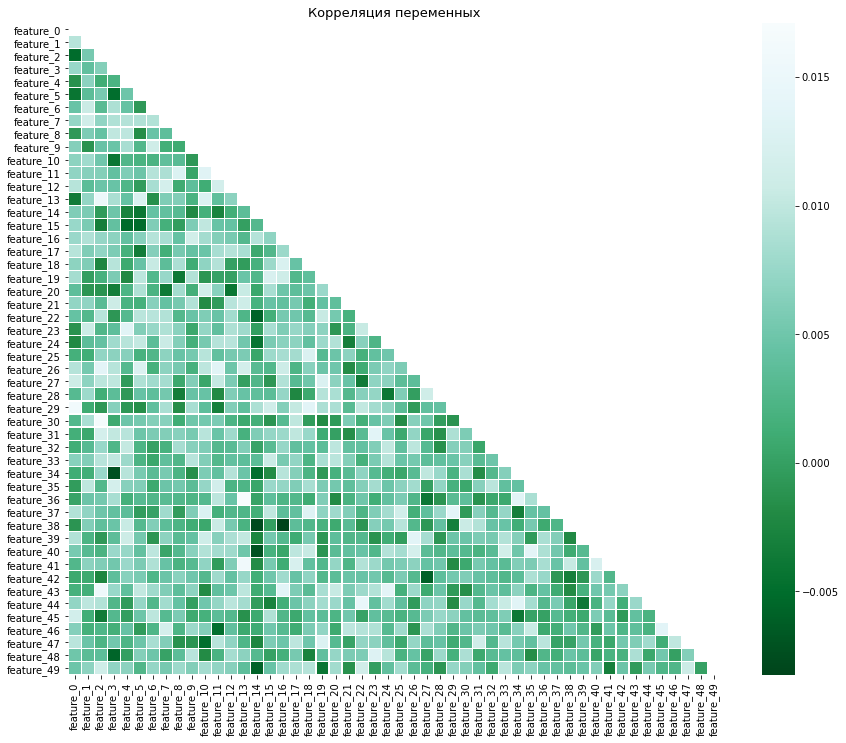

In [9]:
fig, ax = plt.subplots(figsize=(15 , 12))

heatmap = sns.heatmap(feature_corr, 
                      square=True, 
                      mask= mask,
                      linewidth=0.15,
                      cmap = 'BuGn_r')


plt.title("Корреляция переменных", fontsize =13)
plt.show()

Здесь мы наблюдаем отсутсвие значимой корреляции между переменными. Далле рассмотрим целевую переменную

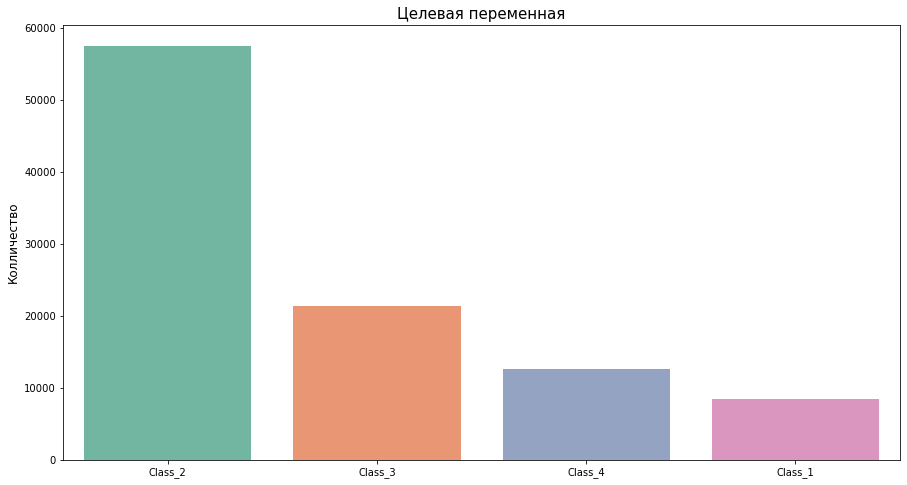

In [10]:
fig, ax = plt.subplots(figsize=(15 , 8))

sns.countplot(data_train['target'],
              palette = "Set2",
              order = data_train['target'].value_counts().index)

plt.title("Целевая переменная", fontsize =15)
plt.xlabel('')
plt.ylabel('Колличество',fontsize =12)


plt.show()

Здесь мы наблюдаем, что большая часть целевой переменной относится ко второму классу. Рассмотрим распределение данных

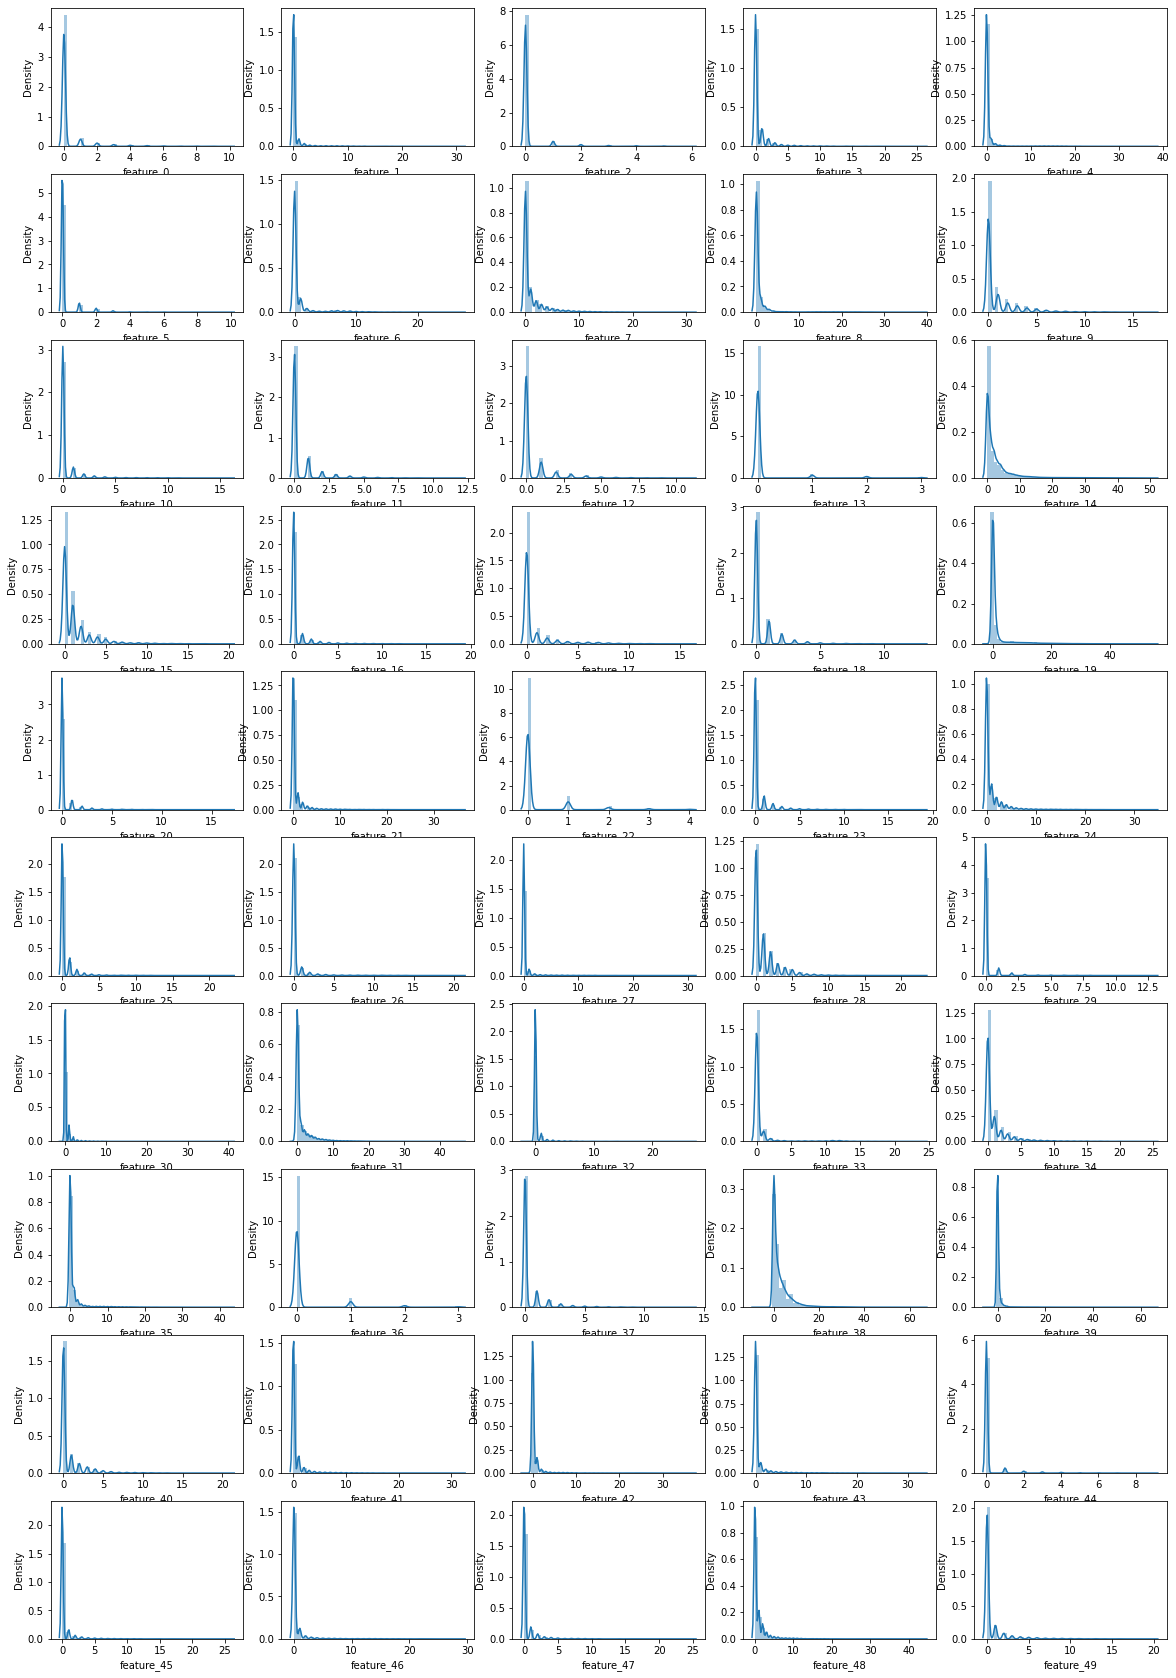

In [11]:
dist_of_features = data_train.drop(['target','id'],axis = 1)
n_rows= 10
n_cols= 5

fig, axes = plt.subplots(nrows=n_rows,ncols=n_cols,  figsize=(20, 30))

for i, column in enumerate(dist_of_features.columns):
    sns.distplot(dist_of_features[column],ax=axes[i//n_cols,i%n_cols])

Как видим все наши перменные скошены. Теперь стоит перейти к разработке модели 

## Постройка и настройка модели

Перекодируем нашу категориальную предсказываемую переменную

In [12]:
le = LabelEncoder()

In [13]:
X = data_train.drop(['target', 'id'], axis = 1)
y = le.fit_transform(data_train['target'])
X_final_check = data_test

Далее разделим наши данные на испытательный и проверочный набор

In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42, stratify=y)

In [15]:
datax = data_train.drop(['target', 'id'], axis = 1)
target= le.fit_transform(data_train['target'])

## XGBoost

Создадим функцию для настройки гиперпараметров XGBoost

In [25]:
def objective(trial, datax = datax , target = target):
    
    train_x,test_x,train_y,test_y = train_test_split(datax,target, test_size = 0.10,random_state = 42, stratify=y)
    
    param = {
        'eval_metric' : 'mlogloss',
        'booster' : 'gbtree',
        'tree_method' : 'gpu_hist' , 
        'use_label_encoder' : False , 
        'lambda' : trial.suggest_loguniform('lambda' , 1e-5 , 1.0),
        'alpha' : trial.suggest_loguniform('alpha' , 1e-5 , 1.0),
        'colsample_bytree' : trial.suggest_uniform('colsample_bytree' , 0 , 1.0),
        'subsample' : trial.suggest_uniform('subsample' , 0 , 1.0),
        'learning_rate' : trial.suggest_uniform('learning_rate' , 0 , 0.02),
        'n_estimators' : trial.suggest_int('n_estimators' , 1 , 9999),
        'max_depth' : trial.suggest_int('max_depth' , 1 , 20),
        'random_state' : trial.suggest_categorical('random_state' , [0,42,2021]),
        'min_child_weight' : trial.suggest_int('min_child_weight' , 1 , 300),
        'gamma' : trial.suggest_loguniform('gamma' , 1e-5 , 1.0),
        'objective': 'multi:softprob',
        'num_class': 4
        
        
    }
    

    model = xgb.XGBClassifier(**param)
    model.fit(train_x , train_y , eval_set = [(test_x , test_y)] , early_stopping_rounds = 222 , \
              verbose = False)
    preds = model.predict_proba(test_x)
    logistic_loss = log_loss(test_y , preds )
    return logistic_loss

Поиск оптимальных параметров

In [26]:
%%time
study = optuna.create_study(direction = 'minimize' , study_name = 'xgbclassifier')
study.optimize(objective , n_trials = 200)
print('number of the finished trials:' , len(study.trials))
print('the parametors of best trial:' , study.best_trial.params)
print('best value:' , study.best_value)

[I 2021-05-28 22:10:32,869] A new study created in memory with name: xgbclassifier
[I 2021-05-28 22:12:11,267] Trial 0 finished with value: 1.0904216398730875 and parameters: {'lambda': 0.019842452230468297, 'alpha': 0.43655969526445804, 'colsample_bytree': 0.2731034797034074, 'subsample': 0.844845928994192, 'learning_rate': 0.008702820323962338, 'n_estimators': 8389, 'max_depth': 12, 'random_state': 0, 'min_child_weight': 199, 'gamma': 0.0012625511353480778}. Best is trial 0 with value: 1.0904216398730875.
[I 2021-05-28 22:13:03,087] Trial 1 finished with value: 1.0896156128302217 and parameters: {'lambda': 0.6253124946626505, 'alpha': 0.0013139064913783318, 'colsample_bytree': 0.4692004352179917, 'subsample': 0.6572077488116805, 'learning_rate': 0.0162529125276701, 'n_estimators': 1032, 'max_depth': 11, 'random_state': 42, 'min_child_weight': 99, 'gamma': 0.2953604294687357}. Best is trial 1 with value: 1.0896156128302217.
[I 2021-05-28 22:15:06,848] Trial 2 finished with value: 1.09

[I 2021-05-28 22:40:55,319] Trial 19 finished with value: 1.0955613086640834 and parameters: {'lambda': 0.00032050726393166156, 'alpha': 0.18673936474113284, 'colsample_bytree': 0.1553755278025698, 'subsample': 0.7842185008981909, 'learning_rate': 0.006056818331359603, 'n_estimators': 6275, 'max_depth': 1, 'random_state': 0, 'min_child_weight': 49, 'gamma': 0.005136387382325378}. Best is trial 18 with value: 1.0873864111557603.
[I 2021-05-28 22:41:58,747] Trial 20 finished with value: 1.0890347067758441 and parameters: {'lambda': 0.00045633972148508966, 'alpha': 1.050156946927935e-05, 'colsample_bytree': 0.33324959927639086, 'subsample': 0.9725878118422647, 'learning_rate': 0.015515768823364917, 'n_estimators': 7041, 'max_depth': 8, 'random_state': 0, 'min_child_weight': 85, 'gamma': 0.0007231804123042475}. Best is trial 18 with value: 1.0873864111557603.
[I 2021-05-28 22:43:21,017] Trial 21 finished with value: 1.087592302364111 and parameters: {'lambda': 0.007765081514228776, 'alpha'

[I 2021-05-28 23:10:27,702] Trial 38 finished with value: 1.090250599242747 and parameters: {'lambda': 0.015268175719634442, 'alpha': 0.0118074235186953, 'colsample_bytree': 0.551926129840375, 'subsample': 0.6353005560881217, 'learning_rate': 0.011314720209577344, 'n_estimators': 5681, 'max_depth': 4, 'random_state': 42, 'min_child_weight': 165, 'gamma': 2.1095031154697207e-05}. Best is trial 18 with value: 1.0873864111557603.
[I 2021-05-28 23:11:18,250] Trial 39 finished with value: 1.0881446176752447 and parameters: {'lambda': 7.88718515967191e-05, 'alpha': 0.019156274300709344, 'colsample_bytree': 0.26908303931562283, 'subsample': 0.3313405717974538, 'learning_rate': 0.017818668223132248, 'n_estimators': 7586, 'max_depth': 7, 'random_state': 0, 'min_child_weight': 15, 'gamma': 0.0014254337224571905}. Best is trial 18 with value: 1.0873864111557603.
[I 2021-05-28 23:13:11,562] Trial 40 finished with value: 1.0895307802841068 and parameters: {'lambda': 0.02345352134873257, 'alpha': 0.

[I 2021-05-28 23:36:55,631] Trial 57 finished with value: 1.0890040671944619 and parameters: {'lambda': 0.010173858078283683, 'alpha': 0.5268607339222859, 'colsample_bytree': 0.30667696918526044, 'subsample': 0.7049070226456305, 'learning_rate': 0.011101107012637917, 'n_estimators': 5696, 'max_depth': 9, 'random_state': 0, 'min_child_weight': 65, 'gamma': 0.1457602710227934}. Best is trial 18 with value: 1.0873864111557603.
[I 2021-05-28 23:38:09,842] Trial 58 finished with value: 1.0879928073808551 and parameters: {'lambda': 0.02072715471233019, 'alpha': 0.005144288541867617, 'colsample_bytree': 0.17467610081610946, 'subsample': 0.9328398452752164, 'learning_rate': 0.011998266456232342, 'n_estimators': 9945, 'max_depth': 6, 'random_state': 42, 'min_child_weight': 1, 'gamma': 0.02872929178854989}. Best is trial 18 with value: 1.0873864111557603.
[I 2021-05-28 23:40:17,155] Trial 59 finished with value: 1.0884405835837125 and parameters: {'lambda': 2.7087665792535402e-05, 'alpha': 0.000

[I 2021-05-29 00:07:50,500] Trial 76 finished with value: 1.0886703674927354 and parameters: {'lambda': 0.6802508142904513, 'alpha': 0.0009429428467494191, 'colsample_bytree': 0.06679174050866155, 'subsample': 0.29064674721732253, 'learning_rate': 0.008071008386662687, 'n_estimators': 7309, 'max_depth': 2, 'random_state': 0, 'min_child_weight': 19, 'gamma': 2.3153260935359603e-05}. Best is trial 73 with value: 1.0872722186803818.
[I 2021-05-29 00:09:42,423] Trial 77 finished with value: 1.0992973850786687 and parameters: {'lambda': 0.12169474688882977, 'alpha': 0.003946122590562137, 'colsample_bytree': 0.0033936705923524324, 'subsample': 0.36824040000630565, 'learning_rate': 0.005049249552385483, 'n_estimators': 7760, 'max_depth': 1, 'random_state': 0, 'min_child_weight': 8, 'gamma': 3.347911330810209e-05}. Best is trial 73 with value: 1.0872722186803818.
[I 2021-05-29 00:11:38,054] Trial 78 finished with value: 1.087669091591239 and parameters: {'lambda': 0.1718063794743506, 'alpha': 

[I 2021-05-29 00:47:07,581] Trial 95 finished with value: 1.0876152563512325 and parameters: {'lambda': 0.7275654566507934, 'alpha': 0.010568370110272157, 'colsample_bytree': 0.14492317553847373, 'subsample': 0.5726908974740393, 'learning_rate': 0.004728521180977052, 'n_estimators': 6835, 'max_depth': 6, 'random_state': 42, 'min_child_weight': 41, 'gamma': 2.890932609892574e-05}. Best is trial 73 with value: 1.0872722186803818.
[I 2021-05-29 00:48:55,646] Trial 96 finished with value: 1.0884679470077157 and parameters: {'lambda': 8.015381269587374e-05, 'alpha': 0.0018422622712672252, 'colsample_bytree': 0.20953258833778646, 'subsample': 0.6151828014076676, 'learning_rate': 0.010345354517099205, 'n_estimators': 8173, 'max_depth': 11, 'random_state': 0, 'min_child_weight': 25, 'gamma': 2.01528003227513e-05}. Best is trial 73 with value: 1.0872722186803818.
[I 2021-05-29 00:50:55,961] Trial 97 finished with value: 1.0895700869709253 and parameters: {'lambda': 0.9694859449729201, 'alpha': 

[I 2021-05-29 01:17:38,955] Trial 114 finished with value: 1.0874934443354607 and parameters: {'lambda': 0.000896652200268173, 'alpha': 0.9910101522554844, 'colsample_bytree': 0.20812011639518674, 'subsample': 0.5913589957023685, 'learning_rate': 0.011373190298175795, 'n_estimators': 7284, 'max_depth': 3, 'random_state': 0, 'min_child_weight': 17, 'gamma': 0.0002729933330836684}. Best is trial 73 with value: 1.0872722186803818.
[I 2021-05-29 01:19:01,544] Trial 115 finished with value: 1.0877209310114384 and parameters: {'lambda': 0.000849785292157636, 'alpha': 0.9907447275881366, 'colsample_bytree': 0.24271222261010422, 'subsample': 0.6523500118906213, 'learning_rate': 0.011398241205739618, 'n_estimators': 7228, 'max_depth': 3, 'random_state': 0, 'min_child_weight': 25, 'gamma': 0.00032109002603587675}. Best is trial 73 with value: 1.0872722186803818.
[I 2021-05-29 01:21:03,818] Trial 116 finished with value: 1.0877271068364383 and parameters: {'lambda': 0.0011913671334371218, 'alpha'

[I 2021-05-29 01:52:17,742] Trial 133 finished with value: 1.0872883867517114 and parameters: {'lambda': 2.2796923846190395e-05, 'alpha': 0.11222889086617281, 'colsample_bytree': 0.14209343968979157, 'subsample': 0.7198982903867198, 'learning_rate': 0.009482174279270525, 'n_estimators': 9022, 'max_depth': 5, 'random_state': 0, 'min_child_weight': 13, 'gamma': 0.0012821533412468414}. Best is trial 131 with value: 1.0871969926074148.
[I 2021-05-29 01:53:57,730] Trial 134 finished with value: 1.0881378770291805 and parameters: {'lambda': 2.2178403408923986e-05, 'alpha': 0.09514336484946849, 'colsample_bytree': 0.14456086619403655, 'subsample': 0.7285115158213454, 'learning_rate': 0.009523622388094215, 'n_estimators': 9024, 'max_depth': 6, 'random_state': 0, 'min_child_weight': 1, 'gamma': 0.0011849607059088209}. Best is trial 131 with value: 1.0871969926074148.
[I 2021-05-29 01:55:31,584] Trial 135 finished with value: 1.0874573677033186 and parameters: {'lambda': 3.649533334291365e-05, '

[I 2021-05-29 02:32:24,906] Trial 152 finished with value: 1.0874241796016693 and parameters: {'lambda': 1.3953384044707118e-05, 'alpha': 0.07737565523713806, 'colsample_bytree': 0.11525089055581791, 'subsample': 0.7478252665547463, 'learning_rate': 0.009190097286073116, 'n_estimators': 8442, 'max_depth': 7, 'random_state': 0, 'min_child_weight': 27, 'gamma': 0.0006381348627160972}. Best is trial 151 with value: 1.0871401414573192.
[I 2021-05-29 02:34:21,939] Trial 153 finished with value: 1.0873563028424977 and parameters: {'lambda': 1.6157109831747004e-05, 'alpha': 0.058595375129709235, 'colsample_bytree': 0.11729943142543285, 'subsample': 0.7474388331599021, 'learning_rate': 0.00920364843141771, 'n_estimators': 8379, 'max_depth': 6, 'random_state': 0, 'min_child_weight': 37, 'gamma': 0.0018814955118677764}. Best is trial 151 with value: 1.0871401414573192.
[I 2021-05-29 02:37:07,659] Trial 154 finished with value: 1.0910839108258485 and parameters: {'lambda': 1.6489208601383282e-05,

[I 2021-05-29 03:13:33,974] Trial 171 finished with value: 1.0873402163833379 and parameters: {'lambda': 1.5077040606954112e-05, 'alpha': 0.033385418345663526, 'colsample_bytree': 0.11154218023791469, 'subsample': 0.6745380548187389, 'learning_rate': 0.007858822665614851, 'n_estimators': 9995, 'max_depth': 7, 'random_state': 0, 'min_child_weight': 40, 'gamma': 0.000958618188681885}. Best is trial 151 with value: 1.0871401414573192.
[I 2021-05-29 03:15:47,740] Trial 172 finished with value: 1.0872579084828495 and parameters: {'lambda': 1.277917478423124e-05, 'alpha': 0.03457827198224122, 'colsample_bytree': 0.10325235277366873, 'subsample': 0.6773097687826339, 'learning_rate': 0.007844554726273281, 'n_estimators': 9991, 'max_depth': 7, 'random_state': 0, 'min_child_weight': 42, 'gamma': 0.0009791293111921372}. Best is trial 151 with value: 1.0871401414573192.
[I 2021-05-29 03:18:09,450] Trial 173 finished with value: 1.0873671897649766 and parameters: {'lambda': 1.0354011689739901e-05, 

[I 2021-05-29 03:57:49,036] Trial 190 finished with value: 1.0884103224739432 and parameters: {'lambda': 1.0014709500629788e-05, 'alpha': 0.013816848595288094, 'colsample_bytree': 0.15306679055535566, 'subsample': 0.6863349173925147, 'learning_rate': 0.006835777439616951, 'n_estimators': 9340, 'max_depth': 7, 'random_state': 0, 'min_child_weight': 68, 'gamma': 0.0007085922106479003}. Best is trial 151 with value: 1.0871401414573192.
[I 2021-05-29 03:59:26,462] Trial 191 finished with value: 1.0875237391471864 and parameters: {'lambda': 1.6850330247823804e-05, 'alpha': 0.038024740599415255, 'colsample_bytree': 0.12799295817976797, 'subsample': 0.7122183688199741, 'learning_rate': 0.009150212054305005, 'n_estimators': 9773, 'max_depth': 6, 'random_state': 0, 'min_child_weight': 40, 'gamma': 0.0013738302302261042}. Best is trial 151 with value: 1.0871401414573192.
[I 2021-05-29 04:01:57,153] Trial 192 finished with value: 1.0875460476785899 and parameters: {'lambda': 1.2821782459462518e-0

number of the finished trials: 200
the parametors of best trial: {'lambda': 1.5126672756867473e-05, 'alpha': 0.032737550288022665, 'colsample_bytree': 0.08879682407470182, 'subsample': 0.7224280918203384, 'learning_rate': 0.009155997032308644, 'n_estimators': 8475, 'max_depth': 5, 'random_state': 0, 'min_child_weight': 22, 'gamma': 0.0008214801644524149}
best value: 1.0871401414573192
Wall time: 6h 5min 30s


Визуализация

In [17]:
#optuna.visualization.plot_optimization_history(study)

In [18]:
#optuna.visualization.plot_param_importances(study)

Лучшие параметры согласно условиям поиска

In [30]:
study.best_params

{'lambda': 1.5126672756867473e-05,
 'alpha': 0.032737550288022665,
 'colsample_bytree': 0.08879682407470182,
 'subsample': 0.7224280918203384,
 'learning_rate': 0.009155997032308644,
 'n_estimators': 8475,
 'max_depth': 5,
 'random_state': 0,
 'min_child_weight': 22,
 'gamma': 0.0008214801644524149}

In [32]:
xgbparams = {
    'eval_metric' : 'mlogloss',
    'booster' : 'gbtree',
    'tree_method' : 'gpu_hist' , 
    'use_label_encoder' : False ,
    'lambda': 1.5126672756867473e-05,
     'alpha': 0.032737550288022665,
     'colsample_bytree': 0.08879682407470182,
     'subsample': 0.7224280918203384,
     'learning_rate': 0.009155997032308644,
     'n_estimators': 8475,
     'max_depth': 5,
     'random_state': 0,
     'min_child_weight': 22,
     'gamma': 0.0008214801644524149,
     'objective': 'multi:softprob',
     'num_class': 4}

In [47]:
data_testx = data_test.drop(['id'], axis = 1)

In [41]:
targetx = pd.Series(target)

Тренировка модели

In [49]:
%%time


folds = KFold(n_splits = 10, shuffle = True, random_state = 0)

for fold, (trn_idx, val_idx) in enumerate(folds.split(datax, targetx)):
    
    X_train, X_val = datax.iloc[trn_idx], datax.iloc[val_idx]
    y_train, y_val = targetx.iloc[trn_idx], targetx.iloc[val_idx]

    model = xgb.XGBClassifier(**xgbparams)
   
    model.fit(X_train, y_train, eval_set = [(X_val, y_val)], eval_metric = 'mlogloss',verbose = False,  early_stopping_rounds = 222)
    
    

Wall time: 17min 57s


Запись результатов

In [55]:
xgb_pred_proba = model.predict_proba(data_testx)

In [56]:
submission_xgb = pd.DataFrame(xgb_pred_proba)

In [57]:
submission_xgb['id']=data_test['id']

In [59]:
submission_xgb.rename(columns = {0:'Class_1',
                                    1:'Class_2',
                                    2:'Class_3',
                                    3:'Class_4'},
                        inplace=True)

In [60]:
submission_xgb.to_csv("submission_XGB_Optuna.csv",index=False)

Модель с теми же параметрами, но с другим подходом при тренировке

In [68]:
%%time
folds2 = StratifiedKFold(n_splits = 10,shuffle = True, random_state = 0)
for fold, (trn_idx, val_idx) in enumerate(folds2.split(datax, targetx)):
    
    X_train, X_val = datax.iloc[trn_idx], datax.iloc[val_idx]
    y_train, y_val = targetx.iloc[trn_idx], targetx.iloc[val_idx]

    model2 = xgb.XGBClassifier(**xgbparams)
   
    model2.fit(X_train, y_train, eval_set = [(X_val, y_val)], eval_metric = 'mlogloss',verbose = False,  early_stopping_rounds = 222)

Wall time: 17min 50s


Запись результатов

In [69]:
xgb_pred_proba2 = model2.predict_proba(data_testx)

In [70]:
submission_xgb2 = pd.DataFrame(xgb_pred_proba2)

In [71]:
submission_xgb2['id']=data_test['id']

In [72]:
submission_xgb2.rename(columns = {0:'Class_1',
                                    1:'Class_2',
                                    2:'Class_3',
                                    3:'Class_4'},
                        inplace=True)

In [73]:
submission_xgb2.to_csv("submission_XGB_Optuna2.csv",index=False)

## LightGBM

Создадим функцию для настройки гиперпараметров LightGBM

In [124]:
def objective(trial, data = datax, target = target):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, random_state = 42,stratify=y)

    params2 = {
        "objective": "multiclass",
        'num_class': 4,
        'metric': 'multi_logloss',
        'random_state': 42,
        'boosting_type': 'gbdt',
        
        #+/-
        'lambda_l1': trial.suggest_loguniform('lambda_l1', 1e-8, 10.0),
        'lambda_l2': trial.suggest_loguniform('lambda_l2', 1e-8, 10.0),
        'num_leaves': trial.suggest_int('num_leaves', 2, 333),
        'n_estimators': trial.suggest_int('n_estimators', 100, 10000),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0, 1),
        'learning_rate': trial.suggest_uniform('learning_rate', 0 , 0.1),
        'max_depth': trial.suggest_int('max_depth', 1, 20),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.4, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.4, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 7),
        "max_bin" : trial.suggest_int("max_bin",50,355),
        'device': 'gpu',
        "is_unbalance": True
        
        
    }
    
    model3 = lightgbm.LGBMClassifier(**params2)  
    model3.fit(X_train, y_train, eval_set = [(X_val,y_val)], early_stopping_rounds = 222, verbose = False)
    y_pred = model3.predict_proba(X_val)
    logistic_loss_lgbm = log_loss(y_val, y_pred)

    return logistic_loss_lgbm

Поиск оптимальных параметров

In [129]:
%%time
study2 = optuna.create_study(direction = 'minimize' , study_name = 'lgbmclassifier')
study2.optimize(objective, n_trials = 500)
print('Number of finished trials:', len(study2.trials))
print('Best trial:', study2.best_trial.params)
print('Best value:', study2.best_value)

[I 2021-05-30 01:01:50,371] A new study created in memory with name: lgbmclassifier
[I 2021-05-30 01:02:01,702] Trial 0 finished with value: 1.0879623518809385 and parameters: {'lambda_l1': 0.0009829423774115724, 'lambda_l2': 3.781120882687496e-05, 'num_leaves': 150, 'n_estimators': 8217, 'colsample_bytree': 0.5641983516231012, 'learning_rate': 0.08117439732137195, 'max_depth': 2, 'min_child_samples': 34, 'feature_fraction': 0.6856346135972105, 'bagging_fraction': 0.6605746067993804, 'bagging_freq': 6, 'max_bin': 58}. Best is trial 0 with value: 1.0879623518809385.


[LightGBM] [Warning] feature_fraction is set=0.5162918156658713, colsample_bytree=0.15456914518808695 will be ignored. Current value: feature_fraction=0.5162918156658713
[LightGBM] [Warning] lambda_l1 is set=0.1001036714526597, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1001036714526597
[LightGBM] [Warning] bagging_fraction is set=0.8582074091534309, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8582074091534309
[LightGBM] [Warning] lambda_l2 is set=4.5419927995986796e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.5419927995986796e-07
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-05-30 01:03:19,815] Trial 1 finished with value: 1.0903239931124191 and parameters: {'lambda_l1': 0.1001036714526597, 'lambda_l2': 4.5419927995986796e-07, 'num_leaves': 186, 'n_estimators': 9970, 'colsample_bytree': 0.15456914518808695, 'learning_rate': 0.013042402814531506, 'max_depth': 10, 'min_child_samples': 85, 'feature_fraction': 0.5162918156658713, 'bagging_fraction': 0.8582074091534309, 'bagging_freq': 2, 'max_bin': 201}. Best is trial 0 with value: 1.0879623518809385.


[LightGBM] [Warning] feature_fraction is set=0.41853233946201424, colsample_bytree=0.6009391711093168 will be ignored. Current value: feature_fraction=0.41853233946201424
[LightGBM] [Warning] lambda_l1 is set=2.7130155324643815e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7130155324643815e-05
[LightGBM] [Warning] bagging_fraction is set=0.9667729178032882, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9667729178032882
[LightGBM] [Warning] lambda_l2 is set=0.10327727141454596, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10327727141454596
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 01:03:52,790] Trial 2 finished with value: 1.0929331118988381 and parameters: {'lambda_l1': 2.7130155324643815e-05, 'lambda_l2': 0.10327727141454596, 'num_leaves': 252, 'n_estimators': 6055, 'colsample_bytree': 0.6009391711093168, 'learning_rate': 0.08400654923939949, 'max_depth': 11, 'min_child_samples': 50, 'feature_fraction': 0.41853233946201424, 'bagging_fraction': 0.9667729178032882, 'bagging_freq': 7, 'max_bin': 310}. Best is trial 0 with value: 1.0879623518809385.


[LightGBM] [Warning] feature_fraction is set=0.8577651287236918, colsample_bytree=0.29972768082432444 will be ignored. Current value: feature_fraction=0.8577651287236918
[LightGBM] [Warning] lambda_l1 is set=9.814487121656633e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.814487121656633e-06
[LightGBM] [Warning] bagging_fraction is set=0.8410378661352857, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8410378661352857
[LightGBM] [Warning] lambda_l2 is set=0.0007351507954774616, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007351507954774616
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-05-30 01:04:54,382] Trial 3 finished with value: 1.089576541622903 and parameters: {'lambda_l1': 9.814487121656633e-06, 'lambda_l2': 0.0007351507954774616, 'num_leaves': 16, 'n_estimators': 3939, 'colsample_bytree': 0.29972768082432444, 'learning_rate': 0.006594584026236305, 'max_depth': 9, 'min_child_samples': 208, 'feature_fraction': 0.8577651287236918, 'bagging_fraction': 0.8410378661352857, 'bagging_freq': 6, 'max_bin': 353}. Best is trial 0 with value: 1.0879623518809385.


[LightGBM] [Warning] feature_fraction is set=0.559435488405874, colsample_bytree=0.8069784895322404 will be ignored. Current value: feature_fraction=0.559435488405874
[LightGBM] [Warning] lambda_l1 is set=3.870836523532242e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.870836523532242e-05
[LightGBM] [Warning] bagging_fraction is set=0.49902446833730796, subsample=1.0 will be ignored. Current value: bagging_fraction=0.49902446833730796
[LightGBM] [Warning] lambda_l2 is set=0.05855839555879682, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05855839555879682
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-05-30 01:05:16,459] Trial 4 finished with value: 1.0888601059470036 and parameters: {'lambda_l1': 3.870836523532242e-05, 'lambda_l2': 0.05855839555879682, 'num_leaves': 280, 'n_estimators': 3334, 'colsample_bytree': 0.8069784895322404, 'learning_rate': 0.03293658297218079, 'max_depth': 2, 'min_child_samples': 270, 'feature_fraction': 0.559435488405874, 'bagging_fraction': 0.49902446833730796, 'bagging_freq': 3, 'max_bin': 318}. Best is trial 0 with value: 1.0879623518809385.


[LightGBM] [Warning] feature_fraction is set=0.5597467823209578, colsample_bytree=0.175985544085407 will be ignored. Current value: feature_fraction=0.5597467823209578
[LightGBM] [Warning] lambda_l1 is set=2.3570673239127208e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3570673239127208e-06
[LightGBM] [Warning] bagging_fraction is set=0.5655387979289035, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5655387979289035
[LightGBM] [Warning] lambda_l2 is set=7.755930685316081, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.755930685316081
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-05-30 01:05:52,628] Trial 5 finished with value: 1.0888775113631326 and parameters: {'lambda_l1': 2.3570673239127208e-06, 'lambda_l2': 7.755930685316081, 'num_leaves': 193, 'n_estimators': 7113, 'colsample_bytree': 0.175985544085407, 'learning_rate': 0.013024838714118137, 'max_depth': 5, 'min_child_samples': 198, 'feature_fraction': 0.5597467823209578, 'bagging_fraction': 0.5655387979289035, 'bagging_freq': 1, 'max_bin': 105}. Best is trial 0 with value: 1.0879623518809385.


[LightGBM] [Warning] feature_fraction is set=0.9240872575755642, colsample_bytree=0.42900934344303354 will be ignored. Current value: feature_fraction=0.9240872575755642
[LightGBM] [Warning] lambda_l1 is set=0.0015293868406825396, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0015293868406825396
[LightGBM] [Warning] bagging_fraction is set=0.43249759809298094, subsample=1.0 will be ignored. Current value: bagging_fraction=0.43249759809298094
[LightGBM] [Warning] lambda_l2 is set=1.203178509645132e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.203178509645132e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-05-30 01:08:18,224] Trial 6 finished with value: 1.0913759058756372 and parameters: {'lambda_l1': 0.0015293868406825396, 'lambda_l2': 1.203178509645132e-08, 'num_leaves': 170, 'n_estimators': 7044, 'colsample_bytree': 0.42900934344303354, 'learning_rate': 0.0056248715293399365, 'max_depth': 19, 'min_child_samples': 84, 'feature_fraction': 0.9240872575755642, 'bagging_fraction': 0.43249759809298094, 'bagging_freq': 5, 'max_bin': 175}. Best is trial 0 with value: 1.0879623518809385.


[LightGBM] [Warning] feature_fraction is set=0.41989733164185566, colsample_bytree=0.445691755242576 will be ignored. Current value: feature_fraction=0.41989733164185566
[LightGBM] [Warning] lambda_l1 is set=0.0006633669167032129, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0006633669167032129
[LightGBM] [Warning] bagging_fraction is set=0.5157141485883154, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5157141485883154
[LightGBM] [Warning] lambda_l2 is set=3.46570496334556, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.46570496334556
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 01:08:46,016] Trial 7 finished with value: 1.0899370148905265 and parameters: {'lambda_l1': 0.0006633669167032129, 'lambda_l2': 3.46570496334556, 'num_leaves': 209, 'n_estimators': 1398, 'colsample_bytree': 0.445691755242576, 'learning_rate': 0.029617444815615703, 'max_depth': 8, 'min_child_samples': 267, 'feature_fraction': 0.41989733164185566, 'bagging_fraction': 0.5157141485883154, 'bagging_freq': 7, 'max_bin': 244}. Best is trial 0 with value: 1.0879623518809385.


[LightGBM] [Warning] feature_fraction is set=0.9296355457772036, colsample_bytree=0.0473564507437072 will be ignored. Current value: feature_fraction=0.9296355457772036
[LightGBM] [Warning] lambda_l1 is set=0.00029816396261885973, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00029816396261885973
[LightGBM] [Warning] bagging_fraction is set=0.4244322547987975, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4244322547987975
[LightGBM] [Warning] lambda_l2 is set=1.0719468687546477e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0719468687546477e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-05-30 01:09:02,052] Trial 8 finished with value: 1.092223982729401 and parameters: {'lambda_l1': 0.00029816396261885973, 'lambda_l2': 1.0719468687546477e-07, 'num_leaves': 134, 'n_estimators': 8330, 'colsample_bytree': 0.0473564507437072, 'learning_rate': 0.06132435046003787, 'max_depth': 10, 'min_child_samples': 254, 'feature_fraction': 0.9296355457772036, 'bagging_fraction': 0.4244322547987975, 'bagging_freq': 3, 'max_bin': 169}. Best is trial 0 with value: 1.0879623518809385.


[LightGBM] [Warning] feature_fraction is set=0.6605864872998322, colsample_bytree=0.192508658134799 will be ignored. Current value: feature_fraction=0.6605864872998322
[LightGBM] [Warning] lambda_l1 is set=5.501330061403058, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.501330061403058
[LightGBM] [Warning] bagging_fraction is set=0.8122551763381983, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8122551763381983
[LightGBM] [Warning] lambda_l2 is set=5.053848328496708e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.053848328496708e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 01:10:49,005] Trial 9 finished with value: 1.091013516237489 and parameters: {'lambda_l1': 5.501330061403058, 'lambda_l2': 5.053848328496708e-05, 'num_leaves': 279, 'n_estimators': 5428, 'colsample_bytree': 0.192508658134799, 'learning_rate': 0.0019053012863791353, 'max_depth': 4, 'min_child_samples': 128, 'feature_fraction': 0.6605864872998322, 'bagging_fraction': 0.8122551763381983, 'bagging_freq': 7, 'max_bin': 213}. Best is trial 0 with value: 1.0879623518809385.


[LightGBM] [Warning] feature_fraction is set=0.7735897615596421, colsample_bytree=0.9674643648157353 will be ignored. Current value: feature_fraction=0.7735897615596421
[LightGBM] [Warning] lambda_l1 is set=5.397454401089479e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.397454401089479e-08
[LightGBM] [Warning] bagging_fraction is set=0.6586359114092485, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6586359114092485
[LightGBM] [Warning] lambda_l2 is set=2.6922236009773452e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6922236009773452e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-05-30 01:11:10,425] Trial 10 finished with value: 1.0947337105216803 and parameters: {'lambda_l1': 5.397454401089479e-08, 'lambda_l2': 2.6922236009773452e-05, 'num_leaves': 69, 'n_estimators': 9299, 'colsample_bytree': 0.9674643648157353, 'learning_rate': 0.09768603859304055, 'max_depth': 17, 'min_child_samples': 4, 'feature_fraction': 0.7735897615596421, 'bagging_fraction': 0.6586359114092485, 'bagging_freq': 5, 'max_bin': 58}. Best is trial 0 with value: 1.0879623518809385.


[LightGBM] [Warning] feature_fraction is set=0.6567651719448138, colsample_bytree=0.7605776047373699 will be ignored. Current value: feature_fraction=0.6567651719448138
[LightGBM] [Warning] lambda_l1 is set=0.014102898844980801, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.014102898844980801
[LightGBM] [Warning] bagging_fraction is set=0.6657648039728382, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6657648039728382
[LightGBM] [Warning] lambda_l2 is set=0.007977243780939879, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.007977243780939879
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-05-30 01:11:27,947] Trial 11 finished with value: 1.0884412940536567 and parameters: {'lambda_l1': 0.014102898844980801, 'lambda_l2': 0.007977243780939879, 'num_leaves': 116, 'n_estimators': 3098, 'colsample_bytree': 0.7605776047373699, 'learning_rate': 0.052327148379953975, 'max_depth': 1, 'min_child_samples': 165, 'feature_fraction': 0.6567651719448138, 'bagging_fraction': 0.6657648039728382, 'bagging_freq': 4, 'max_bin': 294}. Best is trial 0 with value: 1.0879623518809385.


[LightGBM] [Warning] feature_fraction is set=0.6886877165125521, colsample_bytree=0.6880815352929763 will be ignored. Current value: feature_fraction=0.6886877165125521
[LightGBM] [Warning] lambda_l1 is set=0.036898298560843666, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.036898298560843666
[LightGBM] [Warning] bagging_fraction is set=0.6796829134984848, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6796829134984848
[LightGBM] [Warning] lambda_l2 is set=0.001573564333294229, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001573564333294229
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-05-30 01:11:30,125] Trial 12 finished with value: 1.0976856203311576 and parameters: {'lambda_l1': 0.036898298560843666, 'lambda_l2': 0.001573564333294229, 'num_leaves': 108, 'n_estimators': 261, 'colsample_bytree': 0.6880815352929763, 'learning_rate': 0.0663275368078758, 'max_depth': 1, 'min_child_samples': 152, 'feature_fraction': 0.6886877165125521, 'bagging_fraction': 0.6796829134984848, 'bagging_freq': 4, 'max_bin': 269}. Best is trial 0 with value: 1.0879623518809385.


[LightGBM] [Warning] feature_fraction is set=0.7728822264147205, colsample_bytree=0.8853977873156065 will be ignored. Current value: feature_fraction=0.7728822264147205
[LightGBM] [Warning] lambda_l1 is set=0.06133693689508437, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.06133693689508437
[LightGBM] [Warning] bagging_fraction is set=0.7425500071336234, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7425500071336234
[LightGBM] [Warning] lambda_l2 is set=5.263978267698227e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.263978267698227e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-05-30 01:11:40,027] Trial 13 finished with value: 1.088740577126826 and parameters: {'lambda_l1': 0.06133693689508437, 'lambda_l2': 5.263978267698227e-06, 'num_leaves': 54, 'n_estimators': 2551, 'colsample_bytree': 0.8853977873156065, 'learning_rate': 0.08155360854526918, 'max_depth': 1, 'min_child_samples': 156, 'feature_fraction': 0.7728822264147205, 'bagging_fraction': 0.7425500071336234, 'bagging_freq': 5, 'max_bin': 114}. Best is trial 0 with value: 1.0879623518809385.


[LightGBM] [Warning] feature_fraction is set=0.6364036381553074, colsample_bytree=0.7017718010934073 will be ignored. Current value: feature_fraction=0.6364036381553074
[LightGBM] [Warning] lambda_l1 is set=1.4832951346255212, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4832951346255212
[LightGBM] [Warning] bagging_fraction is set=0.6133962317326509, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6133962317326509
[LightGBM] [Warning] lambda_l2 is set=0.011250372881208668, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.011250372881208668
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-05-30 01:11:56,802] Trial 14 finished with value: 1.0895572999383314 and parameters: {'lambda_l1': 1.4832951346255212, 'lambda_l2': 0.011250372881208668, 'num_leaves': 113, 'n_estimators': 4600, 'colsample_bytree': 0.7017718010934073, 'learning_rate': 0.04650597177284906, 'max_depth': 5, 'min_child_samples': 4, 'feature_fraction': 0.6364036381553074, 'bagging_fraction': 0.6133962317326509, 'bagging_freq': 4, 'max_bin': 51}. Best is trial 0 with value: 1.0879623518809385.


[LightGBM] [Warning] feature_fraction is set=0.7936317445768271, colsample_bytree=0.548383920826513 will be ignored. Current value: feature_fraction=0.7936317445768271
[LightGBM] [Warning] lambda_l1 is set=0.005880266975466591, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005880266975466591
[LightGBM] [Warning] bagging_fraction is set=0.7410859217981756, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7410859217981756
[LightGBM] [Warning] lambda_l2 is set=0.46953131851326296, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.46953131851326296
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-05-30 01:12:22,413] Trial 15 finished with value: 1.0924992592409373 and parameters: {'lambda_l1': 0.005880266975466591, 'lambda_l2': 0.46953131851326296, 'num_leaves': 147, 'n_estimators': 2226, 'colsample_bytree': 0.548383920826513, 'learning_rate': 0.09705820131168458, 'max_depth': 14, 'min_child_samples': 200, 'feature_fraction': 0.7936317445768271, 'bagging_fraction': 0.7410859217981756, 'bagging_freq': 6, 'max_bin': 352}. Best is trial 0 with value: 1.0879623518809385.


[LightGBM] [Warning] feature_fraction is set=0.7289474604004779, colsample_bytree=0.7821976793358291 will be ignored. Current value: feature_fraction=0.7289474604004779
[LightGBM] [Warning] lambda_l1 is set=0.5971196716270046, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5971196716270046
[LightGBM] [Warning] bagging_fraction is set=0.6066641576687113, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6066641576687113
[LightGBM] [Warning] lambda_l2 is set=0.005396642310457116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005396642310457116
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-05-30 01:12:26,948] Trial 16 finished with value: 1.0887653037789071 and parameters: {'lambda_l1': 0.5971196716270046, 'lambda_l2': 0.005396642310457116, 'num_leaves': 332, 'n_estimators': 355, 'colsample_bytree': 0.7821976793358291, 'learning_rate': 0.07112518824342667, 'max_depth': 3, 'min_child_samples': 108, 'feature_fraction': 0.7289474604004779, 'bagging_fraction': 0.6066641576687113, 'bagging_freq': 6, 'max_bin': 281}. Best is trial 0 with value: 1.0879623518809385.


[LightGBM] [Warning] feature_fraction is set=0.5908113176526226, colsample_bytree=0.9969409131863416 will be ignored. Current value: feature_fraction=0.5908113176526226
[LightGBM] [Warning] lambda_l1 is set=0.009129906797889897, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009129906797889897
[LightGBM] [Warning] bagging_fraction is set=0.748859204048685, subsample=1.0 will be ignored. Current value: bagging_fraction=0.748859204048685
[LightGBM] [Warning] lambda_l2 is set=0.0002746156013841322, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002746156013841322
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-05-30 01:12:51,395] Trial 17 finished with value: 1.0905678801798644 and parameters: {'lambda_l1': 0.009129906797889897, 'lambda_l2': 0.0002746156013841322, 'num_leaves': 72, 'n_estimators': 7676, 'colsample_bytree': 0.9969409131863416, 'learning_rate': 0.046003450483104044, 'max_depth': 7, 'min_child_samples': 34, 'feature_fraction': 0.5908113176526226, 'bagging_fraction': 0.748859204048685, 'bagging_freq': 3, 'max_bin': 111}. Best is trial 0 with value: 1.0879623518809385.


[LightGBM] [Warning] feature_fraction is set=0.6289920063369101, colsample_bytree=0.637399296509318 will be ignored. Current value: feature_fraction=0.6289920063369101
[LightGBM] [Warning] lambda_l1 is set=2.4560807320331854e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4560807320331854e-07
[LightGBM] [Warning] bagging_fraction is set=0.9683481926204305, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9683481926204305
[LightGBM] [Warning] lambda_l2 is set=1.9696753121425554e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9696753121425554e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-05-30 01:13:14,838] Trial 18 finished with value: 1.0880109488924328 and parameters: {'lambda_l1': 2.4560807320331854e-07, 'lambda_l2': 1.9696753121425554e-06, 'num_leaves': 2, 'n_estimators': 5983, 'colsample_bytree': 0.637399296509318, 'learning_rate': 0.056256553720885075, 'max_depth': 1, 'min_child_samples': 172, 'feature_fraction': 0.6289920063369101, 'bagging_fraction': 0.9683481926204305, 'bagging_freq': 1, 'max_bin': 149}. Best is trial 0 with value: 1.0879623518809385.


[LightGBM] [Warning] feature_fraction is set=0.4798510353291071, colsample_bytree=0.3611923097264905 will be ignored. Current value: feature_fraction=0.4798510353291071
[LightGBM] [Warning] lambda_l1 is set=3.140313506388506e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.140313506388506e-08
[LightGBM] [Warning] bagging_fraction is set=0.9812293730201779, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9812293730201779
[LightGBM] [Warning] lambda_l2 is set=1.0978572726750729e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0978572726750729e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-05-30 01:13:24,104] Trial 19 finished with value: 1.0894605967037891 and parameters: {'lambda_l1': 3.140313506388506e-08, 'lambda_l2': 1.0978572726750729e-06, 'num_leaves': 7, 'n_estimators': 8993, 'colsample_bytree': 0.3611923097264905, 'learning_rate': 0.0832663520562418, 'max_depth': 6, 'min_child_samples': 233, 'feature_fraction': 0.4798510353291071, 'bagging_fraction': 0.9812293730201779, 'bagging_freq': 1, 'max_bin': 83}. Best is trial 0 with value: 1.0879623518809385.


[LightGBM] [Warning] feature_fraction is set=0.8434181171455986, colsample_bytree=0.5646257423153718 will be ignored. Current value: feature_fraction=0.8434181171455986
[LightGBM] [Warning] lambda_l1 is set=4.321017156761361e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.321017156761361e-07
[LightGBM] [Warning] bagging_fraction is set=0.9031852080138222, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9031852080138222
[LightGBM] [Warning] lambda_l2 is set=1.4038403700891407e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4038403700891407e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-05-30 01:13:39,649] Trial 20 finished with value: 1.0913125757726285 and parameters: {'lambda_l1': 4.321017156761361e-07, 'lambda_l2': 1.4038403700891407e-08, 'num_leaves': 35, 'n_estimators': 6440, 'colsample_bytree': 0.5646257423153718, 'learning_rate': 0.07494732514069727, 'max_depth': 13, 'min_child_samples': 119, 'feature_fraction': 0.8434181171455986, 'bagging_fraction': 0.9031852080138222, 'bagging_freq': 2, 'max_bin': 146}. Best is trial 0 with value: 1.0879623518809385.


[LightGBM] [Warning] feature_fraction is set=0.6255943031361795, colsample_bytree=0.6462371770565696 will be ignored. Current value: feature_fraction=0.6255943031361795
[LightGBM] [Warning] lambda_l1 is set=0.0004116155725745348, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004116155725745348
[LightGBM] [Warning] bagging_fraction is set=0.6366187271194117, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6366187271194117
[LightGBM] [Warning] lambda_l2 is set=8.60385899535524e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.60385899535524e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-05-30 01:14:02,674] Trial 21 finished with value: 1.0884266665888007 and parameters: {'lambda_l1': 0.0004116155725745348, 'lambda_l2': 8.60385899535524e-05, 'num_leaves': 94, 'n_estimators': 4811, 'colsample_bytree': 0.6462371770565696, 'learning_rate': 0.06097310728137342, 'max_depth': 1, 'min_child_samples': 171, 'feature_fraction': 0.6255943031361795, 'bagging_fraction': 0.6366187271194117, 'bagging_freq': 2, 'max_bin': 231}. Best is trial 0 with value: 1.0879623518809385.


[LightGBM] [Warning] feature_fraction is set=0.6095532147892182, colsample_bytree=0.6360397783278404 will be ignored. Current value: feature_fraction=0.6095532147892182
[LightGBM] [Warning] lambda_l1 is set=0.00019902105153644673, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00019902105153644673
[LightGBM] [Warning] bagging_fraction is set=0.5874538208034334, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5874538208034334
[LightGBM] [Warning] lambda_l2 is set=6.087910187630533e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.087910187630533e-05
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-05-30 01:14:15,623] Trial 22 finished with value: 1.0882959140676038 and parameters: {'lambda_l1': 0.00019902105153644673, 'lambda_l2': 6.087910187630533e-05, 'num_leaves': 224, 'n_estimators': 4687, 'colsample_bytree': 0.6360397783278404, 'learning_rate': 0.05914049880512142, 'max_depth': 3, 'min_child_samples': 173, 'feature_fraction': 0.6095532147892182, 'bagging_fraction': 0.5874538208034334, 'bagging_freq': 2, 'max_bin': 234}. Best is trial 0 with value: 1.0879623518809385.


[LightGBM] [Warning] feature_fraction is set=0.7108671906192785, colsample_bytree=0.49824643798244145 will be ignored. Current value: feature_fraction=0.7108671906192785
[LightGBM] [Warning] lambda_l1 is set=8.577420808587989e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.577420808587989e-07
[LightGBM] [Warning] bagging_fraction is set=0.533503824925321, subsample=1.0 will be ignored. Current value: bagging_fraction=0.533503824925321
[LightGBM] [Warning] lambda_l2 is set=4.225998944017951e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.225998944017951e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-05-30 01:14:23,370] Trial 23 finished with value: 1.0895263888050986 and parameters: {'lambda_l1': 8.577420808587989e-07, 'lambda_l2': 4.225998944017951e-06, 'num_leaves': 230, 'n_estimators': 5650, 'colsample_bytree': 0.49824643798244145, 'learning_rate': 0.054501444620801656, 'max_depth': 3, 'min_child_samples': 296, 'feature_fraction': 0.7108671906192785, 'bagging_fraction': 0.533503824925321, 'bagging_freq': 1, 'max_bin': 145}. Best is trial 0 with value: 1.0879623518809385.


[LightGBM] [Warning] feature_fraction is set=0.49431025826126235, colsample_bytree=0.6305455903239907 will be ignored. Current value: feature_fraction=0.49431025826126235
[LightGBM] [Warning] lambda_l1 is set=0.0001202958995204918, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001202958995204918
[LightGBM] [Warning] bagging_fraction is set=0.5723576021265216, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5723576021265216
[LightGBM] [Warning] lambda_l2 is set=9.346765176657994e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.346765176657994e-06
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-05-30 01:14:41,681] Trial 24 finished with value: 1.0889372185086637 and parameters: {'lambda_l1': 0.0001202958995204918, 'lambda_l2': 9.346765176657994e-06, 'num_leaves': 324, 'n_estimators': 8165, 'colsample_bytree': 0.6305455903239907, 'learning_rate': 0.03664729664260548, 'max_depth': 3, 'min_child_samples': 231, 'feature_fraction': 0.49431025826126235, 'bagging_fraction': 0.5723576021265216, 'bagging_freq': 2, 'max_bin': 255}. Best is trial 0 with value: 1.0879623518809385.


[LightGBM] [Warning] feature_fraction is set=0.5944153284643408, colsample_bytree=0.8631627687698594 will be ignored. Current value: feature_fraction=0.5944153284643408
[LightGBM] [Warning] lambda_l1 is set=1.0176024348875428e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0176024348875428e-08
[LightGBM] [Warning] bagging_fraction is set=0.7909420742332183, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7909420742332183
[LightGBM] [Warning] lambda_l2 is set=8.600945725157152e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.600945725157152e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-05-30 01:14:51,020] Trial 25 finished with value: 1.08991296316063 and parameters: {'lambda_l1': 1.0176024348875428e-08, 'lambda_l2': 8.600945725157152e-07, 'num_leaves': 225, 'n_estimators': 4086, 'colsample_bytree': 0.8631627687698594, 'learning_rate': 0.0921523029557494, 'max_depth': 5, 'min_child_samples': 138, 'feature_fraction': 0.5944153284643408, 'bagging_fraction': 0.7909420742332183, 'bagging_freq': 1, 'max_bin': 182}. Best is trial 0 with value: 1.0879623518809385.


[LightGBM] [Warning] feature_fraction is set=0.7026191341459685, colsample_bytree=0.51602511395601 will be ignored. Current value: feature_fraction=0.7026191341459685
[LightGBM] [Warning] lambda_l1 is set=4.504920441353934e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.504920441353934e-06
[LightGBM] [Warning] bagging_fraction is set=0.462485866031743, subsample=1.0 will be ignored. Current value: bagging_fraction=0.462485866031743
[LightGBM] [Warning] lambda_l2 is set=1.0611394117089443e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0611394117089443e-07
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-05-30 01:15:02,251] Trial 26 finished with value: 1.088429054613595 and parameters: {'lambda_l1': 4.504920441353934e-06, 'lambda_l2': 1.0611394117089443e-07, 'num_leaves': 278, 'n_estimators': 6594, 'colsample_bytree': 0.51602511395601, 'learning_rate': 0.041379574805628754, 'max_depth': 3, 'min_child_samples': 179, 'feature_fraction': 0.7026191341459685, 'bagging_fraction': 0.462485866031743, 'bagging_freq': 3, 'max_bin': 76}. Best is trial 0 with value: 1.0879623518809385.


[LightGBM] [Warning] feature_fraction is set=0.5340289730953383, colsample_bytree=0.7018131490997516 will be ignored. Current value: feature_fraction=0.5340289730953383
[LightGBM] [Warning] lambda_l1 is set=2.6756170294849884e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6756170294849884e-07
[LightGBM] [Warning] bagging_fraction is set=0.7145525746499283, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7145525746499283
[LightGBM] [Warning] lambda_l2 is set=0.0001031533897957315, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001031533897957315
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-05-30 01:15:38,575] Trial 27 finished with value: 1.0890227152667775 and parameters: {'lambda_l1': 2.6756170294849884e-07, 'lambda_l2': 0.0001031533897957315, 'num_leaves': 248, 'n_estimators': 5267, 'colsample_bytree': 0.7018131490997516, 'learning_rate': 0.024610501743576804, 'max_depth': 7, 'min_child_samples': 92, 'feature_fraction': 0.5340289730953383, 'bagging_fraction': 0.7145525746499283, 'bagging_freq': 2, 'max_bin': 146}. Best is trial 0 with value: 1.0879623518809385.


[LightGBM] [Warning] feature_fraction is set=0.5943914517670245, colsample_bytree=0.4492327790829744 will be ignored. Current value: feature_fraction=0.5943914517670245
[LightGBM] [Warning] lambda_l1 is set=0.002600282268548468, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002600282268548468
[LightGBM] [Warning] bagging_fraction is set=0.5786735955151094, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5786735955151094
[LightGBM] [Warning] lambda_l2 is set=1.982533620852506e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.982533620852506e-05
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-05-30 01:15:53,796] Trial 28 finished with value: 1.0881057396879692 and parameters: {'lambda_l1': 0.002600282268548468, 'lambda_l2': 1.982533620852506e-05, 'num_leaves': 160, 'n_estimators': 7485, 'colsample_bytree': 0.4492327790829744, 'learning_rate': 0.07538607700428279, 'max_depth': 1, 'min_child_samples': 52, 'feature_fraction': 0.5943914517670245, 'bagging_fraction': 0.5786735955151094, 'bagging_freq': 1, 'max_bin': 216}. Best is trial 0 with value: 1.0879623518809385.


[LightGBM] [Warning] feature_fraction is set=0.46144182359004876, colsample_bytree=0.31321219314977705 will be ignored. Current value: feature_fraction=0.46144182359004876
[LightGBM] [Warning] lambda_l1 is set=0.0020978503753964557, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0020978503753964557
[LightGBM] [Warning] bagging_fraction is set=0.8976614322515796, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8976614322515796
[LightGBM] [Warning] lambda_l2 is set=1.035701025619727e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.035701025619727e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-05-30 01:16:20,431] Trial 29 finished with value: 1.087923715568134 and parameters: {'lambda_l1': 0.0020978503753964557, 'lambda_l2': 1.035701025619727e-07, 'num_leaves': 146, 'n_estimators': 9944, 'colsample_bytree': 0.31321219314977705, 'learning_rate': 0.07114695356895845, 'max_depth': 1, 'min_child_samples': 56, 'feature_fraction': 0.46144182359004876, 'bagging_fraction': 0.8976614322515796, 'bagging_freq': 1, 'max_bin': 201}. Best is trial 29 with value: 1.087923715568134.


[LightGBM] [Warning] feature_fraction is set=0.47522211647423374, colsample_bytree=0.3069586442492922 will be ignored. Current value: feature_fraction=0.47522211647423374
[LightGBM] [Warning] lambda_l1 is set=0.12032269700389202, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.12032269700389202
[LightGBM] [Warning] bagging_fraction is set=0.909755930832609, subsample=1.0 will be ignored. Current value: bagging_fraction=0.909755930832609
[LightGBM] [Warning] lambda_l2 is set=1.4925727463356605e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4925727463356605e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-05-30 01:16:36,196] Trial 30 finished with value: 1.088262068174882 and parameters: {'lambda_l1': 0.12032269700389202, 'lambda_l2': 1.4925727463356605e-07, 'num_leaves': 173, 'n_estimators': 9783, 'colsample_bytree': 0.3069586442492922, 'learning_rate': 0.06885251158984973, 'max_depth': 2, 'min_child_samples': 31, 'feature_fraction': 0.47522211647423374, 'bagging_fraction': 0.909755930832609, 'bagging_freq': 6, 'max_bin': 194}. Best is trial 29 with value: 1.087923715568134.


[LightGBM] [Warning] feature_fraction is set=0.4511598411746395, colsample_bytree=0.40079589309035984 will be ignored. Current value: feature_fraction=0.4511598411746395
[LightGBM] [Warning] lambda_l1 is set=0.0010119857799295723, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0010119857799295723
[LightGBM] [Warning] bagging_fraction is set=0.9096684215397591, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9096684215397591
[LightGBM] [Warning] lambda_l2 is set=2.2203497850967576e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2203497850967576e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-05-30 01:16:59,678] Trial 31 finished with value: 1.0879116700577303 and parameters: {'lambda_l1': 0.0010119857799295723, 'lambda_l2': 2.2203497850967576e-06, 'num_leaves': 144, 'n_estimators': 8702, 'colsample_bytree': 0.40079589309035984, 'learning_rate': 0.07672746895638816, 'max_depth': 1, 'min_child_samples': 58, 'feature_fraction': 0.4511598411746395, 'bagging_fraction': 0.9096684215397591, 'bagging_freq': 1, 'max_bin': 212}. Best is trial 31 with value: 1.0879116700577303.


[LightGBM] [Warning] feature_fraction is set=0.4437535358408921, colsample_bytree=0.25374066582120436 will be ignored. Current value: feature_fraction=0.4437535358408921
[LightGBM] [Warning] lambda_l1 is set=5.169360501700535e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.169360501700535e-05
[LightGBM] [Warning] bagging_fraction is set=0.9250822974449205, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9250822974449205
[LightGBM] [Warning] lambda_l2 is set=1.8759573483984045e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.8759573483984045e-06
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-05-30 01:17:13,877] Trial 32 finished with value: 1.088439616383425 and parameters: {'lambda_l1': 5.169360501700535e-05, 'lambda_l2': 1.8759573483984045e-06, 'num_leaves': 143, 'n_estimators': 9960, 'colsample_bytree': 0.25374066582120436, 'learning_rate': 0.08939513726312759, 'max_depth': 2, 'min_child_samples': 70, 'feature_fraction': 0.4437535358408921, 'bagging_fraction': 0.9250822974449205, 'bagging_freq': 1, 'max_bin': 200}. Best is trial 31 with value: 1.0879116700577303.


[LightGBM] [Warning] feature_fraction is set=0.4060292548515743, colsample_bytree=0.3683202394027224 will be ignored. Current value: feature_fraction=0.4060292548515743
[LightGBM] [Warning] lambda_l1 is set=0.0013970780340543034, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0013970780340543034
[LightGBM] [Warning] bagging_fraction is set=0.942129180511885, subsample=1.0 will be ignored. Current value: bagging_fraction=0.942129180511885
[LightGBM] [Warning] lambda_l2 is set=3.030188636922294e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.030188636922294e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-05-30 01:17:37,430] Trial 33 finished with value: 1.0879352511013647 and parameters: {'lambda_l1': 0.0013970780340543034, 'lambda_l2': 3.030188636922294e-08, 'num_leaves': 192, 'n_estimators': 9038, 'colsample_bytree': 0.3683202394027224, 'learning_rate': 0.07756391144612962, 'max_depth': 1, 'min_child_samples': 29, 'feature_fraction': 0.4060292548515743, 'bagging_fraction': 0.942129180511885, 'bagging_freq': 1, 'max_bin': 163}. Best is trial 31 with value: 1.0879116700577303.


[LightGBM] [Warning] feature_fraction is set=0.40589030459469105, colsample_bytree=0.3775801739900648 will be ignored. Current value: feature_fraction=0.40589030459469105
[LightGBM] [Warning] lambda_l1 is set=0.0018861405708323765, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0018861405708323765
[LightGBM] [Warning] bagging_fraction is set=0.8722304690216358, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8722304690216358
[LightGBM] [Warning] lambda_l2 is set=3.939136560579184e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.939136560579184e-08
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-05-30 01:17:50,421] Trial 34 finished with value: 1.0892058378278253 and parameters: {'lambda_l1': 0.0018861405708323765, 'lambda_l2': 3.939136560579184e-08, 'num_leaves': 188, 'n_estimators': 9034, 'colsample_bytree': 0.3775801739900648, 'learning_rate': 0.0791663572902402, 'max_depth': 4, 'min_child_samples': 23, 'feature_fraction': 0.40589030459469105, 'bagging_fraction': 0.8722304690216358, 'bagging_freq': 2, 'max_bin': 165}. Best is trial 31 with value: 1.0879116700577303.


[LightGBM] [Warning] feature_fraction is set=0.9982619446091334, colsample_bytree=0.09472405085196284 will be ignored. Current value: feature_fraction=0.9982619446091334
[LightGBM] [Warning] lambda_l1 is set=1.4073168708097298e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4073168708097298e-05
[LightGBM] [Warning] bagging_fraction is set=0.9375307852343011, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9375307852343011
[LightGBM] [Warning] lambda_l2 is set=2.894414623589556e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.894414623589556e-07
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-05-30 01:17:56,278] Trial 35 finished with value: 1.088389741897582 and parameters: {'lambda_l1': 1.4073168708097298e-05, 'lambda_l2': 2.894414623589556e-07, 'num_leaves': 136, 'n_estimators': 8487, 'colsample_bytree': 0.09472405085196284, 'learning_rate': 0.08973914491441475, 'max_depth': 2, 'min_child_samples': 53, 'feature_fraction': 0.9982619446091334, 'bagging_fraction': 0.9375307852343011, 'bagging_freq': 1, 'max_bin': 218}. Best is trial 31 with value: 1.0879116700577303.


[LightGBM] [Warning] feature_fraction is set=0.45030174692838504, colsample_bytree=0.2509191237162367 will be ignored. Current value: feature_fraction=0.45030174692838504
[LightGBM] [Warning] lambda_l1 is set=0.0007989550323242414, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0007989550323242414
[LightGBM] [Warning] bagging_fraction is set=0.8749930436759635, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8749930436759635
[LightGBM] [Warning] lambda_l2 is set=2.9726463888133874e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.9726463888133874e-08
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-05-30 01:18:12,067] Trial 36 finished with value: 1.0902138061937743 and parameters: {'lambda_l1': 0.0007989550323242414, 'lambda_l2': 2.9726463888133874e-08, 'num_leaves': 197, 'n_estimators': 9583, 'colsample_bytree': 0.2509191237162367, 'learning_rate': 0.06557634725195569, 'max_depth': 5, 'min_child_samples': 12, 'feature_fraction': 0.45030174692838504, 'bagging_fraction': 0.8749930436759635, 'bagging_freq': 3, 'max_bin': 132}. Best is trial 31 with value: 1.0879116700577303.


[LightGBM] [Warning] feature_fraction is set=0.5284053091813922, colsample_bytree=0.37229155861712776 will be ignored. Current value: feature_fraction=0.5284053091813922
[LightGBM] [Warning] lambda_l1 is set=7.555395788419872e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.555395788419872e-05
[LightGBM] [Warning] bagging_fraction is set=0.9999633480829345, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9999633480829345
[LightGBM] [Warning] lambda_l2 is set=4.515307322887403e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.515307322887403e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 01:18:25,102] Trial 37 finished with value: 1.0895264716023216 and parameters: {'lambda_l1': 7.555395788419872e-05, 'lambda_l2': 4.515307322887403e-07, 'num_leaves': 164, 'n_estimators': 8746, 'colsample_bytree': 0.37229155861712776, 'learning_rate': 0.07575241302611883, 'max_depth': 4, 'min_child_samples': 69, 'feature_fraction': 0.5284053091813922, 'bagging_fraction': 0.9999633480829345, 'bagging_freq': 7, 'max_bin': 187}. Best is trial 31 with value: 1.0879116700577303.


[LightGBM] [Warning] feature_fraction is set=0.41349079529440247, colsample_bytree=0.3137782227470392 will be ignored. Current value: feature_fraction=0.41349079529440247
[LightGBM] [Warning] lambda_l1 is set=0.004726668197360696, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004726668197360696
[LightGBM] [Warning] bagging_fraction is set=0.8330955471690953, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8330955471690953
[LightGBM] [Warning] lambda_l2 is set=4.077991068637564e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.077991068637564e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-05-30 01:18:36,556] Trial 38 finished with value: 1.0880014756592586 and parameters: {'lambda_l1': 0.004726668197360696, 'lambda_l2': 4.077991068637564e-08, 'num_leaves': 181, 'n_estimators': 9537, 'colsample_bytree': 0.3137782227470392, 'learning_rate': 0.08783933408862843, 'max_depth': 2, 'min_child_samples': 41, 'feature_fraction': 0.41349079529440247, 'bagging_fraction': 0.8330955471690953, 'bagging_freq': 5, 'max_bin': 248}. Best is trial 31 with value: 1.0879116700577303.


[LightGBM] [Warning] feature_fraction is set=0.44481527428540973, colsample_bytree=0.4138160007830481 will be ignored. Current value: feature_fraction=0.44481527428540973
[LightGBM] [Warning] lambda_l1 is set=0.019677119055805894, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.019677119055805894
[LightGBM] [Warning] bagging_fraction is set=0.9542920523077874, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9542920523077874
[LightGBM] [Warning] lambda_l2 is set=1.1571402116293253e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1571402116293253e-08
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1


[I 2021-05-30 01:18:57,545] Trial 39 finished with value: 1.091071526507293 and parameters: {'lambda_l1': 0.019677119055805894, 'lambda_l2': 1.1571402116293253e-08, 'num_leaves': 93, 'n_estimators': 7779, 'colsample_bytree': 0.4138160007830481, 'learning_rate': 0.07948405207246116, 'max_depth': 9, 'min_child_samples': 74, 'feature_fraction': 0.44481527428540973, 'bagging_fraction': 0.9542920523077874, 'bagging_freq': 1, 'max_bin': 164}. Best is trial 31 with value: 1.0879116700577303.


[LightGBM] [Warning] feature_fraction is set=0.514079062357846, colsample_bytree=0.47561110738679074 will be ignored. Current value: feature_fraction=0.514079062357846
[LightGBM] [Warning] lambda_l1 is set=0.20668541368686885, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.20668541368686885
[LightGBM] [Warning] bagging_fraction is set=0.7766735063912507, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7766735063912507
[LightGBM] [Warning] lambda_l2 is set=0.00033686236505089294, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00033686236505089294
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-05-30 01:19:13,281] Trial 40 finished with value: 1.090605935854837 and parameters: {'lambda_l1': 0.20668541368686885, 'lambda_l2': 0.00033686236505089294, 'num_leaves': 150, 'n_estimators': 9940, 'colsample_bytree': 0.47561110738679074, 'learning_rate': 0.07175720378730446, 'max_depth': 6, 'min_child_samples': 93, 'feature_fraction': 0.514079062357846, 'bagging_fraction': 0.7766735063912507, 'bagging_freq': 3, 'max_bin': 321}. Best is trial 31 with value: 1.0879116700577303.


[LightGBM] [Warning] feature_fraction is set=0.4098442858287156, colsample_bytree=0.3101179814051031 will be ignored. Current value: feature_fraction=0.4098442858287156
[LightGBM] [Warning] lambda_l1 is set=0.00311441087922975, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00311441087922975
[LightGBM] [Warning] bagging_fraction is set=0.8360074647824622, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8360074647824622
[LightGBM] [Warning] lambda_l2 is set=3.0628184970937384e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0628184970937384e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-05-30 01:19:24,724] Trial 41 finished with value: 1.088196589513287 and parameters: {'lambda_l1': 0.00311441087922975, 'lambda_l2': 3.0628184970937384e-08, 'num_leaves': 178, 'n_estimators': 9348, 'colsample_bytree': 0.3101179814051031, 'learning_rate': 0.08796008286450407, 'max_depth': 2, 'min_child_samples': 41, 'feature_fraction': 0.4098442858287156, 'bagging_fraction': 0.8360074647824622, 'bagging_freq': 5, 'max_bin': 251}. Best is trial 31 with value: 1.0879116700577303.


[LightGBM] [Warning] feature_fraction is set=0.40471921838072655, colsample_bytree=0.22870237355604428 will be ignored. Current value: feature_fraction=0.40471921838072655
[LightGBM] [Warning] lambda_l1 is set=0.001274505740262862, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001274505740262862
[LightGBM] [Warning] bagging_fraction is set=0.8417029576261343, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8417029576261343
[LightGBM] [Warning] lambda_l2 is set=8.205373119902773e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.205373119902773e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-05-30 01:19:37,000] Trial 42 finished with value: 1.0879460790704352 and parameters: {'lambda_l1': 0.001274505740262862, 'lambda_l2': 8.205373119902773e-08, 'num_leaves': 204, 'n_estimators': 8362, 'colsample_bytree': 0.22870237355604428, 'learning_rate': 0.08389088786354347, 'max_depth': 2, 'min_child_samples': 14, 'feature_fraction': 0.40471921838072655, 'bagging_fraction': 0.8417029576261343, 'bagging_freq': 6, 'max_bin': 231}. Best is trial 31 with value: 1.0879116700577303.


[LightGBM] [Warning] feature_fraction is set=0.4496828064274158, colsample_bytree=0.2066904509295598 will be ignored. Current value: feature_fraction=0.4496828064274158
[LightGBM] [Warning] lambda_l1 is set=0.0002949803152776487, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0002949803152776487
[LightGBM] [Warning] bagging_fraction is set=0.8900328335173905, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8900328335173905
[LightGBM] [Warning] lambda_l2 is set=1.5567907394116983e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5567907394116983e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-05-30 01:19:46,649] Trial 43 finished with value: 1.089548276099216 and parameters: {'lambda_l1': 0.0002949803152776487, 'lambda_l2': 1.5567907394116983e-07, 'num_leaves': 201, 'n_estimators': 8157, 'colsample_bytree': 0.2066904509295598, 'learning_rate': 0.09488420973816317, 'max_depth': 4, 'min_child_samples': 16, 'feature_fraction': 0.4496828064274158, 'bagging_fraction': 0.8900328335173905, 'bagging_freq': 6, 'max_bin': 227}. Best is trial 31 with value: 1.0879116700577303.


[LightGBM] [Warning] feature_fraction is set=0.40248493332128327, colsample_bytree=0.15113844739399546 will be ignored. Current value: feature_fraction=0.40248493332128327
[LightGBM] [Warning] lambda_l1 is set=0.0008963551656049525, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0008963551656049525
[LightGBM] [Warning] bagging_fraction is set=0.8646847681222932, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8646847681222932
[LightGBM] [Warning] lambda_l2 is set=5.659221372012946e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.659221372012946e-07
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 01:20:10,708] Trial 44 finished with value: 1.0880961488433405 and parameters: {'lambda_l1': 0.0008963551656049525, 'lambda_l2': 5.659221372012946e-07, 'num_leaves': 132, 'n_estimators': 7132, 'colsample_bytree': 0.15113844739399546, 'learning_rate': 0.08303214986626523, 'max_depth': 1, 'min_child_samples': 57, 'feature_fraction': 0.40248493332128327, 'bagging_fraction': 0.8646847681222932, 'bagging_freq': 7, 'max_bin': 212}. Best is trial 31 with value: 1.0879116700577303.


[LightGBM] [Warning] feature_fraction is set=0.474306011713418, colsample_bytree=0.2522386159238844 will be ignored. Current value: feature_fraction=0.474306011713418
[LightGBM] [Warning] lambda_l1 is set=0.018517271446872086, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.018517271446872086
[LightGBM] [Warning] bagging_fraction is set=0.9997612811541621, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9997612811541621
[LightGBM] [Warning] lambda_l2 is set=1.567407821169551e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.567407821169551e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-05-30 01:20:59,108] Trial 45 finished with value: 1.0981538509201998 and parameters: {'lambda_l1': 0.018517271446872086, 'lambda_l2': 1.567407821169551e-05, 'num_leaves': 217, 'n_estimators': 8650, 'colsample_bytree': 0.2522386159238844, 'learning_rate': 0.0994484920784788, 'max_depth': 11, 'min_child_samples': 4, 'feature_fraction': 0.474306011713418, 'bagging_fraction': 0.9997612811541621, 'bagging_freq': 6, 'max_bin': 203}. Best is trial 31 with value: 1.0879116700577303.


[LightGBM] [Warning] feature_fraction is set=0.5657211669149068, colsample_bytree=0.13968979612702392 will be ignored. Current value: feature_fraction=0.5657211669149068
[LightGBM] [Warning] lambda_l1 is set=2.3757932631133095e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3757932631133095e-05
[LightGBM] [Warning] bagging_fraction is set=0.7993241666657346, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7993241666657346
[LightGBM] [Warning] lambda_l2 is set=3.5597227104673115e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.5597227104673115e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 01:21:39,883] Trial 46 finished with value: 1.0935572777483238 and parameters: {'lambda_l1': 2.3757932631133095e-05, 'lambda_l2': 3.5597227104673115e-06, 'num_leaves': 124, 'n_estimators': 8050, 'colsample_bytree': 0.13968979612702392, 'learning_rate': 0.06575456468839065, 'max_depth': 19, 'min_child_samples': 27, 'feature_fraction': 0.5657211669149068, 'bagging_fraction': 0.7993241666657346, 'bagging_freq': 7, 'max_bin': 266}. Best is trial 31 with value: 1.0879116700577303.


[LightGBM] [Warning] feature_fraction is set=0.43631963956685554, colsample_bytree=0.4127292488581938 will be ignored. Current value: feature_fraction=0.43631963956685554
[LightGBM] [Warning] lambda_l1 is set=0.001132575256659234, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.001132575256659234
[LightGBM] [Warning] bagging_fraction is set=0.9321998927076961, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9321998927076961
[LightGBM] [Warning] lambda_l2 is set=6.997700787056963e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.997700787056963e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-05-30 01:22:07,479] Trial 47 finished with value: 1.0879811589345494 and parameters: {'lambda_l1': 0.001132575256659234, 'lambda_l2': 6.997700787056963e-08, 'num_leaves': 161, 'n_estimators': 9004, 'colsample_bytree': 0.4127292488581938, 'learning_rate': 0.08670797561108885, 'max_depth': 1, 'min_child_samples': 62, 'feature_fraction': 0.43631963956685554, 'bagging_fraction': 0.9321998927076961, 'bagging_freq': 5, 'max_bin': 177}. Best is trial 31 with value: 1.0879116700577303.


[LightGBM] [Warning] feature_fraction is set=0.5123954860547469, colsample_bytree=0.5707863211381525 will be ignored. Current value: feature_fraction=0.5123954860547469
[LightGBM] [Warning] lambda_l1 is set=0.0001443509256763276, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001443509256763276
[LightGBM] [Warning] bagging_fraction is set=0.6999807169186946, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6999807169186946
[LightGBM] [Warning] lambda_l2 is set=2.448537355634572e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.448537355634572e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-05-30 01:22:18,583] Trial 48 finished with value: 1.0882115722686714 and parameters: {'lambda_l1': 0.0001443509256763276, 'lambda_l2': 2.448537355634572e-07, 'num_leaves': 252, 'n_estimators': 7066, 'colsample_bytree': 0.5707863211381525, 'learning_rate': 0.07834754908563839, 'max_depth': 2, 'min_child_samples': 79, 'feature_fraction': 0.5123954860547469, 'bagging_fraction': 0.6999807169186946, 'bagging_freq': 6, 'max_bin': 238}. Best is trial 31 with value: 1.0879116700577303.


[LightGBM] [Warning] feature_fraction is set=0.5565674604684213, colsample_bytree=0.0011611511350386738 will be ignored. Current value: feature_fraction=0.5565674604684213
[LightGBM] [Warning] lambda_l1 is set=0.036655645903172634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.036655645903172634
[LightGBM] [Warning] bagging_fraction is set=0.8409256289092633, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8409256289092633
[LightGBM] [Warning] lambda_l2 is set=1.3691484687470368e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3691484687470368e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-05-30 01:22:30,889] Trial 49 finished with value: 1.0895634495758522 and parameters: {'lambda_l1': 0.036655645903172634, 'lambda_l2': 1.3691484687470368e-08, 'num_leaves': 94, 'n_estimators': 9975, 'colsample_bytree': 0.0011611511350386738, 'learning_rate': 0.07138561119634215, 'max_depth': 4, 'min_child_samples': 103, 'feature_fraction': 0.5565674604684213, 'bagging_fraction': 0.8409256289092633, 'bagging_freq': 4, 'max_bin': 302}. Best is trial 31 with value: 1.0879116700577303.


[LightGBM] [Warning] feature_fraction is set=0.9154610454318626, colsample_bytree=0.3477820283757093 will be ignored. Current value: feature_fraction=0.9154610454318626
[LightGBM] [Warning] lambda_l1 is set=0.0004270267608304376, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004270267608304376
[LightGBM] [Warning] bagging_fraction is set=0.9512276402512285, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9512276402512285
[LightGBM] [Warning] lambda_l2 is set=8.308362153357811e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.308362153357811e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-05-30 01:23:21,965] Trial 50 finished with value: 1.0970059162041035 and parameters: {'lambda_l1': 0.0004270267608304376, 'lambda_l2': 8.308362153357811e-06, 'num_leaves': 207, 'n_estimators': 7688, 'colsample_bytree': 0.3477820283757093, 'learning_rate': 0.09357491636049235, 'max_depth': 17, 'min_child_samples': 43, 'feature_fraction': 0.9154610454318626, 'bagging_fraction': 0.9512276402512285, 'bagging_freq': 6, 'max_bin': 281}. Best is trial 31 with value: 1.0879116700577303.


[LightGBM] [Warning] feature_fraction is set=0.42521810566361584, colsample_bytree=0.4084840044943665 will be ignored. Current value: feature_fraction=0.42521810566361584
[LightGBM] [Warning] lambda_l1 is set=0.0013208590114036887, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0013208590114036887
[LightGBM] [Warning] bagging_fraction is set=0.9207400464907699, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9207400464907699
[LightGBM] [Warning] lambda_l2 is set=1.0072536112849235e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0072536112849235e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-05-30 01:23:49,828] Trial 51 finished with value: 1.087875041352654 and parameters: {'lambda_l1': 0.0013208590114036887, 'lambda_l2': 1.0072536112849235e-07, 'num_leaves': 157, 'n_estimators': 8835, 'colsample_bytree': 0.4084840044943665, 'learning_rate': 0.08559661832498502, 'max_depth': 1, 'min_child_samples': 60, 'feature_fraction': 0.42521810566361584, 'bagging_fraction': 0.9207400464907699, 'bagging_freq': 5, 'max_bin': 128}. Best is trial 51 with value: 1.087875041352654.


[LightGBM] [Warning] feature_fraction is set=0.4001492907216386, colsample_bytree=0.45747908152980765 will be ignored. Current value: feature_fraction=0.4001492907216386
[LightGBM] [Warning] lambda_l1 is set=0.005077523621066174, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.005077523621066174
[LightGBM] [Warning] bagging_fraction is set=0.9684681076940314, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9684681076940314
[LightGBM] [Warning] lambda_l2 is set=6.687312934365903e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.687312934365903e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-05-30 01:24:18,196] Trial 52 finished with value: 1.0878466397419213 and parameters: {'lambda_l1': 0.005077523621066174, 'lambda_l2': 6.687312934365903e-08, 'num_leaves': 188, 'n_estimators': 9157, 'colsample_bytree': 0.45747908152980765, 'learning_rate': 0.08290920659794779, 'max_depth': 1, 'min_child_samples': 18, 'feature_fraction': 0.4001492907216386, 'bagging_fraction': 0.9684681076940314, 'bagging_freq': 5, 'max_bin': 125}. Best is trial 52 with value: 1.0878466397419213.


[LightGBM] [Warning] feature_fraction is set=0.4254178915880133, colsample_bytree=0.4036771384926197 will be ignored. Current value: feature_fraction=0.4254178915880133
[LightGBM] [Warning] lambda_l1 is set=0.007262328111077644, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.007262328111077644
[LightGBM] [Warning] bagging_fraction is set=0.975637643976035, subsample=1.0 will be ignored. Current value: bagging_fraction=0.975637643976035
[LightGBM] [Warning] lambda_l2 is set=5.618115961729794e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.618115961729794e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-05-30 01:24:47,392] Trial 53 finished with value: 1.0878715347059371 and parameters: {'lambda_l1': 0.007262328111077644, 'lambda_l2': 5.618115961729794e-08, 'num_leaves': 195, 'n_estimators': 9357, 'colsample_bytree': 0.4036771384926197, 'learning_rate': 0.08495122250430968, 'max_depth': 1, 'min_child_samples': 17, 'feature_fraction': 0.4254178915880133, 'bagging_fraction': 0.975637643976035, 'bagging_freq': 5, 'max_bin': 119}. Best is trial 52 with value: 1.0878466397419213.


[LightGBM] [Warning] feature_fraction is set=0.4630790298066145, colsample_bytree=0.4426714016441902 will be ignored. Current value: feature_fraction=0.4630790298066145
[LightGBM] [Warning] lambda_l1 is set=0.006110102621661219, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.006110102621661219
[LightGBM] [Warning] bagging_fraction is set=0.9840110303121232, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9840110303121232
[LightGBM] [Warning] lambda_l2 is set=2.243077744066605e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.243077744066605e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-05-30 01:25:31,038] Trial 54 finished with value: 1.0877222632436387 and parameters: {'lambda_l1': 0.006110102621661219, 'lambda_l2': 2.243077744066605e-08, 'num_leaves': 189, 'n_estimators': 9232, 'colsample_bytree': 0.4426714016441902, 'learning_rate': 0.07409460681976753, 'max_depth': 1, 'min_child_samples': 20, 'feature_fraction': 0.4630790298066145, 'bagging_fraction': 0.9840110303121232, 'bagging_freq': 5, 'max_bin': 125}. Best is trial 54 with value: 1.0877222632436387.


[LightGBM] [Warning] feature_fraction is set=0.4681438452150505, colsample_bytree=0.46384666074379366 will be ignored. Current value: feature_fraction=0.4681438452150505
[LightGBM] [Warning] lambda_l1 is set=0.009859375470335087, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.009859375470335087
[LightGBM] [Warning] bagging_fraction is set=0.9909371781723834, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9909371781723834
[LightGBM] [Warning] lambda_l2 is set=3.055316741972114e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.055316741972114e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-05-30 01:26:00,940] Trial 55 finished with value: 1.0882241941641002 and parameters: {'lambda_l1': 0.009859375470335087, 'lambda_l2': 3.055316741972114e-07, 'num_leaves': 155, 'n_estimators': 9203, 'colsample_bytree': 0.46384666074379366, 'learning_rate': 0.07281466348787774, 'max_depth': 1, 'min_child_samples': 7, 'feature_fraction': 0.4681438452150505, 'bagging_fraction': 0.9909371781723834, 'bagging_freq': 5, 'max_bin': 122}. Best is trial 54 with value: 1.0877222632436387.


[LightGBM] [Warning] feature_fraction is set=0.43403960706341044, colsample_bytree=0.5259735679510438 will be ignored. Current value: feature_fraction=0.43403960706341044
[LightGBM] [Warning] lambda_l1 is set=0.004369840141792643, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.004369840141792643
[LightGBM] [Warning] bagging_fraction is set=0.9723111360418254, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9723111360418254
[LightGBM] [Warning] lambda_l2 is set=1.5280594210498417e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5280594210498417e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-05-30 01:26:12,390] Trial 56 finished with value: 1.0885390417846594 and parameters: {'lambda_l1': 0.004369840141792643, 'lambda_l2': 1.5280594210498417e-08, 'num_leaves': 179, 'n_estimators': 9560, 'colsample_bytree': 0.5259735679510438, 'learning_rate': 0.08475231673321051, 'max_depth': 3, 'min_child_samples': 63, 'feature_fraction': 0.43403960706341044, 'bagging_fraction': 0.9723111360418254, 'bagging_freq': 5, 'max_bin': 97}. Best is trial 54 with value: 1.0877222632436387.


[LightGBM] [Warning] feature_fraction is set=0.4997015071426019, colsample_bytree=0.39505183082653905 will be ignored. Current value: feature_fraction=0.4997015071426019
[LightGBM] [Warning] lambda_l1 is set=0.008307045413221364, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.008307045413221364
[LightGBM] [Warning] bagging_fraction is set=0.9127571168750054, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9127571168750054
[LightGBM] [Warning] lambda_l2 is set=6.166645123377095e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.166645123377095e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-05-30 01:26:28,036] Trial 57 finished with value: 1.0881496384797964 and parameters: {'lambda_l1': 0.008307045413221364, 'lambda_l2': 6.166645123377095e-08, 'num_leaves': 239, 'n_estimators': 8653, 'colsample_bytree': 0.39505183082653905, 'learning_rate': 0.06685602563833407, 'max_depth': 2, 'min_child_samples': 21, 'feature_fraction': 0.4997015071426019, 'bagging_fraction': 0.9127571168750054, 'bagging_freq': 4, 'max_bin': 97}. Best is trial 54 with value: 1.0877222632436387.


[LightGBM] [Warning] feature_fraction is set=0.462595966928094, colsample_bytree=0.3355133829863182 will be ignored. Current value: feature_fraction=0.462595966928094
[LightGBM] [Warning] lambda_l1 is set=0.022277270583900055, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.022277270583900055
[LightGBM] [Warning] bagging_fraction is set=0.9741379231815864, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9741379231815864
[LightGBM] [Warning] lambda_l2 is set=1.6651660671944104e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6651660671944104e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-05-30 01:26:43,877] Trial 58 finished with value: 1.0886821101760218 and parameters: {'lambda_l1': 0.022277270583900055, 'lambda_l2': 1.6651660671944104e-06, 'num_leaves': 119, 'n_estimators': 9696, 'colsample_bytree': 0.3355133829863182, 'learning_rate': 0.06287856314406029, 'max_depth': 3, 'min_child_samples': 88, 'feature_fraction': 0.462595966928094, 'bagging_fraction': 0.9741379231815864, 'bagging_freq': 5, 'max_bin': 128}. Best is trial 54 with value: 1.0877222632436387.


[LightGBM] [Warning] feature_fraction is set=0.42628651683444085, colsample_bytree=0.434116150548594 will be ignored. Current value: feature_fraction=0.42628651683444085
[LightGBM] [Warning] lambda_l1 is set=0.10137038123772923, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.10137038123772923
[LightGBM] [Warning] bagging_fraction is set=0.8978679445347886, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8978679445347886
[LightGBM] [Warning] lambda_l2 is set=9.577158673271688e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.577158673271688e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-05-30 01:27:09,745] Trial 59 finished with value: 1.087825801318352 and parameters: {'lambda_l1': 0.10137038123772923, 'lambda_l2': 9.577158673271688e-07, 'num_leaves': 170, 'n_estimators': 9277, 'colsample_bytree': 0.434116150548594, 'learning_rate': 0.08231738970939102, 'max_depth': 1, 'min_child_samples': 2, 'feature_fraction': 0.42628651683444085, 'bagging_fraction': 0.8978679445347886, 'bagging_freq': 4, 'max_bin': 70}. Best is trial 54 with value: 1.0877222632436387.


[LightGBM] [Warning] feature_fraction is set=0.4295811896317011, colsample_bytree=0.49330357976990363 will be ignored. Current value: feature_fraction=0.4295811896317011
[LightGBM] [Warning] lambda_l1 is set=0.21687558616300207, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.21687558616300207
[LightGBM] [Warning] bagging_fraction is set=0.9989500569345218, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9989500569345218
[LightGBM] [Warning] lambda_l2 is set=6.335793651679602e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.335793651679602e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-05-30 01:27:20,201] Trial 60 finished with value: 1.0890384746224366 and parameters: {'lambda_l1': 0.21687558616300207, 'lambda_l2': 6.335793651679602e-07, 'num_leaves': 167, 'n_estimators': 8699, 'colsample_bytree': 0.49330357976990363, 'learning_rate': 0.09961479068206577, 'max_depth': 3, 'min_child_samples': 3, 'feature_fraction': 0.4295811896317011, 'bagging_fraction': 0.9989500569345218, 'bagging_freq': 4, 'max_bin': 86}. Best is trial 54 with value: 1.0877222632436387.


[LightGBM] [Warning] feature_fraction is set=0.421221926101105, colsample_bytree=0.42735084508372695 will be ignored. Current value: feature_fraction=0.421221926101105
[LightGBM] [Warning] lambda_l1 is set=0.07270091467073991, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.07270091467073991
[LightGBM] [Warning] bagging_fraction is set=0.8917136149336364, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8917136149336364
[LightGBM] [Warning] lambda_l2 is set=1.734968147543345e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.734968147543345e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-05-30 01:27:44,534] Trial 61 finished with value: 1.088023909234594 and parameters: {'lambda_l1': 0.07270091467073991, 'lambda_l2': 1.734968147543345e-07, 'num_leaves': 186, 'n_estimators': 9434, 'colsample_bytree': 0.42735084508372695, 'learning_rate': 0.08127403001700634, 'max_depth': 1, 'min_child_samples': 38, 'feature_fraction': 0.421221926101105, 'bagging_fraction': 0.8917136149336364, 'bagging_freq': 5, 'max_bin': 114}. Best is trial 54 with value: 1.0877222632436387.


[LightGBM] [Warning] feature_fraction is set=0.49482014300761873, colsample_bytree=0.44298137592129244 will be ignored. Current value: feature_fraction=0.49482014300761873
[LightGBM] [Warning] lambda_l1 is set=0.041853727443931295, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.041853727443931295
[LightGBM] [Warning] bagging_fraction is set=0.9174985319005805, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9174985319005805
[LightGBM] [Warning] lambda_l2 is set=2.1081597983490303e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.1081597983490303e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-05-30 01:28:07,412] Trial 62 finished with value: 1.0879239519571438 and parameters: {'lambda_l1': 0.041853727443931295, 'lambda_l2': 2.1081597983490303e-08, 'num_leaves': 143, 'n_estimators': 9203, 'colsample_bytree': 0.44298137592129244, 'learning_rate': 0.08537643287689298, 'max_depth': 1, 'min_child_samples': 51, 'feature_fraction': 0.49482014300761873, 'bagging_fraction': 0.9174985319005805, 'bagging_freq': 4, 'max_bin': 52}. Best is trial 54 with value: 1.0877222632436387.


[LightGBM] [Warning] feature_fraction is set=0.4585291302167658, colsample_bytree=0.4011716309457958 will be ignored. Current value: feature_fraction=0.4585291302167658
[LightGBM] [Warning] lambda_l1 is set=2.0929620959380895, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0929620959380895
[LightGBM] [Warning] bagging_fraction is set=0.9539728026795132, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9539728026795132
[LightGBM] [Warning] lambda_l2 is set=1.098250243314402e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.098250243314402e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-05-30 01:28:33,260] Trial 63 finished with value: 1.087580771885951 and parameters: {'lambda_l1': 2.0929620959380895, 'lambda_l2': 1.098250243314402e-06, 'num_leaves': 212, 'n_estimators': 9941, 'colsample_bytree': 0.4011716309457958, 'learning_rate': 0.09300613642944158, 'max_depth': 1, 'min_child_samples': 14, 'feature_fraction': 0.4585291302167658, 'bagging_fraction': 0.9539728026795132, 'bagging_freq': 5, 'max_bin': 136}. Best is trial 63 with value: 1.087580771885951.


[LightGBM] [Warning] feature_fraction is set=0.4863706069239291, colsample_bytree=0.5357155374851762 will be ignored. Current value: feature_fraction=0.4863706069239291
[LightGBM] [Warning] lambda_l1 is set=6.0157453863193195, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.0157453863193195
[LightGBM] [Warning] bagging_fraction is set=0.9616528903329908, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9616528903329908
[LightGBM] [Warning] lambda_l2 is set=1.044443867385629e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.044443867385629e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-05-30 01:29:28,535] Trial 64 finished with value: 1.0924483765033606 and parameters: {'lambda_l1': 6.0157453863193195, 'lambda_l2': 1.044443867385629e-06, 'num_leaves': 216, 'n_estimators': 7935, 'colsample_bytree': 0.5357155374851762, 'learning_rate': 0.09200664194681288, 'max_depth': 13, 'min_child_samples': 20, 'feature_fraction': 0.4863706069239291, 'bagging_fraction': 0.9616528903329908, 'bagging_freq': 5, 'max_bin': 76}. Best is trial 63 with value: 1.087580771885951.


[LightGBM] [Warning] feature_fraction is set=0.4233970655093511, colsample_bytree=0.5808350603246053 will be ignored. Current value: feature_fraction=0.4233970655093511
[LightGBM] [Warning] lambda_l1 is set=0.31645749354918173, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.31645749354918173
[LightGBM] [Warning] bagging_fraction is set=0.985002521263304, subsample=1.0 will be ignored. Current value: bagging_fraction=0.985002521263304
[LightGBM] [Warning] lambda_l2 is set=2.8815338303897393e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8815338303897393e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-05-30 01:29:39,099] Trial 65 finished with value: 1.0885919355407563 and parameters: {'lambda_l1': 0.31645749354918173, 'lambda_l2': 2.8815338303897393e-06, 'num_leaves': 213, 'n_estimators': 8827, 'colsample_bytree': 0.5808350603246053, 'learning_rate': 0.09708922607857862, 'max_depth': 2, 'min_child_samples': 1, 'feature_fraction': 0.4233970655093511, 'bagging_fraction': 0.985002521263304, 'bagging_freq': 5, 'max_bin': 131}. Best is trial 63 with value: 1.087580771885951.


[LightGBM] [Warning] feature_fraction is set=0.540505788169795, colsample_bytree=0.4775496294033443 will be ignored. Current value: feature_fraction=0.540505788169795
[LightGBM] [Warning] lambda_l1 is set=3.537860178811574, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.537860178811574
[LightGBM] [Warning] bagging_fraction is set=0.9499218353328025, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9499218353328025
[LightGBM] [Warning] lambda_l2 is set=3.382381168448541e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.382381168448541e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-05-30 01:29:50,231] Trial 66 finished with value: 1.088459731214793 and parameters: {'lambda_l1': 3.537860178811574, 'lambda_l2': 3.382381168448541e-07, 'num_leaves': 237, 'n_estimators': 9312, 'colsample_bytree': 0.4775496294033443, 'learning_rate': 0.09208403509128328, 'max_depth': 3, 'min_child_samples': 1, 'feature_fraction': 0.540505788169795, 'bagging_fraction': 0.9499218353328025, 'bagging_freq': 4, 'max_bin': 104}. Best is trial 63 with value: 1.087580771885951.


[LightGBM] [Warning] feature_fraction is set=0.4001542712511031, colsample_bytree=0.4016346986263185 will be ignored. Current value: feature_fraction=0.4001542712511031
[LightGBM] [Warning] lambda_l1 is set=0.7716365093169442, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7716365093169442
[LightGBM] [Warning] bagging_fraction is set=0.9321243262284971, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9321243262284971
[LightGBM] [Warning] lambda_l2 is set=1.0375976749287091e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0375976749287091e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-05-30 01:30:23,140] Trial 67 finished with value: 1.087718600533167 and parameters: {'lambda_l1': 0.7716365093169442, 'lambda_l2': 1.0375976749287091e-08, 'num_leaves': 169, 'n_estimators': 8400, 'colsample_bytree': 0.4016346986263185, 'learning_rate': 0.081143758167648, 'max_depth': 1, 'min_child_samples': 33, 'feature_fraction': 0.4001542712511031, 'bagging_fraction': 0.9321243262284971, 'bagging_freq': 5, 'max_bin': 154}. Best is trial 63 with value: 1.087580771885951.


[LightGBM] [Warning] feature_fraction is set=0.4003252555127912, colsample_bytree=0.4414425267048778 will be ignored. Current value: feature_fraction=0.4003252555127912
[LightGBM] [Warning] lambda_l1 is set=1.5318299364520485, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5318299364520485
[LightGBM] [Warning] bagging_fraction is set=0.929585719690022, subsample=1.0 will be ignored. Current value: bagging_fraction=0.929585719690022
[LightGBM] [Warning] lambda_l2 is set=1.0171388660509802e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0171388660509802e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-05-30 01:30:35,370] Trial 68 finished with value: 1.0890067560991858 and parameters: {'lambda_l1': 1.5318299364520485, 'lambda_l2': 1.0171388660509802e-08, 'num_leaves': 170, 'n_estimators': 7350, 'colsample_bytree': 0.4414425267048778, 'learning_rate': 0.0814039870539483, 'max_depth': 4, 'min_child_samples': 30, 'feature_fraction': 0.4003252555127912, 'bagging_fraction': 0.929585719690022, 'bagging_freq': 5, 'max_bin': 64}. Best is trial 63 with value: 1.087580771885951.


[LightGBM] [Warning] feature_fraction is set=0.46307757442976777, colsample_bytree=0.2770368511438781 will be ignored. Current value: feature_fraction=0.46307757442976777
[LightGBM] [Warning] lambda_l1 is set=1.2069738632048856, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2069738632048856
[LightGBM] [Warning] bagging_fraction is set=0.9742280007058348, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9742280007058348
[LightGBM] [Warning] lambda_l2 is set=6.283821451878389e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.283821451878389e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-05-30 01:31:05,125] Trial 69 finished with value: 1.0876578087023276 and parameters: {'lambda_l1': 1.2069738632048856, 'lambda_l2': 6.283821451878389e-08, 'num_leaves': 194, 'n_estimators': 8359, 'colsample_bytree': 0.2770368511438781, 'learning_rate': 0.09542211760376501, 'max_depth': 1, 'min_child_samples': 11, 'feature_fraction': 0.46307757442976777, 'bagging_fraction': 0.9742280007058348, 'bagging_freq': 5, 'max_bin': 153}. Best is trial 63 with value: 1.087580771885951.


[LightGBM] [Warning] feature_fraction is set=0.5084842595134201, colsample_bytree=0.27474298553980875 will be ignored. Current value: feature_fraction=0.5084842595134201
[LightGBM] [Warning] lambda_l1 is set=1.4594539425995483, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4594539425995483
[LightGBM] [Warning] bagging_fraction is set=0.9773994335450454, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9773994335450454
[LightGBM] [Warning] lambda_l2 is set=5.1853334081904256e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.1853334081904256e-08
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-05-30 01:31:19,214] Trial 70 finished with value: 1.0885085945157937 and parameters: {'lambda_l1': 1.4594539425995483, 'lambda_l2': 5.1853334081904256e-08, 'num_leaves': 192, 'n_estimators': 8385, 'colsample_bytree': 0.27474298553980875, 'learning_rate': 0.09468391848896854, 'max_depth': 2, 'min_child_samples': 10, 'feature_fraction': 0.5084842595134201, 'bagging_fraction': 0.9773994335450454, 'bagging_freq': 4, 'max_bin': 153}. Best is trial 63 with value: 1.087580771885951.


[LightGBM] [Warning] feature_fraction is set=0.4282654453937578, colsample_bytree=0.5015296099090204 will be ignored. Current value: feature_fraction=0.4282654453937578
[LightGBM] [Warning] lambda_l1 is set=1.122367709538284, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.122367709538284
[LightGBM] [Warning] bagging_fraction is set=0.9603928684902124, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9603928684902124
[LightGBM] [Warning] lambda_l2 is set=1.1546205895953514e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1546205895953514e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-05-30 01:31:48,811] Trial 71 finished with value: 1.0876167919159263 and parameters: {'lambda_l1': 1.122367709538284, 'lambda_l2': 1.1546205895953514e-07, 'num_leaves': 198, 'n_estimators': 8338, 'colsample_bytree': 0.5015296099090204, 'learning_rate': 0.09145375872205135, 'max_depth': 1, 'min_child_samples': 19, 'feature_fraction': 0.4282654453937578, 'bagging_fraction': 0.9603928684902124, 'bagging_freq': 5, 'max_bin': 138}. Best is trial 63 with value: 1.087580771885951.


[LightGBM] [Warning] feature_fraction is set=0.4605098336402976, colsample_bytree=0.4979224327252932 will be ignored. Current value: feature_fraction=0.4605098336402976
[LightGBM] [Warning] lambda_l1 is set=0.5900189141607833, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5900189141607833
[LightGBM] [Warning] bagging_fraction is set=0.9616683424103164, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9616683424103164
[LightGBM] [Warning] lambda_l2 is set=1.72765556018837e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.72765556018837e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-05-30 01:32:18,640] Trial 72 finished with value: 1.0876854550179795 and parameters: {'lambda_l1': 0.5900189141607833, 'lambda_l2': 1.72765556018837e-07, 'num_leaves': 202, 'n_estimators': 8383, 'colsample_bytree': 0.4979224327252932, 'learning_rate': 0.08979785297987783, 'max_depth': 1, 'min_child_samples': 18, 'feature_fraction': 0.4605098336402976, 'bagging_fraction': 0.9616683424103164, 'bagging_freq': 5, 'max_bin': 142}. Best is trial 63 with value: 1.087580771885951.


[LightGBM] [Warning] feature_fraction is set=0.48414591854681266, colsample_bytree=0.5054218520598293 will be ignored. Current value: feature_fraction=0.48414591854681266
[LightGBM] [Warning] lambda_l1 is set=0.6854994229990468, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6854994229990468
[LightGBM] [Warning] bagging_fraction is set=0.9628751028265696, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9628751028265696
[LightGBM] [Warning] lambda_l2 is set=2.2785208989851783e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2785208989851783e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-05-30 01:32:30,416] Trial 73 finished with value: 1.0879962596187958 and parameters: {'lambda_l1': 0.6854994229990468, 'lambda_l2': 2.2785208989851783e-08, 'num_leaves': 228, 'n_estimators': 6601, 'colsample_bytree': 0.5054218520598293, 'learning_rate': 0.09038973988256205, 'max_depth': 2, 'min_child_samples': 33, 'feature_fraction': 0.48414591854681266, 'bagging_fraction': 0.9628751028265696, 'bagging_freq': 5, 'max_bin': 155}. Best is trial 63 with value: 1.087580771885951.


[LightGBM] [Warning] feature_fraction is set=0.45738731415197365, colsample_bytree=0.6041731598786144 will be ignored. Current value: feature_fraction=0.45738731415197365
[LightGBM] [Warning] lambda_l1 is set=2.8454353615897032, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8454353615897032
[LightGBM] [Warning] bagging_fraction is set=0.9452669580668818, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9452669580668818
[LightGBM] [Warning] lambda_l2 is set=1.9193545839640438e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.9193545839640438e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-05-30 01:32:41,508] Trial 74 finished with value: 1.088469493597872 and parameters: {'lambda_l1': 2.8454353615897032, 'lambda_l2': 1.9193545839640438e-07, 'num_leaves': 261, 'n_estimators': 8296, 'colsample_bytree': 0.6041731598786144, 'learning_rate': 0.0968024707617298, 'max_depth': 3, 'min_child_samples': 45, 'feature_fraction': 0.45738731415197365, 'bagging_fraction': 0.9452669580668818, 'bagging_freq': 5, 'max_bin': 139}. Best is trial 63 with value: 1.087580771885951.


[LightGBM] [Warning] feature_fraction is set=0.47220423790210764, colsample_bytree=0.549836010909043 will be ignored. Current value: feature_fraction=0.47220423790210764
[LightGBM] [Warning] lambda_l1 is set=8.897587994036508, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.897587994036508
[LightGBM] [Warning] bagging_fraction is set=0.9931488060337312, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9931488060337312
[LightGBM] [Warning] lambda_l2 is set=7.91586282083508e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.91586282083508e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-05-30 01:33:25,949] Trial 75 finished with value: 1.0874668007933916 and parameters: {'lambda_l1': 8.897587994036508, 'lambda_l2': 7.91586282083508e-07, 'num_leaves': 202, 'n_estimators': 7418, 'colsample_bytree': 0.549836010909043, 'learning_rate': 0.09964982247281282, 'max_depth': 1, 'min_child_samples': 23, 'feature_fraction': 0.47220423790210764, 'bagging_fraction': 0.9931488060337312, 'bagging_freq': 5, 'max_bin': 139}. Best is trial 75 with value: 1.0874668007933916.


[LightGBM] [Warning] feature_fraction is set=0.47358830772077337, colsample_bytree=0.541991522200473 will be ignored. Current value: feature_fraction=0.47358830772077337
[LightGBM] [Warning] lambda_l1 is set=8.801638972174377, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.801638972174377
[LightGBM] [Warning] bagging_fraction is set=0.9992649947276716, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9992649947276716
[LightGBM] [Warning] lambda_l2 is set=5.863818102198138e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.863818102198138e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-05-30 01:33:43,846] Trial 76 finished with value: 1.0881379519788361 and parameters: {'lambda_l1': 8.801638972174377, 'lambda_l2': 5.863818102198138e-07, 'num_leaves': 221, 'n_estimators': 7497, 'colsample_bytree': 0.541991522200473, 'learning_rate': 0.09817971123525428, 'max_depth': 2, 'min_child_samples': 10, 'feature_fraction': 0.47358830772077337, 'bagging_fraction': 0.9992649947276716, 'bagging_freq': 4, 'max_bin': 137}. Best is trial 75 with value: 1.0874668007933916.


[LightGBM] [Warning] feature_fraction is set=0.5289830978056675, colsample_bytree=0.6139069167025285 will be ignored. Current value: feature_fraction=0.5289830978056675
[LightGBM] [Warning] lambda_l1 is set=1.0221103987840752, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0221103987840752
[LightGBM] [Warning] bagging_fraction is set=0.8828475056460642, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8828475056460642
[LightGBM] [Warning] lambda_l2 is set=1.1871671583548917e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1871671583548917e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-05-30 01:33:55,130] Trial 77 finished with value: 1.0887419896140023 and parameters: {'lambda_l1': 1.0221103987840752, 'lambda_l2': 1.1871671583548917e-06, 'num_leaves': 205, 'n_estimators': 7925, 'colsample_bytree': 0.6139069167025285, 'learning_rate': 0.0955196488038059, 'max_depth': 4, 'min_child_samples': 26, 'feature_fraction': 0.5289830978056675, 'bagging_fraction': 0.8828475056460642, 'bagging_freq': 5, 'max_bin': 160}. Best is trial 75 with value: 1.0874668007933916.


[LightGBM] [Warning] feature_fraction is set=0.49814027131270555, colsample_bytree=0.49781298183296807 will be ignored. Current value: feature_fraction=0.49814027131270555
[LightGBM] [Warning] lambda_l1 is set=0.4556304928603252, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.4556304928603252
[LightGBM] [Warning] bagging_fraction is set=0.933662354721396, subsample=1.0 will be ignored. Current value: bagging_fraction=0.933662354721396
[LightGBM] [Warning] lambda_l2 is set=7.86943976028643e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.86943976028643e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-05-30 01:34:06,252] Trial 78 finished with value: 1.0885150558203571 and parameters: {'lambda_l1': 0.4556304928603252, 'lambda_l2': 7.86943976028643e-06, 'num_leaves': 174, 'n_estimators': 6213, 'colsample_bytree': 0.49781298183296807, 'learning_rate': 0.08823584940518414, 'max_depth': 2, 'min_child_samples': 35, 'feature_fraction': 0.49814027131270555, 'bagging_fraction': 0.933662354721396, 'bagging_freq': 6, 'max_bin': 173}. Best is trial 75 with value: 1.0874668007933916.


[LightGBM] [Warning] feature_fraction is set=0.44296623520305284, colsample_bytree=0.5653566162237624 will be ignored. Current value: feature_fraction=0.44296623520305284
[LightGBM] [Warning] lambda_l1 is set=0.1323652767749362, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1323652767749362
[LightGBM] [Warning] bagging_fraction is set=0.9923449452944176, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9923449452944176
[LightGBM] [Warning] lambda_l2 is set=4.017746360845106e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.017746360845106e-07
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-05-30 01:34:19,547] Trial 79 finished with value: 1.0899400965820343 and parameters: {'lambda_l1': 0.1323652767749362, 'lambda_l2': 4.017746360845106e-07, 'num_leaves': 198, 'n_estimators': 8174, 'colsample_bytree': 0.5653566162237624, 'learning_rate': 0.09121376485409226, 'max_depth': 5, 'min_child_samples': 24, 'feature_fraction': 0.44296623520305284, 'bagging_fraction': 0.9923449452944176, 'bagging_freq': 4, 'max_bin': 140}. Best is trial 75 with value: 1.0874668007933916.


[LightGBM] [Warning] feature_fraction is set=0.46478278902038395, colsample_bytree=0.6741643138016167 will be ignored. Current value: feature_fraction=0.46478278902038395
[LightGBM] [Warning] lambda_l1 is set=2.817995757801226, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.817995757801226
[LightGBM] [Warning] bagging_fraction is set=0.9513338213875774, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9513338213875774
[LightGBM] [Warning] lambda_l2 is set=8.724370295172958e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.724370295172958e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-05-30 01:34:45,332] Trial 80 finished with value: 1.087463029480815 and parameters: {'lambda_l1': 2.817995757801226, 'lambda_l2': 8.724370295172958e-07, 'num_leaves': 239, 'n_estimators': 8476, 'colsample_bytree': 0.6741643138016167, 'learning_rate': 0.09987409937106974, 'max_depth': 1, 'min_child_samples': 1, 'feature_fraction': 0.46478278902038395, 'bagging_fraction': 0.9513338213875774, 'bagging_freq': 5, 'max_bin': 105}. Best is trial 80 with value: 1.087463029480815.


[LightGBM] [Warning] feature_fraction is set=0.4575124737308812, colsample_bytree=0.47804704923368885 will be ignored. Current value: feature_fraction=0.4575124737308812
[LightGBM] [Warning] lambda_l1 is set=3.2231282059646964, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2231282059646964
[LightGBM] [Warning] bagging_fraction is set=0.9492731782448219, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9492731782448219
[LightGBM] [Warning] lambda_l2 is set=1.7386168929075481e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7386168929075481e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-05-30 01:35:10,858] Trial 81 finished with value: 1.0874282458719258 and parameters: {'lambda_l1': 3.2231282059646964, 'lambda_l2': 1.7386168929075481e-07, 'num_leaves': 267, 'n_estimators': 8490, 'colsample_bytree': 0.47804704923368885, 'learning_rate': 0.09971920369860868, 'max_depth': 1, 'min_child_samples': 2, 'feature_fraction': 0.4575124737308812, 'bagging_fraction': 0.9492731782448219, 'bagging_freq': 5, 'max_bin': 106}. Best is trial 81 with value: 1.0874282458719258.


[LightGBM] [Warning] feature_fraction is set=0.46368205005815943, colsample_bytree=0.6676865850983589 will be ignored. Current value: feature_fraction=0.46368205005815943
[LightGBM] [Warning] lambda_l1 is set=2.600245233995046, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.600245233995046
[LightGBM] [Warning] bagging_fraction is set=0.9559342626692958, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9559342626692958
[LightGBM] [Warning] lambda_l2 is set=1.2821380410366867e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2821380410366867e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-05-30 01:35:40,839] Trial 82 finished with value: 1.087491892884021 and parameters: {'lambda_l1': 2.600245233995046, 'lambda_l2': 1.2821380410366867e-07, 'num_leaves': 306, 'n_estimators': 8526, 'colsample_bytree': 0.6676865850983589, 'learning_rate': 0.09900229652905682, 'max_depth': 1, 'min_child_samples': 11, 'feature_fraction': 0.46368205005815943, 'bagging_fraction': 0.9559342626692958, 'bagging_freq': 5, 'max_bin': 107}. Best is trial 81 with value: 1.0874282458719258.


[LightGBM] [Warning] feature_fraction is set=0.4779943051188419, colsample_bytree=0.6578263334326494 will be ignored. Current value: feature_fraction=0.4779943051188419
[LightGBM] [Warning] lambda_l1 is set=2.9023239094014763, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9023239094014763
[LightGBM] [Warning] bagging_fraction is set=0.9518547742354977, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9518547742354977
[LightGBM] [Warning] lambda_l2 is set=1.2000247156866987e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2000247156866987e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-05-30 01:35:52,583] Trial 83 finished with value: 1.0879323770589067 and parameters: {'lambda_l1': 2.9023239094014763, 'lambda_l2': 1.2000247156866987e-07, 'num_leaves': 302, 'n_estimators': 6873, 'colsample_bytree': 0.6578263334326494, 'learning_rate': 0.09979393094419557, 'max_depth': 2, 'min_child_samples': 10, 'feature_fraction': 0.4779943051188419, 'bagging_fraction': 0.9518547742354977, 'bagging_freq': 5, 'max_bin': 106}. Best is trial 81 with value: 1.0874282458719258.


[LightGBM] [Warning] feature_fraction is set=0.4537967180327031, colsample_bytree=0.7226845047554502 will be ignored. Current value: feature_fraction=0.4537967180327031
[LightGBM] [Warning] lambda_l1 is set=9.926404039515326, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.926404039515326
[LightGBM] [Warning] bagging_fraction is set=0.9591470094000718, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9591470094000718
[LightGBM] [Warning] lambda_l2 is set=2.6485550258389914e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.6485550258389914e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-05-30 01:36:45,760] Trial 84 finished with value: 1.0911400983544304 and parameters: {'lambda_l1': 9.926404039515326, 'lambda_l2': 2.6485550258389914e-07, 'num_leaves': 297, 'n_estimators': 8461, 'colsample_bytree': 0.7226845047554502, 'learning_rate': 0.09378258291550884, 'max_depth': 20, 'min_child_samples': 46, 'feature_fraction': 0.4537967180327031, 'bagging_fraction': 0.9591470094000718, 'bagging_freq': 6, 'max_bin': 97}. Best is trial 81 with value: 1.0874282458719258.


[LightGBM] [Warning] feature_fraction is set=0.5430388872213023, colsample_bytree=0.7320909455961384 will be ignored. Current value: feature_fraction=0.5430388872213023
[LightGBM] [Warning] lambda_l1 is set=4.951639684267402, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.951639684267402
[LightGBM] [Warning] bagging_fraction is set=0.9384584647295259, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9384584647295259
[LightGBM] [Warning] lambda_l2 is set=1.6559637995609426e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.6559637995609426e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-05-30 01:36:58,232] Trial 85 finished with value: 1.0884284422962014 and parameters: {'lambda_l1': 4.951639684267402, 'lambda_l2': 1.6559637995609426e-07, 'num_leaves': 267, 'n_estimators': 7313, 'colsample_bytree': 0.7320909455961384, 'learning_rate': 0.09832655596762967, 'max_depth': 3, 'min_child_samples': 11, 'feature_fraction': 0.5430388872213023, 'bagging_fraction': 0.9384584647295259, 'bagging_freq': 5, 'max_bin': 106}. Best is trial 81 with value: 1.0874282458719258.


[LightGBM] [Warning] feature_fraction is set=0.5204307102394565, colsample_bytree=0.60655439327259 will be ignored. Current value: feature_fraction=0.5204307102394565
[LightGBM] [Warning] lambda_l1 is set=1.8762042615715886, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8762042615715886
[LightGBM] [Warning] bagging_fraction is set=0.9055590900199976, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9055590900199976
[LightGBM] [Warning] lambda_l2 is set=1.7091475500978814e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.7091475500978814e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-05-30 01:37:08,560] Trial 86 finished with value: 1.0881636372036756 and parameters: {'lambda_l1': 1.8762042615715886, 'lambda_l2': 1.7091475500978814e-06, 'num_leaves': 299, 'n_estimators': 7732, 'colsample_bytree': 0.60655439327259, 'learning_rate': 0.09964619038573493, 'max_depth': 2, 'min_child_samples': 1, 'feature_fraction': 0.5204307102394565, 'bagging_fraction': 0.9055590900199976, 'bagging_freq': 5, 'max_bin': 117}. Best is trial 81 with value: 1.0874282458719258.


[LightGBM] [Warning] feature_fraction is set=0.49335805597224824, colsample_bytree=0.8016024650665639 will be ignored. Current value: feature_fraction=0.49335805597224824
[LightGBM] [Warning] lambda_l1 is set=0.7071629974057912, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7071629974057912
[LightGBM] [Warning] bagging_fraction is set=0.9252333601215549, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9252333601215549
[LightGBM] [Warning] lambda_l2 is set=6.840015751687812e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.840015751687812e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-05-30 01:37:34,095] Trial 87 finished with value: 1.0877185074497804 and parameters: {'lambda_l1': 0.7071629974057912, 'lambda_l2': 6.840015751687812e-07, 'num_leaves': 241, 'n_estimators': 7957, 'colsample_bytree': 0.8016024650665639, 'learning_rate': 0.09578041937790459, 'max_depth': 1, 'min_child_samples': 35, 'feature_fraction': 0.49335805597224824, 'bagging_fraction': 0.9252333601215549, 'bagging_freq': 5, 'max_bin': 147}. Best is trial 81 with value: 1.0874282458719258.


[LightGBM] [Warning] feature_fraction is set=0.49035893252596996, colsample_bytree=0.8317869545667043 will be ignored. Current value: feature_fraction=0.49035893252596996
[LightGBM] [Warning] lambda_l1 is set=0.3833188538460784, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.3833188538460784
[LightGBM] [Warning] bagging_fraction is set=0.9610437779353586, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9610437779353586
[LightGBM] [Warning] lambda_l2 is set=5.828542525306255e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.828542525306255e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-05-30 01:38:02,259] Trial 88 finished with value: 1.0877798523190334 and parameters: {'lambda_l1': 0.3833188538460784, 'lambda_l2': 5.828542525306255e-06, 'num_leaves': 240, 'n_estimators': 6850, 'colsample_bytree': 0.8317869545667043, 'learning_rate': 0.09639955083254513, 'max_depth': 1, 'min_child_samples': 25, 'feature_fraction': 0.49035893252596996, 'bagging_fraction': 0.9610437779353586, 'bagging_freq': 6, 'max_bin': 146}. Best is trial 81 with value: 1.0874282458719258.


[LightGBM] [Warning] feature_fraction is set=0.5083148784080697, colsample_bytree=0.9151368891044339 will be ignored. Current value: feature_fraction=0.5083148784080697
[LightGBM] [Warning] lambda_l1 is set=6.406359010976447, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.406359010976447
[LightGBM] [Warning] bagging_fraction is set=0.8526673034464737, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8526673034464737
[LightGBM] [Warning] lambda_l2 is set=7.027907712711348e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.027907712711348e-07
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-05-30 01:38:12,881] Trial 89 finished with value: 1.0882138189731796 and parameters: {'lambda_l1': 6.406359010976447, 'lambda_l2': 7.027907712711348e-07, 'num_leaves': 272, 'n_estimators': 7967, 'colsample_bytree': 0.9151368891044339, 'learning_rate': 0.09334611510240949, 'max_depth': 3, 'min_child_samples': 16, 'feature_fraction': 0.5083148784080697, 'bagging_fraction': 0.8526673034464737, 'bagging_freq': 6, 'max_bin': 86}. Best is trial 81 with value: 1.0874282458719258.


[LightGBM] [Warning] feature_fraction is set=0.5674381668558537, colsample_bytree=0.7824086463724058 will be ignored. Current value: feature_fraction=0.5674381668558537
[LightGBM] [Warning] lambda_l1 is set=2.199390654195957, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.199390654195957
[LightGBM] [Warning] bagging_fraction is set=0.922309339302047, subsample=1.0 will be ignored. Current value: bagging_fraction=0.922309339302047
[LightGBM] [Warning] lambda_l2 is set=3.1029989952093675e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.1029989952093675e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-05-30 01:38:25,208] Trial 90 finished with value: 1.0879232432272083 and parameters: {'lambda_l1': 2.199390654195957, 'lambda_l2': 3.1029989952093675e-06, 'num_leaves': 259, 'n_estimators': 7449, 'colsample_bytree': 0.7824086463724058, 'learning_rate': 0.0898111756032255, 'max_depth': 2, 'min_child_samples': 36, 'feature_fraction': 0.5674381668558537, 'bagging_fraction': 0.922309339302047, 'bagging_freq': 5, 'max_bin': 137}. Best is trial 81 with value: 1.0874282458719258.


[LightGBM] [Warning] feature_fraction is set=0.4455827991901683, colsample_bytree=0.6844075977328726 will be ignored. Current value: feature_fraction=0.4455827991901683
[LightGBM] [Warning] lambda_l1 is set=0.6901308010662948, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.6901308010662948
[LightGBM] [Warning] bagging_fraction is set=0.9432602116663574, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9432602116663574
[LightGBM] [Warning] lambda_l2 is set=4.4512520399940457e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.4512520399940457e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-05-30 01:38:51,989] Trial 91 finished with value: 1.0877545284208994 and parameters: {'lambda_l1': 0.6901308010662948, 'lambda_l2': 4.4512520399940457e-07, 'num_leaves': 316, 'n_estimators': 8550, 'colsample_bytree': 0.6844075977328726, 'learning_rate': 0.09975026729801607, 'max_depth': 1, 'min_child_samples': 31, 'feature_fraction': 0.4455827991901683, 'bagging_fraction': 0.9432602116663574, 'bagging_freq': 5, 'max_bin': 155}. Best is trial 81 with value: 1.0874282458719258.


[LightGBM] [Warning] feature_fraction is set=0.46672586197397825, colsample_bytree=0.6688837054064539 will be ignored. Current value: feature_fraction=0.46672586197397825
[LightGBM] [Warning] lambda_l1 is set=1.0539905250521093, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0539905250521093
[LightGBM] [Warning] bagging_fraction is set=0.9862212858170754, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9862212858170754
[LightGBM] [Warning] lambda_l2 is set=1.0746647867213646e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.0746647867213646e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-05-30 01:39:21,382] Trial 92 finished with value: 1.0877740648408807 and parameters: {'lambda_l1': 1.0539905250521093, 'lambda_l2': 1.0746647867213646e-07, 'num_leaves': 291, 'n_estimators': 8220, 'colsample_bytree': 0.6688837054064539, 'learning_rate': 0.09530212462873355, 'max_depth': 1, 'min_child_samples': 11, 'feature_fraction': 0.46672586197397825, 'bagging_fraction': 0.9862212858170754, 'bagging_freq': 5, 'max_bin': 170}. Best is trial 81 with value: 1.0874282458719258.


[LightGBM] [Warning] feature_fraction is set=0.438665459791344, colsample_bytree=0.7625310218486158 will be ignored. Current value: feature_fraction=0.438665459791344
[LightGBM] [Warning] lambda_l1 is set=4.203774836549639, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.203774836549639
[LightGBM] [Warning] bagging_fraction is set=0.9243205662046757, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9243205662046757
[LightGBM] [Warning] lambda_l2 is set=3.985457200980824e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.985457200980824e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-05-30 01:40:52,611] Trial 93 finished with value: 1.0876981960722019 and parameters: {'lambda_l1': 4.203774836549639, 'lambda_l2': 3.985457200980824e-08, 'num_leaves': 230, 'n_estimators': 7772, 'colsample_bytree': 0.7625310218486158, 'learning_rate': 0.02204592690432198, 'max_depth': 1, 'min_child_samples': 46, 'feature_fraction': 0.438665459791344, 'bagging_fraction': 0.9243205662046757, 'bagging_freq': 5, 'max_bin': 149}. Best is trial 81 with value: 1.0874282458719258.


[LightGBM] [Warning] feature_fraction is set=0.43650106884962453, colsample_bytree=0.8306045417086259 will be ignored. Current value: feature_fraction=0.43650106884962453
[LightGBM] [Warning] lambda_l1 is set=4.521759427423531, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.521759427423531
[LightGBM] [Warning] bagging_fraction is set=0.9669863405979526, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9669863405979526
[LightGBM] [Warning] lambda_l2 is set=2.3784667798699132e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.3784667798699132e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-05-30 01:42:41,671] Trial 94 finished with value: 1.0883107137141526 and parameters: {'lambda_l1': 4.521759427423531, 'lambda_l2': 2.3784667798699132e-07, 'num_leaves': 247, 'n_estimators': 7611, 'colsample_bytree': 0.8306045417086259, 'learning_rate': 0.006905705551802345, 'max_depth': 2, 'min_child_samples': 49, 'feature_fraction': 0.43650106884962453, 'bagging_fraction': 0.9669863405979526, 'bagging_freq': 5, 'max_bin': 145}. Best is trial 81 with value: 1.0874282458719258.


[LightGBM] [Warning] feature_fraction is set=0.4776158137325067, colsample_bytree=0.7686112259166307 will be ignored. Current value: feature_fraction=0.4776158137325067
[LightGBM] [Warning] lambda_l1 is set=9.258623168743743, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.258623168743743
[LightGBM] [Warning] bagging_fraction is set=0.8819886750043895, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8819886750043895
[LightGBM] [Warning] lambda_l2 is set=3.875015805335959e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.875015805335959e-08
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-05-30 01:43:47,628] Trial 95 finished with value: 1.0881365409320929 and parameters: {'lambda_l1': 9.258623168743743, 'lambda_l2': 3.875015805335959e-08, 'num_leaves': 232, 'n_estimators': 7768, 'colsample_bytree': 0.7686112259166307, 'learning_rate': 0.026233035439820248, 'max_depth': 1, 'min_child_samples': 1, 'feature_fraction': 0.4776158137325067, 'bagging_fraction': 0.8819886750043895, 'bagging_freq': 5, 'max_bin': 183}. Best is trial 81 with value: 1.0874282458719258.


[LightGBM] [Warning] feature_fraction is set=0.4594051589407308, colsample_bytree=0.7459161651963757 will be ignored. Current value: feature_fraction=0.4594051589407308
[LightGBM] [Warning] lambda_l1 is set=1.1825243344791267, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1825243344791267
[LightGBM] [Warning] bagging_fraction is set=0.9128710873829486, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9128710873829486
[LightGBM] [Warning] lambda_l2 is set=0.04256046406514421, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04256046406514421
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-05-30 01:44:31,726] Trial 96 finished with value: 1.0878114840957946 and parameters: {'lambda_l1': 1.1825243344791267, 'lambda_l2': 0.04256046406514421, 'num_leaves': 213, 'n_estimators': 7250, 'colsample_bytree': 0.7459161651963757, 'learning_rate': 0.018219967492787467, 'max_depth': 2, 'min_child_samples': 23, 'feature_fraction': 0.4594051589407308, 'bagging_fraction': 0.9128710873829486, 'bagging_freq': 5, 'max_bin': 111}. Best is trial 81 with value: 1.0874282458719258.


[LightGBM] [Warning] feature_fraction is set=0.5010534931656652, colsample_bytree=0.8048459239412116 will be ignored. Current value: feature_fraction=0.5010534931656652
[LightGBM] [Warning] lambda_l1 is set=2.369991735722395, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.369991735722395
[LightGBM] [Warning] bagging_fraction is set=0.9460205707269514, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9460205707269514
[LightGBM] [Warning] lambda_l2 is set=1.2655364132610698e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2655364132610698e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-05-30 01:45:00,860] Trial 97 finished with value: 1.0875253634272968 and parameters: {'lambda_l1': 2.369991735722395, 'lambda_l2': 1.2655364132610698e-06, 'num_leaves': 222, 'n_estimators': 8905, 'colsample_bytree': 0.8048459239412116, 'learning_rate': 0.09709016498019787, 'max_depth': 1, 'min_child_samples': 39, 'feature_fraction': 0.5010534931656652, 'bagging_fraction': 0.9460205707269514, 'bagging_freq': 6, 'max_bin': 133}. Best is trial 81 with value: 1.0874282458719258.


[LightGBM] [Warning] feature_fraction is set=0.43759172334151825, colsample_bytree=0.5894703257047956 will be ignored. Current value: feature_fraction=0.43759172334151825
[LightGBM] [Warning] lambda_l1 is set=2.1961956375130622, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1961956375130622
[LightGBM] [Warning] bagging_fraction is set=0.9978103906285438, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9978103906285438
[LightGBM] [Warning] lambda_l2 is set=1.2695153992518052e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.2695153992518052e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-05-30 01:45:26,352] Trial 98 finished with value: 1.088760143455885 and parameters: {'lambda_l1': 2.1961956375130622, 'lambda_l2': 1.2695153992518052e-05, 'num_leaves': 224, 'n_estimators': 8918, 'colsample_bytree': 0.5894703257047956, 'learning_rate': 0.034787070254345624, 'max_depth': 3, 'min_child_samples': 7, 'feature_fraction': 0.43759172334151825, 'bagging_fraction': 0.9978103906285438, 'bagging_freq': 6, 'max_bin': 134}. Best is trial 81 with value: 1.0874282458719258.


[LightGBM] [Warning] feature_fraction is set=0.4110979075258099, colsample_bytree=0.8806861485968429 will be ignored. Current value: feature_fraction=0.4110979075258099
[LightGBM] [Warning] lambda_l1 is set=3.5514298405530784, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5514298405530784
[LightGBM] [Warning] bagging_fraction is set=0.9810890612109386, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9810890612109386
[LightGBM] [Warning] lambda_l2 is set=1.4617179564666917e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.4617179564666917e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-05-30 01:46:21,847] Trial 99 finished with value: 1.0877267996614357 and parameters: {'lambda_l1': 3.5514298405530784, 'lambda_l2': 1.4617179564666917e-06, 'num_leaves': 209, 'n_estimators': 8947, 'colsample_bytree': 0.8806861485968429, 'learning_rate': 0.041995595033718865, 'max_depth': 1, 'min_child_samples': 138, 'feature_fraction': 0.4110979075258099, 'bagging_fraction': 0.9810890612109386, 'bagging_freq': 6, 'max_bin': 94}. Best is trial 81 with value: 1.0874282458719258.


[LightGBM] [Warning] feature_fraction is set=0.41565582250153155, colsample_bytree=0.7060537449273756 will be ignored. Current value: feature_fraction=0.41565582250153155
[LightGBM] [Warning] lambda_l1 is set=0.2427909796197206, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.2427909796197206
[LightGBM] [Warning] bagging_fraction is set=0.9509499821591105, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9509499821591105
[LightGBM] [Warning] lambda_l2 is set=9.128714002196107e-08, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.128714002196107e-08
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-05-30 01:46:43,690] Trial 100 finished with value: 1.088221168022307 and parameters: {'lambda_l1': 0.2427909796197206, 'lambda_l2': 9.128714002196107e-08, 'num_leaves': 231, 'n_estimators': 8161, 'colsample_bytree': 0.7060537449273756, 'learning_rate': 0.050474724840405875, 'max_depth': 2, 'min_child_samples': 42, 'feature_fraction': 0.41565582250153155, 'bagging_fraction': 0.9509499821591105, 'bagging_freq': 6, 'max_bin': 120}. Best is trial 81 with value: 1.0874282458719258.


[LightGBM] [Warning] feature_fraction is set=0.502379696669161, colsample_bytree=0.8125154071564737 will be ignored. Current value: feature_fraction=0.502379696669161
[LightGBM] [Warning] lambda_l1 is set=0.5550546527243913, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5550546527243913
[LightGBM] [Warning] bagging_fraction is set=0.9251319390175319, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9251319390175319
[LightGBM] [Warning] lambda_l2 is set=8.633464207592774e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.633464207592774e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-05-30 01:47:12,162] Trial 101 finished with value: 1.0876841045571792 and parameters: {'lambda_l1': 0.5550546527243913, 'lambda_l2': 8.633464207592774e-07, 'num_leaves': 248, 'n_estimators': 7887, 'colsample_bytree': 0.8125154071564737, 'learning_rate': 0.09709475481984882, 'max_depth': 1, 'min_child_samples': 16, 'feature_fraction': 0.502379696669161, 'bagging_fraction': 0.9251319390175319, 'bagging_freq': 5, 'max_bin': 140}. Best is trial 81 with value: 1.0874282458719258.


[LightGBM] [Warning] feature_fraction is set=0.5172172964426602, colsample_bytree=0.8412802984973217 will be ignored. Current value: feature_fraction=0.5172172964426602
[LightGBM] [Warning] lambda_l1 is set=8.146070852313755, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.146070852313755
[LightGBM] [Warning] bagging_fraction is set=0.9416104437801986, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9416104437801986
[LightGBM] [Warning] lambda_l2 is set=3.412120722174649e-07, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.412120722174649e-07
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-05-30 01:47:46,763] Trial 102 finished with value: 1.0874239308556988 and parameters: {'lambda_l1': 8.146070852313755, 'lambda_l2': 3.412120722174649e-07, 'num_leaves': 249, 'n_estimators': 8538, 'colsample_bytree': 0.8412802984973217, 'learning_rate': 0.09819004769706367, 'max_depth': 1, 'min_child_samples': 16, 'feature_fraction': 0.5172172964426602, 'bagging_fraction': 0.9416104437801986, 'bagging_freq': 5, 'max_bin': 132}. Best is trial 102 with value: 1.0874239308556988.


[LightGBM] [Warning] feature_fraction is set=0.5240310633501987, colsample_bytree=0.9366567822859495 will be ignored. Current value: feature_fraction=0.5240310633501987
[LightGBM] [Warning] lambda_l1 is set=7.018342865774004, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.018342865774004
[LightGBM] [Warning] bagging_fraction is set=0.9406965925883188, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9406965925883188
[LightGBM] [Warning] lambda_l2 is set=2.94448463445957e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.94448463445957e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-05-30 01:48:21,432] Trial 103 finished with value: 1.087473888217081 and parameters: {'lambda_l1': 7.018342865774004, 'lambda_l2': 2.94448463445957e-05, 'num_leaves': 284, 'n_estimators': 8615, 'colsample_bytree': 0.9366567822859495, 'learning_rate': 0.09280725459125776, 'max_depth': 1, 'min_child_samples': 16, 'feature_fraction': 0.5240310633501987, 'bagging_fraction': 0.9406965925883188, 'bagging_freq': 5, 'max_bin': 130}. Best is trial 102 with value: 1.0874239308556988.


[LightGBM] [Warning] feature_fraction is set=0.5775169080437622, colsample_bytree=0.9363014115439802 will be ignored. Current value: feature_fraction=0.5775169080437622
[LightGBM] [Warning] lambda_l1 is set=7.280746052013823, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.280746052013823
[LightGBM] [Warning] bagging_fraction is set=0.9432297817666951, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9432297817666951
[LightGBM] [Warning] lambda_l2 is set=0.00022566154895357088, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00022566154895357088
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-05-30 01:48:35,746] Trial 104 finished with value: 1.0881653829519236 and parameters: {'lambda_l1': 7.280746052013823, 'lambda_l2': 0.00022566154895357088, 'num_leaves': 282, 'n_estimators': 8743, 'colsample_bytree': 0.9363014115439802, 'learning_rate': 0.09790751420747679, 'max_depth': 2, 'min_child_samples': 14, 'feature_fraction': 0.5775169080437622, 'bagging_fraction': 0.9432297817666951, 'bagging_freq': 5, 'max_bin': 131}. Best is trial 102 with value: 1.0874239308556988.


[LightGBM] [Warning] feature_fraction is set=0.5490329303397432, colsample_bytree=0.9598170178821754 will be ignored. Current value: feature_fraction=0.5490329303397432
[LightGBM] [Warning] lambda_l1 is set=2.0757320573467295, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0757320573467295
[LightGBM] [Warning] bagging_fraction is set=0.9695644244272462, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9695644244272462
[LightGBM] [Warning] lambda_l2 is set=2.29944390878547e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.29944390878547e-05
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-05-30 01:49:07,442] Trial 105 finished with value: 1.0875747056108478 and parameters: {'lambda_l1': 2.0757320573467295, 'lambda_l2': 2.29944390878547e-05, 'num_leaves': 258, 'n_estimators': 9759, 'colsample_bytree': 0.9598170178821754, 'learning_rate': 0.09323718159665435, 'max_depth': 1, 'min_child_samples': 6, 'feature_fraction': 0.5490329303397432, 'bagging_fraction': 0.9695644244272462, 'bagging_freq': 4, 'max_bin': 110}. Best is trial 102 with value: 1.0874239308556988.


[LightGBM] [Warning] feature_fraction is set=0.5494163336979824, colsample_bytree=0.9827507530709515 will be ignored. Current value: feature_fraction=0.5494163336979824
[LightGBM] [Warning] lambda_l1 is set=2.5028396937932857, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5028396937932857
[LightGBM] [Warning] bagging_fraction is set=0.9730535626806308, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9730535626806308
[LightGBM] [Warning] lambda_l2 is set=4.896971263887056e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.896971263887056e-05
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-05-30 01:50:28,765] Trial 106 finished with value: 1.096633510793713 and parameters: {'lambda_l1': 2.5028396937932857, 'lambda_l2': 4.896971263887056e-05, 'num_leaves': 313, 'n_estimators': 9752, 'colsample_bytree': 0.9827507530709515, 'learning_rate': 0.09238140599724422, 'max_depth': 15, 'min_child_samples': 5, 'feature_fraction': 0.5494163336979824, 'bagging_fraction': 0.9730535626806308, 'bagging_freq': 3, 'max_bin': 110}. Best is trial 102 with value: 1.0874239308556988.


[LightGBM] [Warning] feature_fraction is set=0.5196473886866793, colsample_bytree=0.9378193182421426 will be ignored. Current value: feature_fraction=0.5196473886866793
[LightGBM] [Warning] lambda_l1 is set=9.68211915645227, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.68211915645227
[LightGBM] [Warning] bagging_fraction is set=0.9875168295652293, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9875168295652293
[LightGBM] [Warning] lambda_l2 is set=0.0016501705434141612, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0016501705434141612
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-05-30 01:50:41,153] Trial 107 finished with value: 1.088519154271592 and parameters: {'lambda_l1': 9.68211915645227, 'lambda_l2': 0.0016501705434141612, 'num_leaves': 254, 'n_estimators': 8568, 'colsample_bytree': 0.9378193182421426, 'learning_rate': 0.08718543223319497, 'max_depth': 3, 'min_child_samples': 27, 'feature_fraction': 0.5196473886866793, 'bagging_fraction': 0.9875168295652293, 'bagging_freq': 4, 'max_bin': 91}. Best is trial 102 with value: 1.0874239308556988.


[LightGBM] [Warning] feature_fraction is set=0.6624585265859565, colsample_bytree=0.9969493223220959 will be ignored. Current value: feature_fraction=0.6624585265859565
[LightGBM] [Warning] lambda_l1 is set=5.628244122861617, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.628244122861617
[LightGBM] [Warning] bagging_fraction is set=0.8989373220759477, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8989373220759477
[LightGBM] [Warning] lambda_l2 is set=0.00011858971871401136, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00011858971871401136
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-05-30 01:50:50,355] Trial 108 finished with value: 1.0878065436264206 and parameters: {'lambda_l1': 5.628244122861617, 'lambda_l2': 0.00011858971871401136, 'num_leaves': 279, 'n_estimators': 9076, 'colsample_bytree': 0.9969493223220959, 'learning_rate': 0.09391963953041547, 'max_depth': 2, 'min_child_samples': 1, 'feature_fraction': 0.6624585265859565, 'bagging_fraction': 0.8989373220759477, 'bagging_freq': 4, 'max_bin': 101}. Best is trial 102 with value: 1.0874239308556988.


[LightGBM] [Warning] feature_fraction is set=0.6107146712006338, colsample_bytree=0.8550487959385996 will be ignored. Current value: feature_fraction=0.6107146712006338
[LightGBM] [Warning] lambda_l1 is set=1.916640990473589, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.916640990473589
[LightGBM] [Warning] bagging_fraction is set=0.9548280838055547, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9548280838055547
[LightGBM] [Warning] lambda_l2 is set=2.49958545116354e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.49958545116354e-06
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-05-30 01:51:13,256] Trial 109 finished with value: 1.0874748819525661 and parameters: {'lambda_l1': 1.916640990473589, 'lambda_l2': 2.49958545116354e-06, 'num_leaves': 286, 'n_estimators': 9574, 'colsample_bytree': 0.8550487959385996, 'learning_rate': 0.09987513979729076, 'max_depth': 1, 'min_child_samples': 7, 'feature_fraction': 0.6107146712006338, 'bagging_fraction': 0.9548280838055547, 'bagging_freq': 5, 'max_bin': 124}. Best is trial 102 with value: 1.0874239308556988.


[LightGBM] [Warning] feature_fraction is set=0.6034730018039265, colsample_bytree=0.9021034096445151 will be ignored. Current value: feature_fraction=0.6034730018039265
[LightGBM] [Warning] lambda_l1 is set=1.7655010377577638, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7655010377577638
[LightGBM] [Warning] bagging_fraction is set=0.9380414071679953, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9380414071679953
[LightGBM] [Warning] lambda_l2 is set=3.8960469513253684e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8960469513253684e-06
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-05-30 01:51:24,726] Trial 110 finished with value: 1.087962224059281 and parameters: {'lambda_l1': 1.7655010377577638, 'lambda_l2': 3.8960469513253684e-06, 'num_leaves': 270, 'n_estimators': 9843, 'colsample_bytree': 0.9021034096445151, 'learning_rate': 0.09981410780295474, 'max_depth': 2, 'min_child_samples': 21, 'feature_fraction': 0.6034730018039265, 'bagging_fraction': 0.9380414071679953, 'bagging_freq': 6, 'max_bin': 123}. Best is trial 102 with value: 1.0874239308556988.


[LightGBM] [Warning] feature_fraction is set=0.520861170808895, colsample_bytree=0.8499833999615063 will be ignored. Current value: feature_fraction=0.520861170808895
[LightGBM] [Warning] lambda_l1 is set=1.12988944244916, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.12988944244916
[LightGBM] [Warning] bagging_fraction is set=0.9708798006226987, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9708798006226987
[LightGBM] [Warning] lambda_l2 is set=3.8672728725608426e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8672728725608426e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-05-30 01:51:54,122] Trial 111 finished with value: 1.0875984298056816 and parameters: {'lambda_l1': 1.12988944244916, 'lambda_l2': 3.8672728725608426e-05, 'num_leaves': 290, 'n_estimators': 9483, 'colsample_bytree': 0.8499833999615063, 'learning_rate': 0.09104773354065662, 'max_depth': 1, 'min_child_samples': 8, 'feature_fraction': 0.520861170808895, 'bagging_fraction': 0.9708798006226987, 'bagging_freq': 5, 'max_bin': 111}. Best is trial 102 with value: 1.0874239308556988.


[LightGBM] [Warning] feature_fraction is set=0.5844322526848882, colsample_bytree=0.8697900383718059 will be ignored. Current value: feature_fraction=0.5844322526848882
[LightGBM] [Warning] lambda_l1 is set=2.957561615882057, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.957561615882057
[LightGBM] [Warning] bagging_fraction is set=0.40126149871034134, subsample=1.0 will be ignored. Current value: bagging_fraction=0.40126149871034134
[LightGBM] [Warning] lambda_l2 is set=2.072757940202449e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.072757940202449e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-05-30 01:52:04,081] Trial 112 finished with value: 1.0883881119616816 and parameters: {'lambda_l1': 2.957561615882057, 'lambda_l2': 2.072757940202449e-05, 'num_leaves': 290, 'n_estimators': 9541, 'colsample_bytree': 0.8697900383718059, 'learning_rate': 0.09085348000132179, 'max_depth': 1, 'min_child_samples': 7, 'feature_fraction': 0.5844322526848882, 'bagging_fraction': 0.40126149871034134, 'bagging_freq': 5, 'max_bin': 115}. Best is trial 102 with value: 1.0874239308556988.


[LightGBM] [Warning] feature_fraction is set=0.5213310251577895, colsample_bytree=0.8421139900967857 will be ignored. Current value: feature_fraction=0.5213310251577895
[LightGBM] [Warning] lambda_l1 is set=4.423979107980236, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.423979107980236
[LightGBM] [Warning] bagging_fraction is set=0.9539648382150813, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9539648382150813
[LightGBM] [Warning] lambda_l2 is set=3.57251480682243e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.57251480682243e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-05-30 01:52:34,076] Trial 113 finished with value: 1.0880742716865686 and parameters: {'lambda_l1': 4.423979107980236, 'lambda_l2': 3.57251480682243e-05, 'num_leaves': 307, 'n_estimators': 9603, 'colsample_bytree': 0.8421139900967857, 'learning_rate': 0.09291761983199115, 'max_depth': 1, 'min_child_samples': 294, 'feature_fraction': 0.5213310251577895, 'bagging_fraction': 0.9539648382150813, 'bagging_freq': 5, 'max_bin': 111}. Best is trial 102 with value: 1.0874239308556988.


[LightGBM] [Warning] feature_fraction is set=0.6245327713818971, colsample_bytree=0.9405773040715328 will be ignored. Current value: feature_fraction=0.6245327713818971
[LightGBM] [Warning] lambda_l1 is set=1.1010713779955836, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1010713779955836
[LightGBM] [Warning] bagging_fraction is set=0.9611508823567583, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9611508823567583
[LightGBM] [Warning] lambda_l2 is set=6.192330747874379e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.192330747874379e-06
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4


[I 2021-05-30 01:52:57,527] Trial 114 finished with value: 1.0877260185648676 and parameters: {'lambda_l1': 1.1010713779955836, 'lambda_l2': 6.192330747874379e-06, 'num_leaves': 289, 'n_estimators': 9423, 'colsample_bytree': 0.9405773040715328, 'learning_rate': 0.08843487743196285, 'max_depth': 1, 'min_child_samples': 28, 'feature_fraction': 0.6245327713818971, 'bagging_fraction': 0.9611508823567583, 'bagging_freq': 4, 'max_bin': 126}. Best is trial 102 with value: 1.0874239308556988.


[LightGBM] [Warning] feature_fraction is set=0.5543123125362395, colsample_bytree=0.9025345244446497 will be ignored. Current value: feature_fraction=0.5543123125362395
[LightGBM] [Warning] lambda_l1 is set=9.634795194607564, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.634795194607564
[LightGBM] [Warning] bagging_fraction is set=0.9051849223366939, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9051849223366939
[LightGBM] [Warning] lambda_l2 is set=1.1539957603358379e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.1539957603358379e-05
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


[I 2021-05-30 01:53:10,968] Trial 115 finished with value: 1.0879493472240156 and parameters: {'lambda_l1': 9.634795194607564, 'lambda_l2': 1.1539957603358379e-05, 'num_leaves': 328, 'n_estimators': 8912, 'colsample_bytree': 0.9025345244446497, 'learning_rate': 0.09979645331409871, 'max_depth': 2, 'min_child_samples': 16, 'feature_fraction': 0.5543123125362395, 'bagging_fraction': 0.9051849223366939, 'bagging_freq': 5, 'max_bin': 80}. Best is trial 102 with value: 1.0874239308556988.


[LightGBM] [Warning] feature_fraction is set=0.5339397652914756, colsample_bytree=0.9697501657554118 will be ignored. Current value: feature_fraction=0.5339397652914756
[LightGBM] [Warning] lambda_l1 is set=1.7514944965445394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7514944965445394
[LightGBM] [Warning] bagging_fraction is set=0.9965396719705036, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9965396719705036
[LightGBM] [Warning] lambda_l2 is set=3.0383652794989573e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.0383652794989573e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 01:53:45,309] Trial 116 finished with value: 1.0875675949666053 and parameters: {'lambda_l1': 1.7514944965445394, 'lambda_l2': 3.0383652794989573e-05, 'num_leaves': 262, 'n_estimators': 9116, 'colsample_bytree': 0.9697501657554118, 'learning_rate': 0.09790676244557234, 'max_depth': 1, 'min_child_samples': 1, 'feature_fraction': 0.5339397652914756, 'bagging_fraction': 0.9965396719705036, 'bagging_freq': 7, 'max_bin': 90}. Best is trial 102 with value: 1.0874239308556988.


[LightGBM] [Warning] feature_fraction is set=0.5629345582912013, colsample_bytree=0.9589317392124136 will be ignored. Current value: feature_fraction=0.5629345582912013
[LightGBM] [Warning] lambda_l1 is set=1.8397026510535146, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8397026510535146
[LightGBM] [Warning] bagging_fraction is set=0.9904162637512544, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9904162637512544
[LightGBM] [Warning] lambda_l2 is set=0.000122683138460003, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000122683138460003
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 01:54:00,242] Trial 117 finished with value: 1.0879272270491764 and parameters: {'lambda_l1': 1.8397026510535146, 'lambda_l2': 0.000122683138460003, 'num_leaves': 259, 'n_estimators': 9718, 'colsample_bytree': 0.9589317392124136, 'learning_rate': 0.09780981917732891, 'max_depth': 2, 'min_child_samples': 6, 'feature_fraction': 0.5629345582912013, 'bagging_fraction': 0.9904162637512544, 'bagging_freq': 7, 'max_bin': 91}. Best is trial 102 with value: 1.0874239308556988.


[LightGBM] [Warning] feature_fraction is set=0.5359483877945508, colsample_bytree=0.8630594413297181 will be ignored. Current value: feature_fraction=0.5359483877945508
[LightGBM] [Warning] lambda_l1 is set=5.752360031487748, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.752360031487748
[LightGBM] [Warning] bagging_fraction is set=0.9804646371275392, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9804646371275392
[LightGBM] [Warning] lambda_l2 is set=3.737447506486799e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.737447506486799e-05
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-05-30 01:54:12,529] Trial 118 finished with value: 1.0888906748837857 and parameters: {'lambda_l1': 5.752360031487748, 'lambda_l2': 3.737447506486799e-05, 'num_leaves': 284, 'n_estimators': 9898, 'colsample_bytree': 0.8630594413297181, 'learning_rate': 0.09985569578649921, 'max_depth': 3, 'min_child_samples': 189, 'feature_fraction': 0.5359483877945508, 'bagging_fraction': 0.9804646371275392, 'bagging_freq': 6, 'max_bin': 100}. Best is trial 102 with value: 1.0874239308556988.


[LightGBM] [Warning] feature_fraction is set=0.5313669865651223, colsample_bytree=0.9568940645885526 will be ignored. Current value: feature_fraction=0.5313669865651223
[LightGBM] [Warning] lambda_l1 is set=3.2689610394906214, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2689610394906214
[LightGBM] [Warning] bagging_fraction is set=0.9993601837941987, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9993601837941987
[LightGBM] [Warning] lambda_l2 is set=2.448002183474989e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.448002183474989e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 01:54:57,423] Trial 119 finished with value: 1.087320658185133 and parameters: {'lambda_l1': 3.2689610394906214, 'lambda_l2': 2.448002183474989e-05, 'num_leaves': 273, 'n_estimators': 9134, 'colsample_bytree': 0.9568940645885526, 'learning_rate': 0.09437618079993124, 'max_depth': 1, 'min_child_samples': 6, 'feature_fraction': 0.5313669865651223, 'bagging_fraction': 0.9993601837941987, 'bagging_freq': 7, 'max_bin': 121}. Best is trial 119 with value: 1.087320658185133.


[LightGBM] [Warning] feature_fraction is set=0.532807993969148, colsample_bytree=0.9745669552122254 will be ignored. Current value: feature_fraction=0.532807993969148
[LightGBM] [Warning] lambda_l1 is set=3.3719890791690688, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3719890791690688
[LightGBM] [Warning] bagging_fraction is set=0.9987430544399873, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9987430544399873
[LightGBM] [Warning] lambda_l2 is set=2.4405866678449094e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4405866678449094e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 01:55:13,280] Trial 120 finished with value: 1.0889619691772858 and parameters: {'lambda_l1': 3.3719890791690688, 'lambda_l2': 2.4405866678449094e-06, 'num_leaves': 274, 'n_estimators': 9190, 'colsample_bytree': 0.9745669552122254, 'learning_rate': 0.09474894437857927, 'max_depth': 2, 'min_child_samples': 215, 'feature_fraction': 0.532807993969148, 'bagging_fraction': 0.9987430544399873, 'bagging_freq': 7, 'max_bin': 119}. Best is trial 119 with value: 1.087320658185133.


[LightGBM] [Warning] feature_fraction is set=0.5140333136413917, colsample_bytree=0.8468035588574717 will be ignored. Current value: feature_fraction=0.5140333136413917
[LightGBM] [Warning] lambda_l1 is set=1.986186037153124, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.986186037153124
[LightGBM] [Warning] bagging_fraction is set=0.999107975985903, subsample=1.0 will be ignored. Current value: bagging_fraction=0.999107975985903
[LightGBM] [Warning] lambda_l2 is set=7.754448476861822e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.754448476861822e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 01:55:52,745] Trial 121 finished with value: 1.0874826211645574 and parameters: {'lambda_l1': 1.986186037153124, 'lambda_l2': 7.754448476861822e-05, 'num_leaves': 254, 'n_estimators': 8783, 'colsample_bytree': 0.8468035588574717, 'learning_rate': 0.09749206827662539, 'max_depth': 1, 'min_child_samples': 1, 'feature_fraction': 0.5140333136413917, 'bagging_fraction': 0.999107975985903, 'bagging_freq': 7, 'max_bin': 106}. Best is trial 119 with value: 1.087320658185133.


[LightGBM] [Warning] feature_fraction is set=0.7393514565168642, colsample_bytree=0.9572100443346613 will be ignored. Current value: feature_fraction=0.7393514565168642
[LightGBM] [Warning] lambda_l1 is set=2.429153808590735, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.429153808590735
[LightGBM] [Warning] bagging_fraction is set=0.9980145405940531, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9980145405940531
[LightGBM] [Warning] lambda_l2 is set=7.841766224695098e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.841766224695098e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 01:56:15,325] Trial 122 finished with value: 1.0874411478821064 and parameters: {'lambda_l1': 2.429153808590735, 'lambda_l2': 7.841766224695098e-05, 'num_leaves': 266, 'n_estimators': 8695, 'colsample_bytree': 0.9572100443346613, 'learning_rate': 0.09771744350937325, 'max_depth': 1, 'min_child_samples': 15, 'feature_fraction': 0.7393514565168642, 'bagging_fraction': 0.9980145405940531, 'bagging_freq': 7, 'max_bin': 104}. Best is trial 119 with value: 1.087320658185133.


[LightGBM] [Warning] feature_fraction is set=0.7492690428361034, colsample_bytree=0.9598544535136572 will be ignored. Current value: feature_fraction=0.7492690428361034
[LightGBM] [Warning] lambda_l1 is set=6.512158167821907, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.512158167821907
[LightGBM] [Warning] bagging_fraction is set=0.9938818603013138, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9938818603013138
[LightGBM] [Warning] lambda_l2 is set=6.26180977129216e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.26180977129216e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 01:56:37,742] Trial 123 finished with value: 1.087412320495082 and parameters: {'lambda_l1': 6.512158167821907, 'lambda_l2': 6.26180977129216e-05, 'num_leaves': 264, 'n_estimators': 8750, 'colsample_bytree': 0.9598544535136572, 'learning_rate': 0.09769914884941439, 'max_depth': 1, 'min_child_samples': 4, 'feature_fraction': 0.7492690428361034, 'bagging_fraction': 0.9938818603013138, 'bagging_freq': 7, 'max_bin': 71}. Best is trial 119 with value: 1.087320658185133.


[LightGBM] [Warning] feature_fraction is set=0.7560246770044718, colsample_bytree=0.8944504503162274 will be ignored. Current value: feature_fraction=0.7560246770044718
[LightGBM] [Warning] lambda_l1 is set=7.272916077485656, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.272916077485656
[LightGBM] [Warning] bagging_fraction is set=0.9995532425668219, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9995532425668219
[LightGBM] [Warning] lambda_l2 is set=7.843704090943694e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.843704090943694e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 01:57:09,068] Trial 124 finished with value: 1.0873483225408933 and parameters: {'lambda_l1': 7.272916077485656, 'lambda_l2': 7.843704090943694e-05, 'num_leaves': 267, 'n_estimators': 8750, 'colsample_bytree': 0.8944504503162274, 'learning_rate': 0.09782675459775139, 'max_depth': 1, 'min_child_samples': 22, 'feature_fraction': 0.7560246770044718, 'bagging_fraction': 0.9995532425668219, 'bagging_freq': 7, 'max_bin': 72}. Best is trial 119 with value: 1.087320658185133.


[LightGBM] [Warning] feature_fraction is set=0.7458532377283464, colsample_bytree=0.9185974036307054 will be ignored. Current value: feature_fraction=0.7458532377283464
[LightGBM] [Warning] lambda_l1 is set=7.4014360078544374, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.4014360078544374
[LightGBM] [Warning] bagging_fraction is set=0.9850178187838954, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9850178187838954
[LightGBM] [Warning] lambda_l2 is set=0.00020167807716458188, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00020167807716458188
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 01:58:01,097] Trial 125 finished with value: 1.0933457183222293 and parameters: {'lambda_l1': 7.4014360078544374, 'lambda_l2': 0.00020167807716458188, 'num_leaves': 265, 'n_estimators': 8657, 'colsample_bytree': 0.9185974036307054, 'learning_rate': 0.0964528864885992, 'max_depth': 10, 'min_child_samples': 1, 'feature_fraction': 0.7458532377283464, 'bagging_fraction': 0.9850178187838954, 'bagging_freq': 7, 'max_bin': 59}. Best is trial 119 with value: 1.087320658185133.


[LightGBM] [Warning] feature_fraction is set=0.7720810358049818, colsample_bytree=0.8932400603651784 will be ignored. Current value: feature_fraction=0.7720810358049818
[LightGBM] [Warning] lambda_l1 is set=9.741350886449265, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.741350886449265
[LightGBM] [Warning] bagging_fraction is set=0.9997186147206413, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9997186147206413
[LightGBM] [Warning] lambda_l2 is set=6.414793886652398e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.414793886652398e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 01:58:27,851] Trial 126 finished with value: 1.0912220317570063 and parameters: {'lambda_l1': 9.741350886449265, 'lambda_l2': 6.414793886652398e-05, 'num_leaves': 276, 'n_estimators': 8817, 'colsample_bytree': 0.8932400603651784, 'learning_rate': 0.09804836758035382, 'max_depth': 8, 'min_child_samples': 22, 'feature_fraction': 0.7720810358049818, 'bagging_fraction': 0.9997186147206413, 'bagging_freq': 7, 'max_bin': 69}. Best is trial 119 with value: 1.087320658185133.


[LightGBM] [Warning] feature_fraction is set=0.8017335473124281, colsample_bytree=0.8010877842567232 will be ignored. Current value: feature_fraction=0.8017335473124281
[LightGBM] [Warning] lambda_l1 is set=3.992962150155069, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.992962150155069
[LightGBM] [Warning] bagging_fraction is set=0.9425904936378662, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9425904936378662
[LightGBM] [Warning] lambda_l2 is set=0.00039641665573955605, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00039641665573955605
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 01:58:36,955] Trial 127 finished with value: 1.088067473051044 and parameters: {'lambda_l1': 3.992962150155069, 'lambda_l2': 0.00039641665573955605, 'num_leaves': 246, 'n_estimators': 8693, 'colsample_bytree': 0.8010877842567232, 'learning_rate': 0.09968683690592992, 'max_depth': 2, 'min_child_samples': 13, 'feature_fraction': 0.8017335473124281, 'bagging_fraction': 0.9425904936378662, 'bagging_freq': 7, 'max_bin': 79}. Best is trial 119 with value: 1.087320658185133.


[LightGBM] [Warning] feature_fraction is set=0.7244286822898123, colsample_bytree=0.9214015382283068 will be ignored. Current value: feature_fraction=0.7244286822898123
[LightGBM] [Warning] lambda_l1 is set=6.724245006901073, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.724245006901073
[LightGBM] [Warning] bagging_fraction is set=0.9803592643928416, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9803592643928416
[LightGBM] [Warning] lambda_l2 is set=7.559303642470317e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.559303642470317e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 01:58:59,298] Trial 128 finished with value: 1.0874776458590487 and parameters: {'lambda_l1': 6.724245006901073, 'lambda_l2': 7.559303642470317e-05, 'num_leaves': 252, 'n_estimators': 8516, 'colsample_bytree': 0.9214015382283068, 'learning_rate': 0.09574890726026541, 'max_depth': 1, 'min_child_samples': 37, 'feature_fraction': 0.7244286822898123, 'bagging_fraction': 0.9803592643928416, 'bagging_freq': 7, 'max_bin': 69}. Best is trial 119 with value: 1.087320658185133.


[LightGBM] [Warning] feature_fraction is set=0.7263488859676117, colsample_bytree=0.9187311132788553 will be ignored. Current value: feature_fraction=0.7263488859676117
[LightGBM] [Warning] lambda_l1 is set=6.616520358788607, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.616520358788607
[LightGBM] [Warning] bagging_fraction is set=0.9800834396071785, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9800834396071785
[LightGBM] [Warning] lambda_l2 is set=6.64350645906624e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.64350645906624e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 01:59:10,050] Trial 129 finished with value: 1.0882263703518904 and parameters: {'lambda_l1': 6.616520358788607, 'lambda_l2': 6.64350645906624e-05, 'num_leaves': 270, 'n_estimators': 8539, 'colsample_bytree': 0.9187311132788553, 'learning_rate': 0.09510968936735725, 'max_depth': 2, 'min_child_samples': 26, 'feature_fraction': 0.7263488859676117, 'bagging_fraction': 0.9800834396071785, 'bagging_freq': 7, 'max_bin': 71}. Best is trial 119 with value: 1.087320658185133.


[LightGBM] [Warning] feature_fraction is set=0.6867381176224254, colsample_bytree=0.9953385962867287 will be ignored. Current value: feature_fraction=0.6867381176224254
[LightGBM] [Warning] lambda_l1 is set=4.817126512442787, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.817126512442787
[LightGBM] [Warning] bagging_fraction is set=0.9931311462980333, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9931311462980333
[LightGBM] [Warning] lambda_l2 is set=0.0004535876985341325, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004535876985341325
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 01:59:35,678] Trial 130 finished with value: 1.0873678467405847 and parameters: {'lambda_l1': 4.817126512442787, 'lambda_l2': 0.0004535876985341325, 'num_leaves': 253, 'n_estimators': 8155, 'colsample_bytree': 0.9953385962867287, 'learning_rate': 0.09986808915902175, 'max_depth': 1, 'min_child_samples': 1, 'feature_fraction': 0.6867381176224254, 'bagging_fraction': 0.9931311462980333, 'bagging_freq': 7, 'max_bin': 61}. Best is trial 119 with value: 1.087320658185133.


[LightGBM] [Warning] feature_fraction is set=0.7476249710471752, colsample_bytree=0.999697465137149 will be ignored. Current value: feature_fraction=0.7476249710471752
[LightGBM] [Warning] lambda_l1 is set=4.898108256332603, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.898108256332603
[LightGBM] [Warning] bagging_fraction is set=0.9946092361552403, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9946092361552403
[LightGBM] [Warning] lambda_l2 is set=0.0007440678485792673, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007440678485792673
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:00:00,817] Trial 131 finished with value: 1.0873297954433958 and parameters: {'lambda_l1': 4.898108256332603, 'lambda_l2': 0.0007440678485792673, 'num_leaves': 252, 'n_estimators': 8128, 'colsample_bytree': 0.999697465137149, 'learning_rate': 0.0998877447967276, 'max_depth': 1, 'min_child_samples': 18, 'feature_fraction': 0.7476249710471752, 'bagging_fraction': 0.9946092361552403, 'bagging_freq': 7, 'max_bin': 64}. Best is trial 119 with value: 1.087320658185133.


[LightGBM] [Warning] feature_fraction is set=0.7577383825917516, colsample_bytree=0.9985631726862187 will be ignored. Current value: feature_fraction=0.7577383825917516
[LightGBM] [Warning] lambda_l1 is set=4.613606284382419, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.613606284382419
[LightGBM] [Warning] bagging_fraction is set=0.9989914679276879, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9989914679276879
[LightGBM] [Warning] lambda_l2 is set=0.0007247373882504697, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007247373882504697
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:00:26,624] Trial 132 finished with value: 1.0873134467191141 and parameters: {'lambda_l1': 4.613606284382419, 'lambda_l2': 0.0007247373882504697, 'num_leaves': 250, 'n_estimators': 8196, 'colsample_bytree': 0.9985631726862187, 'learning_rate': 0.09535013060186347, 'max_depth': 1, 'min_child_samples': 1, 'feature_fraction': 0.7577383825917516, 'bagging_fraction': 0.9989914679276879, 'bagging_freq': 7, 'max_bin': 66}. Best is trial 132 with value: 1.0873134467191141.


[LightGBM] [Warning] feature_fraction is set=0.7497469307063901, colsample_bytree=0.9865579784548953 will be ignored. Current value: feature_fraction=0.7497469307063901
[LightGBM] [Warning] lambda_l1 is set=4.890781819568251, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.890781819568251
[LightGBM] [Warning] bagging_fraction is set=0.9987584908695002, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9987584908695002
[LightGBM] [Warning] lambda_l2 is set=0.0009327667467629624, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0009327667467629624
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:00:50,625] Trial 133 finished with value: 1.0873301142283454 and parameters: {'lambda_l1': 4.890781819568251, 'lambda_l2': 0.0009327667467629624, 'num_leaves': 252, 'n_estimators': 8118, 'colsample_bytree': 0.9865579784548953, 'learning_rate': 0.09580493592138657, 'max_depth': 1, 'min_child_samples': 19, 'feature_fraction': 0.7497469307063901, 'bagging_fraction': 0.9987584908695002, 'bagging_freq': 7, 'max_bin': 55}. Best is trial 132 with value: 1.0873134467191141.


[LightGBM] [Warning] feature_fraction is set=0.7569798857652063, colsample_bytree=0.9953055357504851 will be ignored. Current value: feature_fraction=0.7569798857652063
[LightGBM] [Warning] lambda_l1 is set=4.256362840926883, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.256362840926883
[LightGBM] [Warning] bagging_fraction is set=0.9989020119688075, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9989020119688075
[LightGBM] [Warning] lambda_l2 is set=0.0009270133660786181, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0009270133660786181
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:01:00,161] Trial 134 finished with value: 1.0881278520806001 and parameters: {'lambda_l1': 4.256362840926883, 'lambda_l2': 0.0009270133660786181, 'num_leaves': 265, 'n_estimators': 8108, 'colsample_bytree': 0.9953055357504851, 'learning_rate': 0.09952736377132103, 'max_depth': 2, 'min_child_samples': 19, 'feature_fraction': 0.7569798857652063, 'bagging_fraction': 0.9989020119688075, 'bagging_freq': 7, 'max_bin': 58}. Best is trial 132 with value: 1.0873134467191141.


[LightGBM] [Warning] feature_fraction is set=0.8046877336484256, colsample_bytree=0.949865305419265 will be ignored. Current value: feature_fraction=0.8046877336484256
[LightGBM] [Warning] lambda_l1 is set=9.157801602212137, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.157801602212137
[LightGBM] [Warning] bagging_fraction is set=0.9942957463778176, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9942957463778176
[LightGBM] [Warning] lambda_l2 is set=0.002662737888035752, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002662737888035752
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:01:10,744] Trial 135 finished with value: 1.0882421337999124 and parameters: {'lambda_l1': 9.157801602212137, 'lambda_l2': 0.002662737888035752, 'num_leaves': 241, 'n_estimators': 8253, 'colsample_bytree': 0.949865305419265, 'learning_rate': 0.09552590574904364, 'max_depth': 2, 'min_child_samples': 30, 'feature_fraction': 0.8046877336484256, 'bagging_fraction': 0.9942957463778176, 'bagging_freq': 7, 'max_bin': 51}. Best is trial 132 with value: 1.0873134467191141.


[LightGBM] [Warning] feature_fraction is set=0.6755274236376849, colsample_bytree=0.9984592156485457 will be ignored. Current value: feature_fraction=0.6755274236376849
[LightGBM] [Warning] lambda_l1 is set=9.825272056184627, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.825272056184627
[LightGBM] [Warning] bagging_fraction is set=0.9683884362271188, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9683884362271188
[LightGBM] [Warning] lambda_l2 is set=0.00045441105728230157, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00045441105728230157
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:01:30,582] Trial 136 finished with value: 1.087574173062006 and parameters: {'lambda_l1': 9.825272056184627, 'lambda_l2': 0.00045441105728230157, 'num_leaves': 282, 'n_estimators': 8054, 'colsample_bytree': 0.9984592156485457, 'learning_rate': 0.09367395648315996, 'max_depth': 1, 'min_child_samples': 1, 'feature_fraction': 0.6755274236376849, 'bagging_fraction': 0.9683884362271188, 'bagging_freq': 7, 'max_bin': 57}. Best is trial 132 with value: 1.0873134467191141.


[LightGBM] [Warning] feature_fraction is set=0.738235355212977, colsample_bytree=0.9775693001966343 will be ignored. Current value: feature_fraction=0.738235355212977
[LightGBM] [Warning] lambda_l1 is set=5.091929877394036, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.091929877394036
[LightGBM] [Warning] bagging_fraction is set=0.9879247482680767, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9879247482680767
[LightGBM] [Warning] lambda_l2 is set=0.0006841292275954646, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006841292275954646
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:01:40,160] Trial 137 finished with value: 1.0880695426118152 and parameters: {'lambda_l1': 5.091929877394036, 'lambda_l2': 0.0006841292275954646, 'num_leaves': 246, 'n_estimators': 3538, 'colsample_bytree': 0.9775693001966343, 'learning_rate': 0.09777032375222586, 'max_depth': 2, 'min_child_samples': 14, 'feature_fraction': 0.738235355212977, 'bagging_fraction': 0.9879247482680767, 'bagging_freq': 7, 'max_bin': 62}. Best is trial 132 with value: 1.0873134467191141.


[LightGBM] [Warning] feature_fraction is set=0.704578549183072, colsample_bytree=0.9996981032399012 will be ignored. Current value: feature_fraction=0.704578549183072
[LightGBM] [Warning] lambda_l1 is set=3.7336806345713525, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7336806345713525
[LightGBM] [Warning] bagging_fraction is set=0.9767222972355638, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9767222972355638
[LightGBM] [Warning] lambda_l2 is set=0.000809013437074912, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000809013437074912
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:01:58,092] Trial 138 finished with value: 1.0874160479631132 and parameters: {'lambda_l1': 3.7336806345713525, 'lambda_l2': 0.000809013437074912, 'num_leaves': 273, 'n_estimators': 8245, 'colsample_bytree': 0.9996981032399012, 'learning_rate': 0.09999905645845995, 'max_depth': 1, 'min_child_samples': 24, 'feature_fraction': 0.704578549183072, 'bagging_fraction': 0.9767222972355638, 'bagging_freq': 7, 'max_bin': 52}. Best is trial 132 with value: 1.0873134467191141.


[LightGBM] [Warning] feature_fraction is set=0.7088517357690824, colsample_bytree=0.9952156453811071 will be ignored. Current value: feature_fraction=0.7088517357690824
[LightGBM] [Warning] lambda_l1 is set=3.406987407042651, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.406987407042651
[LightGBM] [Warning] bagging_fraction is set=0.9987240567451168, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9987240567451168
[LightGBM] [Warning] lambda_l2 is set=0.005508142782370261, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005508142782370261
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:02:06,712] Trial 139 finished with value: 1.0890857161325072 and parameters: {'lambda_l1': 3.406987407042651, 'lambda_l2': 0.005508142782370261, 'num_leaves': 274, 'n_estimators': 8342, 'colsample_bytree': 0.9952156453811071, 'learning_rate': 0.09971579650975397, 'max_depth': 3, 'min_child_samples': 23, 'feature_fraction': 0.7088517357690824, 'bagging_fraction': 0.9987240567451168, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 132 with value: 1.0873134467191141.


[LightGBM] [Warning] feature_fraction is set=0.6918219894787244, colsample_bytree=0.9505279192738143 will be ignored. Current value: feature_fraction=0.6918219894787244
[LightGBM] [Warning] lambda_l1 is set=9.909167841503296, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.909167841503296
[LightGBM] [Warning] bagging_fraction is set=0.9737902058441883, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9737902058441883
[LightGBM] [Warning] lambda_l2 is set=0.0009509396843133223, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0009509396843133223
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:02:29,667] Trial 140 finished with value: 1.0875183699485758 and parameters: {'lambda_l1': 9.909167841503296, 'lambda_l2': 0.0009509396843133223, 'num_leaves': 266, 'n_estimators': 7568, 'colsample_bytree': 0.9505279192738143, 'learning_rate': 0.08913455237666325, 'max_depth': 1, 'min_child_samples': 31, 'feature_fraction': 0.6918219894787244, 'bagging_fraction': 0.9737902058441883, 'bagging_freq': 7, 'max_bin': 84}. Best is trial 132 with value: 1.0873134467191141.


[LightGBM] [Warning] feature_fraction is set=0.7610770598262229, colsample_bytree=0.9777605872411995 will be ignored. Current value: feature_fraction=0.7610770598262229
[LightGBM] [Warning] lambda_l1 is set=5.909934800140023, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.909934800140023
[LightGBM] [Warning] bagging_fraction is set=0.9885132386528228, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9885132386528228
[LightGBM] [Warning] lambda_l2 is set=0.00018317428635893567, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00018317428635893567
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:02:49,627] Trial 141 finished with value: 1.0874676021638634 and parameters: {'lambda_l1': 5.909934800140023, 'lambda_l2': 0.00018317428635893567, 'num_leaves': 255, 'n_estimators': 8020, 'colsample_bytree': 0.9777605872411995, 'learning_rate': 0.0999855570535074, 'max_depth': 1, 'min_child_samples': 10, 'feature_fraction': 0.7610770598262229, 'bagging_fraction': 0.9885132386528228, 'bagging_freq': 7, 'max_bin': 73}. Best is trial 132 with value: 1.0873134467191141.


[LightGBM] [Warning] feature_fraction is set=0.7786976502310254, colsample_bytree=0.9862028111793791 will be ignored. Current value: feature_fraction=0.7786976502310254
[LightGBM] [Warning] lambda_l1 is set=5.0277330514622065, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.0277330514622065
[LightGBM] [Warning] bagging_fraction is set=0.9871850894385168, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9871850894385168
[LightGBM] [Warning] lambda_l2 is set=0.0016117044461085562, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0016117044461085562
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:03:12,522] Trial 142 finished with value: 1.0873527138970542 and parameters: {'lambda_l1': 5.0277330514622065, 'lambda_l2': 0.0016117044461085562, 'num_leaves': 256, 'n_estimators': 8087, 'colsample_bytree': 0.9862028111793791, 'learning_rate': 0.09630985845284211, 'max_depth': 1, 'min_child_samples': 18, 'feature_fraction': 0.7786976502310254, 'bagging_fraction': 0.9871850894385168, 'bagging_freq': 7, 'max_bin': 73}. Best is trial 132 with value: 1.0873134467191141.


[LightGBM] [Warning] feature_fraction is set=0.7668722220555946, colsample_bytree=0.9989317521295035 will be ignored. Current value: feature_fraction=0.7668722220555946
[LightGBM] [Warning] lambda_l1 is set=4.027676382484263, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.027676382484263
[LightGBM] [Warning] bagging_fraction is set=0.9849145557904763, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9849145557904763
[LightGBM] [Warning] lambda_l2 is set=0.0021554889563887565, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0021554889563887565
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:03:21,581] Trial 143 finished with value: 1.0881159028686642 and parameters: {'lambda_l1': 4.027676382484263, 'lambda_l2': 0.0021554889563887565, 'num_leaves': 254, 'n_estimators': 8047, 'colsample_bytree': 0.9989317521295035, 'learning_rate': 0.096087365776131, 'max_depth': 2, 'min_child_samples': 21, 'feature_fraction': 0.7668722220555946, 'bagging_fraction': 0.9849145557904763, 'bagging_freq': 7, 'max_bin': 65}. Best is trial 132 with value: 1.0873134467191141.


[LightGBM] [Warning] feature_fraction is set=0.8237315169151957, colsample_bytree=0.9819794590284598 will be ignored. Current value: feature_fraction=0.8237315169151957
[LightGBM] [Warning] lambda_l1 is set=5.966245890044905, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.966245890044905
[LightGBM] [Warning] bagging_fraction is set=0.9982039591934545, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9982039591934545
[LightGBM] [Warning] lambda_l2 is set=0.000601021667805636, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000601021667805636
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:03:44,143] Trial 144 finished with value: 1.0874099737224634 and parameters: {'lambda_l1': 5.966245890044905, 'lambda_l2': 0.000601021667805636, 'num_leaves': 236, 'n_estimators': 7816, 'colsample_bytree': 0.9819794590284598, 'learning_rate': 0.09975614095416999, 'max_depth': 1, 'min_child_samples': 10, 'feature_fraction': 0.8237315169151957, 'bagging_fraction': 0.9982039591934545, 'bagging_freq': 7, 'max_bin': 74}. Best is trial 132 with value: 1.0873134467191141.


[LightGBM] [Warning] feature_fraction is set=0.7838465095734014, colsample_bytree=0.9631184973342215 will be ignored. Current value: feature_fraction=0.7838465095734014
[LightGBM] [Warning] lambda_l1 is set=2.8587926610737058, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8587926610737058
[LightGBM] [Warning] bagging_fraction is set=0.9997202142922066, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9997202142922066
[LightGBM] [Warning] lambda_l2 is set=0.0005311927806309358, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005311927806309358
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:04:08,984] Trial 145 finished with value: 1.0873286737688943 and parameters: {'lambda_l1': 2.8587926610737058, 'lambda_l2': 0.0005311927806309358, 'num_leaves': 239, 'n_estimators': 7784, 'colsample_bytree': 0.9631184973342215, 'learning_rate': 0.09678909776165229, 'max_depth': 1, 'min_child_samples': 1, 'feature_fraction': 0.7838465095734014, 'bagging_fraction': 0.9997202142922066, 'bagging_freq': 7, 'max_bin': 54}. Best is trial 132 with value: 1.0873134467191141.


[LightGBM] [Warning] feature_fraction is set=0.797254321715563, colsample_bytree=0.961023383145091 will be ignored. Current value: feature_fraction=0.797254321715563
[LightGBM] [Warning] lambda_l1 is set=3.6745827861823157, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.6745827861823157
[LightGBM] [Warning] bagging_fraction is set=0.9995995966791099, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9995995966791099
[LightGBM] [Warning] lambda_l2 is set=0.0005867609606150946, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005867609606150946
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:04:33,648] Trial 146 finished with value: 1.0873247727503064 and parameters: {'lambda_l1': 3.6745827861823157, 'lambda_l2': 0.0005867609606150946, 'num_leaves': 235, 'n_estimators': 7684, 'colsample_bytree': 0.961023383145091, 'learning_rate': 0.09460210130130768, 'max_depth': 1, 'min_child_samples': 1, 'feature_fraction': 0.797254321715563, 'bagging_fraction': 0.9995995966791099, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 132 with value: 1.0873134467191141.


[LightGBM] [Warning] feature_fraction is set=0.7864889256392105, colsample_bytree=0.9580911981694429 will be ignored. Current value: feature_fraction=0.7864889256392105
[LightGBM] [Warning] lambda_l1 is set=3.028916029673748, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.028916029673748
[LightGBM] [Warning] bagging_fraction is set=0.9982972288652606, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9982972288652606
[LightGBM] [Warning] lambda_l2 is set=0.0007815248727976264, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007815248727976264
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:04:42,520] Trial 147 finished with value: 1.088091019454703 and parameters: {'lambda_l1': 3.028916029673748, 'lambda_l2': 0.0007815248727976264, 'num_leaves': 245, 'n_estimators': 7827, 'colsample_bytree': 0.9580911981694429, 'learning_rate': 0.09431473368305346, 'max_depth': 2, 'min_child_samples': 5, 'feature_fraction': 0.7864889256392105, 'bagging_fraction': 0.9982972288652606, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 132 with value: 1.0873134467191141.


[LightGBM] [Warning] feature_fraction is set=0.8290896550043639, colsample_bytree=0.9995857832440559 will be ignored. Current value: feature_fraction=0.8290896550043639
[LightGBM] [Warning] lambda_l1 is set=4.89141099298407, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.89141099298407
[LightGBM] [Warning] bagging_fraction is set=0.9747214086535965, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9747214086535965
[LightGBM] [Warning] lambda_l2 is set=0.0005284768974033783, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005284768974033783
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:05:02,011] Trial 148 finished with value: 1.087378348930571 and parameters: {'lambda_l1': 4.89141099298407, 'lambda_l2': 0.0005284768974033783, 'num_leaves': 236, 'n_estimators': 7640, 'colsample_bytree': 0.9995857832440559, 'learning_rate': 0.09151071091636681, 'max_depth': 1, 'min_child_samples': 16, 'feature_fraction': 0.8290896550043639, 'bagging_fraction': 0.9747214086535965, 'bagging_freq': 7, 'max_bin': 56}. Best is trial 132 with value: 1.0873134467191141.


[LightGBM] [Warning] feature_fraction is set=0.8249570077757076, colsample_bytree=0.999405545801625 will be ignored. Current value: feature_fraction=0.8249570077757076
[LightGBM] [Warning] lambda_l1 is set=5.2108320080213995, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.2108320080213995
[LightGBM] [Warning] bagging_fraction is set=0.9729989175698687, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9729989175698687
[LightGBM] [Warning] lambda_l2 is set=0.00047904735598686355, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00047904735598686355
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:05:11,541] Trial 149 finished with value: 1.0881552786979543 and parameters: {'lambda_l1': 5.2108320080213995, 'lambda_l2': 0.00047904735598686355, 'num_leaves': 233, 'n_estimators': 7035, 'colsample_bytree': 0.999405545801625, 'learning_rate': 0.09141519837245421, 'max_depth': 2, 'min_child_samples': 9, 'feature_fraction': 0.8249570077757076, 'bagging_fraction': 0.9729989175698687, 'bagging_freq': 7, 'max_bin': 56}. Best is trial 132 with value: 1.0873134467191141.


[LightGBM] [Warning] feature_fraction is set=0.8433458669814605, colsample_bytree=0.98010575279243 will be ignored. Current value: feature_fraction=0.8433458669814605
[LightGBM] [Warning] lambda_l1 is set=1.433567043931381, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.433567043931381
[LightGBM] [Warning] bagging_fraction is set=0.979925291623815, subsample=1.0 will be ignored. Current value: bagging_fraction=0.979925291623815
[LightGBM] [Warning] lambda_l2 is set=0.0013054990311940956, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0013054990311940956
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:05:29,388] Trial 150 finished with value: 1.0876141042885987 and parameters: {'lambda_l1': 1.433567043931381, 'lambda_l2': 0.0013054990311940956, 'num_leaves': 249, 'n_estimators': 8204, 'colsample_bytree': 0.98010575279243, 'learning_rate': 0.08659892472006553, 'max_depth': 1, 'min_child_samples': 1, 'feature_fraction': 0.8433458669814605, 'bagging_fraction': 0.979925291623815, 'bagging_freq': 7, 'max_bin': 63}. Best is trial 132 with value: 1.0873134467191141.


[LightGBM] [Warning] feature_fraction is set=0.7464933919142138, colsample_bytree=0.9712349625488689 will be ignored. Current value: feature_fraction=0.7464933919142138
[LightGBM] [Warning] lambda_l1 is set=3.851283375552024, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.851283375552024
[LightGBM] [Warning] bagging_fraction is set=0.5489031255231598, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5489031255231598
[LightGBM] [Warning] lambda_l2 is set=0.00307656536622927, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00307656536622927
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:05:37,606] Trial 151 finished with value: 1.0879845975763065 and parameters: {'lambda_l1': 3.851283375552024, 'lambda_l2': 0.00307656536622927, 'num_leaves': 235, 'n_estimators': 7669, 'colsample_bytree': 0.9712349625488689, 'learning_rate': 0.09581683141828569, 'max_depth': 1, 'min_child_samples': 16, 'feature_fraction': 0.7464933919142138, 'bagging_fraction': 0.5489031255231598, 'bagging_freq': 7, 'max_bin': 66}. Best is trial 132 with value: 1.0873134467191141.


[LightGBM] [Warning] feature_fraction is set=0.7835966707858498, colsample_bytree=0.9294439295711936 will be ignored. Current value: feature_fraction=0.7835966707858498
[LightGBM] [Warning] lambda_l1 is set=9.744682230499153, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.744682230499153
[LightGBM] [Warning] bagging_fraction is set=0.9985534305395902, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9985534305395902
[LightGBM] [Warning] lambda_l2 is set=0.0002883838794988716, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002883838794988716
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:06:10,864] Trial 152 finished with value: 1.0874691764233233 and parameters: {'lambda_l1': 9.744682230499153, 'lambda_l2': 0.0002883838794988716, 'num_leaves': 261, 'n_estimators': 7856, 'colsample_bytree': 0.9294439295711936, 'learning_rate': 0.09741023733927533, 'max_depth': 1, 'min_child_samples': 14, 'feature_fraction': 0.7835966707858498, 'bagging_fraction': 0.9985534305395902, 'bagging_freq': 7, 'max_bin': 76}. Best is trial 132 with value: 1.0873134467191141.


[LightGBM] [Warning] feature_fraction is set=0.8196363257727658, colsample_bytree=0.9988578914457232 will be ignored. Current value: feature_fraction=0.8196363257727658
[LightGBM] [Warning] lambda_l1 is set=5.876239307503904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.876239307503904
[LightGBM] [Warning] bagging_fraction is set=0.9989614751666076, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9989614751666076
[LightGBM] [Warning] lambda_l2 is set=0.0005685600512800554, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005685600512800554
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:06:21,225] Trial 153 finished with value: 1.088517654574268 and parameters: {'lambda_l1': 5.876239307503904, 'lambda_l2': 0.0005685600512800554, 'num_leaves': 268, 'n_estimators': 1519, 'colsample_bytree': 0.9988578914457232, 'learning_rate': 0.0936398747004165, 'max_depth': 1, 'min_child_samples': 27, 'feature_fraction': 0.8196363257727658, 'bagging_fraction': 0.9989614751666076, 'bagging_freq': 7, 'max_bin': 53}. Best is trial 132 with value: 1.0873134467191141.


[LightGBM] [Warning] feature_fraction is set=0.863817398087569, colsample_bytree=0.9518204146930715 will be ignored. Current value: feature_fraction=0.863817398087569
[LightGBM] [Warning] lambda_l1 is set=3.025088593132253, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.025088593132253
[LightGBM] [Warning] bagging_fraction is set=0.9659828027834408, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9659828027834408
[LightGBM] [Warning] lambda_l2 is set=0.0012198428784930377, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012198428784930377
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:06:30,765] Trial 154 finished with value: 1.0879044821192412 and parameters: {'lambda_l1': 3.025088593132253, 'lambda_l2': 0.0012198428784930377, 'num_leaves': 242, 'n_estimators': 7572, 'colsample_bytree': 0.9518204146930715, 'learning_rate': 0.09082462174399074, 'max_depth': 2, 'min_child_samples': 7, 'feature_fraction': 0.863817398087569, 'bagging_fraction': 0.9659828027834408, 'bagging_freq': 7, 'max_bin': 75}. Best is trial 132 with value: 1.0873134467191141.


[LightGBM] [Warning] feature_fraction is set=0.7826555403193952, colsample_bytree=0.8871188080495701 will be ignored. Current value: feature_fraction=0.7826555403193952
[LightGBM] [Warning] lambda_l1 is set=0.804168739394659, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.804168739394659
[LightGBM] [Warning] bagging_fraction is set=0.9857368905589393, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9857368905589393
[LightGBM] [Warning] lambda_l2 is set=0.0001624258042218636, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001624258042218636
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:06:45,142] Trial 155 finished with value: 1.0878714853287295 and parameters: {'lambda_l1': 0.804168739394659, 'lambda_l2': 0.0001624258042218636, 'num_leaves': 258, 'n_estimators': 8225, 'colsample_bytree': 0.8871188080495701, 'learning_rate': 0.09663777524656925, 'max_depth': 1, 'min_child_samples': 18, 'feature_fraction': 0.7826555403193952, 'bagging_fraction': 0.9857368905589393, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 132 with value: 1.0873134467191141.


[LightGBM] [Warning] feature_fraction is set=0.7530219177425203, colsample_bytree=0.984146593747804 will be ignored. Current value: feature_fraction=0.7530219177425203
[LightGBM] [Warning] lambda_l1 is set=4.601343261627312, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.601343261627312
[LightGBM] [Warning] bagging_fraction is set=0.9761222716258822, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9761222716258822
[LightGBM] [Warning] lambda_l2 is set=0.00033682819059674206, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00033682819059674206
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:06:54,387] Trial 156 finished with value: 1.0880976727213723 and parameters: {'lambda_l1': 4.601343261627312, 'lambda_l2': 0.00033682819059674206, 'num_leaves': 250, 'n_estimators': 7173, 'colsample_bytree': 0.984146593747804, 'learning_rate': 0.09458240865420631, 'max_depth': 2, 'min_child_samples': 1, 'feature_fraction': 0.7530219177425203, 'bagging_fraction': 0.9761222716258822, 'bagging_freq': 7, 'max_bin': 62}. Best is trial 132 with value: 1.0873134467191141.


[LightGBM] [Warning] feature_fraction is set=0.7180926698609914, colsample_bytree=0.9603531390337187 will be ignored. Current value: feature_fraction=0.7180926698609914
[LightGBM] [Warning] lambda_l1 is set=2.6656012134933573, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6656012134933573
[LightGBM] [Warning] bagging_fraction is set=0.4712698939270336, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4712698939270336
[LightGBM] [Warning] lambda_l2 is set=0.003583489505903312, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003583489505903312
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:07:02,387] Trial 157 finished with value: 1.0880433881562377 and parameters: {'lambda_l1': 2.6656012134933573, 'lambda_l2': 0.003583489505903312, 'num_leaves': 265, 'n_estimators': 8032, 'colsample_bytree': 0.9603531390337187, 'learning_rate': 0.09783949819203257, 'max_depth': 1, 'min_child_samples': 10, 'feature_fraction': 0.7180926698609914, 'bagging_fraction': 0.4712698939270336, 'bagging_freq': 7, 'max_bin': 81}. Best is trial 132 with value: 1.0873134467191141.


[LightGBM] [Warning] feature_fraction is set=0.738603076370639, colsample_bytree=0.9147110995420419 will be ignored. Current value: feature_fraction=0.738603076370639
[LightGBM] [Warning] lambda_l1 is set=1.4211196663344083, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4211196663344083
[LightGBM] [Warning] bagging_fraction is set=0.9901645756468327, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9901645756468327
[LightGBM] [Warning] lambda_l2 is set=0.0007145800079909444, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007145800079909444
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:07:20,878] Trial 158 finished with value: 1.087585022622319 and parameters: {'lambda_l1': 1.4211196663344083, 'lambda_l2': 0.0007145800079909444, 'num_leaves': 274, 'n_estimators': 8379, 'colsample_bytree': 0.9147110995420419, 'learning_rate': 0.09266231782416869, 'max_depth': 1, 'min_child_samples': 22, 'feature_fraction': 0.738603076370639, 'bagging_fraction': 0.9901645756468327, 'bagging_freq': 7, 'max_bin': 69}. Best is trial 132 with value: 1.0873134467191141.


[LightGBM] [Warning] feature_fraction is set=0.8725622945425557, colsample_bytree=0.9984973229787302 will be ignored. Current value: feature_fraction=0.8725622945425557
[LightGBM] [Warning] lambda_l1 is set=6.650489971191234, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.650489971191234
[LightGBM] [Warning] bagging_fraction is set=0.9994881871462981, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9994881871462981
[LightGBM] [Warning] lambda_l2 is set=0.0015014132837575002, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015014132837575002
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:07:31,686] Trial 159 finished with value: 1.0884013077956027 and parameters: {'lambda_l1': 6.650489971191234, 'lambda_l2': 0.0015014132837575002, 'num_leaves': 238, 'n_estimators': 7745, 'colsample_bytree': 0.9984973229787302, 'learning_rate': 0.08969851042325017, 'max_depth': 2, 'min_child_samples': 33, 'feature_fraction': 0.8725622945425557, 'bagging_fraction': 0.9994881871462981, 'bagging_freq': 7, 'max_bin': 55}. Best is trial 132 with value: 1.0873134467191141.


[LightGBM] [Warning] feature_fraction is set=0.8118545470404429, colsample_bytree=0.9408738957470285 will be ignored. Current value: feature_fraction=0.8118545470404429
[LightGBM] [Warning] lambda_l1 is set=9.354855824789567, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.354855824789567
[LightGBM] [Warning] bagging_fraction is set=0.6368120057117399, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6368120057117399
[LightGBM] [Warning] lambda_l2 is set=0.011239861138655806, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.011239861138655806
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:07:40,057] Trial 160 finished with value: 1.0879297904499154 and parameters: {'lambda_l1': 9.354855824789567, 'lambda_l2': 0.011239861138655806, 'num_leaves': 224, 'n_estimators': 7461, 'colsample_bytree': 0.9408738957470285, 'learning_rate': 0.09987916019791654, 'max_depth': 1, 'min_child_samples': 14, 'feature_fraction': 0.8118545470404429, 'bagging_fraction': 0.6368120057117399, 'bagging_freq': 7, 'max_bin': 60}. Best is trial 132 with value: 1.0873134467191141.


[LightGBM] [Warning] feature_fraction is set=0.8415692481133745, colsample_bytree=0.972729403432192 will be ignored. Current value: feature_fraction=0.8415692481133745
[LightGBM] [Warning] lambda_l1 is set=3.2648345287591125, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2648345287591125
[LightGBM] [Warning] bagging_fraction is set=0.9650310775061627, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9650310775061627
[LightGBM] [Warning] lambda_l2 is set=0.00028952210321250843, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00028952210321250843
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:07:55,731] Trial 161 finished with value: 1.0875167187252799 and parameters: {'lambda_l1': 3.2648345287591125, 'lambda_l2': 0.00028952210321250843, 'num_leaves': 235, 'n_estimators': 8420, 'colsample_bytree': 0.972729403432192, 'learning_rate': 0.09825923222368212, 'max_depth': 1, 'min_child_samples': 3, 'feature_fraction': 0.8415692481133745, 'bagging_fraction': 0.9650310775061627, 'bagging_freq': 7, 'max_bin': 85}. Best is trial 132 with value: 1.0873134467191141.


[LightGBM] [Warning] feature_fraction is set=0.7949104624199089, colsample_bytree=0.9582881370931707 will be ignored. Current value: feature_fraction=0.7949104624199089
[LightGBM] [Warning] lambda_l1 is set=2.4995814118524717, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4995814118524717
[LightGBM] [Warning] bagging_fraction is set=0.9607431578557364, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9607431578557364
[LightGBM] [Warning] lambda_l2 is set=0.0018884633874536756, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0018884633874536756
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:08:14,591] Trial 162 finished with value: 1.087528207275701 and parameters: {'lambda_l1': 2.4995814118524717, 'lambda_l2': 0.0018884633874536756, 'num_leaves': 243, 'n_estimators': 8135, 'colsample_bytree': 0.9582881370931707, 'learning_rate': 0.0957741038435024, 'max_depth': 1, 'min_child_samples': 8, 'feature_fraction': 0.7949104624199089, 'bagging_fraction': 0.9607431578557364, 'bagging_freq': 7, 'max_bin': 75}. Best is trial 132 with value: 1.0873134467191141.


[LightGBM] [Warning] feature_fraction is set=0.8301150220736394, colsample_bytree=0.8996042094873544 will be ignored. Current value: feature_fraction=0.8301150220736394
[LightGBM] [Warning] lambda_l1 is set=4.346902633754824, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.346902633754824
[LightGBM] [Warning] bagging_fraction is set=0.9746005555836273, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9746005555836273
[LightGBM] [Warning] lambda_l2 is set=0.0005564455460904418, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005564455460904418
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:08:32,911] Trial 163 finished with value: 1.0873508960343552 and parameters: {'lambda_l1': 4.346902633754824, 'lambda_l2': 0.0005564455460904418, 'num_leaves': 257, 'n_estimators': 8524, 'colsample_bytree': 0.8996042094873544, 'learning_rate': 0.09993017188677682, 'max_depth': 1, 'min_child_samples': 1, 'feature_fraction': 0.8301150220736394, 'bagging_fraction': 0.9746005555836273, 'bagging_freq': 7, 'max_bin': 66}. Best is trial 132 with value: 1.0873134467191141.


[LightGBM] [Warning] feature_fraction is set=0.8301718435401731, colsample_bytree=0.9046053719658734 will be ignored. Current value: feature_fraction=0.8301718435401731
[LightGBM] [Warning] lambda_l1 is set=4.778188986211593, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.778188986211593
[LightGBM] [Warning] bagging_fraction is set=0.9821400570324968, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9821400570324968
[LightGBM] [Warning] lambda_l2 is set=0.0005424547315506116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005424547315506116
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:08:53,733] Trial 164 finished with value: 1.0874160386436529 and parameters: {'lambda_l1': 4.778188986211593, 'lambda_l2': 0.0005424547315506116, 'num_leaves': 257, 'n_estimators': 7888, 'colsample_bytree': 0.9046053719658734, 'learning_rate': 0.09990943025859189, 'max_depth': 1, 'min_child_samples': 18, 'feature_fraction': 0.8301718435401731, 'bagging_fraction': 0.9821400570324968, 'bagging_freq': 7, 'max_bin': 65}. Best is trial 132 with value: 1.0873134467191141.


[LightGBM] [Warning] feature_fraction is set=0.8294021340369938, colsample_bytree=0.8973961976875161 will be ignored. Current value: feature_fraction=0.8294021340369938
[LightGBM] [Warning] lambda_l1 is set=4.746871720581266, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.746871720581266
[LightGBM] [Warning] bagging_fraction is set=0.9759538371629612, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9759538371629612
[LightGBM] [Warning] lambda_l2 is set=0.0006041506389465327, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006041506389465327
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:09:04,217] Trial 165 finished with value: 1.0880342005242913 and parameters: {'lambda_l1': 4.746871720581266, 'lambda_l2': 0.0006041506389465327, 'num_leaves': 256, 'n_estimators': 7879, 'colsample_bytree': 0.8973961976875161, 'learning_rate': 0.09448945983584463, 'max_depth': 2, 'min_child_samples': 1, 'feature_fraction': 0.8294021340369938, 'bagging_fraction': 0.9759538371629612, 'bagging_freq': 7, 'max_bin': 66}. Best is trial 132 with value: 1.0873134467191141.


[LightGBM] [Warning] feature_fraction is set=0.7717505530504426, colsample_bytree=0.9294232438542275 will be ignored. Current value: feature_fraction=0.7717505530504426
[LightGBM] [Warning] lambda_l1 is set=7.036482921899301, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.036482921899301
[LightGBM] [Warning] bagging_fraction is set=0.9854389965687945, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9854389965687945
[LightGBM] [Warning] lambda_l2 is set=0.0010154885384456055, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010154885384456055
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:09:26,491] Trial 166 finished with value: 1.0874365548665792 and parameters: {'lambda_l1': 7.036482921899301, 'lambda_l2': 0.0010154885384456055, 'num_leaves': 249, 'n_estimators': 8269, 'colsample_bytree': 0.9294232438542275, 'learning_rate': 0.09957471375438667, 'max_depth': 1, 'min_child_samples': 26, 'feature_fraction': 0.7717505530504426, 'bagging_fraction': 0.9854389965687945, 'bagging_freq': 7, 'max_bin': 57}. Best is trial 132 with value: 1.0873134467191141.


[LightGBM] [Warning] feature_fraction is set=0.8365983950450908, colsample_bytree=0.8769669631867969 will be ignored. Current value: feature_fraction=0.8365983950450908
[LightGBM] [Warning] lambda_l1 is set=4.3589480951126465, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.3589480951126465
[LightGBM] [Warning] bagging_fraction is set=0.968779833990572, subsample=1.0 will be ignored. Current value: bagging_fraction=0.968779833990572
[LightGBM] [Warning] lambda_l2 is set=0.0005599005949099893, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005599005949099893
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:09:35,584] Trial 167 finished with value: 1.0881254791904946 and parameters: {'lambda_l1': 4.3589480951126465, 'lambda_l2': 0.0005599005949099893, 'num_leaves': 262, 'n_estimators': 7608, 'colsample_bytree': 0.8769669631867969, 'learning_rate': 0.09990130684870045, 'max_depth': 2, 'min_child_samples': 18, 'feature_fraction': 0.8365983950450908, 'bagging_fraction': 0.968779833990572, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 132 with value: 1.0873134467191141.


[LightGBM] [Warning] feature_fraction is set=0.8749331042957733, colsample_bytree=0.9112183559213999 will be ignored. Current value: feature_fraction=0.8749331042957733
[LightGBM] [Warning] lambda_l1 is set=1.5472987810727004, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5472987810727004
[LightGBM] [Warning] bagging_fraction is set=0.9999349730712408, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9999349730712408
[LightGBM] [Warning] lambda_l2 is set=0.0003541033093371264, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003541033093371264
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:10:00,370] Trial 168 finished with value: 1.0874914846477914 and parameters: {'lambda_l1': 1.5472987810727004, 'lambda_l2': 0.0003541033093371264, 'num_leaves': 276, 'n_estimators': 7932, 'colsample_bytree': 0.9112183559213999, 'learning_rate': 0.09194525545161701, 'max_depth': 1, 'min_child_samples': 7, 'feature_fraction': 0.8749331042957733, 'bagging_fraction': 0.9999349730712408, 'bagging_freq': 7, 'max_bin': 73}. Best is trial 132 with value: 1.0873134467191141.


[LightGBM] [Warning] feature_fraction is set=0.8574610387091808, colsample_bytree=0.980108648897037 will be ignored. Current value: feature_fraction=0.8574610387091808
[LightGBM] [Warning] lambda_l1 is set=8.956253317277534, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.956253317277534
[LightGBM] [Warning] bagging_fraction is set=0.9854996004444865, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9854996004444865
[LightGBM] [Warning] lambda_l2 is set=0.004876740123264056, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004876740123264056
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:10:22,708] Trial 169 finished with value: 1.087502746663317 and parameters: {'lambda_l1': 8.956253317277534, 'lambda_l2': 0.004876740123264056, 'num_leaves': 253, 'n_estimators': 8988, 'colsample_bytree': 0.980108648897037, 'learning_rate': 0.09633107825390945, 'max_depth': 1, 'min_child_samples': 12, 'feature_fraction': 0.8574610387091808, 'bagging_fraction': 0.9854996004444865, 'bagging_freq': 7, 'max_bin': 64}. Best is trial 132 with value: 1.0873134467191141.


[LightGBM] [Warning] feature_fraction is set=0.8076472556277049, colsample_bytree=0.998963510221848 will be ignored. Current value: feature_fraction=0.8076472556277049
[LightGBM] [Warning] lambda_l1 is set=5.9510129649043115, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.9510129649043115
[LightGBM] [Warning] bagging_fraction is set=0.9572376135490354, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9572376135490354
[LightGBM] [Warning] lambda_l2 is set=0.00016828956153115438, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00016828956153115438
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:10:33,262] Trial 170 finished with value: 1.0879402308312773 and parameters: {'lambda_l1': 5.9510129649043115, 'lambda_l2': 0.00016828956153115438, 'num_leaves': 229, 'n_estimators': 5678, 'colsample_bytree': 0.998963510221848, 'learning_rate': 0.09998293384840243, 'max_depth': 2, 'min_child_samples': 1, 'feature_fraction': 0.8076472556277049, 'bagging_fraction': 0.9572376135490354, 'bagging_freq': 7, 'max_bin': 82}. Best is trial 132 with value: 1.0873134467191141.


[LightGBM] [Warning] feature_fraction is set=0.7893063572524558, colsample_bytree=0.9364066235837122 will be ignored. Current value: feature_fraction=0.7893063572524558
[LightGBM] [Warning] lambda_l1 is set=6.091320935262444, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.091320935262444
[LightGBM] [Warning] bagging_fraction is set=0.9850487046979395, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9850487046979395
[LightGBM] [Warning] lambda_l2 is set=0.0013943922529540758, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0013943922529540758
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:10:55,403] Trial 171 finished with value: 1.0874045275978517 and parameters: {'lambda_l1': 6.091320935262444, 'lambda_l2': 0.0013943922529540758, 'num_leaves': 246, 'n_estimators': 8264, 'colsample_bytree': 0.9364066235837122, 'learning_rate': 0.09826075968832584, 'max_depth': 1, 'min_child_samples': 21, 'feature_fraction': 0.7893063572524558, 'bagging_fraction': 0.9850487046979395, 'bagging_freq': 7, 'max_bin': 57}. Best is trial 132 with value: 1.0873134467191141.


[LightGBM] [Warning] feature_fraction is set=0.790719504889659, colsample_bytree=0.9321345960736342 will be ignored. Current value: feature_fraction=0.790719504889659
[LightGBM] [Warning] lambda_l1 is set=3.9690289644774324, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9690289644774324
[LightGBM] [Warning] bagging_fraction is set=0.9996037781598517, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9996037781598517
[LightGBM] [Warning] lambda_l2 is set=0.0011591842305237708, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011591842305237708
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:11:21,114] Trial 172 finished with value: 1.087303851137708 and parameters: {'lambda_l1': 3.9690289644774324, 'lambda_l2': 0.0011591842305237708, 'num_leaves': 259, 'n_estimators': 8109, 'colsample_bytree': 0.9321345960736342, 'learning_rate': 0.09741505239422674, 'max_depth': 1, 'min_child_samples': 21, 'feature_fraction': 0.790719504889659, 'bagging_fraction': 0.9996037781598517, 'bagging_freq': 7, 'max_bin': 57}. Best is trial 172 with value: 1.087303851137708.


[LightGBM] [Warning] feature_fraction is set=0.79404983287809, colsample_bytree=0.9329200996854412 will be ignored. Current value: feature_fraction=0.79404983287809
[LightGBM] [Warning] lambda_l1 is set=9.847704120440945, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.847704120440945
[LightGBM] [Warning] bagging_fraction is set=0.9881254737647971, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9881254737647971
[LightGBM] [Warning] lambda_l2 is set=0.001170499171309404, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001170499171309404
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:11:43,381] Trial 173 finished with value: 1.087511986737553 and parameters: {'lambda_l1': 9.847704120440945, 'lambda_l2': 0.001170499171309404, 'num_leaves': 243, 'n_estimators': 8165, 'colsample_bytree': 0.9329200996854412, 'learning_rate': 0.09757417207275597, 'max_depth': 1, 'min_child_samples': 29, 'feature_fraction': 0.79404983287809, 'bagging_fraction': 0.9881254737647971, 'bagging_freq': 7, 'max_bin': 58}. Best is trial 172 with value: 1.087303851137708.


[LightGBM] [Warning] feature_fraction is set=0.7814291017561734, colsample_bytree=0.8963784026073021 will be ignored. Current value: feature_fraction=0.7814291017561734
[LightGBM] [Warning] lambda_l1 is set=5.560151304704166, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.560151304704166
[LightGBM] [Warning] bagging_fraction is set=0.9999268833811711, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9999268833811711
[LightGBM] [Warning] lambda_l2 is set=0.0021319404442292447, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0021319404442292447
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:12:13,143] Trial 174 finished with value: 1.087336416856698 and parameters: {'lambda_l1': 5.560151304704166, 'lambda_l2': 0.0021319404442292447, 'num_leaves': 259, 'n_estimators': 7366, 'colsample_bytree': 0.8963784026073021, 'learning_rate': 0.09407537749689972, 'max_depth': 1, 'min_child_samples': 21, 'feature_fraction': 0.7814291017561734, 'bagging_fraction': 0.9999268833811711, 'bagging_freq': 7, 'max_bin': 68}. Best is trial 172 with value: 1.087303851137708.


[LightGBM] [Warning] feature_fraction is set=0.7817730584344502, colsample_bytree=0.8864517072509659 will be ignored. Current value: feature_fraction=0.7817730584344502
[LightGBM] [Warning] lambda_l1 is set=4.289257452948, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.289257452948
[LightGBM] [Warning] bagging_fraction is set=0.9767719214599293, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9767719214599293
[LightGBM] [Warning] lambda_l2 is set=0.0021709153367398754, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0021709153367398754
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:12:33,102] Trial 175 finished with value: 1.087347435676926 and parameters: {'lambda_l1': 4.289257452948, 'lambda_l2': 0.0021709153367398754, 'num_leaves': 257, 'n_estimators': 7371, 'colsample_bytree': 0.8864517072509659, 'learning_rate': 0.09470262754698644, 'max_depth': 1, 'min_child_samples': 39, 'feature_fraction': 0.7817730584344502, 'bagging_fraction': 0.9767719214599293, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 172 with value: 1.087303851137708.


[LightGBM] [Warning] feature_fraction is set=0.7797030207300144, colsample_bytree=0.8928813570182358 will be ignored. Current value: feature_fraction=0.7797030207300144
[LightGBM] [Warning] lambda_l1 is set=5.902144747481657, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.902144747481657
[LightGBM] [Warning] bagging_fraction is set=0.999627214940765, subsample=1.0 will be ignored. Current value: bagging_fraction=0.999627214940765
[LightGBM] [Warning] lambda_l2 is set=0.0022798303400383196, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0022798303400383196
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:12:43,364] Trial 176 finished with value: 1.0881603181419752 and parameters: {'lambda_l1': 5.902144747481657, 'lambda_l2': 0.0022798303400383196, 'num_leaves': 259, 'n_estimators': 7322, 'colsample_bytree': 0.8928813570182358, 'learning_rate': 0.09356339588234085, 'max_depth': 2, 'min_child_samples': 36, 'feature_fraction': 0.7797030207300144, 'bagging_fraction': 0.999627214940765, 'bagging_freq': 7, 'max_bin': 69}. Best is trial 172 with value: 1.087303851137708.


[LightGBM] [Warning] feature_fraction is set=0.8155275080825242, colsample_bytree=0.8756425462397974 will be ignored. Current value: feature_fraction=0.8155275080825242
[LightGBM] [Warning] lambda_l1 is set=4.403846802226754, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.403846802226754
[LightGBM] [Warning] bagging_fraction is set=0.9990838794879209, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9990838794879209
[LightGBM] [Warning] lambda_l2 is set=0.0016420465070478049, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0016420465070478049
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:13:08,851] Trial 177 finished with value: 1.0872894157008561 and parameters: {'lambda_l1': 4.403846802226754, 'lambda_l2': 0.0016420465070478049, 'num_leaves': 237, 'n_estimators': 7373, 'colsample_bytree': 0.8756425462397974, 'learning_rate': 0.09477859394125789, 'max_depth': 1, 'min_child_samples': 21, 'feature_fraction': 0.8155275080825242, 'bagging_fraction': 0.9990838794879209, 'bagging_freq': 7, 'max_bin': 61}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7652145823140489, colsample_bytree=0.8754958324515241 will be ignored. Current value: feature_fraction=0.7652145823140489
[LightGBM] [Warning] lambda_l1 is set=9.786282244792606, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.786282244792606
[LightGBM] [Warning] bagging_fraction is set=0.9975648310516708, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9975648310516708
[LightGBM] [Warning] lambda_l2 is set=0.004294876126184887, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004294876126184887
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:13:19,129] Trial 178 finished with value: 1.088015827060014 and parameters: {'lambda_l1': 9.786282244792606, 'lambda_l2': 0.004294876126184887, 'num_leaves': 219, 'n_estimators': 7352, 'colsample_bytree': 0.8754958324515241, 'learning_rate': 0.09140239615385286, 'max_depth': 2, 'min_child_samples': 40, 'feature_fraction': 0.7652145823140489, 'bagging_fraction': 0.9975648310516708, 'bagging_freq': 7, 'max_bin': 60}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7962764129085966, colsample_bytree=0.944688599472952 will be ignored. Current value: feature_fraction=0.7962764129085966
[LightGBM] [Warning] lambda_l1 is set=1.9429081083683428, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9429081083683428
[LightGBM] [Warning] bagging_fraction is set=0.7630012395251127, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7630012395251127
[LightGBM] [Warning] lambda_l2 is set=0.0016069458031589133, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0016069458031589133
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:13:29,807] Trial 179 finished with value: 1.0880654614085459 and parameters: {'lambda_l1': 1.9429081083683428, 'lambda_l2': 0.0016069458031589133, 'num_leaves': 236, 'n_estimators': 6871, 'colsample_bytree': 0.944688599472952, 'learning_rate': 0.08827922571081936, 'max_depth': 1, 'min_child_samples': 23, 'feature_fraction': 0.7962764129085966, 'bagging_fraction': 0.7630012395251127, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.8210886410734829, colsample_bytree=0.924162697583004 will be ignored. Current value: feature_fraction=0.8210886410734829
[LightGBM] [Warning] lambda_l1 is set=3.047589839349148, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.047589839349148
[LightGBM] [Warning] bagging_fraction is set=0.9901031540278084, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9901031540278084
[LightGBM] [Warning] lambda_l2 is set=0.0021192448362646276, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0021192448362646276
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:13:49,350] Trial 180 finished with value: 1.0874249849850623 and parameters: {'lambda_l1': 3.047589839349148, 'lambda_l2': 0.0021192448362646276, 'num_leaves': 250, 'n_estimators': 7081, 'colsample_bytree': 0.924162697583004, 'learning_rate': 0.09432063243327578, 'max_depth': 1, 'min_child_samples': 31, 'feature_fraction': 0.8210886410734829, 'bagging_fraction': 0.9901031540278084, 'bagging_freq': 7, 'max_bin': 71}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.8076511003018593, colsample_bytree=0.9003558606477151 will be ignored. Current value: feature_fraction=0.8076511003018593
[LightGBM] [Warning] lambda_l1 is set=4.6573791165134235, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.6573791165134235
[LightGBM] [Warning] bagging_fraction is set=0.9834790406956399, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9834790406956399
[LightGBM] [Warning] lambda_l2 is set=0.007585858909835117, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.007585858909835117
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:14:09,144] Trial 181 finished with value: 1.0874021737240829 and parameters: {'lambda_l1': 4.6573791165134235, 'lambda_l2': 0.007585858909835117, 'num_leaves': 256, 'n_estimators': 7735, 'colsample_bytree': 0.9003558606477151, 'learning_rate': 0.09510376379215812, 'max_depth': 1, 'min_child_samples': 19, 'feature_fraction': 0.8076511003018593, 'bagging_fraction': 0.9834790406956399, 'bagging_freq': 7, 'max_bin': 64}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7870642298182535, colsample_bytree=0.8741086825535185 will be ignored. Current value: feature_fraction=0.7870642298182535
[LightGBM] [Warning] lambda_l1 is set=4.164265095621602, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.164265095621602
[LightGBM] [Warning] bagging_fraction is set=0.9731551562690637, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9731551562690637
[LightGBM] [Warning] lambda_l2 is set=0.008183748541594569, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008183748541594569
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:14:28,619] Trial 182 finished with value: 1.0873446966418019 and parameters: {'lambda_l1': 4.164265095621602, 'lambda_l2': 0.008183748541594569, 'num_leaves': 245, 'n_estimators': 7636, 'colsample_bytree': 0.8741086825535185, 'learning_rate': 0.09543228857912218, 'max_depth': 1, 'min_child_samples': 21, 'feature_fraction': 0.7870642298182535, 'bagging_fraction': 0.9731551562690637, 'bagging_freq': 7, 'max_bin': 77}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.8074595592917447, colsample_bytree=0.8718364648725709 will be ignored. Current value: feature_fraction=0.8074595592917447
[LightGBM] [Warning] lambda_l1 is set=3.889236719815323, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.889236719815323
[LightGBM] [Warning] bagging_fraction is set=0.9713395161522561, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9713395161522561
[LightGBM] [Warning] lambda_l2 is set=0.007070601319535064, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.007070601319535064
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:14:47,955] Trial 183 finished with value: 1.0873601853676855 and parameters: {'lambda_l1': 3.889236719815323, 'lambda_l2': 0.007070601319535064, 'num_leaves': 242, 'n_estimators': 7649, 'colsample_bytree': 0.8718364648725709, 'learning_rate': 0.0924976330840627, 'max_depth': 1, 'min_child_samples': 21, 'feature_fraction': 0.8074595592917447, 'bagging_fraction': 0.9713395161522561, 'bagging_freq': 7, 'max_bin': 78}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.8123211966537357, colsample_bytree=0.8754332573111183 will be ignored. Current value: feature_fraction=0.8123211966537357
[LightGBM] [Warning] lambda_l1 is set=2.364991234479836, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.364991234479836
[LightGBM] [Warning] bagging_fraction is set=0.9698523135739131, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9698523135739131
[LightGBM] [Warning] lambda_l2 is set=0.017072752142860116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.017072752142860116
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:14:57,348] Trial 184 finished with value: 1.0877758680752192 and parameters: {'lambda_l1': 2.364991234479836, 'lambda_l2': 0.017072752142860116, 'num_leaves': 245, 'n_estimators': 7591, 'colsample_bytree': 0.8754332573111183, 'learning_rate': 0.09236271983342466, 'max_depth': 2, 'min_child_samples': 27, 'feature_fraction': 0.8123211966537357, 'bagging_fraction': 0.9698523135739131, 'bagging_freq': 7, 'max_bin': 56}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7889849479110576, colsample_bytree=0.86069888357601 will be ignored. Current value: feature_fraction=0.7889849479110576
[LightGBM] [Warning] lambda_l1 is set=3.7212622483071036, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7212622483071036
[LightGBM] [Warning] bagging_fraction is set=0.9999678646100134, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9999678646100134
[LightGBM] [Warning] lambda_l2 is set=0.007848422521758578, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.007848422521758578
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:15:19,842] Trial 185 finished with value: 1.08730943559418 and parameters: {'lambda_l1': 3.7212622483071036, 'lambda_l2': 0.007848422521758578, 'num_leaves': 228, 'n_estimators': 7465, 'colsample_bytree': 0.86069888357601, 'learning_rate': 0.09013978845199482, 'max_depth': 1, 'min_child_samples': 22, 'feature_fraction': 0.7889849479110576, 'bagging_fraction': 0.9999678646100134, 'bagging_freq': 7, 'max_bin': 62}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7734524181249814, colsample_bytree=0.8636093120365118 will be ignored. Current value: feature_fraction=0.7734524181249814
[LightGBM] [Warning] lambda_l1 is set=1.0394342266124696, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0394342266124696
[LightGBM] [Warning] bagging_fraction is set=0.9999263624629748, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9999263624629748
[LightGBM] [Warning] lambda_l2 is set=0.008170995015044591, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008170995015044591
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:16:06,684] Trial 186 finished with value: 1.096260265828774 and parameters: {'lambda_l1': 1.0394342266124696, 'lambda_l2': 0.008170995015044591, 'num_leaves': 240, 'n_estimators': 7229, 'colsample_bytree': 0.8636093120365118, 'learning_rate': 0.08971762703293423, 'max_depth': 12, 'min_child_samples': 32, 'feature_fraction': 0.7734524181249814, 'bagging_fraction': 0.9999263624629748, 'bagging_freq': 7, 'max_bin': 78}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.8026488121897286, colsample_bytree=0.8909661077589952 will be ignored. Current value: feature_fraction=0.8026488121897286
[LightGBM] [Warning] lambda_l1 is set=3.7882370227299016, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7882370227299016
[LightGBM] [Warning] bagging_fraction is set=0.9743448066231787, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9743448066231787
[LightGBM] [Warning] lambda_l2 is set=0.013290623683955942, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.013290623683955942
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:16:26,248] Trial 187 finished with value: 1.087388627804234 and parameters: {'lambda_l1': 3.7882370227299016, 'lambda_l2': 0.013290623683955942, 'num_leaves': 230, 'n_estimators': 7470, 'colsample_bytree': 0.8909661077589952, 'learning_rate': 0.08693165597447469, 'max_depth': 1, 'min_child_samples': 21, 'feature_fraction': 0.8026488121897286, 'bagging_fraction': 0.9743448066231787, 'bagging_freq': 7, 'max_bin': 64}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7808404905233547, colsample_bytree=0.8844019292609541 will be ignored. Current value: feature_fraction=0.7808404905233547
[LightGBM] [Warning] lambda_l1 is set=1.5158977473601996, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5158977473601996
[LightGBM] [Warning] bagging_fraction is set=0.9676601913019084, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9676601913019084
[LightGBM] [Warning] lambda_l2 is set=0.009785930881018519, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009785930881018519
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:16:37,674] Trial 188 finished with value: 1.0879522497985035 and parameters: {'lambda_l1': 1.5158977473601996, 'lambda_l2': 0.009785930881018519, 'num_leaves': 231, 'n_estimators': 7356, 'colsample_bytree': 0.8844019292609541, 'learning_rate': 0.08670946273473988, 'max_depth': 2, 'min_child_samples': 27, 'feature_fraction': 0.7808404905233547, 'bagging_fraction': 0.9676601913019084, 'bagging_freq': 7, 'max_bin': 62}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7616161028867338, colsample_bytree=0.8619094045579008 will be ignored. Current value: feature_fraction=0.7616161028867338
[LightGBM] [Warning] lambda_l1 is set=2.6480767791525457, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6480767791525457
[LightGBM] [Warning] bagging_fraction is set=0.9998173095055627, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9998173095055627
[LightGBM] [Warning] lambda_l2 is set=0.024764599890107084, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.024764599890107084
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:17:11,693] Trial 189 finished with value: 1.0873783593411082 and parameters: {'lambda_l1': 2.6480767791525457, 'lambda_l2': 0.024764599890107084, 'num_leaves': 227, 'n_estimators': 6795, 'colsample_bytree': 0.8619094045579008, 'learning_rate': 0.08968081859816054, 'max_depth': 1, 'min_child_samples': 42, 'feature_fraction': 0.7616161028867338, 'bagging_fraction': 0.9998173095055627, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7588236488186121, colsample_bytree=0.8159790867088019 will be ignored. Current value: feature_fraction=0.7588236488186121
[LightGBM] [Warning] lambda_l1 is set=2.4458453002410994, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4458453002410994
[LightGBM] [Warning] bagging_fraction is set=0.9973415402981579, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9973415402981579
[LightGBM] [Warning] lambda_l2 is set=0.0986854238655799, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0986854238655799
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:17:25,014] Trial 190 finished with value: 1.088204048514177 and parameters: {'lambda_l1': 2.4458453002410994, 'lambda_l2': 0.0986854238655799, 'num_leaves': 223, 'n_estimators': 7605, 'colsample_bytree': 0.8159790867088019, 'learning_rate': 0.09069687729506998, 'max_depth': 2, 'min_child_samples': 42, 'feature_fraction': 0.7588236488186121, 'bagging_fraction': 0.9973415402981579, 'bagging_freq': 7, 'max_bin': 51}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7925679932269997, colsample_bytree=0.864990363155679 will be ignored. Current value: feature_fraction=0.7925679932269997
[LightGBM] [Warning] lambda_l1 is set=3.628685550990828, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.628685550990828
[LightGBM] [Warning] bagging_fraction is set=0.9755245408472331, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9755245408472331
[LightGBM] [Warning] lambda_l2 is set=0.01637258779018344, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01637258779018344
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:17:50,463] Trial 191 finished with value: 1.0873837971473836 and parameters: {'lambda_l1': 3.628685550990828, 'lambda_l2': 0.01637258779018344, 'num_leaves': 231, 'n_estimators': 6786, 'colsample_bytree': 0.864990363155679, 'learning_rate': 0.08855913980952365, 'max_depth': 1, 'min_child_samples': 21, 'feature_fraction': 0.7925679932269997, 'bagging_fraction': 0.9755245408472331, 'bagging_freq': 7, 'max_bin': 67}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7910523202474596, colsample_bytree=0.8343069751186537 will be ignored. Current value: feature_fraction=0.7910523202474596
[LightGBM] [Warning] lambda_l1 is set=3.5225652493954565, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5225652493954565
[LightGBM] [Warning] bagging_fraction is set=0.999597856816339, subsample=1.0 will be ignored. Current value: bagging_fraction=0.999597856816339
[LightGBM] [Warning] lambda_l2 is set=0.020127960773328412, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.020127960773328412
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:18:24,505] Trial 192 finished with value: 1.0873423819715913 and parameters: {'lambda_l1': 3.5225652493954565, 'lambda_l2': 0.020127960773328412, 'num_leaves': 217, 'n_estimators': 6443, 'colsample_bytree': 0.8343069751186537, 'learning_rate': 0.08956372353522704, 'max_depth': 1, 'min_child_samples': 34, 'feature_fraction': 0.7910523202474596, 'bagging_fraction': 0.999597856816339, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7686893128748739, colsample_bytree=0.8306727212680338 will be ignored. Current value: feature_fraction=0.7686893128748739
[LightGBM] [Warning] lambda_l1 is set=1.6255198880406778, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6255198880406778
[LightGBM] [Warning] bagging_fraction is set=0.9897419930062689, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9897419930062689
[LightGBM] [Warning] lambda_l2 is set=0.04446706960876673, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04446706960876673
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:18:48,858] Trial 193 finished with value: 1.0876618795287294 and parameters: {'lambda_l1': 1.6255198880406778, 'lambda_l2': 0.04446706960876673, 'num_leaves': 217, 'n_estimators': 6590, 'colsample_bytree': 0.8306727212680338, 'learning_rate': 0.09228190429954114, 'max_depth': 1, 'min_child_samples': 47, 'feature_fraction': 0.7686893128748739, 'bagging_fraction': 0.9897419930062689, 'bagging_freq': 7, 'max_bin': 51}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7755795882957479, colsample_bytree=0.8507195972124063 will be ignored. Current value: feature_fraction=0.7755795882957479
[LightGBM] [Warning] lambda_l1 is set=2.7668104701845975, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7668104701845975
[LightGBM] [Warning] bagging_fraction is set=0.9982706862335118, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9982706862335118
[LightGBM] [Warning] lambda_l2 is set=0.020427782559363037, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.020427782559363037
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:19:19,082] Trial 194 finished with value: 1.0874174544517075 and parameters: {'lambda_l1': 2.7668104701845975, 'lambda_l2': 0.020427782559363037, 'num_leaves': 250, 'n_estimators': 7002, 'colsample_bytree': 0.8507195972124063, 'learning_rate': 0.08527822705456553, 'max_depth': 1, 'min_child_samples': 37, 'feature_fraction': 0.7755795882957479, 'bagging_fraction': 0.9982706862335118, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7603577980916049, colsample_bytree=0.8320613606127434 will be ignored. Current value: feature_fraction=0.7603577980916049
[LightGBM] [Warning] lambda_l1 is set=3.58704912420773, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.58704912420773
[LightGBM] [Warning] bagging_fraction is set=0.9999943936801055, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9999943936801055
[LightGBM] [Warning] lambda_l2 is set=0.028970390195328526, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.028970390195328526
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:19:39,719] Trial 195 finished with value: 1.0873242319390466 and parameters: {'lambda_l1': 3.58704912420773, 'lambda_l2': 0.028970390195328526, 'num_leaves': 240, 'n_estimators': 7187, 'colsample_bytree': 0.8320613606127434, 'learning_rate': 0.09017768247059592, 'max_depth': 1, 'min_child_samples': 34, 'feature_fraction': 0.7603577980916049, 'bagging_fraction': 0.9999943936801055, 'bagging_freq': 7, 'max_bin': 55}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7865046236503207, colsample_bytree=0.9106179376413349 will be ignored. Current value: feature_fraction=0.7865046236503207
[LightGBM] [Warning] lambda_l1 is set=4.174714931648863, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.174714931648863
[LightGBM] [Warning] bagging_fraction is set=0.9621318873905113, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9621318873905113
[LightGBM] [Warning] lambda_l2 is set=0.005649909576589563, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005649909576589563
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:19:58,779] Trial 196 finished with value: 1.0873520841179187 and parameters: {'lambda_l1': 4.174714931648863, 'lambda_l2': 0.005649909576589563, 'num_leaves': 238, 'n_estimators': 7453, 'colsample_bytree': 0.9106179376413349, 'learning_rate': 0.09318415630784013, 'max_depth': 1, 'min_child_samples': 31, 'feature_fraction': 0.7865046236503207, 'bagging_fraction': 0.9621318873905113, 'bagging_freq': 7, 'max_bin': 58}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7867000355432704, colsample_bytree=0.836057685233688 will be ignored. Current value: feature_fraction=0.7867000355432704
[LightGBM] [Warning] lambda_l1 is set=3.7668652108356135, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7668652108356135
[LightGBM] [Warning] bagging_fraction is set=0.9622308452969074, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9622308452969074
[LightGBM] [Warning] lambda_l2 is set=0.028031573856370215, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.028031573856370215
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:20:08,359] Trial 197 finished with value: 1.0882966410224852 and parameters: {'lambda_l1': 3.7668652108356135, 'lambda_l2': 0.028031573856370215, 'num_leaves': 241, 'n_estimators': 7140, 'colsample_bytree': 0.836057685233688, 'learning_rate': 0.09457907091346932, 'max_depth': 2, 'min_child_samples': 31, 'feature_fraction': 0.7867000355432704, 'bagging_fraction': 0.9622308452969074, 'bagging_freq': 7, 'max_bin': 80}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.8126353141389253, colsample_bytree=0.9086836386790744 will be ignored. Current value: feature_fraction=0.8126353141389253
[LightGBM] [Warning] lambda_l1 is set=0.902942967348087, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.902942967348087
[LightGBM] [Warning] bagging_fraction is set=0.9858552825147384, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9858552825147384
[LightGBM] [Warning] lambda_l2 is set=0.005208778311310078, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.005208778311310078
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:20:16,567] Trial 198 finished with value: 1.0882403901675068 and parameters: {'lambda_l1': 0.902942967348087, 'lambda_l2': 0.005208778311310078, 'num_leaves': 254, 'n_estimators': 6245, 'colsample_bytree': 0.9086836386790744, 'learning_rate': 0.09364901549744681, 'max_depth': 2, 'min_child_samples': 51, 'feature_fraction': 0.8126353141389253, 'bagging_fraction': 0.9858552825147384, 'bagging_freq': 7, 'max_bin': 61}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7979114282343528, colsample_bytree=0.8140639479644746 will be ignored. Current value: feature_fraction=0.7979114282343528
[LightGBM] [Warning] lambda_l1 is set=1.7934592894010803, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7934592894010803
[LightGBM] [Warning] bagging_fraction is set=0.9980045005209013, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9980045005209013
[LightGBM] [Warning] lambda_l2 is set=0.0029019070211989038, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0029019070211989038
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:20:39,373] Trial 199 finished with value: 1.0875331946181748 and parameters: {'lambda_l1': 1.7934592894010803, 'lambda_l2': 0.0029019070211989038, 'num_leaves': 243, 'n_estimators': 7374, 'colsample_bytree': 0.8140639479644746, 'learning_rate': 0.0931713291654477, 'max_depth': 1, 'min_child_samples': 35, 'feature_fraction': 0.7979114282343528, 'bagging_fraction': 0.9980045005209013, 'bagging_freq': 7, 'max_bin': 71}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7529523327051602, colsample_bytree=0.8788211140702127 will be ignored. Current value: feature_fraction=0.7529523327051602
[LightGBM] [Warning] lambda_l1 is set=9.67733229431528, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.67733229431528
[LightGBM] [Warning] bagging_fraction is set=0.9997235448125145, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9997235448125145
[LightGBM] [Warning] lambda_l2 is set=0.008075629982742649, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.008075629982742649
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:21:15,605] Trial 200 finished with value: 1.0874434260032033 and parameters: {'lambda_l1': 9.67733229431528, 'lambda_l2': 0.008075629982742649, 'num_leaves': 261, 'n_estimators': 7482, 'colsample_bytree': 0.8788211140702127, 'learning_rate': 0.09612810766765381, 'max_depth': 1, 'min_child_samples': 28, 'feature_fraction': 0.7529523327051602, 'bagging_fraction': 0.9997235448125145, 'bagging_freq': 7, 'max_bin': 86}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7803127935715173, colsample_bytree=0.9110910777053416 will be ignored. Current value: feature_fraction=0.7803127935715173
[LightGBM] [Warning] lambda_l1 is set=4.552876908320157, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.552876908320157
[LightGBM] [Warning] bagging_fraction is set=0.9789358049971263, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9789358049971263
[LightGBM] [Warning] lambda_l2 is set=0.006535590043316083, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006535590043316083
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:21:37,868] Trial 201 finished with value: 1.087378318026953 and parameters: {'lambda_l1': 4.552876908320157, 'lambda_l2': 0.006535590043316083, 'num_leaves': 237, 'n_estimators': 7695, 'colsample_bytree': 0.9110910777053416, 'learning_rate': 0.09096475739066996, 'max_depth': 1, 'min_child_samples': 13, 'feature_fraction': 0.7803127935715173, 'bagging_fraction': 0.9789358049971263, 'bagging_freq': 7, 'max_bin': 56}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.776997272517864, colsample_bytree=0.9043615846170082 will be ignored. Current value: feature_fraction=0.776997272517864
[LightGBM] [Warning] lambda_l1 is set=3.5145799945410885, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5145799945410885
[LightGBM] [Warning] bagging_fraction is set=0.9792926967946016, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9792926967946016
[LightGBM] [Warning] lambda_l2 is set=0.006120281816783733, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006120281816783733
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:21:57,245] Trial 202 finished with value: 1.0874176028835492 and parameters: {'lambda_l1': 3.5145799945410885, 'lambda_l2': 0.006120281816783733, 'num_leaves': 237, 'n_estimators': 7195, 'colsample_bytree': 0.9043615846170082, 'learning_rate': 0.09055673044372894, 'max_depth': 1, 'min_child_samples': 13, 'feature_fraction': 0.776997272517864, 'bagging_fraction': 0.9792926967946016, 'bagging_freq': 7, 'max_bin': 56}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7866346863747442, colsample_bytree=0.8462600690494777 will be ignored. Current value: feature_fraction=0.7866346863747442
[LightGBM] [Warning] lambda_l1 is set=6.42005745059358, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.42005745059358
[LightGBM] [Warning] bagging_fraction is set=0.9884956448859337, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9884956448859337
[LightGBM] [Warning] lambda_l2 is set=0.0038339646117156864, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0038339646117156864
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:22:16,657] Trial 203 finished with value: 1.0875053412993176 and parameters: {'lambda_l1': 6.42005745059358, 'lambda_l2': 0.0038339646117156864, 'num_leaves': 251, 'n_estimators': 7731, 'colsample_bytree': 0.8462600690494777, 'learning_rate': 0.09527561585269832, 'max_depth': 1, 'min_child_samples': 25, 'feature_fraction': 0.7866346863747442, 'bagging_fraction': 0.9884956448859337, 'bagging_freq': 7, 'max_bin': 60}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7342613250181155, colsample_bytree=0.9261280187522981 will be ignored. Current value: feature_fraction=0.7342613250181155
[LightGBM] [Warning] lambda_l1 is set=2.7480497213328624e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7480497213328624e-06
[LightGBM] [Warning] bagging_fraction is set=0.9579960874644348, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9579960874644348
[LightGBM] [Warning] lambda_l2 is set=0.00264067823234338, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00264067823234338
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:22:31,195] Trial 204 finished with value: 1.0880732071637131 and parameters: {'lambda_l1': 2.7480497213328624e-06, 'lambda_l2': 0.00264067823234338, 'num_leaves': 245, 'n_estimators': 8019, 'colsample_bytree': 0.9261280187522981, 'learning_rate': 0.0883275188410759, 'max_depth': 1, 'min_child_samples': 34, 'feature_fraction': 0.7342613250181155, 'bagging_fraction': 0.9579960874644348, 'bagging_freq': 7, 'max_bin': 67}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7609201316949827, colsample_bytree=0.8832723307957774 will be ignored. Current value: feature_fraction=0.7609201316949827
[LightGBM] [Warning] lambda_l1 is set=4.233164125869706, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.233164125869706
[LightGBM] [Warning] bagging_fraction is set=0.9997112050207998, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9997112050207998
[LightGBM] [Warning] lambda_l2 is set=0.03406690395437279, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03406690395437279
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:22:40,103] Trial 205 finished with value: 1.0881746642665433 and parameters: {'lambda_l1': 4.233164125869706, 'lambda_l2': 0.03406690395437279, 'num_leaves': 227, 'n_estimators': 7482, 'colsample_bytree': 0.8832723307957774, 'learning_rate': 0.09253943728335629, 'max_depth': 2, 'min_child_samples': 11, 'feature_fraction': 0.7609201316949827, 'bagging_fraction': 0.9997112050207998, 'bagging_freq': 7, 'max_bin': 77}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7998901768233186, colsample_bytree=0.9206326217397744 will be ignored. Current value: feature_fraction=0.7998901768233186
[LightGBM] [Warning] lambda_l1 is set=2.141225040791716, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.141225040791716
[LightGBM] [Warning] bagging_fraction is set=0.7256737957229166, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7256737957229166
[LightGBM] [Warning] lambda_l2 is set=0.09146360544356669, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09146360544356669
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:22:48,739] Trial 206 finished with value: 1.087847320269066 and parameters: {'lambda_l1': 2.141225040791716, 'lambda_l2': 0.09146360544356669, 'num_leaves': 260, 'n_estimators': 7841, 'colsample_bytree': 0.9206326217397744, 'learning_rate': 0.09600367347737368, 'max_depth': 1, 'min_child_samples': 25, 'feature_fraction': 0.7998901768233186, 'bagging_fraction': 0.7256737957229166, 'bagging_freq': 7, 'max_bin': 56}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7710205250671095, colsample_bytree=0.8598233766624864 will be ignored. Current value: feature_fraction=0.7710205250671095
[LightGBM] [Warning] lambda_l1 is set=9.144309383418085e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.144309383418085e-08
[LightGBM] [Warning] bagging_fraction is set=0.977508245251733, subsample=1.0 will be ignored. Current value: bagging_fraction=0.977508245251733
[LightGBM] [Warning] lambda_l2 is set=0.6492547591193777, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.6492547591193777
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:22:57,594] Trial 207 finished with value: 1.088361305775011 and parameters: {'lambda_l1': 9.144309383418085e-08, 'lambda_l2': 0.6492547591193777, 'num_leaves': 237, 'n_estimators': 7266, 'colsample_bytree': 0.8598233766624864, 'learning_rate': 0.09398171186160675, 'max_depth': 2, 'min_child_samples': 39, 'feature_fraction': 0.7710205250671095, 'bagging_fraction': 0.977508245251733, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7478704345939657, colsample_bytree=0.8979353626554516 will be ignored. Current value: feature_fraction=0.7478704345939657
[LightGBM] [Warning] lambda_l1 is set=9.673624134611833, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.673624134611833
[LightGBM] [Warning] bagging_fraction is set=0.9663082614852843, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9663082614852843
[LightGBM] [Warning] lambda_l2 is set=0.012597098908796654, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.012597098908796654
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:23:20,644] Trial 208 finished with value: 1.0874635485944593 and parameters: {'lambda_l1': 9.673624134611833, 'lambda_l2': 0.012597098908796654, 'num_leaves': 269, 'n_estimators': 4920, 'colsample_bytree': 0.8979353626554516, 'learning_rate': 0.09108273157350816, 'max_depth': 1, 'min_child_samples': 18, 'feature_fraction': 0.7478704345939657, 'bagging_fraction': 0.9663082614852843, 'bagging_freq': 7, 'max_bin': 68}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7821526526240137, colsample_bytree=0.9440468668396644 will be ignored. Current value: feature_fraction=0.7821526526240137
[LightGBM] [Warning] lambda_l1 is set=6.476713581908398, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.476713581908398
[LightGBM] [Warning] bagging_fraction is set=0.9997544179476127, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9997544179476127
[LightGBM] [Warning] lambda_l2 is set=0.000974921699745454, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000974921699745454
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:23:38,187] Trial 209 finished with value: 1.0910111939625284 and parameters: {'lambda_l1': 6.476713581908398, 'lambda_l2': 0.000974921699745454, 'num_leaves': 252, 'n_estimators': 8000, 'colsample_bytree': 0.9440468668396644, 'learning_rate': 0.0963075185273736, 'max_depth': 6, 'min_child_samples': 13, 'feature_fraction': 0.7821526526240137, 'bagging_fraction': 0.9997544179476127, 'bagging_freq': 7, 'max_bin': 61}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.8155409687160934, colsample_bytree=0.9098289565265087 will be ignored. Current value: feature_fraction=0.8155409687160934
[LightGBM] [Warning] lambda_l1 is set=3.3728517286272575, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3728517286272575
[LightGBM] [Warning] bagging_fraction is set=0.9868900143333933, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9868900143333933
[LightGBM] [Warning] lambda_l2 is set=0.003592418352587125, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003592418352587125
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:23:58,561] Trial 210 finished with value: 1.0873678404046618 and parameters: {'lambda_l1': 3.3728517286272575, 'lambda_l2': 0.003592418352587125, 'num_leaves': 245, 'n_estimators': 7723, 'colsample_bytree': 0.9098289565265087, 'learning_rate': 0.09272547309551117, 'max_depth': 1, 'min_child_samples': 27, 'feature_fraction': 0.8155409687160934, 'bagging_fraction': 0.9868900143333933, 'bagging_freq': 7, 'max_bin': 74}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.8150605764128163, colsample_bytree=0.9118356844603088 will be ignored. Current value: feature_fraction=0.8150605764128163
[LightGBM] [Warning] lambda_l1 is set=3.152500933186827, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.152500933186827
[LightGBM] [Warning] bagging_fraction is set=0.9866580957464021, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9866580957464021
[LightGBM] [Warning] lambda_l2 is set=0.003661532716865527, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003661532716865527
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:24:18,233] Trial 211 finished with value: 1.0873891491490961 and parameters: {'lambda_l1': 3.152500933186827, 'lambda_l2': 0.003661532716865527, 'num_leaves': 241, 'n_estimators': 7742, 'colsample_bytree': 0.9118356844603088, 'learning_rate': 0.09255101034627099, 'max_depth': 1, 'min_child_samples': 28, 'feature_fraction': 0.8150605764128163, 'bagging_fraction': 0.9866580957464021, 'bagging_freq': 7, 'max_bin': 75}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.792301141902009, colsample_bytree=0.8865817361857988 will be ignored. Current value: feature_fraction=0.792301141902009
[LightGBM] [Warning] lambda_l1 is set=4.622118786289971, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.622118786289971
[LightGBM] [Warning] bagging_fraction is set=0.9793920113933027, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9793920113933027
[LightGBM] [Warning] lambda_l2 is set=0.006248091279585478, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006248091279585478
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:24:37,633] Trial 212 finished with value: 1.087407539377289 and parameters: {'lambda_l1': 4.622118786289971, 'lambda_l2': 0.006248091279585478, 'num_leaves': 248, 'n_estimators': 7660, 'colsample_bytree': 0.8865817361857988, 'learning_rate': 0.09443715287975342, 'max_depth': 1, 'min_child_samples': 33, 'feature_fraction': 0.792301141902009, 'bagging_fraction': 0.9793920113933027, 'bagging_freq': 7, 'max_bin': 70}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.8039504489493287, colsample_bytree=0.8765099156464873 will be ignored. Current value: feature_fraction=0.8039504489493287
[LightGBM] [Warning] lambda_l1 is set=2.4862580781137784, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4862580781137784
[LightGBM] [Warning] bagging_fraction is set=0.9991881087590764, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9991881087590764
[LightGBM] [Warning] lambda_l2 is set=0.0016484821029951386, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0016484821029951386
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:25:02,988] Trial 213 finished with value: 1.0873972847009452 and parameters: {'lambda_l1': 2.4862580781137784, 'lambda_l2': 0.0016484821029951386, 'num_leaves': 257, 'n_estimators': 7497, 'colsample_bytree': 0.8765099156464873, 'learning_rate': 0.08970972136785568, 'max_depth': 1, 'min_child_samples': 22, 'feature_fraction': 0.8039504489493287, 'bagging_fraction': 0.9991881087590764, 'bagging_freq': 7, 'max_bin': 55}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7666433912031858, colsample_bytree=0.9178441635739726 will be ignored. Current value: feature_fraction=0.7666433912031858
[LightGBM] [Warning] lambda_l1 is set=6.796692789867615, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.796692789867615
[LightGBM] [Warning] bagging_fraction is set=0.9880453867171924, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9880453867171924
[LightGBM] [Warning] lambda_l2 is set=0.002509845351471465, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002509845351471465
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:25:25,444] Trial 214 finished with value: 1.087398448214903 and parameters: {'lambda_l1': 6.796692789867615, 'lambda_l2': 0.002509845351471465, 'num_leaves': 246, 'n_estimators': 4269, 'colsample_bytree': 0.9178441635739726, 'learning_rate': 0.0964183317455238, 'max_depth': 1, 'min_child_samples': 7, 'feature_fraction': 0.7666433912031858, 'bagging_fraction': 0.9880453867171924, 'bagging_freq': 7, 'max_bin': 341}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7791344907381269, colsample_bytree=0.8272599112648886 will be ignored. Current value: feature_fraction=0.7791344907381269
[LightGBM] [Warning] lambda_l1 is set=1.4580775427666166, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4580775427666166
[LightGBM] [Warning] bagging_fraction is set=0.9723777041817887, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9723777041817887
[LightGBM] [Warning] lambda_l2 is set=0.009993309312367143, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009993309312367143
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:25:41,905] Trial 215 finished with value: 1.0877924983993428 and parameters: {'lambda_l1': 1.4580775427666166, 'lambda_l2': 0.009993309312367143, 'num_leaves': 233, 'n_estimators': 7977, 'colsample_bytree': 0.8272599112648886, 'learning_rate': 0.09268815452573141, 'max_depth': 1, 'min_child_samples': 110, 'feature_fraction': 0.7791344907381269, 'bagging_fraction': 0.9723777041817887, 'bagging_freq': 7, 'max_bin': 64}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.8490784519841903, colsample_bytree=0.8614816680586519 will be ignored. Current value: feature_fraction=0.8490784519841903
[LightGBM] [Warning] lambda_l1 is set=3.8378281583720066, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8378281583720066
[LightGBM] [Warning] bagging_fraction is set=0.9883574351022918, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9883574351022918
[LightGBM] [Warning] lambda_l2 is set=0.0046199651708271824, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0046199651708271824
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:25:51,391] Trial 216 finished with value: 1.0880683580115618 and parameters: {'lambda_l1': 3.8378281583720066, 'lambda_l2': 0.0046199651708271824, 'num_leaves': 223, 'n_estimators': 6957, 'colsample_bytree': 0.8614816680586519, 'learning_rate': 0.09096452221412916, 'max_depth': 2, 'min_child_samples': 18, 'feature_fraction': 0.8490784519841903, 'bagging_fraction': 0.9883574351022918, 'bagging_freq': 7, 'max_bin': 79}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.8161479383910095, colsample_bytree=0.7878715863926932 will be ignored. Current value: feature_fraction=0.8161479383910095
[LightGBM] [Warning] lambda_l1 is set=9.976818661289395, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.976818661289395
[LightGBM] [Warning] bagging_fraction is set=0.9997799666564814, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9997799666564814
[LightGBM] [Warning] lambda_l2 is set=0.0009972604977867051, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0009972604977867051
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:26:27,131] Trial 217 finished with value: 1.0874613276297302 and parameters: {'lambda_l1': 9.976818661289395, 'lambda_l2': 0.0009972604977867051, 'num_leaves': 263, 'n_estimators': 7260, 'colsample_bytree': 0.7878715863926932, 'learning_rate': 0.0942031230377495, 'max_depth': 1, 'min_child_samples': 25, 'feature_fraction': 0.8161479383910095, 'bagging_fraction': 0.9997799666564814, 'bagging_freq': 7, 'max_bin': 87}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7950810903208734, colsample_bytree=0.9637259374752035 will be ignored. Current value: feature_fraction=0.7950810903208734
[LightGBM] [Warning] lambda_l1 is set=4.972619026099036, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.972619026099036
[LightGBM] [Warning] bagging_fraction is set=0.9625125863924473, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9625125863924473
[LightGBM] [Warning] lambda_l2 is set=0.0016156382708845262, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0016156382708845262
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:26:46,196] Trial 218 finished with value: 1.0874431312446464 and parameters: {'lambda_l1': 4.972619026099036, 'lambda_l2': 0.0016156382708845262, 'num_leaves': 254, 'n_estimators': 7793, 'colsample_bytree': 0.9637259374752035, 'learning_rate': 0.08858298034616313, 'max_depth': 1, 'min_child_samples': 13, 'feature_fraction': 0.7950810903208734, 'bagging_fraction': 0.9625125863924473, 'bagging_freq': 7, 'max_bin': 59}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7608571846871567, colsample_bytree=0.9410786585982588 will be ignored. Current value: feature_fraction=0.7608571846871567
[LightGBM] [Warning] lambda_l1 is set=2.6509501478759576, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6509501478759576
[LightGBM] [Warning] bagging_fraction is set=0.9749892123685148, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9749892123685148
[LightGBM] [Warning] lambda_l2 is set=0.00029366108368527813, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00029366108368527813
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:27:01,039] Trial 219 finished with value: 1.0875707001658823 and parameters: {'lambda_l1': 2.6509501478759576, 'lambda_l2': 0.00029366108368527813, 'num_leaves': 240, 'n_estimators': 7598, 'colsample_bytree': 0.9410786585982588, 'learning_rate': 0.09690361210302235, 'max_depth': 1, 'min_child_samples': 31, 'feature_fraction': 0.7608571846871567, 'bagging_fraction': 0.9749892123685148, 'bagging_freq': 7, 'max_bin': 73}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.980057491777004, colsample_bytree=0.9013920487985023 will be ignored. Current value: feature_fraction=0.980057491777004
[LightGBM] [Warning] lambda_l1 is set=9.999471875451546, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.999471875451546
[LightGBM] [Warning] bagging_fraction is set=0.9526165141727877, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9526165141727877
[LightGBM] [Warning] lambda_l2 is set=0.0007656745745793072, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007656745745793072
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:27:10,502] Trial 220 finished with value: 1.0881655676507989 and parameters: {'lambda_l1': 9.999471875451546, 'lambda_l2': 0.0007656745745793072, 'num_leaves': 248, 'n_estimators': 8126, 'colsample_bytree': 0.9013920487985023, 'learning_rate': 0.09486703853004447, 'max_depth': 2, 'min_child_samples': 41, 'feature_fraction': 0.980057491777004, 'bagging_fraction': 0.9526165141727877, 'bagging_freq': 7, 'max_bin': 67}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.8241103525964752, colsample_bytree=0.9739979377721129 will be ignored. Current value: feature_fraction=0.8241103525964752
[LightGBM] [Warning] lambda_l1 is set=5.032461498458883, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.032461498458883
[LightGBM] [Warning] bagging_fraction is set=0.9782078860974263, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9782078860974263
[LightGBM] [Warning] lambda_l2 is set=0.0003496476899367308, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003496476899367308
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:27:32,691] Trial 221 finished with value: 1.087382524548998 and parameters: {'lambda_l1': 5.032461498458883, 'lambda_l2': 0.0003496476899367308, 'num_leaves': 235, 'n_estimators': 7631, 'colsample_bytree': 0.9739979377721129, 'learning_rate': 0.09208899020106237, 'max_depth': 1, 'min_child_samples': 18, 'feature_fraction': 0.8241103525964752, 'bagging_fraction': 0.9782078860974263, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.8313549008111986, colsample_bytree=0.9525082105308484 will be ignored. Current value: feature_fraction=0.8313549008111986
[LightGBM] [Warning] lambda_l1 is set=4.238097220014059, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.238097220014059
[LightGBM] [Warning] bagging_fraction is set=0.9885151443660061, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9885151443660061
[LightGBM] [Warning] lambda_l2 is set=0.0004591161697897197, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004591161697897197
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:27:51,914] Trial 222 finished with value: 1.0874039327019824 and parameters: {'lambda_l1': 4.238097220014059, 'lambda_l2': 0.0004591161697897197, 'num_leaves': 237, 'n_estimators': 7396, 'colsample_bytree': 0.9525082105308484, 'learning_rate': 0.09082158453658953, 'max_depth': 1, 'min_child_samples': 15, 'feature_fraction': 0.8313549008111986, 'bagging_fraction': 0.9885151443660061, 'bagging_freq': 7, 'max_bin': 56}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.8054186263892091, colsample_bytree=0.9194146391433216 will be ignored. Current value: feature_fraction=0.8054186263892091
[LightGBM] [Warning] lambda_l1 is set=5.7823847691186225, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.7823847691186225
[LightGBM] [Warning] bagging_fraction is set=0.9702149781536925, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9702149781536925
[LightGBM] [Warning] lambda_l2 is set=0.0011452147055852166, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011452147055852166
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:28:10,938] Trial 223 finished with value: 1.0874181770660472 and parameters: {'lambda_l1': 5.7823847691186225, 'lambda_l2': 0.0011452147055852166, 'num_leaves': 227, 'n_estimators': 7886, 'colsample_bytree': 0.9194146391433216, 'learning_rate': 0.09242252429945086, 'max_depth': 1, 'min_child_samples': 7, 'feature_fraction': 0.8054186263892091, 'bagging_fraction': 0.9702149781536925, 'bagging_freq': 7, 'max_bin': 61}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7864285462773464, colsample_bytree=0.8889538860653176 will be ignored. Current value: feature_fraction=0.7864285462773464
[LightGBM] [Warning] lambda_l1 is set=3.3323720487099835, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3323720487099835
[LightGBM] [Warning] bagging_fraction is set=0.9999735990896774, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9999735990896774
[LightGBM] [Warning] lambda_l2 is set=0.0026136475782056307, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0026136475782056307
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:28:29,694] Trial 224 finished with value: 1.0873236134875834 and parameters: {'lambda_l1': 3.3323720487099835, 'lambda_l2': 0.0026136475782056307, 'num_leaves': 243, 'n_estimators': 7098, 'colsample_bytree': 0.8889538860653176, 'learning_rate': 0.09666685752792907, 'max_depth': 1, 'min_child_samples': 24, 'feature_fraction': 0.7864285462773464, 'bagging_fraction': 0.9999735990896774, 'bagging_freq': 7, 'max_bin': 53}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7841674911105667, colsample_bytree=0.8854440293705081 will be ignored. Current value: feature_fraction=0.7841674911105667
[LightGBM] [Warning] lambda_l1 is set=2.0310884864146486, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0310884864146486
[LightGBM] [Warning] bagging_fraction is set=0.9891600550359101, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9891600550359101
[LightGBM] [Warning] lambda_l2 is set=0.003550861433293173, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003550861433293173
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:28:47,409] Trial 225 finished with value: 1.087507295577886 and parameters: {'lambda_l1': 2.0310884864146486, 'lambda_l2': 0.003550861433293173, 'num_leaves': 252, 'n_estimators': 7198, 'colsample_bytree': 0.8854440293705081, 'learning_rate': 0.097323100246248, 'max_depth': 1, 'min_child_samples': 28, 'feature_fraction': 0.7841674911105667, 'bagging_fraction': 0.9891600550359101, 'bagging_freq': 7, 'max_bin': 54}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7490306159666946, colsample_bytree=0.8513584593374336 will be ignored. Current value: feature_fraction=0.7490306159666946
[LightGBM] [Warning] lambda_l1 is set=3.0467575861699148, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0467575861699148
[LightGBM] [Warning] bagging_fraction is set=0.9999313204867324, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9999313204867324
[LightGBM] [Warning] lambda_l2 is set=0.0018254648731026288, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0018254648731026288
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:28:55,702] Trial 226 finished with value: 1.0888251517281406 and parameters: {'lambda_l1': 3.0467575861699148, 'lambda_l2': 0.0018254648731026288, 'num_leaves': 269, 'n_estimators': 6673, 'colsample_bytree': 0.8513584593374336, 'learning_rate': 0.09577809339436581, 'max_depth': 2, 'min_child_samples': 160, 'feature_fraction': 0.7490306159666946, 'bagging_fraction': 0.9999313204867324, 'bagging_freq': 7, 'max_bin': 64}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7721652894438247, colsample_bytree=0.8982268178004945 will be ignored. Current value: feature_fraction=0.7721652894438247
[LightGBM] [Warning] lambda_l1 is set=6.8424381572604025, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.8424381572604025
[LightGBM] [Warning] bagging_fraction is set=0.9889973545499148, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9889973545499148
[LightGBM] [Warning] lambda_l2 is set=0.006171093018034709, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006171093018034709
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:29:18,161] Trial 227 finished with value: 1.0874197370221304 and parameters: {'lambda_l1': 6.8424381572604025, 'lambda_l2': 0.006171093018034709, 'num_leaves': 242, 'n_estimators': 7083, 'colsample_bytree': 0.8982268178004945, 'learning_rate': 0.09762020633695806, 'max_depth': 1, 'min_child_samples': 23, 'feature_fraction': 0.7721652894438247, 'bagging_fraction': 0.9889973545499148, 'bagging_freq': 7, 'max_bin': 71}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7893959618280542, colsample_bytree=0.8709875655216585 will be ignored. Current value: feature_fraction=0.7893959618280542
[LightGBM] [Warning] lambda_l1 is set=1.930292440778492, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.930292440778492
[LightGBM] [Warning] bagging_fraction is set=0.999068999233626, subsample=1.0 will be ignored. Current value: bagging_fraction=0.999068999233626
[LightGBM] [Warning] lambda_l2 is set=0.0023945516378053675, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0023945516378053675
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:29:47,621] Trial 228 finished with value: 1.0940817514450927 and parameters: {'lambda_l1': 1.930292440778492, 'lambda_l2': 0.0023945516378053675, 'num_leaves': 258, 'n_estimators': 7437, 'colsample_bytree': 0.8709875655216585, 'learning_rate': 0.09424376225916255, 'max_depth': 16, 'min_child_samples': 256, 'feature_fraction': 0.7893959618280542, 'bagging_fraction': 0.999068999233626, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7973751011874546, colsample_bytree=0.9251747764065896 will be ignored. Current value: feature_fraction=0.7973751011874546
[LightGBM] [Warning] lambda_l1 is set=3.09379427871935, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.09379427871935
[LightGBM] [Warning] bagging_fraction is set=0.9809274019369594, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9809274019369594
[LightGBM] [Warning] lambda_l2 is set=0.0008259218556905016, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008259218556905016
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:29:56,741] Trial 229 finished with value: 1.088058369476362 and parameters: {'lambda_l1': 3.09379427871935, 'lambda_l2': 0.0008259218556905016, 'num_leaves': 245, 'n_estimators': 8080, 'colsample_bytree': 0.9251747764065896, 'learning_rate': 0.0956499129821877, 'max_depth': 2, 'min_child_samples': 36, 'feature_fraction': 0.7973751011874546, 'bagging_fraction': 0.9809274019369594, 'bagging_freq': 7, 'max_bin': 60}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.731275125030082, colsample_bytree=0.8383308496829343 will be ignored. Current value: feature_fraction=0.731275125030082
[LightGBM] [Warning] lambda_l1 is set=1.3033727194537932, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3033727194537932
[LightGBM] [Warning] bagging_fraction is set=0.9666472066958638, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9666472066958638
[LightGBM] [Warning] lambda_l2 is set=0.012072638644229165, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.012072638644229165
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:30:12,856] Trial 230 finished with value: 1.0877016607562016 and parameters: {'lambda_l1': 1.3033727194537932, 'lambda_l2': 0.012072638644229165, 'num_leaves': 263, 'n_estimators': 7002, 'colsample_bytree': 0.8383308496829343, 'learning_rate': 0.09781918232182474, 'max_depth': 1, 'min_child_samples': 22, 'feature_fraction': 0.731275125030082, 'bagging_fraction': 0.9666472066958638, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.8104257084322272, colsample_bytree=0.9958789560443888 will be ignored. Current value: feature_fraction=0.8104257084322272
[LightGBM] [Warning] lambda_l1 is set=4.542477495197704, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.542477495197704
[LightGBM] [Warning] bagging_fraction is set=0.9793487916089761, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9793487916089761
[LightGBM] [Warning] lambda_l2 is set=0.0004770284577205127, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004770284577205127
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:30:34,827] Trial 231 finished with value: 1.0873642546443856 and parameters: {'lambda_l1': 4.542477495197704, 'lambda_l2': 0.0004770284577205127, 'num_leaves': 235, 'n_estimators': 7668, 'colsample_bytree': 0.9958789560443888, 'learning_rate': 0.09113735651158722, 'max_depth': 1, 'min_child_samples': 13, 'feature_fraction': 0.8104257084322272, 'bagging_fraction': 0.9793487916089761, 'bagging_freq': 7, 'max_bin': 57}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.8134089533837191, colsample_bytree=0.9810050648958548 will be ignored. Current value: feature_fraction=0.8134089533837191
[LightGBM] [Warning] lambda_l1 is set=4.159667520404509, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.159667520404509
[LightGBM] [Warning] bagging_fraction is set=0.988481639777792, subsample=1.0 will be ignored. Current value: bagging_fraction=0.988481639777792
[LightGBM] [Warning] lambda_l2 is set=0.0013050972482046973, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0013050972482046973
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:30:54,528] Trial 232 finished with value: 1.08742162552476 and parameters: {'lambda_l1': 4.159667520404509, 'lambda_l2': 0.0013050972482046973, 'num_leaves': 231, 'n_estimators': 7817, 'colsample_bytree': 0.9810050648958548, 'learning_rate': 0.08983694352502905, 'max_depth': 1, 'min_child_samples': 8, 'feature_fraction': 0.8134089533837191, 'bagging_fraction': 0.988481639777792, 'bagging_freq': 7, 'max_bin': 65}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7758961352008217, colsample_bytree=0.9488387843192072 will be ignored. Current value: feature_fraction=0.7758961352008217
[LightGBM] [Warning] lambda_l1 is set=7.097606072822846, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.097606072822846
[LightGBM] [Warning] bagging_fraction is set=0.8172597677154015, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8172597677154015
[LightGBM] [Warning] lambda_l2 is set=0.0036620384926217796, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0036620384926217796
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:31:09,291] Trial 233 finished with value: 1.0877223362201813 and parameters: {'lambda_l1': 7.097606072822846, 'lambda_l2': 0.0036620384926217796, 'num_leaves': 249, 'n_estimators': 7542, 'colsample_bytree': 0.9488387843192072, 'learning_rate': 0.09333550841412538, 'max_depth': 1, 'min_child_samples': 13, 'feature_fraction': 0.7758961352008217, 'bagging_fraction': 0.8172597677154015, 'bagging_freq': 7, 'max_bin': 56}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.8032121757610293, colsample_bytree=0.8920263685469993 will be ignored. Current value: feature_fraction=0.8032121757610293
[LightGBM] [Warning] lambda_l1 is set=3.5056821437674452, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5056821437674452
[LightGBM] [Warning] bagging_fraction is set=0.9998597895751483, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9998597895751483
[LightGBM] [Warning] lambda_l2 is set=0.0007876793786174886, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007876793786174886
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:31:37,329] Trial 234 finished with value: 1.087330586541996 and parameters: {'lambda_l1': 3.5056821437674452, 'lambda_l2': 0.0007876793786174886, 'num_leaves': 242, 'n_estimators': 7319, 'colsample_bytree': 0.8920263685469993, 'learning_rate': 0.08830564508892487, 'max_depth': 1, 'min_child_samples': 21, 'feature_fraction': 0.8032121757610293, 'bagging_fraction': 0.9998597895751483, 'bagging_freq': 7, 'max_bin': 77}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.8076513919021312, colsample_bytree=0.8774735521512775 will be ignored. Current value: feature_fraction=0.8076513919021312
[LightGBM] [Warning] lambda_l1 is set=2.613033312643501, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.613033312643501
[LightGBM] [Warning] bagging_fraction is set=0.9981874872953947, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9981874872953947
[LightGBM] [Warning] lambda_l2 is set=0.0007331224651866636, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007331224651866636
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:31:47,112] Trial 235 finished with value: 1.0882037140994552 and parameters: {'lambda_l1': 2.613033312643501, 'lambda_l2': 0.0007331224651866636, 'num_leaves': 255, 'n_estimators': 7327, 'colsample_bytree': 0.8774735521512775, 'learning_rate': 0.08694771192650935, 'max_depth': 2, 'min_child_samples': 29, 'feature_fraction': 0.8076513919021312, 'bagging_fraction': 0.9981874872953947, 'bagging_freq': 7, 'max_bin': 81}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7989472857658813, colsample_bytree=0.8967463360131281 will be ignored. Current value: feature_fraction=0.7989472857658813
[LightGBM] [Warning] lambda_l1 is set=3.3231899050127045, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3231899050127045
[LightGBM] [Warning] bagging_fraction is set=0.9988745364858056, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9988745364858056
[LightGBM] [Warning] lambda_l2 is set=0.0004347064826748685, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004347064826748685
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:32:13,004] Trial 236 finished with value: 1.0873481134522824 and parameters: {'lambda_l1': 3.3231899050127045, 'lambda_l2': 0.0004347064826748685, 'num_leaves': 243, 'n_estimators': 7160, 'colsample_bytree': 0.8967463360131281, 'learning_rate': 0.08509416762894272, 'max_depth': 1, 'min_child_samples': 21, 'feature_fraction': 0.7989472857658813, 'bagging_fraction': 0.9988745364858056, 'bagging_freq': 7, 'max_bin': 76}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7992928207227767, colsample_bytree=0.8621639183198442 will be ignored. Current value: feature_fraction=0.7992928207227767
[LightGBM] [Warning] lambda_l1 is set=3.222095659040721, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.222095659040721
[LightGBM] [Warning] bagging_fraction is set=0.9977657938200913, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9977657938200913
[LightGBM] [Warning] lambda_l2 is set=0.00098438202384079, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00098438202384079
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:32:38,695] Trial 237 finished with value: 1.087358948355418 and parameters: {'lambda_l1': 3.222095659040721, 'lambda_l2': 0.00098438202384079, 'num_leaves': 243, 'n_estimators': 7171, 'colsample_bytree': 0.8621639183198442, 'learning_rate': 0.08347975645710497, 'max_depth': 1, 'min_child_samples': 23, 'feature_fraction': 0.7992928207227767, 'bagging_fraction': 0.9977657938200913, 'bagging_freq': 7, 'max_bin': 76}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7908927716136069, colsample_bytree=0.8721934299890081 will be ignored. Current value: feature_fraction=0.7908927716136069
[LightGBM] [Warning] lambda_l1 is set=1.9907182262726961, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9907182262726961
[LightGBM] [Warning] bagging_fraction is set=0.9995993832557636, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9995993832557636
[LightGBM] [Warning] lambda_l2 is set=0.00024675155380954734, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00024675155380954734
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:33:04,684] Trial 238 finished with value: 1.087462802119361 and parameters: {'lambda_l1': 1.9907182262726961, 'lambda_l2': 0.00024675155380954734, 'num_leaves': 219, 'n_estimators': 6420, 'colsample_bytree': 0.8721934299890081, 'learning_rate': 0.08412531080441582, 'max_depth': 1, 'min_child_samples': 21, 'feature_fraction': 0.7908927716136069, 'bagging_fraction': 0.9995993832557636, 'bagging_freq': 7, 'max_bin': 83}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7978936961907965, colsample_bytree=0.8564486825640705 will be ignored. Current value: feature_fraction=0.7978936961907965
[LightGBM] [Warning] lambda_l1 is set=7.015814605898382, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.015814605898382
[LightGBM] [Warning] bagging_fraction is set=0.9991216523704485, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9991216523704485
[LightGBM] [Warning] lambda_l2 is set=0.0011050274185077553, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011050274185077553
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:33:16,833] Trial 239 finished with value: 1.0881908791236687 and parameters: {'lambda_l1': 7.015814605898382, 'lambda_l2': 0.0011050274185077553, 'num_leaves': 240, 'n_estimators': 7077, 'colsample_bytree': 0.8564486825640705, 'learning_rate': 0.08455908546590066, 'max_depth': 2, 'min_child_samples': 22, 'feature_fraction': 0.7978936961907965, 'bagging_fraction': 0.9991216523704485, 'bagging_freq': 7, 'max_bin': 77}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.8051078116569492, colsample_bytree=0.8896192672415699 will be ignored. Current value: feature_fraction=0.8051078116569492
[LightGBM] [Warning] lambda_l1 is set=3.128753471102571, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.128753471102571
[LightGBM] [Warning] bagging_fraction is set=0.9994721575252937, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9994721575252937
[LightGBM] [Warning] lambda_l2 is set=0.060235463337266246, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.060235463337266246
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:33:44,404] Trial 240 finished with value: 1.0873235489101323 and parameters: {'lambda_l1': 3.128753471102571, 'lambda_l2': 0.060235463337266246, 'num_leaves': 232, 'n_estimators': 6851, 'colsample_bytree': 0.8896192672415699, 'learning_rate': 0.08718021415087354, 'max_depth': 1, 'min_child_samples': 34, 'feature_fraction': 0.8051078116569492, 'bagging_fraction': 0.9994721575252937, 'bagging_freq': 7, 'max_bin': 70}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.8040065565159286, colsample_bytree=0.8283927458487761 will be ignored. Current value: feature_fraction=0.8040065565159286
[LightGBM] [Warning] lambda_l1 is set=3.2227912814378272, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2227912814378272
[LightGBM] [Warning] bagging_fraction is set=0.9995394513280412, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9995394513280412
[LightGBM] [Warning] lambda_l2 is set=0.05076494913968471, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05076494913968471
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:34:11,906] Trial 241 finished with value: 1.0873593859470991 and parameters: {'lambda_l1': 3.2227912814378272, 'lambda_l2': 0.05076494913968471, 'num_leaves': 230, 'n_estimators': 6826, 'colsample_bytree': 0.8283927458487761, 'learning_rate': 0.08323554370786684, 'max_depth': 1, 'min_child_samples': 35, 'feature_fraction': 0.8040065565159286, 'bagging_fraction': 0.9995394513280412, 'bagging_freq': 7, 'max_bin': 70}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.8001464717378143, colsample_bytree=0.8231074686537796 will be ignored. Current value: feature_fraction=0.8001464717378143
[LightGBM] [Warning] lambda_l1 is set=2.9771221900301286, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9771221900301286
[LightGBM] [Warning] bagging_fraction is set=0.996441233588802, subsample=1.0 will be ignored. Current value: bagging_fraction=0.996441233588802
[LightGBM] [Warning] lambda_l2 is set=0.070954527565501, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.070954527565501
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:34:34,341] Trial 242 finished with value: 1.0874136803830736 and parameters: {'lambda_l1': 2.9771221900301286, 'lambda_l2': 0.070954527565501, 'num_leaves': 229, 'n_estimators': 6686, 'colsample_bytree': 0.8231074686537796, 'learning_rate': 0.08166290571218776, 'max_depth': 1, 'min_child_samples': 36, 'feature_fraction': 0.8001464717378143, 'bagging_fraction': 0.996441233588802, 'bagging_freq': 7, 'max_bin': 71}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7841742634461787, colsample_bytree=0.856595085743375 will be ignored. Current value: feature_fraction=0.7841742634461787
[LightGBM] [Warning] lambda_l1 is set=2.1024813083201175, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1024813083201175
[LightGBM] [Warning] bagging_fraction is set=0.9998529395144691, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9998529395144691
[LightGBM] [Warning] lambda_l2 is set=0.14363406676913337, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.14363406676913337
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:35:00,041] Trial 243 finished with value: 1.0874326295310062 and parameters: {'lambda_l1': 2.1024813083201175, 'lambda_l2': 0.14363406676913337, 'num_leaves': 243, 'n_estimators': 6909, 'colsample_bytree': 0.856595085743375, 'learning_rate': 0.08554088266883668, 'max_depth': 1, 'min_child_samples': 32, 'feature_fraction': 0.7841742634461787, 'bagging_fraction': 0.9998529395144691, 'bagging_freq': 7, 'max_bin': 92}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7650868204299388, colsample_bytree=0.889064178272127 will be ignored. Current value: feature_fraction=0.7650868204299388
[LightGBM] [Warning] lambda_l1 is set=3.3517543445641094, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3517543445641094
[LightGBM] [Warning] bagging_fraction is set=0.9994427060462815, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9994427060462815
[LightGBM] [Warning] lambda_l2 is set=0.04094083156643575, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04094083156643575
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:35:27,663] Trial 244 finished with value: 1.0873318734857487 and parameters: {'lambda_l1': 3.3517543445641094, 'lambda_l2': 0.04094083156643575, 'num_leaves': 234, 'n_estimators': 6891, 'colsample_bytree': 0.889064178272127, 'learning_rate': 0.08203256635560467, 'max_depth': 1, 'min_child_samples': 39, 'feature_fraction': 0.7650868204299388, 'bagging_fraction': 0.9994427060462815, 'bagging_freq': 7, 'max_bin': 77}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7591616548506892, colsample_bytree=0.8395221225607459 will be ignored. Current value: feature_fraction=0.7591616548506892
[LightGBM] [Warning] lambda_l1 is set=1.3218105867507717, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3218105867507717
[LightGBM] [Warning] bagging_fraction is set=0.9990629779252161, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9990629779252161
[LightGBM] [Warning] lambda_l2 is set=0.05642929090262876, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05642929090262876
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:35:50,135] Trial 245 finished with value: 1.0877181980816328 and parameters: {'lambda_l1': 1.3218105867507717, 'lambda_l2': 0.05642929090262876, 'num_leaves': 228, 'n_estimators': 6544, 'colsample_bytree': 0.8395221225607459, 'learning_rate': 0.08456962898668259, 'max_depth': 1, 'min_child_samples': 49, 'feature_fraction': 0.7591616548506892, 'bagging_fraction': 0.9990629779252161, 'bagging_freq': 7, 'max_bin': 68}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7653291147122033, colsample_bytree=0.8920521572646303 will be ignored. Current value: feature_fraction=0.7653291147122033
[LightGBM] [Warning] lambda_l1 is set=2.885664605132942, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.885664605132942
[LightGBM] [Warning] bagging_fraction is set=0.9993541624981324, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9993541624981324
[LightGBM] [Warning] lambda_l2 is set=0.15620452858233963, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.15620452858233963
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:36:00,820] Trial 246 finished with value: 1.0882110373716178 and parameters: {'lambda_l1': 2.885664605132942, 'lambda_l2': 0.15620452858233963, 'num_leaves': 220, 'n_estimators': 6810, 'colsample_bytree': 0.8920521572646303, 'learning_rate': 0.0787633006595418, 'max_depth': 2, 'min_child_samples': 43, 'feature_fraction': 0.7653291147122033, 'bagging_fraction': 0.9993541624981324, 'bagging_freq': 7, 'max_bin': 74}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7879842331731969, colsample_bytree=0.889567864293893 will be ignored. Current value: feature_fraction=0.7879842331731969
[LightGBM] [Warning] lambda_l1 is set=2.327562357436365, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.327562357436365
[LightGBM] [Warning] bagging_fraction is set=0.9987739149525376, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9987739149525376
[LightGBM] [Warning] lambda_l2 is set=0.021347790181094776, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.021347790181094776
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:36:25,830] Trial 247 finished with value: 1.0874296853880687 and parameters: {'lambda_l1': 2.327562357436365, 'lambda_l2': 0.021347790181094776, 'num_leaves': 232, 'n_estimators': 7053, 'colsample_bytree': 0.889567864293893, 'learning_rate': 0.08276344068721563, 'max_depth': 1, 'min_child_samples': 39, 'feature_fraction': 0.7879842331731969, 'bagging_fraction': 0.9987739149525376, 'bagging_freq': 7, 'max_bin': 86}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7724333804254525, colsample_bytree=0.8914455226651992 will be ignored. Current value: feature_fraction=0.7724333804254525
[LightGBM] [Warning] lambda_l1 is set=7.021217920992622, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.021217920992622
[LightGBM] [Warning] bagging_fraction is set=0.9871269002663561, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9871269002663561
[LightGBM] [Warning] lambda_l2 is set=0.0457770036259259, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0457770036259259
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:36:48,272] Trial 248 finished with value: 1.0875178941010082 and parameters: {'lambda_l1': 7.021217920992622, 'lambda_l2': 0.0457770036259259, 'num_leaves': 250, 'n_estimators': 6870, 'colsample_bytree': 0.8914455226651992, 'learning_rate': 0.08010452187638363, 'max_depth': 1, 'min_child_samples': 35, 'feature_fraction': 0.7724333804254525, 'bagging_fraction': 0.9871269002663561, 'bagging_freq': 7, 'max_bin': 68}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7472080718640742, colsample_bytree=0.7974796612938575 will be ignored. Current value: feature_fraction=0.7472080718640742
[LightGBM] [Warning] lambda_l1 is set=4.009450264410787, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.009450264410787
[LightGBM] [Warning] bagging_fraction is set=0.9997483910106963, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9997483910106963
[LightGBM] [Warning] lambda_l2 is set=0.031472926007684136, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.031472926007684136
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:36:59,088] Trial 249 finished with value: 1.0883017955506646 and parameters: {'lambda_l1': 4.009450264410787, 'lambda_l2': 0.031472926007684136, 'num_leaves': 224, 'n_estimators': 6322, 'colsample_bytree': 0.7974796612938575, 'learning_rate': 0.08669118154994244, 'max_depth': 2, 'min_child_samples': 45, 'feature_fraction': 0.7472080718640742, 'bagging_fraction': 0.9997483910106963, 'bagging_freq': 7, 'max_bin': 79}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7920035938398964, colsample_bytree=0.872934364249938 will be ignored. Current value: feature_fraction=0.7920035938398964
[LightGBM] [Warning] lambda_l1 is set=1.6146566127192121, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6146566127192121
[LightGBM] [Warning] bagging_fraction is set=0.9992441821850485, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9992441821850485
[LightGBM] [Warning] lambda_l2 is set=0.07417127866019964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.07417127866019964
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:37:24,878] Trial 250 finished with value: 1.087516040798803 and parameters: {'lambda_l1': 1.6146566127192121, 'lambda_l2': 0.07417127866019964, 'num_leaves': 213, 'n_estimators': 7212, 'colsample_bytree': 0.872934364249938, 'learning_rate': 0.08361040763824827, 'max_depth': 1, 'min_child_samples': 29, 'feature_fraction': 0.7920035938398964, 'bagging_fraction': 0.9992441821850485, 'bagging_freq': 7, 'max_bin': 66}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7768124113674404, colsample_bytree=0.8539578232914639 will be ignored. Current value: feature_fraction=0.7768124113674404
[LightGBM] [Warning] lambda_l1 is set=5.69318911435986, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.69318911435986
[LightGBM] [Warning] bagging_fraction is set=0.9864583916109575, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9864583916109575
[LightGBM] [Warning] lambda_l2 is set=0.03218979880499367, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03218979880499367
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:37:47,508] Trial 251 finished with value: 1.0874186559814185 and parameters: {'lambda_l1': 5.69318911435986, 'lambda_l2': 0.03218979880499367, 'num_leaves': 238, 'n_estimators': 6982, 'colsample_bytree': 0.8539578232914639, 'learning_rate': 0.08190580480669979, 'max_depth': 1, 'min_child_samples': 55, 'feature_fraction': 0.7768124113674404, 'bagging_fraction': 0.9864583916109575, 'bagging_freq': 7, 'max_bin': 73}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7577678355339118, colsample_bytree=0.9327690370068595 will be ignored. Current value: feature_fraction=0.7577678355339118
[LightGBM] [Warning] lambda_l1 is set=3.207174822808282, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.207174822808282
[LightGBM] [Warning] bagging_fraction is set=0.9995468312863536, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9995468312863536
[LightGBM] [Warning] lambda_l2 is set=0.0007078612864275719, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007078612864275719
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:37:56,530] Trial 252 finished with value: 1.0882628759695918 and parameters: {'lambda_l1': 3.207174822808282, 'lambda_l2': 0.0007078612864275719, 'num_leaves': 261, 'n_estimators': 7173, 'colsample_bytree': 0.9327690370068595, 'learning_rate': 0.0872322104305537, 'max_depth': 2, 'min_child_samples': 32, 'feature_fraction': 0.7577678355339118, 'bagging_fraction': 0.9995468312863536, 'bagging_freq': 7, 'max_bin': 63}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7990550438796727, colsample_bytree=0.9029261905426795 will be ignored. Current value: feature_fraction=0.7990550438796727
[LightGBM] [Warning] lambda_l1 is set=4.882163352865008, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.882163352865008
[LightGBM] [Warning] bagging_fraction is set=0.987124759156141, subsample=1.0 will be ignored. Current value: bagging_fraction=0.987124759156141
[LightGBM] [Warning] lambda_l2 is set=0.0017191892807336413, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0017191892807336413
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:38:19,057] Trial 253 finished with value: 1.0873501522376987 and parameters: {'lambda_l1': 4.882163352865008, 'lambda_l2': 0.0017191892807336413, 'num_leaves': 233, 'n_estimators': 6028, 'colsample_bytree': 0.9029261905426795, 'learning_rate': 0.08796075701302382, 'max_depth': 1, 'min_child_samples': 27, 'feature_fraction': 0.7990550438796727, 'bagging_fraction': 0.987124759156141, 'bagging_freq': 7, 'max_bin': 79}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7679787200278634, colsample_bytree=0.9025202909919786 will be ignored. Current value: feature_fraction=0.7679787200278634
[LightGBM] [Warning] lambda_l1 is set=9.815470104512686, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.815470104512686
[LightGBM] [Warning] bagging_fraction is set=0.9857841553653921, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9857841553653921
[LightGBM] [Warning] lambda_l2 is set=0.0016401125772279683, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0016401125772279683
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:38:41,484] Trial 254 finished with value: 1.087556973997496 and parameters: {'lambda_l1': 9.815470104512686, 'lambda_l2': 0.0016401125772279683, 'num_leaves': 247, 'n_estimators': 6640, 'colsample_bytree': 0.9025202909919786, 'learning_rate': 0.08777843749761585, 'max_depth': 1, 'min_child_samples': 25, 'feature_fraction': 0.7679787200278634, 'bagging_fraction': 0.9857841553653921, 'bagging_freq': 7, 'max_bin': 84}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7837021002541029, colsample_bytree=0.9245843037513156 will be ignored. Current value: feature_fraction=0.7837021002541029
[LightGBM] [Warning] lambda_l1 is set=5.501085752019181, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.501085752019181
[LightGBM] [Warning] bagging_fraction is set=0.9819349261250807, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9819349261250807
[LightGBM] [Warning] lambda_l2 is set=0.0010449263989697195, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010449263989697195
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:38:51,640] Trial 255 finished with value: 1.0882119730483202 and parameters: {'lambda_l1': 5.501085752019181, 'lambda_l2': 0.0010449263989697195, 'num_leaves': 271, 'n_estimators': 7293, 'colsample_bytree': 0.9245843037513156, 'learning_rate': 0.08550685227855134, 'max_depth': 2, 'min_child_samples': 26, 'feature_fraction': 0.7837021002541029, 'bagging_fraction': 0.9819349261250807, 'bagging_freq': 7, 'max_bin': 91}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.740164476965558, colsample_bytree=0.8941604399980557 will be ignored. Current value: feature_fraction=0.740164476965558
[LightGBM] [Warning] lambda_l1 is set=7.733113558303708, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.733113558303708
[LightGBM] [Warning] bagging_fraction is set=0.9886143632395299, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9886143632395299
[LightGBM] [Warning] lambda_l2 is set=0.002141820982382286, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002141820982382286
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:39:14,081] Trial 256 finished with value: 1.0874612772415353 and parameters: {'lambda_l1': 7.733113558303708, 'lambda_l2': 0.002141820982382286, 'num_leaves': 256, 'n_estimators': 6058, 'colsample_bytree': 0.8941604399980557, 'learning_rate': 0.08960555378441042, 'max_depth': 1, 'min_child_samples': 18, 'feature_fraction': 0.740164476965558, 'bagging_fraction': 0.9886143632395299, 'bagging_freq': 7, 'max_bin': 74}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7952200378920555, colsample_bytree=0.9104897895259438 will be ignored. Current value: feature_fraction=0.7952200378920555
[LightGBM] [Warning] lambda_l1 is set=2.129137083704799, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.129137083704799
[LightGBM] [Warning] bagging_fraction is set=0.9761063098058581, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9761063098058581
[LightGBM] [Warning] lambda_l2 is set=0.0012191623336685207, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012191623336685207
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:39:33,804] Trial 257 finished with value: 1.0874844137423378 and parameters: {'lambda_l1': 2.129137083704799, 'lambda_l2': 0.0012191623336685207, 'num_leaves': 236, 'n_estimators': 7347, 'colsample_bytree': 0.9104897895259438, 'learning_rate': 0.08686417495543518, 'max_depth': 1, 'min_child_samples': 19, 'feature_fraction': 0.7952200378920555, 'bagging_fraction': 0.9761063098058581, 'bagging_freq': 7, 'max_bin': 78}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.8222391613063923, colsample_bytree=0.8812953223014574 will be ignored. Current value: feature_fraction=0.8222391613063923
[LightGBM] [Warning] lambda_l1 is set=9.99089952656191, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.99089952656191
[LightGBM] [Warning] bagging_fraction is set=0.9899141788562464, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9899141788562464
[LightGBM] [Warning] lambda_l2 is set=0.0006513789904940377, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006513789904940377
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:40:03,634] Trial 258 finished with value: 1.0875043484280544 and parameters: {'lambda_l1': 9.99089952656191, 'lambda_l2': 0.0006513789904940377, 'num_leaves': 246, 'n_estimators': 6442, 'colsample_bytree': 0.8812953223014574, 'learning_rate': 0.08571210645968733, 'max_depth': 1, 'min_child_samples': 29, 'feature_fraction': 0.8222391613063923, 'bagging_fraction': 0.9899141788562464, 'bagging_freq': 7, 'max_bin': 62}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7768774975350289, colsample_bytree=0.9403662218419138 will be ignored. Current value: feature_fraction=0.7768774975350289
[LightGBM] [Warning] lambda_l1 is set=4.428079249532752, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.428079249532752
[LightGBM] [Warning] bagging_fraction is set=0.998900221468588, subsample=1.0 will be ignored. Current value: bagging_fraction=0.998900221468588
[LightGBM] [Warning] lambda_l2 is set=0.0019551578583447467, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0019551578583447467
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:40:14,142] Trial 259 finished with value: 1.0883734467582185 and parameters: {'lambda_l1': 4.428079249532752, 'lambda_l2': 0.0019551578583447467, 'num_leaves': 240, 'n_estimators': 5689, 'colsample_bytree': 0.9403662218419138, 'learning_rate': 0.08829512700201916, 'max_depth': 2, 'min_child_samples': 39, 'feature_fraction': 0.7768774975350289, 'bagging_fraction': 0.998900221468588, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.760740699427707, colsample_bytree=0.8659554916766216 will be ignored. Current value: feature_fraction=0.760740699427707
[LightGBM] [Warning] lambda_l1 is set=3.5998931391492572, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5998931391492572
[LightGBM] [Warning] bagging_fraction is set=0.9996372609798335, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9996372609798335
[LightGBM] [Warning] lambda_l2 is set=0.0004464824148831479, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004464824148831479
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:40:41,528] Trial 260 finished with value: 1.0873377863401343 and parameters: {'lambda_l1': 3.5998931391492572, 'lambda_l2': 0.0004464824148831479, 'num_leaves': 253, 'n_estimators': 7086, 'colsample_bytree': 0.8659554916766216, 'learning_rate': 0.08871237968869913, 'max_depth': 1, 'min_child_samples': 22, 'feature_fraction': 0.760740699427707, 'bagging_fraction': 0.9996372609798335, 'bagging_freq': 7, 'max_bin': 82}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7536796316114998, colsample_bytree=0.9076962436263946 will be ignored. Current value: feature_fraction=0.7536796316114998
[LightGBM] [Warning] lambda_l1 is set=6.907013817655418, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.907013817655418
[LightGBM] [Warning] bagging_fraction is set=0.9999809782806516, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9999809782806516
[LightGBM] [Warning] lambda_l2 is set=0.00045219830884306306, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00045219830884306306
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:41:04,319] Trial 261 finished with value: 1.0873534847576016 and parameters: {'lambda_l1': 6.907013817655418, 'lambda_l2': 0.00045219830884306306, 'num_leaves': 264, 'n_estimators': 5443, 'colsample_bytree': 0.9076962436263946, 'learning_rate': 0.08799881958337027, 'max_depth': 1, 'min_child_samples': 31, 'feature_fraction': 0.7536796316114998, 'bagging_fraction': 0.9999809782806516, 'bagging_freq': 7, 'max_bin': 87}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7655945989772317, colsample_bytree=0.9637462013282971 will be ignored. Current value: feature_fraction=0.7655945989772317
[LightGBM] [Warning] lambda_l1 is set=1.0963500169811797, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0963500169811797
[LightGBM] [Warning] bagging_fraction is set=0.9674726275071478, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9674726275071478
[LightGBM] [Warning] lambda_l2 is set=0.0005280831514891824, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005280831514891824
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:41:23,785] Trial 262 finished with value: 1.0876229273950624 and parameters: {'lambda_l1': 1.0963500169811797, 'lambda_l2': 0.0005280831514891824, 'num_leaves': 277, 'n_estimators': 7007, 'colsample_bytree': 0.9637462013282971, 'learning_rate': 0.08883271342367786, 'max_depth': 1, 'min_child_samples': 17, 'feature_fraction': 0.7655945989772317, 'bagging_fraction': 0.9674726275071478, 'bagging_freq': 7, 'max_bin': 82}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7528853762102257, colsample_bytree=0.9249682412507111 will be ignored. Current value: feature_fraction=0.7528853762102257
[LightGBM] [Warning] lambda_l1 is set=5.342400792804588, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.342400792804588
[LightGBM] [Warning] bagging_fraction is set=0.9752685491914619, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9752685491914619
[LightGBM] [Warning] lambda_l2 is set=0.00013324792592177623, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00013324792592177623
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:41:33,476] Trial 263 finished with value: 1.0877568666540267 and parameters: {'lambda_l1': 5.342400792804588, 'lambda_l2': 0.00013324792592177623, 'num_leaves': 253, 'n_estimators': 7459, 'colsample_bytree': 0.9249682412507111, 'learning_rate': 0.09514626793397869, 'max_depth': 2, 'min_child_samples': 25, 'feature_fraction': 0.7528853762102257, 'bagging_fraction': 0.9752685491914619, 'bagging_freq': 7, 'max_bin': 66}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7837893132150271, colsample_bytree=0.8871929391771866 will be ignored. Current value: feature_fraction=0.7837893132150271
[LightGBM] [Warning] lambda_l1 is set=1.9883506383226472, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9883506383226472
[LightGBM] [Warning] bagging_fraction is set=0.9999909214226008, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9999909214226008
[LightGBM] [Warning] lambda_l2 is set=0.00021873084277188392, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00021873084277188392
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:42:02,746] Trial 264 finished with value: 1.0874589391087561 and parameters: {'lambda_l1': 1.9883506383226472, 'lambda_l2': 0.00021873084277188392, 'num_leaves': 259, 'n_estimators': 6134, 'colsample_bytree': 0.8871929391771866, 'learning_rate': 0.05424968593455688, 'max_depth': 1, 'min_child_samples': 6, 'feature_fraction': 0.7837893132150271, 'bagging_fraction': 0.9999909214226008, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7303103146764816, colsample_bytree=0.8730388987497139 will be ignored. Current value: feature_fraction=0.7303103146764816
[LightGBM] [Warning] lambda_l1 is set=4.143897419992925, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.143897419992925
[LightGBM] [Warning] bagging_fraction is set=0.9858326311360394, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9858326311360394
[LightGBM] [Warning] lambda_l2 is set=0.0003748106775025133, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003748106775025133
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:42:25,938] Trial 265 finished with value: 1.087373726419504 and parameters: {'lambda_l1': 4.143897419992925, 'lambda_l2': 0.0003748106775025133, 'num_leaves': 268, 'n_estimators': 6814, 'colsample_bytree': 0.8730388987497139, 'learning_rate': 0.08911970816578804, 'max_depth': 1, 'min_child_samples': 17, 'feature_fraction': 0.7303103146764816, 'bagging_fraction': 0.9858326311360394, 'bagging_freq': 7, 'max_bin': 59}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7179812794545504, colsample_bytree=0.9101216753725183 will be ignored. Current value: feature_fraction=0.7179812794545504
[LightGBM] [Warning] lambda_l1 is set=2.8746864916039994, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8746864916039994
[LightGBM] [Warning] bagging_fraction is set=0.9795228445883432, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9795228445883432
[LightGBM] [Warning] lambda_l2 is set=0.0007911787653160417, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007911787653160417
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:42:34,946] Trial 266 finished with value: 1.088157427482636 and parameters: {'lambda_l1': 2.8746864916039994, 'lambda_l2': 0.0007911787653160417, 'num_leaves': 19, 'n_estimators': 7348, 'colsample_bytree': 0.9101216753725183, 'learning_rate': 0.09800238347675386, 'max_depth': 2, 'min_child_samples': 43, 'feature_fraction': 0.7179812794545504, 'bagging_fraction': 0.9795228445883432, 'bagging_freq': 7, 'max_bin': 70}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7674744426028172, colsample_bytree=0.8430206433947641 will be ignored. Current value: feature_fraction=0.7674744426028172
[LightGBM] [Warning] lambda_l1 is set=5.597494209898229, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.597494209898229
[LightGBM] [Warning] bagging_fraction is set=0.961171238070374, subsample=1.0 will be ignored. Current value: bagging_fraction=0.961171238070374
[LightGBM] [Warning] lambda_l2 is set=0.0014342055968424234, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0014342055968424234
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:42:53,866] Trial 267 finished with value: 1.087437280365302 and parameters: {'lambda_l1': 5.597494209898229, 'lambda_l2': 0.0014342055968424234, 'num_leaves': 251, 'n_estimators': 7203, 'colsample_bytree': 0.8430206433947641, 'learning_rate': 0.09407078315059592, 'max_depth': 1, 'min_child_samples': 33, 'feature_fraction': 0.7674744426028172, 'bagging_fraction': 0.961171238070374, 'bagging_freq': 7, 'max_bin': 55}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7441335534067169, colsample_bytree=0.9389880923802396 will be ignored. Current value: feature_fraction=0.7441335534067169
[LightGBM] [Warning] lambda_l1 is set=9.395003538341708, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.395003538341708
[LightGBM] [Warning] bagging_fraction is set=0.9866812625622785, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9866812625622785
[LightGBM] [Warning] lambda_l2 is set=0.0027188847264945203, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0027188847264945203
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:43:03,610] Trial 268 finished with value: 1.0881536101767617 and parameters: {'lambda_l1': 9.395003538341708, 'lambda_l2': 0.0027188847264945203, 'num_leaves': 223, 'n_estimators': 6592, 'colsample_bytree': 0.9389880923802396, 'learning_rate': 0.09638026447148097, 'max_depth': 2, 'min_child_samples': 25, 'feature_fraction': 0.7441335534067169, 'bagging_fraction': 0.9866812625622785, 'bagging_freq': 7, 'max_bin': 64}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.8361523371582493, colsample_bytree=0.8962308726590871 will be ignored. Current value: feature_fraction=0.8361523371582493
[LightGBM] [Warning] lambda_l1 is set=1.5892199837675527, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5892199837675527
[LightGBM] [Warning] bagging_fraction is set=0.9880535311992904, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9880535311992904
[LightGBM] [Warning] lambda_l2 is set=0.0003111233553687727, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003111233553687727
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:43:23,217] Trial 269 finished with value: 1.0876025791209112 and parameters: {'lambda_l1': 1.5892199837675527, 'lambda_l2': 0.0003111233553687727, 'num_leaves': 233, 'n_estimators': 8386, 'colsample_bytree': 0.8962308726590871, 'learning_rate': 0.0911190647456378, 'max_depth': 1, 'min_child_samples': 11, 'feature_fraction': 0.8361523371582493, 'bagging_fraction': 0.9880535311992904, 'bagging_freq': 7, 'max_bin': 81}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7876499195713118, colsample_bytree=0.9601278362007722 will be ignored. Current value: feature_fraction=0.7876499195713118
[LightGBM] [Warning] lambda_l1 is set=3.9225074299488325, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9225074299488325
[LightGBM] [Warning] bagging_fraction is set=0.9727399762216958, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9727399762216958
[LightGBM] [Warning] lambda_l2 is set=0.018716621234671302, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018716621234671302
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:43:42,405] Trial 270 finished with value: 1.0873820149195976 and parameters: {'lambda_l1': 3.9225074299488325, 'lambda_l2': 0.018716621234671302, 'num_leaves': 258, 'n_estimators': 7011, 'colsample_bytree': 0.9601278362007722, 'learning_rate': 0.09375105077916764, 'max_depth': 1, 'min_child_samples': 18, 'feature_fraction': 0.7876499195713118, 'bagging_fraction': 0.9727399762216958, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7761432525275379, colsample_bytree=0.8674553936229212 will be ignored. Current value: feature_fraction=0.7761432525275379
[LightGBM] [Warning] lambda_l1 is set=2.426060495388832, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.426060495388832
[LightGBM] [Warning] bagging_fraction is set=0.9994221545176362, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9994221545176362
[LightGBM] [Warning] lambda_l2 is set=0.0007013184734986603, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007013184734986603
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:43:51,379] Trial 271 finished with value: 1.0881429002069074 and parameters: {'lambda_l1': 2.426060495388832, 'lambda_l2': 0.0007013184734986603, 'num_leaves': 249, 'n_estimators': 5829, 'colsample_bytree': 0.8674553936229212, 'learning_rate': 0.08982394227860127, 'max_depth': 2, 'min_child_samples': 28, 'feature_fraction': 0.7761432525275379, 'bagging_fraction': 0.9994221545176362, 'bagging_freq': 7, 'max_bin': 93}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.818847028565308, colsample_bytree=0.9318948045215647 will be ignored. Current value: feature_fraction=0.818847028565308
[LightGBM] [Warning] lambda_l1 is set=7.115174289232538, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.115174289232538
[LightGBM] [Warning] bagging_fraction is set=0.9998114666269498, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9998114666269498
[LightGBM] [Warning] lambda_l2 is set=0.0016837327731180137, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0016837327731180137
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:44:21,249] Trial 272 finished with value: 1.0873710090489812 and parameters: {'lambda_l1': 7.115174289232538, 'lambda_l2': 0.0016837327731180137, 'num_leaves': 240, 'n_estimators': 7405, 'colsample_bytree': 0.9318948045215647, 'learning_rate': 0.09591072932916983, 'max_depth': 1, 'min_child_samples': 37, 'feature_fraction': 0.818847028565308, 'bagging_fraction': 0.9998114666269498, 'bagging_freq': 7, 'max_bin': 61}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7567649547511616, colsample_bytree=0.8898369591045925 will be ignored. Current value: feature_fraction=0.7567649547511616
[LightGBM] [Warning] lambda_l1 is set=3.9019522609251514, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9019522609251514
[LightGBM] [Warning] bagging_fraction is set=0.9783640655145435, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9783640655145435
[LightGBM] [Warning] lambda_l2 is set=1.681775745848816e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.681775745848816e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:44:41,012] Trial 273 finished with value: 1.0873949854056222 and parameters: {'lambda_l1': 3.9019522609251514, 'lambda_l2': 1.681775745848816e-05, 'num_leaves': 265, 'n_estimators': 7157, 'colsample_bytree': 0.8898369591045925, 'learning_rate': 0.09779930218249493, 'max_depth': 1, 'min_child_samples': 5, 'feature_fraction': 0.7567649547511616, 'bagging_fraction': 0.9783640655145435, 'bagging_freq': 7, 'max_bin': 70}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.8017062231840532, colsample_bytree=0.849328186597564 will be ignored. Current value: feature_fraction=0.8017062231840532
[LightGBM] [Warning] lambda_l1 is set=9.764913975370941, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.764913975370941
[LightGBM] [Warning] bagging_fraction is set=0.9612698359175921, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9612698359175921
[LightGBM] [Warning] lambda_l2 is set=0.0025722912144591835, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0025722912144591835
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:44:50,681] Trial 274 finished with value: 1.0879234400806919 and parameters: {'lambda_l1': 9.764913975370941, 'lambda_l2': 0.0025722912144591835, 'num_leaves': 233, 'n_estimators': 7530, 'colsample_bytree': 0.849328186597564, 'learning_rate': 0.0923982056723684, 'max_depth': 2, 'min_child_samples': 22, 'feature_fraction': 0.8017062231840532, 'bagging_fraction': 0.9612698359175921, 'bagging_freq': 7, 'max_bin': 77}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7753824002027259, colsample_bytree=0.9133675194065896 will be ignored. Current value: feature_fraction=0.7753824002027259
[LightGBM] [Warning] lambda_l1 is set=5.175687287647567, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.175687287647567
[LightGBM] [Warning] bagging_fraction is set=0.9897395605544665, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9897395605544665
[LightGBM] [Warning] lambda_l2 is set=0.00127136139070903, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00127136139070903
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:45:10,048] Trial 275 finished with value: 1.0874001424576745 and parameters: {'lambda_l1': 5.175687287647567, 'lambda_l2': 0.00127136139070903, 'num_leaves': 254, 'n_estimators': 7930, 'colsample_bytree': 0.9133675194065896, 'learning_rate': 0.09426090445915652, 'max_depth': 1, 'min_child_samples': 11, 'feature_fraction': 0.7753824002027259, 'bagging_fraction': 0.9897395605544665, 'bagging_freq': 7, 'max_bin': 55}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7899100500305898, colsample_bytree=0.9730370224167915 will be ignored. Current value: feature_fraction=0.7899100500305898
[LightGBM] [Warning] lambda_l1 is set=2.5198280395786266, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5198280395786266
[LightGBM] [Warning] bagging_fraction is set=0.9998220491437839, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9998220491437839
[LightGBM] [Warning] lambda_l2 is set=0.00032672482801314397, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00032672482801314397
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:45:35,418] Trial 276 finished with value: 1.0873589387400806 and parameters: {'lambda_l1': 2.5198280395786266, 'lambda_l2': 0.00032672482801314397, 'num_leaves': 244, 'n_estimators': 6859, 'colsample_bytree': 0.9730370224167915, 'learning_rate': 0.09865215366219604, 'max_depth': 1, 'min_child_samples': 1, 'feature_fraction': 0.7899100500305898, 'bagging_fraction': 0.9998220491437839, 'bagging_freq': 7, 'max_bin': 67}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7652944092290552, colsample_bytree=0.8748368520580712 will be ignored. Current value: feature_fraction=0.7652944092290552
[LightGBM] [Warning] lambda_l1 is set=1.5875879660659147, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5875879660659147
[LightGBM] [Warning] bagging_fraction is set=0.9775213413079068, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9775213413079068
[LightGBM] [Warning] lambda_l2 is set=0.000641986880867951, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000641986880867951
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:45:56,743] Trial 277 finished with value: 1.0876407009916698 and parameters: {'lambda_l1': 1.5875879660659147, 'lambda_l2': 0.000641986880867951, 'num_leaves': 226, 'n_estimators': 8474, 'colsample_bytree': 0.8748368520580712, 'learning_rate': 0.08661755509571815, 'max_depth': 1, 'min_child_samples': 30, 'feature_fraction': 0.7652944092290552, 'bagging_fraction': 0.9775213413079068, 'bagging_freq': 7, 'max_bin': 59}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.8095359045556059, colsample_bytree=0.9504321619920295 will be ignored. Current value: feature_fraction=0.8095359045556059
[LightGBM] [Warning] lambda_l1 is set=3.205892457428376, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.205892457428376
[LightGBM] [Warning] bagging_fraction is set=0.9901305824363504, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9901305824363504
[LightGBM] [Warning] lambda_l2 is set=0.13420423944888782, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.13420423944888782
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:46:27,079] Trial 278 finished with value: 1.0875767390914168 and parameters: {'lambda_l1': 3.205892457428376, 'lambda_l2': 0.13420423944888782, 'num_leaves': 249, 'n_estimators': 6698, 'colsample_bytree': 0.9504321619920295, 'learning_rate': 0.05853194646583216, 'max_depth': 1, 'min_child_samples': 145, 'feature_fraction': 0.8095359045556059, 'bagging_fraction': 0.9901305824363504, 'bagging_freq': 7, 'max_bin': 74}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7967066887688051, colsample_bytree=0.9021046550092728 will be ignored. Current value: feature_fraction=0.7967066887688051
[LightGBM] [Warning] lambda_l1 is set=6.635243914022714, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.635243914022714
[LightGBM] [Warning] bagging_fraction is set=0.9994346931332393, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9994346931332393
[LightGBM] [Warning] lambda_l2 is set=0.0008982258922953445, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008982258922953445
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:46:55,465] Trial 279 finished with value: 1.0873848184208592 and parameters: {'lambda_l1': 6.635243914022714, 'lambda_l2': 0.0008982258922953445, 'num_leaves': 279, 'n_estimators': 7442, 'colsample_bytree': 0.9021046550092728, 'learning_rate': 0.08999431664212763, 'max_depth': 1, 'min_child_samples': 17, 'feature_fraction': 0.7967066887688051, 'bagging_fraction': 0.9994346931332393, 'bagging_freq': 7, 'max_bin': 64}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7800463480036688, colsample_bytree=0.9287657032071167 will be ignored. Current value: feature_fraction=0.7800463480036688
[LightGBM] [Warning] lambda_l1 is set=0.8519446654175461, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.8519446654175461
[LightGBM] [Warning] bagging_fraction is set=0.968051593364964, subsample=1.0 will be ignored. Current value: bagging_fraction=0.968051593364964
[LightGBM] [Warning] lambda_l2 is set=0.01699648269178892, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01699648269178892
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:47:04,867] Trial 280 finished with value: 1.0878880600586727 and parameters: {'lambda_l1': 0.8519446654175461, 'lambda_l2': 0.01699648269178892, 'num_leaves': 260, 'n_estimators': 8243, 'colsample_bytree': 0.9287657032071167, 'learning_rate': 0.0959545816206782, 'max_depth': 2, 'min_child_samples': 25, 'feature_fraction': 0.7800463480036688, 'bagging_fraction': 0.968051593364964, 'bagging_freq': 7, 'max_bin': 87}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7397437805371565, colsample_bytree=0.8602514203504857 will be ignored. Current value: feature_fraction=0.7397437805371565
[LightGBM] [Warning] lambda_l1 is set=4.511569631403775, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.511569631403775
[LightGBM] [Warning] bagging_fraction is set=0.6941731548577552, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6941731548577552
[LightGBM] [Warning] lambda_l2 is set=0.004502407875179108, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004502407875179108
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:47:13,375] Trial 281 finished with value: 1.0880391994920076 and parameters: {'lambda_l1': 4.511569631403775, 'lambda_l2': 0.004502407875179108, 'num_leaves': 236, 'n_estimators': 6426, 'colsample_bytree': 0.8602514203504857, 'learning_rate': 0.0919174774369479, 'max_depth': 1, 'min_child_samples': 48, 'feature_fraction': 0.7397437805371565, 'bagging_fraction': 0.6941731548577552, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7591524502838848, colsample_bytree=0.8211097552689932 will be ignored. Current value: feature_fraction=0.7591524502838848
[LightGBM] [Warning] lambda_l1 is set=2.21843936874432, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.21843936874432
[LightGBM] [Warning] bagging_fraction is set=0.9999319011152341, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9999319011152341
[LightGBM] [Warning] lambda_l2 is set=0.0021040548748382758, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0021040548748382758
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:47:23,119] Trial 282 finished with value: 1.0884151623286908 and parameters: {'lambda_l1': 2.21843936874432, 'lambda_l2': 0.0021040548748382758, 'num_leaves': 217, 'n_estimators': 7150, 'colsample_bytree': 0.8211097552689932, 'learning_rate': 0.08849269220549368, 'max_depth': 2, 'min_child_samples': 41, 'feature_fraction': 0.7591524502838848, 'bagging_fraction': 0.9999319011152341, 'bagging_freq': 7, 'max_bin': 71}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.8236985637675084, colsample_bytree=0.9828494334720336 will be ignored. Current value: feature_fraction=0.8236985637675084
[LightGBM] [Warning] lambda_l1 is set=3.405902957015617, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.405902957015617
[LightGBM] [Warning] bagging_fraction is set=0.9525828810580661, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9525828810580661
[LightGBM] [Warning] lambda_l2 is set=0.0005338965531337739, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005338965531337739
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:47:37,733] Trial 283 finished with value: 1.0876148627466788 and parameters: {'lambda_l1': 3.405902957015617, 'lambda_l2': 0.0005338965531337739, 'num_leaves': 270, 'n_estimators': 7976, 'colsample_bytree': 0.9828494334720336, 'learning_rate': 0.09488960639839214, 'max_depth': 1, 'min_child_samples': 9, 'feature_fraction': 0.8236985637675084, 'bagging_fraction': 0.9525828810580661, 'bagging_freq': 7, 'max_bin': 56}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7909075272161544, colsample_bytree=0.8923350888531826 will be ignored. Current value: feature_fraction=0.7909075272161544
[LightGBM] [Warning] lambda_l1 is set=7.332591236471902, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.332591236471902
[LightGBM] [Warning] bagging_fraction is set=0.9877210499367517, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9877210499367517
[LightGBM] [Warning] lambda_l2 is set=0.025752100421710996, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.025752100421710996
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:47:47,343] Trial 284 finished with value: 1.0882602958509286 and parameters: {'lambda_l1': 7.332591236471902, 'lambda_l2': 0.025752100421710996, 'num_leaves': 243, 'n_estimators': 7350, 'colsample_bytree': 0.8923350888531826, 'learning_rate': 0.0985455748492959, 'max_depth': 2, 'min_child_samples': 35, 'feature_fraction': 0.7909075272161544, 'bagging_fraction': 0.9877210499367517, 'bagging_freq': 7, 'max_bin': 80}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.808663211852308, colsample_bytree=0.9202223590529857 will be ignored. Current value: feature_fraction=0.808663211852308
[LightGBM] [Warning] lambda_l1 is set=4.877864635627279, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.877864635627279
[LightGBM] [Warning] bagging_fraction is set=0.600813414546699, subsample=1.0 will be ignored. Current value: bagging_fraction=0.600813414546699
[LightGBM] [Warning] lambda_l2 is set=0.0011347033318601714, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011347033318601714
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:47:55,539] Trial 285 finished with value: 1.0878892126189557 and parameters: {'lambda_l1': 4.877864635627279, 'lambda_l2': 0.0011347033318601714, 'num_leaves': 255, 'n_estimators': 7037, 'colsample_bytree': 0.9202223590529857, 'learning_rate': 0.09329013166497566, 'max_depth': 1, 'min_child_samples': 22, 'feature_fraction': 0.808663211852308, 'bagging_fraction': 0.600813414546699, 'bagging_freq': 7, 'max_bin': 63}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7741567487788212, colsample_bytree=0.8758154070536276 will be ignored. Current value: feature_fraction=0.7741567487788212
[LightGBM] [Warning] lambda_l1 is set=1.329980298562673, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.329980298562673
[LightGBM] [Warning] bagging_fraction is set=0.9999132493402728, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9999132493402728
[LightGBM] [Warning] lambda_l2 is set=0.00019661455567825375, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00019661455567825375
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:48:17,756] Trial 286 finished with value: 1.0876182665391296 and parameters: {'lambda_l1': 1.329980298562673, 'lambda_l2': 0.00019661455567825375, 'num_leaves': 228, 'n_estimators': 5263, 'colsample_bytree': 0.8758154070536276, 'learning_rate': 0.09637526456207203, 'max_depth': 1, 'min_child_samples': 15, 'feature_fraction': 0.7741567487788212, 'bagging_fraction': 0.9999132493402728, 'bagging_freq': 7, 'max_bin': 69}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7500786642973162, colsample_bytree=0.9539429755777127 will be ignored. Current value: feature_fraction=0.7500786642973162
[LightGBM] [Warning] lambda_l1 is set=2.757263815848205, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.757263815848205
[LightGBM] [Warning] bagging_fraction is set=0.9784458581811274, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9784458581811274
[LightGBM] [Warning] lambda_l2 is set=0.0031946944854537927, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0031946944854537927
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:48:52,876] Trial 287 finished with value: 1.0934884739154735 and parameters: {'lambda_l1': 2.757263815848205, 'lambda_l2': 0.0031946944854537927, 'num_leaves': 238, 'n_estimators': 7835, 'colsample_bytree': 0.9539429755777127, 'learning_rate': 0.09062811615624558, 'max_depth': 9, 'min_child_samples': 31, 'feature_fraction': 0.7500786642973162, 'bagging_fraction': 0.9784458581811274, 'bagging_freq': 7, 'max_bin': 59}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7843044053371755, colsample_bytree=0.8445078966587658 will be ignored. Current value: feature_fraction=0.7843044053371755
[LightGBM] [Warning] lambda_l1 is set=5.363487803682186, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.363487803682186
[LightGBM] [Warning] bagging_fraction is set=0.9879477590482304, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9879477590482304
[LightGBM] [Warning] lambda_l2 is set=0.0004055684538750317, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004055684538750317
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:49:02,476] Trial 288 finished with value: 1.0880788428932702 and parameters: {'lambda_l1': 5.363487803682186, 'lambda_l2': 0.0004055684538750317, 'num_leaves': 249, 'n_estimators': 7534, 'colsample_bytree': 0.8445078966587658, 'learning_rate': 0.08561159860905812, 'max_depth': 2, 'min_child_samples': 20, 'feature_fraction': 0.7843044053371755, 'bagging_fraction': 0.9879477590482304, 'bagging_freq': 7, 'max_bin': 75}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7980369571106986, colsample_bytree=0.9007442248651003 will be ignored. Current value: feature_fraction=0.7980369571106986
[LightGBM] [Warning] lambda_l1 is set=9.49836728258194, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.49836728258194
[LightGBM] [Warning] bagging_fraction is set=0.9678646022284041, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9678646022284041
[LightGBM] [Warning] lambda_l2 is set=0.009183614132078766, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009183614132078766
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:49:21,678] Trial 289 finished with value: 1.0875241433157354 and parameters: {'lambda_l1': 9.49836728258194, 'lambda_l2': 0.009183614132078766, 'num_leaves': 263, 'n_estimators': 8595, 'colsample_bytree': 0.9007442248651003, 'learning_rate': 0.09684536749504731, 'max_depth': 1, 'min_child_samples': 27, 'feature_fraction': 0.7980369571106986, 'bagging_fraction': 0.9678646022284041, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.8471815168939676, colsample_bytree=0.9413512507765578 will be ignored. Current value: feature_fraction=0.8471815168939676
[LightGBM] [Warning] lambda_l1 is set=1.9775015320141986, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9775015320141986
[LightGBM] [Warning] bagging_fraction is set=0.9881714297683442, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9881714297683442
[LightGBM] [Warning] lambda_l2 is set=0.0016202469740521112, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0016202469740521112
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:49:39,996] Trial 290 finished with value: 1.087475164968242 and parameters: {'lambda_l1': 1.9775015320141986, 'lambda_l2': 0.0016202469740521112, 'num_leaves': 244, 'n_estimators': 8050, 'colsample_bytree': 0.9413512507765578, 'learning_rate': 0.099845853541907, 'max_depth': 1, 'min_child_samples': 11, 'feature_fraction': 0.8471815168939676, 'bagging_fraction': 0.9881714297683442, 'bagging_freq': 7, 'max_bin': 81}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7670549985093481, colsample_bytree=0.8690499289776622 will be ignored. Current value: feature_fraction=0.7670549985093481
[LightGBM] [Warning] lambda_l1 is set=3.5579528035443704, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5579528035443704
[LightGBM] [Warning] bagging_fraction is set=0.9996123914078925, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9996123914078925
[LightGBM] [Warning] lambda_l2 is set=0.03992109607966639, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03992109607966639
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:50:06,646] Trial 291 finished with value: 1.0873317620859546 and parameters: {'lambda_l1': 3.5579528035443704, 'lambda_l2': 0.03992109607966639, 'num_leaves': 209, 'n_estimators': 7193, 'colsample_bytree': 0.8690499289776622, 'learning_rate': 0.0931804386516351, 'max_depth': 1, 'min_child_samples': 1, 'feature_fraction': 0.7670549985093481, 'bagging_fraction': 0.9996123914078925, 'bagging_freq': 7, 'max_bin': 55}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7665751007877041, colsample_bytree=0.859454405281558 will be ignored. Current value: feature_fraction=0.7665751007877041
[LightGBM] [Warning] lambda_l1 is set=3.4357106304527854, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4357106304527854
[LightGBM] [Warning] bagging_fraction is set=0.9997645153853002, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9997645153853002
[LightGBM] [Warning] lambda_l2 is set=0.04020989036333073, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04020989036333073
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:51:07,364] Trial 292 finished with value: 1.0948702063557487 and parameters: {'lambda_l1': 3.4357106304527854, 'lambda_l2': 0.04020989036333073, 'num_leaves': 213, 'n_estimators': 6955, 'colsample_bytree': 0.859454405281558, 'learning_rate': 0.0881857645210416, 'max_depth': 18, 'min_child_samples': 1, 'feature_fraction': 0.7665751007877041, 'bagging_fraction': 0.9997645153853002, 'bagging_freq': 7, 'max_bin': 54}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7219445564275688, colsample_bytree=0.8784282433442724 will be ignored. Current value: feature_fraction=0.7219445564275688
[LightGBM] [Warning] lambda_l1 is set=1.2621302532837186, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2621302532837186
[LightGBM] [Warning] bagging_fraction is set=0.9769629862406516, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9769629862406516
[LightGBM] [Warning] lambda_l2 is set=0.08068629563095435, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08068629563095435
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:51:34,865] Trial 293 finished with value: 1.0930941474825109 and parameters: {'lambda_l1': 1.2621302532837186, 'lambda_l2': 0.08068629563095435, 'num_leaves': 222, 'n_estimators': 7227, 'colsample_bytree': 0.8784282433442724, 'learning_rate': 0.0920764387521797, 'max_depth': 7, 'min_child_samples': 1, 'feature_fraction': 0.7219445564275688, 'bagging_fraction': 0.9769629862406516, 'bagging_freq': 7, 'max_bin': 98}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.8184858881985051, colsample_bytree=0.833741609749707 will be ignored. Current value: feature_fraction=0.8184858881985051
[LightGBM] [Warning] lambda_l1 is set=2.25963393893011, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.25963393893011
[LightGBM] [Warning] bagging_fraction is set=0.9992492538520408, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9992492538520408
[LightGBM] [Warning] lambda_l2 is set=0.03232523997412597, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03232523997412597
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:51:59,738] Trial 294 finished with value: 1.0874119652275815 and parameters: {'lambda_l1': 2.25963393893011, 'lambda_l2': 0.03232523997412597, 'num_leaves': 205, 'n_estimators': 6716, 'colsample_bytree': 0.833741609749707, 'learning_rate': 0.08957270835408593, 'max_depth': 1, 'min_child_samples': 5, 'feature_fraction': 0.8184858881985051, 'bagging_fraction': 0.9992492538520408, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7395599152048737, colsample_bytree=0.9081828403056373 will be ignored. Current value: feature_fraction=0.7395599152048737
[LightGBM] [Warning] lambda_l1 is set=9.926609586806986, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.926609586806986
[LightGBM] [Warning] bagging_fraction is set=0.999746719698471, subsample=1.0 will be ignored. Current value: bagging_fraction=0.999746719698471
[LightGBM] [Warning] lambda_l2 is set=0.05246880546506649, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05246880546506649
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:52:23,217] Trial 295 finished with value: 1.0909051849821163 and parameters: {'lambda_l1': 9.926609586806986, 'lambda_l2': 0.05246880546506649, 'num_leaves': 233, 'n_estimators': 7308, 'colsample_bytree': 0.9081828403056373, 'learning_rate': 0.09320900273714136, 'max_depth': 8, 'min_child_samples': 37, 'feature_fraction': 0.7395599152048737, 'bagging_fraction': 0.999746719698471, 'bagging_freq': 7, 'max_bin': 61}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7607441615062405, colsample_bytree=0.8645504474248625 will be ignored. Current value: feature_fraction=0.7607441615062405
[LightGBM] [Warning] lambda_l1 is set=3.236738142283927, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.236738142283927
[LightGBM] [Warning] bagging_fraction is set=0.9887573363228823, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9887573363228823
[LightGBM] [Warning] lambda_l2 is set=0.23978519674046925, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.23978519674046925
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:52:31,514] Trial 296 finished with value: 1.0881258894363965 and parameters: {'lambda_l1': 3.236738142283927, 'lambda_l2': 0.23978519674046925, 'num_leaves': 225, 'n_estimators': 7020, 'colsample_bytree': 0.8645504474248625, 'learning_rate': 0.09106696638192127, 'max_depth': 2, 'min_child_samples': 7, 'feature_fraction': 0.7607441615062405, 'bagging_fraction': 0.9887573363228823, 'bagging_freq': 7, 'max_bin': 55}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.8062276497968421, colsample_bytree=0.8888410768435137 will be ignored. Current value: feature_fraction=0.8062276497968421
[LightGBM] [Warning] lambda_l1 is set=1.0565472746376643e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0565472746376643e-08
[LightGBM] [Warning] bagging_fraction is set=0.96728005915581, subsample=1.0 will be ignored. Current value: bagging_fraction=0.96728005915581
[LightGBM] [Warning] lambda_l2 is set=0.023697309139784323, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.023697309139784323
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:52:45,991] Trial 297 finished with value: 1.087994685613873 and parameters: {'lambda_l1': 1.0565472746376643e-08, 'lambda_l2': 0.023697309139784323, 'num_leaves': 217, 'n_estimators': 7563, 'colsample_bytree': 0.8888410768435137, 'learning_rate': 0.09452594513564758, 'max_depth': 1, 'min_child_samples': 14, 'feature_fraction': 0.8062276497968421, 'bagging_fraction': 0.96728005915581, 'bagging_freq': 7, 'max_bin': 66}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7702102443905906, colsample_bytree=0.8180896390286365 will be ignored. Current value: feature_fraction=0.7702102443905906
[LightGBM] [Warning] lambda_l1 is set=4.603757383083311, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.603757383083311
[LightGBM] [Warning] bagging_fraction is set=0.5117473179249017, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5117473179249017
[LightGBM] [Warning] lambda_l2 is set=0.015618455018283711, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.015618455018283711
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:52:52,754] Trial 298 finished with value: 1.0887908176347847 and parameters: {'lambda_l1': 4.603757383083311, 'lambda_l2': 0.015618455018283711, 'num_leaves': 232, 'n_estimators': 7337, 'colsample_bytree': 0.8180896390286365, 'learning_rate': 0.08699462955920668, 'max_depth': 2, 'min_child_samples': 30, 'feature_fraction': 0.7702102443905906, 'bagging_fraction': 0.5117473179249017, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7924818724224217, colsample_bytree=0.8467314965578322 will be ignored. Current value: feature_fraction=0.7924818724224217
[LightGBM] [Warning] lambda_l1 is set=6.924004094370819, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.924004094370819
[LightGBM] [Warning] bagging_fraction is set=0.9796863309407112, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9796863309407112
[LightGBM] [Warning] lambda_l2 is set=0.0005978916969662172, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005978916969662172
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:53:12,073] Trial 299 finished with value: 1.0874746421240435 and parameters: {'lambda_l1': 6.924004094370819, 'lambda_l2': 0.0005978916969662172, 'num_leaves': 211, 'n_estimators': 7136, 'colsample_bytree': 0.8467314965578322, 'learning_rate': 0.09457260094529223, 'max_depth': 1, 'min_child_samples': 1, 'feature_fraction': 0.7924818724224217, 'bagging_fraction': 0.9796863309407112, 'bagging_freq': 7, 'max_bin': 60}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.8336385176578354, colsample_bytree=0.9200462574728883 will be ignored. Current value: feature_fraction=0.8336385176578354
[LightGBM] [Warning] lambda_l1 is set=1.7715481828163746, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7715481828163746
[LightGBM] [Warning] bagging_fraction is set=0.9992550754929955, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9992550754929955
[LightGBM] [Warning] lambda_l2 is set=0.0007977832033027888, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007977832033027888
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:53:34,569] Trial 300 finished with value: 1.0874933573144372 and parameters: {'lambda_l1': 1.7715481828163746, 'lambda_l2': 0.0007977832033027888, 'num_leaves': 240, 'n_estimators': 6866, 'colsample_bytree': 0.9200462574728883, 'learning_rate': 0.09161519665141009, 'max_depth': 1, 'min_child_samples': 23, 'feature_fraction': 0.8336385176578354, 'bagging_fraction': 0.9992550754929955, 'bagging_freq': 7, 'max_bin': 67}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7832683392388313, colsample_bytree=0.886468679547286 will be ignored. Current value: feature_fraction=0.7832683392388313
[LightGBM] [Warning] lambda_l1 is set=3.462631517472591, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.462631517472591
[LightGBM] [Warning] bagging_fraction is set=0.9993045999138802, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9993045999138802
[LightGBM] [Warning] lambda_l2 is set=0.00024053753646547364, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00024053753646547364
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:53:59,957] Trial 301 finished with value: 1.0872977447609091 and parameters: {'lambda_l1': 3.462631517472591, 'lambda_l2': 0.00024053753646547364, 'num_leaves': 228, 'n_estimators': 7552, 'colsample_bytree': 0.886468679547286, 'learning_rate': 0.09822971525682546, 'max_depth': 1, 'min_child_samples': 42, 'feature_fraction': 0.7832683392388313, 'bagging_fraction': 0.9993045999138802, 'bagging_freq': 7, 'max_bin': 55}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7538777457222313, colsample_bytree=0.8787473231597754 will be ignored. Current value: feature_fraction=0.7538777457222313
[LightGBM] [Warning] lambda_l1 is set=2.6436410769302334, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6436410769302334
[LightGBM] [Warning] bagging_fraction is set=0.9900968870823553, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9900968870823553
[LightGBM] [Warning] lambda_l2 is set=0.0003566478543059299, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003566478543059299
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:54:15,900] Trial 302 finished with value: 1.0881837175133628 and parameters: {'lambda_l1': 2.6436410769302334, 'lambda_l2': 0.0003566478543059299, 'num_leaves': 221, 'n_estimators': 8829, 'colsample_bytree': 0.8787473231597754, 'learning_rate': 0.047124958627183085, 'max_depth': 2, 'min_child_samples': 67, 'feature_fraction': 0.7538777457222313, 'bagging_fraction': 0.9900968870823553, 'bagging_freq': 7, 'max_bin': 54}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7778236628851019, colsample_bytree=0.8619635367908857 will be ignored. Current value: feature_fraction=0.7778236628851019
[LightGBM] [Warning] lambda_l1 is set=1.0823310664954255, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0823310664954255
[LightGBM] [Warning] bagging_fraction is set=0.9900571496397282, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9900571496397282
[LightGBM] [Warning] lambda_l2 is set=0.00014224579552050428, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00014224579552050428
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:54:35,054] Trial 303 finished with value: 1.0876920148967366 and parameters: {'lambda_l1': 1.0823310664954255, 'lambda_l2': 0.00014224579552050428, 'num_leaves': 227, 'n_estimators': 6503, 'colsample_bytree': 0.8619635367908857, 'learning_rate': 0.09857513513781758, 'max_depth': 1, 'min_child_samples': 54, 'feature_fraction': 0.7778236628851019, 'bagging_fraction': 0.9900571496397282, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.8020079264781145, colsample_bytree=0.8921920485940562 will be ignored. Current value: feature_fraction=0.8020079264781145
[LightGBM] [Warning] lambda_l1 is set=3.5688794368442354, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5688794368442354
[LightGBM] [Warning] bagging_fraction is set=0.9990758524376713, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9990758524376713
[LightGBM] [Warning] lambda_l2 is set=0.000937016233950375, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000937016233950375
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:54:59,233] Trial 304 finished with value: 1.0873322147689584 and parameters: {'lambda_l1': 3.5688794368442354, 'lambda_l2': 0.000937016233950375, 'num_leaves': 230, 'n_estimators': 7684, 'colsample_bytree': 0.8921920485940562, 'learning_rate': 0.0975276295367656, 'max_depth': 1, 'min_child_samples': 41, 'feature_fraction': 0.8020079264781145, 'bagging_fraction': 0.9990758524376713, 'bagging_freq': 7, 'max_bin': 63}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.801378101414458, colsample_bytree=0.8839683668892554 will be ignored. Current value: feature_fraction=0.801378101414458
[LightGBM] [Warning] lambda_l1 is set=1.6506985615929852, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6506985615929852
[LightGBM] [Warning] bagging_fraction is set=0.9985203861188853, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9985203861188853
[LightGBM] [Warning] lambda_l2 is set=0.00010208973293611367, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00010208973293611367
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:55:18,046] Trial 305 finished with value: 1.08757468547906 and parameters: {'lambda_l1': 1.6506985615929852, 'lambda_l2': 0.00010208973293611367, 'num_leaves': 210, 'n_estimators': 7692, 'colsample_bytree': 0.8839683668892554, 'learning_rate': 0.09718672960516188, 'max_depth': 1, 'min_child_samples': 41, 'feature_fraction': 0.801378101414458, 'bagging_fraction': 0.9985203861188853, 'bagging_freq': 7, 'max_bin': 61}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7877039618407199, colsample_bytree=0.8419333296035422 will be ignored. Current value: feature_fraction=0.7877039618407199
[LightGBM] [Warning] lambda_l1 is set=2.9868850335243344, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9868850335243344
[LightGBM] [Warning] bagging_fraction is set=0.9988358673012508, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9988358673012508
[LightGBM] [Warning] lambda_l2 is set=0.00024946946866458267, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00024946946866458267
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:55:26,730] Trial 306 finished with value: 1.0885581951219472 and parameters: {'lambda_l1': 2.9868850335243344, 'lambda_l2': 0.00024946946866458267, 'num_leaves': 230, 'n_estimators': 7581, 'colsample_bytree': 0.8419333296035422, 'learning_rate': 0.0955987683374134, 'max_depth': 2, 'min_child_samples': 45, 'feature_fraction': 0.7877039618407199, 'bagging_fraction': 0.9988358673012508, 'bagging_freq': 7, 'max_bin': 73}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7694634648636909, colsample_bytree=0.8652601117866976 will be ignored. Current value: feature_fraction=0.7694634648636909
[LightGBM] [Warning] lambda_l1 is set=6.6367426249972175, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.6367426249972175
[LightGBM] [Warning] bagging_fraction is set=0.9990387735413072, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9990387735413072
[LightGBM] [Warning] lambda_l2 is set=0.06084241601702271, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06084241601702271
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:55:56,758] Trial 307 finished with value: 1.0873562234131366 and parameters: {'lambda_l1': 6.6367426249972175, 'lambda_l2': 0.06084241601702271, 'num_leaves': 219, 'n_estimators': 5919, 'colsample_bytree': 0.8652601117866976, 'learning_rate': 0.09857494555420054, 'max_depth': 1, 'min_child_samples': 45, 'feature_fraction': 0.7694634648636909, 'bagging_fraction': 0.9990387735413072, 'bagging_freq': 7, 'max_bin': 88}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.8126519999941331, colsample_bytree=0.8999236539383225 will be ignored. Current value: feature_fraction=0.8126519999941331
[LightGBM] [Warning] lambda_l1 is set=3.586556226272044, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.586556226272044
[LightGBM] [Warning] bagging_fraction is set=0.9997857926728088, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9997857926728088
[LightGBM] [Warning] lambda_l2 is set=0.0011701251320132358, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0011701251320132358
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:56:06,688] Trial 308 finished with value: 1.088324834722481 and parameters: {'lambda_l1': 3.586556226272044, 'lambda_l2': 0.0011701251320132358, 'num_leaves': 233, 'n_estimators': 7766, 'colsample_bytree': 0.8999236539383225, 'learning_rate': 0.085648492163328, 'max_depth': 2, 'min_child_samples': 54, 'feature_fraction': 0.8126519999941331, 'bagging_fraction': 0.9997857926728088, 'bagging_freq': 7, 'max_bin': 55}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7467859098166555, colsample_bytree=0.9302606224526266 will be ignored. Current value: feature_fraction=0.7467859098166555
[LightGBM] [Warning] lambda_l1 is set=9.98005000699279, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.98005000699279
[LightGBM] [Warning] bagging_fraction is set=0.9880939804376562, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9880939804376562
[LightGBM] [Warning] lambda_l2 is set=0.0010312124435203456, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010312124435203456
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:56:28,829] Trial 309 finished with value: 1.087549947890402 and parameters: {'lambda_l1': 9.98005000699279, 'lambda_l2': 0.0010312124435203456, 'num_leaves': 226, 'n_estimators': 7273, 'colsample_bytree': 0.9302606224526266, 'learning_rate': 0.08975373329192922, 'max_depth': 1, 'min_child_samples': 49, 'feature_fraction': 0.7467859098166555, 'bagging_fraction': 0.9880939804376562, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7977558890863854, colsample_bytree=0.880223752752996 will be ignored. Current value: feature_fraction=0.7977558890863854
[LightGBM] [Warning] lambda_l1 is set=0.628609210702719, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.628609210702719
[LightGBM] [Warning] bagging_fraction is set=0.981924089581407, subsample=1.0 will be ignored. Current value: bagging_fraction=0.981924089581407
[LightGBM] [Warning] lambda_l2 is set=0.000817817400983607, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000817817400983607
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:56:47,080] Trial 310 finished with value: 1.0877660218843006 and parameters: {'lambda_l1': 0.628609210702719, 'lambda_l2': 0.000817817400983607, 'num_leaves': 236, 'n_estimators': 7444, 'colsample_bytree': 0.880223752752996, 'learning_rate': 0.09701433706771967, 'max_depth': 1, 'min_child_samples': 34, 'feature_fraction': 0.7977558890863854, 'bagging_fraction': 0.981924089581407, 'bagging_freq': 7, 'max_bin': 65}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7312359202791081, colsample_bytree=0.8097379536047029 will be ignored. Current value: feature_fraction=0.7312359202791081
[LightGBM] [Warning] lambda_l1 is set=2.1698422676505493, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1698422676505493
[LightGBM] [Warning] bagging_fraction is set=0.998871948618086, subsample=1.0 will be ignored. Current value: bagging_fraction=0.998871948618086
[LightGBM] [Warning] lambda_l2 is set=0.0004567430356572735, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004567430356572735
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:57:09,395] Trial 311 finished with value: 1.0874527772718663 and parameters: {'lambda_l1': 2.1698422676505493, 'lambda_l2': 0.0004567430356572735, 'num_leaves': 244, 'n_estimators': 7110, 'colsample_bytree': 0.8097379536047029, 'learning_rate': 0.09442196947423302, 'max_depth': 1, 'min_child_samples': 38, 'feature_fraction': 0.7312359202791081, 'bagging_fraction': 0.998871948618086, 'bagging_freq': 7, 'max_bin': 77}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7786453860469992, colsample_bytree=0.8496214248366343 will be ignored. Current value: feature_fraction=0.7786453860469992
[LightGBM] [Warning] lambda_l1 is set=5.4657843810544655, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.4657843810544655
[LightGBM] [Warning] bagging_fraction is set=0.9995484135950164, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9995484135950164
[LightGBM] [Warning] lambda_l2 is set=0.00020367474769808405, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00020367474769808405
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:57:18,541] Trial 312 finished with value: 1.0881694926671144 and parameters: {'lambda_l1': 5.4657843810544655, 'lambda_l2': 0.00020367474769808405, 'num_leaves': 228, 'n_estimators': 7843, 'colsample_bytree': 0.8496214248366343, 'learning_rate': 0.08793622216532962, 'max_depth': 2, 'min_child_samples': 39, 'feature_fraction': 0.7786453860469992, 'bagging_fraction': 0.9995484135950164, 'bagging_freq': 7, 'max_bin': 60}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7611907949561847, colsample_bytree=0.965406252857256 will be ignored. Current value: feature_fraction=0.7611907949561847
[LightGBM] [Warning] lambda_l1 is set=3.689324707483001, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.689324707483001
[LightGBM] [Warning] bagging_fraction is set=0.9886197998020804, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9886197998020804
[LightGBM] [Warning] lambda_l2 is set=0.029844796489897546, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.029844796489897546
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:57:38,484] Trial 313 finished with value: 1.0873290504990163 and parameters: {'lambda_l1': 3.689324707483001, 'lambda_l2': 0.029844796489897546, 'num_leaves': 249, 'n_estimators': 7582, 'colsample_bytree': 0.965406252857256, 'learning_rate': 0.09971611511135976, 'max_depth': 1, 'min_child_samples': 25, 'feature_fraction': 0.7611907949561847, 'bagging_fraction': 0.9886197998020804, 'bagging_freq': 7, 'max_bin': 70}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7579458339479398, colsample_bytree=0.9714354230013349 will be ignored. Current value: feature_fraction=0.7579458339479398
[LightGBM] [Warning] lambda_l1 is set=2.486555702674871, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.486555702674871
[LightGBM] [Warning] bagging_fraction is set=0.9995851551802118, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9995851551802118
[LightGBM] [Warning] lambda_l2 is set=0.027470418916756254, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.027470418916756254
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:58:00,794] Trial 314 finished with value: 1.0874178785812287 and parameters: {'lambda_l1': 2.486555702674871, 'lambda_l2': 0.027470418916756254, 'num_leaves': 250, 'n_estimators': 7532, 'colsample_bytree': 0.9714354230013349, 'learning_rate': 0.0982211722912005, 'max_depth': 1, 'min_child_samples': 20, 'feature_fraction': 0.7579458339479398, 'bagging_fraction': 0.9995851551802118, 'bagging_freq': 7, 'max_bin': 68}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.6455631560422206, colsample_bytree=0.9620308475257748 will be ignored. Current value: feature_fraction=0.6455631560422206
[LightGBM] [Warning] lambda_l1 is set=1.582833438803575, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.582833438803575
[LightGBM] [Warning] bagging_fraction is set=0.9787213275537298, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9787213275537298
[LightGBM] [Warning] lambda_l2 is set=0.043103994156422645, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.043103994156422645
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:58:09,903] Trial 315 finished with value: 1.0884781647945239 and parameters: {'lambda_l1': 1.582833438803575, 'lambda_l2': 0.043103994156422645, 'num_leaves': 249, 'n_estimators': 7707, 'colsample_bytree': 0.9620308475257748, 'learning_rate': 0.09952150071394103, 'max_depth': 3, 'min_child_samples': 34, 'feature_fraction': 0.6455631560422206, 'bagging_fraction': 0.9787213275537298, 'bagging_freq': 7, 'max_bin': 56}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7649042777365731, colsample_bytree=0.9936687029447034 will be ignored. Current value: feature_fraction=0.7649042777365731
[LightGBM] [Warning] lambda_l1 is set=3.195449318340982, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.195449318340982
[LightGBM] [Warning] bagging_fraction is set=0.9992441330905643, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9992441330905643
[LightGBM] [Warning] lambda_l2 is set=0.020412584601094352, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.020412584601094352
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:58:19,369] Trial 316 finished with value: 1.0882045470736614 and parameters: {'lambda_l1': 3.195449318340982, 'lambda_l2': 0.020412584601094352, 'num_leaves': 239, 'n_estimators': 7370, 'colsample_bytree': 0.9936687029447034, 'learning_rate': 0.0996470736467086, 'max_depth': 2, 'min_child_samples': 61, 'feature_fraction': 0.7649042777365731, 'bagging_fraction': 0.9992441330905643, 'bagging_freq': 7, 'max_bin': 63}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7435842441323629, colsample_bytree=0.0073110462201970705 will be ignored. Current value: feature_fraction=0.7435842441323629
[LightGBM] [Warning] lambda_l1 is set=7.046769945127116, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.046769945127116
[LightGBM] [Warning] bagging_fraction is set=0.989043813456186, subsample=1.0 will be ignored. Current value: bagging_fraction=0.989043813456186
[LightGBM] [Warning] lambda_l2 is set=0.07194762128771098, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.07194762128771098
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:58:41,562] Trial 317 finished with value: 1.0874005311952317 and parameters: {'lambda_l1': 7.046769945127116, 'lambda_l2': 0.07194762128771098, 'num_leaves': 254, 'n_estimators': 7580, 'colsample_bytree': 0.0073110462201970705, 'learning_rate': 0.0960650728369451, 'max_depth': 1, 'min_child_samples': 17, 'feature_fraction': 0.7435842441323629, 'bagging_fraction': 0.989043813456186, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7570332671074895, colsample_bytree=0.9383987689327379 will be ignored. Current value: feature_fraction=0.7570332671074895
[LightGBM] [Warning] lambda_l1 is set=4.045599150073786, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.045599150073786
[LightGBM] [Warning] bagging_fraction is set=0.9807762959403914, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9807762959403914
[LightGBM] [Warning] lambda_l2 is set=0.011184728080902795, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.011184728080902795
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:59:01,317] Trial 318 finished with value: 1.0873800868481274 and parameters: {'lambda_l1': 4.045599150073786, 'lambda_l2': 0.011184728080902795, 'num_leaves': 272, 'n_estimators': 7959, 'colsample_bytree': 0.9383987689327379, 'learning_rate': 0.09720196667095196, 'max_depth': 1, 'min_child_samples': 26, 'feature_fraction': 0.7570332671074895, 'bagging_fraction': 0.9807762959403914, 'bagging_freq': 7, 'max_bin': 70}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7743530705533557, colsample_bytree=0.8311476810505833 will be ignored. Current value: feature_fraction=0.7743530705533557
[LightGBM] [Warning] lambda_l1 is set=1.7645730853033372, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7645730853033372
[LightGBM] [Warning] bagging_fraction is set=0.9873216644795981, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9873216644795981
[LightGBM] [Warning] lambda_l2 is set=0.0345798176867024, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0345798176867024
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:59:20,587] Trial 319 finished with value: 1.0875621907498387 and parameters: {'lambda_l1': 1.7645730853033372, 'lambda_l2': 0.0345798176867024, 'num_leaves': 245, 'n_estimators': 7230, 'colsample_bytree': 0.8311476810505833, 'learning_rate': 0.09346387777714692, 'max_depth': 1, 'min_child_samples': 12, 'feature_fraction': 0.7743530705533557, 'bagging_fraction': 0.9873216644795981, 'bagging_freq': 7, 'max_bin': 59}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7853426189701057, colsample_bytree=0.9618578906212353 will be ignored. Current value: feature_fraction=0.7853426189701057
[LightGBM] [Warning] lambda_l1 is set=0.9146859622100332, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9146859622100332
[LightGBM] [Warning] bagging_fraction is set=0.9999709140584696, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9999709140584696
[LightGBM] [Warning] lambda_l2 is set=0.013906897773597483, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.013906897773597483
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-05-30 02:59:26,855] Trial 320 finished with value: 1.088240966626492 and parameters: {'lambda_l1': 0.9146859622100332, 'lambda_l2': 0.013906897773597483, 'num_leaves': 263, 'n_estimators': 7793, 'colsample_bytree': 0.9618578906212353, 'learning_rate': 0.09537134348349753, 'max_depth': 2, 'min_child_samples': 46, 'feature_fraction': 0.7853426189701057, 'bagging_fraction': 0.9999709140584696, 'bagging_freq': 6, 'max_bin': 71}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.765888998075882, colsample_bytree=0.9224781046815825 will be ignored. Current value: feature_fraction=0.765888998075882
[LightGBM] [Warning] lambda_l1 is set=2.602038699820208, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.602038699820208
[LightGBM] [Warning] bagging_fraction is set=0.9726849207967018, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9726849207967018
[LightGBM] [Warning] lambda_l2 is set=0.0003176311573595389, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003176311573595389
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 02:59:43,383] Trial 321 finished with value: 1.0876130839042466 and parameters: {'lambda_l1': 2.602038699820208, 'lambda_l2': 0.0003176311573595389, 'num_leaves': 241, 'n_estimators': 9256, 'colsample_bytree': 0.9224781046815825, 'learning_rate': 0.09838551013112108, 'max_depth': 1, 'min_child_samples': 129, 'feature_fraction': 0.765888998075882, 'bagging_fraction': 0.9726849207967018, 'bagging_freq': 7, 'max_bin': 190}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7482023000896023, colsample_bytree=0.9986540980756804 will be ignored. Current value: feature_fraction=0.7482023000896023
[LightGBM] [Warning] lambda_l1 is set=4.048734431727856, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.048734431727856
[LightGBM] [Warning] bagging_fraction is set=0.9999603405738172, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9999603405738172
[LightGBM] [Warning] lambda_l2 is set=0.03548714439357222, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03548714439357222
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:00:04,540] Trial 322 finished with value: 1.0873054607587416 and parameters: {'lambda_l1': 4.048734431727856, 'lambda_l2': 0.03548714439357222, 'num_leaves': 259, 'n_estimators': 7516, 'colsample_bytree': 0.9986540980756804, 'learning_rate': 0.09263511618735024, 'max_depth': 1, 'min_child_samples': 22, 'feature_fraction': 0.7482023000896023, 'bagging_fraction': 0.9999603405738172, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7334124884906887, colsample_bytree=0.9844757816934897 will be ignored. Current value: feature_fraction=0.7334124884906887
[LightGBM] [Warning] lambda_l1 is set=3.694891868010716, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.694891868010716
[LightGBM] [Warning] bagging_fraction is set=0.9998904387751739, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9998904387751739
[LightGBM] [Warning] lambda_l2 is set=0.10386685692730993, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10386685692730993
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:00:13,935] Trial 323 finished with value: 1.0883181871653111 and parameters: {'lambda_l1': 3.694891868010716, 'lambda_l2': 0.10386685692730993, 'num_leaves': 252, 'n_estimators': 7520, 'colsample_bytree': 0.9844757816934897, 'learning_rate': 0.09213269598231903, 'max_depth': 2, 'min_child_samples': 31, 'feature_fraction': 0.7334124884906887, 'bagging_fraction': 0.9998904387751739, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7485622770207487, colsample_bytree=0.9952476974665686 will be ignored. Current value: feature_fraction=0.7485622770207487
[LightGBM] [Warning] lambda_l1 is set=2.1107653281889616, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.1107653281889616
[LightGBM] [Warning] bagging_fraction is set=0.9897552035505037, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9897552035505037
[LightGBM] [Warning] lambda_l2 is set=0.06187054617645524, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06187054617645524
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:00:33,211] Trial 324 finished with value: 1.0874735362111039 and parameters: {'lambda_l1': 2.1107653281889616, 'lambda_l2': 0.06187054617645524, 'num_leaves': 248, 'n_estimators': 7017, 'colsample_bytree': 0.9952476974665686, 'learning_rate': 0.09310086337936763, 'max_depth': 1, 'min_child_samples': 40, 'feature_fraction': 0.7485622770207487, 'bagging_fraction': 0.9897552035505037, 'bagging_freq': 7, 'max_bin': 56}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7126453488825275, colsample_bytree=0.9745687676692786 will be ignored. Current value: feature_fraction=0.7126453488825275
[LightGBM] [Warning] lambda_l1 is set=5.010017242016012, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.010017242016012
[LightGBM] [Warning] bagging_fraction is set=0.9773938943234242, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9773938943234242
[LightGBM] [Warning] lambda_l2 is set=0.03522220395153098, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03522220395153098
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:00:55,780] Trial 325 finished with value: 1.0873327535434998 and parameters: {'lambda_l1': 5.010017242016012, 'lambda_l2': 0.03522220395153098, 'num_leaves': 258, 'n_estimators': 7301, 'colsample_bytree': 0.9745687676692786, 'learning_rate': 0.09048753530122558, 'max_depth': 1, 'min_child_samples': 24, 'feature_fraction': 0.7126453488825275, 'bagging_fraction': 0.9773938943234242, 'bagging_freq': 7, 'max_bin': 55}. Best is trial 177 with value: 1.0872894157008561.


[LightGBM] [Warning] feature_fraction is set=0.7102203221057686, colsample_bytree=0.9987097302132399 will be ignored. Current value: feature_fraction=0.7102203221057686
[LightGBM] [Warning] lambda_l1 is set=8.369869843129636e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.369869843129636e-06
[LightGBM] [Warning] bagging_fraction is set=0.6578948537782149, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6578948537782149
[LightGBM] [Warning] lambda_l2 is set=0.03671840862315409, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03671840862315409
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:01:04,118] Trial 326 finished with value: 1.0871862042726705 and parameters: {'lambda_l1': 8.369869843129636e-06, 'lambda_l2': 0.03671840862315409, 'num_leaves': 259, 'n_estimators': 7667, 'colsample_bytree': 0.9987097302132399, 'learning_rate': 0.06917086755524288, 'max_depth': 2, 'min_child_samples': 25, 'feature_fraction': 0.7102203221057686, 'bagging_fraction': 0.6578948537782149, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7163284566558901, colsample_bytree=0.977976571365204 will be ignored. Current value: feature_fraction=0.7163284566558901
[LightGBM] [Warning] lambda_l1 is set=0.00025444926685416834, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.00025444926685416834
[LightGBM] [Warning] bagging_fraction is set=0.6588806295865977, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6588806295865977
[LightGBM] [Warning] lambda_l2 is set=0.03951005482886712, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03951005482886712
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:01:15,141] Trial 327 finished with value: 1.0882171439740795 and parameters: {'lambda_l1': 0.00025444926685416834, 'lambda_l2': 0.03951005482886712, 'num_leaves': 261, 'n_estimators': 7700, 'colsample_bytree': 0.977976571365204, 'learning_rate': 0.039006404472323564, 'max_depth': 2, 'min_child_samples': 24, 'feature_fraction': 0.7163284566558901, 'bagging_fraction': 0.6588806295865977, 'bagging_freq': 7, 'max_bin': 55}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.6881343291929974, colsample_bytree=0.9998321688047103 will be ignored. Current value: feature_fraction=0.6881343291929974
[LightGBM] [Warning] lambda_l1 is set=4.710658986739268e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.710658986739268e-05
[LightGBM] [Warning] bagging_fraction is set=0.6473283321821675, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6473283321821675
[LightGBM] [Warning] lambda_l2 is set=0.02015573676663712, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02015573676663712
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:01:23,852] Trial 328 finished with value: 1.0883791912667298 and parameters: {'lambda_l1': 4.710658986739268e-05, 'lambda_l2': 0.02015573676663712, 'num_leaves': 257, 'n_estimators': 7827, 'colsample_bytree': 0.9998321688047103, 'learning_rate': 0.06974520994751102, 'max_depth': 1, 'min_child_samples': 13, 'feature_fraction': 0.6881343291929974, 'bagging_fraction': 0.6473283321821675, 'bagging_freq': 7, 'max_bin': 61}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7131524245637878, colsample_bytree=0.9967317535420972 will be ignored. Current value: feature_fraction=0.7131524245637878
[LightGBM] [Warning] lambda_l1 is set=0.0004597024557020193, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0004597024557020193
[LightGBM] [Warning] bagging_fraction is set=0.6014396947150323, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6014396947150323
[LightGBM] [Warning] lambda_l2 is set=0.044654087251276176, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.044654087251276176
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:01:30,560] Trial 329 finished with value: 1.0891860588054363 and parameters: {'lambda_l1': 0.0004597024557020193, 'lambda_l2': 0.044654087251276176, 'num_leaves': 266, 'n_estimators': 7603, 'colsample_bytree': 0.9967317535420972, 'learning_rate': 0.09060965159634167, 'max_depth': 3, 'min_child_samples': 17, 'feature_fraction': 0.7131524245637878, 'bagging_fraction': 0.6014396947150323, 'bagging_freq': 7, 'max_bin': 54}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.6980637957405089, colsample_bytree=0.9746503165608703 will be ignored. Current value: feature_fraction=0.6980637957405089
[LightGBM] [Warning] lambda_l1 is set=6.192668125529852, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.192668125529852
[LightGBM] [Warning] bagging_fraction is set=0.9994012627684509, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9994012627684509
[LightGBM] [Warning] lambda_l2 is set=0.038441445229901554, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.038441445229901554
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:02:01,154] Trial 330 finished with value: 1.087326689403381 and parameters: {'lambda_l1': 6.192668125529852, 'lambda_l2': 0.038441445229901554, 'num_leaves': 218, 'n_estimators': 7442, 'colsample_bytree': 0.9746503165608703, 'learning_rate': 0.09145949790482115, 'max_depth': 1, 'min_child_samples': 26, 'feature_fraction': 0.6980637957405089, 'bagging_fraction': 0.9994012627684509, 'bagging_freq': 7, 'max_bin': 51}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.6986527348272711, colsample_bytree=0.9998664258743555 will be ignored. Current value: feature_fraction=0.6986527348272711
[LightGBM] [Warning] lambda_l1 is set=1.8571473624174846e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8571473624174846e-06
[LightGBM] [Warning] bagging_fraction is set=0.989542295861245, subsample=1.0 will be ignored. Current value: bagging_fraction=0.989542295861245
[LightGBM] [Warning] lambda_l2 is set=0.049230950731080844, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.049230950731080844
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:02:11,030] Trial 331 finished with value: 1.0880795360137334 and parameters: {'lambda_l1': 1.8571473624174846e-06, 'lambda_l2': 0.049230950731080844, 'num_leaves': 219, 'n_estimators': 7398, 'colsample_bytree': 0.9998664258743555, 'learning_rate': 0.0758363328017107, 'max_depth': 2, 'min_child_samples': 29, 'feature_fraction': 0.6986527348272711, 'bagging_fraction': 0.989542295861245, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.6727108573169146, colsample_bytree=0.9764951712118274 will be ignored. Current value: feature_fraction=0.6727108573169146
[LightGBM] [Warning] lambda_l1 is set=6.2004688732101584e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.2004688732101584e-06
[LightGBM] [Warning] bagging_fraction is set=0.6431029761628531, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6431029761628531
[LightGBM] [Warning] lambda_l2 is set=0.02965194059041081, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02965194059041081
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:02:53,846] Trial 332 finished with value: 1.1073580569681725 and parameters: {'lambda_l1': 6.2004688732101584e-06, 'lambda_l2': 0.02965194059041081, 'num_leaves': 225, 'n_estimators': 7306, 'colsample_bytree': 0.9764951712118274, 'learning_rate': 0.0007009358612568156, 'max_depth': 1, 'min_child_samples': 26, 'feature_fraction': 0.6727108573169146, 'bagging_fraction': 0.6431029761628531, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7117441499007771, colsample_bytree=0.9631864662931027 will be ignored. Current value: feature_fraction=0.7117441499007771
[LightGBM] [Warning] lambda_l1 is set=8.4991638804036e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.4991638804036e-05
[LightGBM] [Warning] bagging_fraction is set=0.6220274543560187, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6220274543560187
[LightGBM] [Warning] lambda_l2 is set=0.09381429323292814, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09381429323292814
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:03:43,459] Trial 333 finished with value: 1.0977726033418729 and parameters: {'lambda_l1': 8.4991638804036e-05, 'lambda_l2': 0.09381429323292814, 'num_leaves': 202, 'n_estimators': 7956, 'colsample_bytree': 0.9631864662931027, 'learning_rate': 0.06833842967284315, 'max_depth': 12, 'min_child_samples': 8, 'feature_fraction': 0.7117441499007771, 'bagging_fraction': 0.6220274543560187, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.6983490312586246, colsample_bytree=0.9692710242028733 will be ignored. Current value: feature_fraction=0.6983490312586246
[LightGBM] [Warning] lambda_l1 is set=6.89282220662357, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.89282220662357
[LightGBM] [Warning] bagging_fraction is set=0.7137160586929789, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7137160586929789
[LightGBM] [Warning] lambda_l2 is set=0.06374358920728808, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06374358920728808
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:03:51,250] Trial 334 finished with value: 1.0881074472934982 and parameters: {'lambda_l1': 6.89282220662357, 'lambda_l2': 0.06374358920728808, 'num_leaves': 213, 'n_estimators': 7481, 'colsample_bytree': 0.9692710242028733, 'learning_rate': 0.09035195111692332, 'max_depth': 2, 'min_child_samples': 32, 'feature_fraction': 0.6983490312586246, 'bagging_fraction': 0.7137160586929789, 'bagging_freq': 7, 'max_bin': 57}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.72667110959053, colsample_bytree=0.9976742832100711 will be ignored. Current value: feature_fraction=0.72667110959053
[LightGBM] [Warning] lambda_l1 is set=5.502590784223237, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.502590784223237
[LightGBM] [Warning] bagging_fraction is set=0.6913393845796443, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6913393845796443
[LightGBM] [Warning] lambda_l2 is set=0.026716784740184324, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.026716784740184324
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:04:03,277] Trial 335 finished with value: 1.0887867057695066 and parameters: {'lambda_l1': 5.502590784223237, 'lambda_l2': 0.026716784740184324, 'num_leaves': 209, 'n_estimators': 6905, 'colsample_bytree': 0.9976742832100711, 'learning_rate': 0.0613788569288596, 'max_depth': 1, 'min_child_samples': 232, 'feature_fraction': 0.72667110959053, 'bagging_fraction': 0.6913393845796443, 'bagging_freq': 7, 'max_bin': 62}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7368016994823419, colsample_bytree=0.955014969761027 will be ignored. Current value: feature_fraction=0.7368016994823419
[LightGBM] [Warning] lambda_l1 is set=4.871761807074525e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.871761807074525e-07
[LightGBM] [Warning] bagging_fraction is set=0.7432196130094051, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7432196130094051
[LightGBM] [Warning] lambda_l2 is set=0.034874035772107334, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.034874035772107334
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:04:14,776] Trial 336 finished with value: 1.0881570375009904 and parameters: {'lambda_l1': 4.871761807074525e-07, 'lambda_l2': 0.034874035772107334, 'num_leaves': 216, 'n_estimators': 7215, 'colsample_bytree': 0.955014969761027, 'learning_rate': 0.07227679328910501, 'max_depth': 1, 'min_child_samples': 22, 'feature_fraction': 0.7368016994823419, 'bagging_fraction': 0.7432196130094051, 'bagging_freq': 7, 'max_bin': 56}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7023202316312183, colsample_bytree=0.9806291040159811 will be ignored. Current value: feature_fraction=0.7023202316312183
[LightGBM] [Warning] lambda_l1 is set=9.54147521531165e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.54147521531165e-06
[LightGBM] [Warning] bagging_fraction is set=0.9996824373587686, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9996824373587686
[LightGBM] [Warning] lambda_l2 is set=0.025363562653622173, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.025363562653622173
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:04:36,955] Trial 337 finished with value: 1.087772845906185 and parameters: {'lambda_l1': 9.54147521531165e-06, 'lambda_l2': 0.025363562653622173, 'num_leaves': 275, 'n_estimators': 8051, 'colsample_bytree': 0.9806291040159811, 'learning_rate': 0.09155686692677648, 'max_depth': 1, 'min_child_samples': 16, 'feature_fraction': 0.7023202316312183, 'bagging_fraction': 0.9996824373587686, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7392051536765425, colsample_bytree=0.9518904595247157 will be ignored. Current value: feature_fraction=0.7392051536765425
[LightGBM] [Warning] lambda_l1 is set=8.824400906244492, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.824400906244492
[LightGBM] [Warning] bagging_fraction is set=0.989141982058781, subsample=1.0 will be ignored. Current value: bagging_fraction=0.989141982058781
[LightGBM] [Warning] lambda_l2 is set=0.04252174675570153, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04252174675570153
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:04:48,929] Trial 338 finished with value: 1.0879510454594736 and parameters: {'lambda_l1': 8.824400906244492, 'lambda_l2': 0.04252174675570153, 'num_leaves': 221, 'n_estimators': 7702, 'colsample_bytree': 0.9518904595247157, 'learning_rate': 0.06449550610964778, 'max_depth': 2, 'min_child_samples': 35, 'feature_fraction': 0.7392051536765425, 'bagging_fraction': 0.989141982058781, 'bagging_freq': 7, 'max_bin': 63}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.730186753595148, colsample_bytree=0.998346334014102 will be ignored. Current value: feature_fraction=0.730186753595148
[LightGBM] [Warning] lambda_l1 is set=1.2716197525298908e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2716197525298908e-06
[LightGBM] [Warning] bagging_fraction is set=0.9992451958527514, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9992451958527514
[LightGBM] [Warning] lambda_l2 is set=0.017293212844467252, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.017293212844467252
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:05:11,204] Trial 339 finished with value: 1.0879283897835228 and parameters: {'lambda_l1': 1.2716197525298908e-06, 'lambda_l2': 0.017293212844467252, 'num_leaves': 234, 'n_estimators': 7504, 'colsample_bytree': 0.998346334014102, 'learning_rate': 0.08897247703934798, 'max_depth': 1, 'min_child_samples': 27, 'feature_fraction': 0.730186753595148, 'bagging_fraction': 0.9992451958527514, 'bagging_freq': 7, 'max_bin': 56}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7486623392451552, colsample_bytree=0.9745369777296015 will be ignored. Current value: feature_fraction=0.7486623392451552
[LightGBM] [Warning] lambda_l1 is set=1.1232611637472603, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.1232611637472603
[LightGBM] [Warning] bagging_fraction is set=0.6693588047864609, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6693588047864609
[LightGBM] [Warning] lambda_l2 is set=0.05943480940311313, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05943480940311313
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:05:19,583] Trial 340 finished with value: 1.0881245050421071 and parameters: {'lambda_l1': 1.1232611637472603, 'lambda_l2': 0.05943480940311313, 'num_leaves': 258, 'n_estimators': 7120, 'colsample_bytree': 0.9745369777296015, 'learning_rate': 0.09240971442018059, 'max_depth': 2, 'min_child_samples': 7, 'feature_fraction': 0.7486623392451552, 'bagging_fraction': 0.6693588047864609, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7601535874492935, colsample_bytree=0.9524996560597463 will be ignored. Current value: feature_fraction=0.7601535874492935
[LightGBM] [Warning] lambda_l1 is set=5.993815399294195e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.993815399294195e-08
[LightGBM] [Warning] bagging_fraction is set=0.7809465591638888, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7809465591638888
[LightGBM] [Warning] lambda_l2 is set=0.0319677019725618, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0319677019725618
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-05-30 03:05:32,249] Trial 341 finished with value: 1.0886789276574003 and parameters: {'lambda_l1': 5.993815399294195e-08, 'lambda_l2': 0.0319677019725618, 'num_leaves': 226, 'n_estimators': 8198, 'colsample_bytree': 0.9524996560597463, 'learning_rate': 0.09026670949252885, 'max_depth': 1, 'min_child_samples': 216, 'feature_fraction': 0.7601535874492935, 'bagging_fraction': 0.7809465591638888, 'bagging_freq': 2, 'max_bin': 65}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7213121553108223, colsample_bytree=0.9427600322272309 will be ignored. Current value: feature_fraction=0.7213121553108223
[LightGBM] [Warning] lambda_l1 is set=5.500600773292623, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.500600773292623
[LightGBM] [Warning] bagging_fraction is set=0.5666111499450542, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5666111499450542
[LightGBM] [Warning] lambda_l2 is set=0.06250010174908419, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06250010174908419
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-05-30 03:05:56,485] Trial 342 finished with value: 1.0877386950408414 and parameters: {'lambda_l1': 5.500600773292623, 'lambda_l2': 0.06250010174908419, 'num_leaves': 252, 'n_estimators': 6740, 'colsample_bytree': 0.9427600322272309, 'learning_rate': 0.03046764766295533, 'max_depth': 1, 'min_child_samples': 19, 'feature_fraction': 0.7213121553108223, 'bagging_fraction': 0.5666111499450542, 'bagging_freq': 6, 'max_bin': 257}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.67834388521669, colsample_bytree=0.9806893481177961 will be ignored. Current value: feature_fraction=0.67834388521669
[LightGBM] [Warning] lambda_l1 is set=9.932904912113184, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.932904912113184
[LightGBM] [Warning] bagging_fraction is set=0.9991360838281859, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9991360838281859
[LightGBM] [Warning] lambda_l2 is set=0.2062968011709239, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.2062968011709239
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:06:43,111] Trial 343 finished with value: 1.0874530341131134 and parameters: {'lambda_l1': 9.932904912113184, 'lambda_l2': 0.2062968011709239, 'num_leaves': 268, 'n_estimators': 7387, 'colsample_bytree': 0.9806893481177961, 'learning_rate': 0.07377069180464886, 'max_depth': 1, 'min_child_samples': 82, 'feature_fraction': 0.67834388521669, 'bagging_fraction': 0.9991360838281859, 'bagging_freq': 7, 'max_bin': 60}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7697642552513698, colsample_bytree=0.7791557566145455 will be ignored. Current value: feature_fraction=0.7697642552513698
[LightGBM] [Warning] lambda_l1 is set=2.534424878148682, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.534424878148682
[LightGBM] [Warning] bagging_fraction is set=0.680133888757586, subsample=1.0 will be ignored. Current value: bagging_fraction=0.680133888757586
[LightGBM] [Warning] lambda_l2 is set=0.10439263807365483, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10439263807365483
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:06:50,136] Trial 344 finished with value: 1.0881466445024275 and parameters: {'lambda_l1': 2.534424878148682, 'lambda_l2': 0.10439263807365483, 'num_leaves': 237, 'n_estimators': 7837, 'colsample_bytree': 0.7791557566145455, 'learning_rate': 0.09388521371661263, 'max_depth': 2, 'min_child_samples': 32, 'feature_fraction': 0.7697642552513698, 'bagging_fraction': 0.680133888757586, 'bagging_freq': 7, 'max_bin': 56}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7461532926546169, colsample_bytree=0.9967384350270052 will be ignored. Current value: feature_fraction=0.7461532926546169
[LightGBM] [Warning] lambda_l1 is set=3.7817763380159053, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7817763380159053
[LightGBM] [Warning] bagging_fraction is set=0.5797442488047017, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5797442488047017
[LightGBM] [Warning] lambda_l2 is set=0.018865042561610035, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.018865042561610035
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:06:58,430] Trial 345 finished with value: 1.0882844569023606 and parameters: {'lambda_l1': 3.7817763380159053, 'lambda_l2': 0.018865042561610035, 'num_leaves': 281, 'n_estimators': 2644, 'colsample_bytree': 0.9967384350270052, 'learning_rate': 0.09248047659998589, 'max_depth': 1, 'min_child_samples': 12, 'feature_fraction': 0.7461532926546169, 'bagging_fraction': 0.5797442488047017, 'bagging_freq': 7, 'max_bin': 66}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7547823021243423, colsample_bytree=0.9989294012544332 will be ignored. Current value: feature_fraction=0.7547823021243423
[LightGBM] [Warning] lambda_l1 is set=3.374297270277568e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.374297270277568e-05
[LightGBM] [Warning] bagging_fraction is set=0.9809333716506538, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9809333716506538
[LightGBM] [Warning] lambda_l2 is set=0.04022648014092182, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04022648014092182
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:07:11,318] Trial 346 finished with value: 1.08823794518616 and parameters: {'lambda_l1': 3.374297270277568e-05, 'lambda_l2': 0.04022648014092182, 'num_leaves': 228, 'n_estimators': 6985, 'colsample_bytree': 0.9989294012544332, 'learning_rate': 0.0775709418140031, 'max_depth': 2, 'min_child_samples': 26, 'feature_fraction': 0.7547823021243423, 'bagging_fraction': 0.9809333716506538, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.8114369144366539, colsample_bytree=0.9634854383741739 will be ignored. Current value: feature_fraction=0.8114369144366539
[LightGBM] [Warning] lambda_l1 is set=9.94758267112663, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.94758267112663
[LightGBM] [Warning] bagging_fraction is set=0.9887518951666862, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9887518951666862
[LightGBM] [Warning] lambda_l2 is set=0.012198982776250143, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.012198982776250143
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:07:37,886] Trial 347 finished with value: 1.087513550327289 and parameters: {'lambda_l1': 9.94758267112663, 'lambda_l2': 0.012198982776250143, 'num_leaves': 262, 'n_estimators': 7269, 'colsample_bytree': 0.9634854383741739, 'learning_rate': 0.08960290991534002, 'max_depth': 1, 'min_child_samples': 36, 'feature_fraction': 0.8114369144366539, 'bagging_fraction': 0.9887518951666862, 'bagging_freq': 7, 'max_bin': 63}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7733618704000526, colsample_bytree=0.9414631573016499 will be ignored. Current value: feature_fraction=0.7733618704000526
[LightGBM] [Warning] lambda_l1 is set=1.4229209054017358, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.4229209054017358
[LightGBM] [Warning] bagging_fraction is set=0.6692215711064177, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6692215711064177
[LightGBM] [Warning] lambda_l2 is set=0.02049045975542902, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02049045975542902
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:07:46,350] Trial 348 finished with value: 1.0878403319084777 and parameters: {'lambda_l1': 1.4229209054017358, 'lambda_l2': 0.02049045975542902, 'num_leaves': 217, 'n_estimators': 7674, 'colsample_bytree': 0.9414631573016499, 'learning_rate': 0.09454561143525358, 'max_depth': 1, 'min_child_samples': 21, 'feature_fraction': 0.7733618704000526, 'bagging_fraction': 0.6692215711064177, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.6631856959523288, colsample_bytree=0.9772561560357391 will be ignored. Current value: feature_fraction=0.6631856959523288
[LightGBM] [Warning] lambda_l1 is set=5.5003988541769875, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.5003988541769875
[LightGBM] [Warning] bagging_fraction is set=0.6205090131216742, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6205090131216742
[LightGBM] [Warning] lambda_l2 is set=0.0866276312377496, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0866276312377496
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:07:55,144] Trial 349 finished with value: 1.0880685199688847 and parameters: {'lambda_l1': 5.5003988541769875, 'lambda_l2': 0.0866276312377496, 'num_leaves': 249, 'n_estimators': 7930, 'colsample_bytree': 0.9772561560357391, 'learning_rate': 0.0913339453571419, 'max_depth': 1, 'min_child_samples': 1, 'feature_fraction': 0.6631856959523288, 'bagging_fraction': 0.6205090131216742, 'bagging_freq': 7, 'max_bin': 283}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7615413914544092, colsample_bytree=0.9313571334747921 will be ignored. Current value: feature_fraction=0.7615413914544092
[LightGBM] [Warning] lambda_l1 is set=2.221967089170235, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.221967089170235
[LightGBM] [Warning] bagging_fraction is set=0.9985176180399921, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9985176180399921
[LightGBM] [Warning] lambda_l2 is set=0.0007281406717255615, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007281406717255615
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:08:17,379] Trial 350 finished with value: 1.0874843457761851 and parameters: {'lambda_l1': 2.221967089170235, 'lambda_l2': 0.0007281406717255615, 'num_leaves': 239, 'n_estimators': 7473, 'colsample_bytree': 0.9313571334747921, 'learning_rate': 0.0962145598650695, 'max_depth': 1, 'min_child_samples': 12, 'feature_fraction': 0.7615413914544092, 'bagging_fraction': 0.9985176180399921, 'bagging_freq': 7, 'max_bin': 58}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7827280929249298, colsample_bytree=0.9571513905295321 will be ignored. Current value: feature_fraction=0.7827280929249298
[LightGBM] [Warning] lambda_l1 is set=3.3994717852019196, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3994717852019196
[LightGBM] [Warning] bagging_fraction is set=0.9993148022324605, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9993148022324605
[LightGBM] [Warning] lambda_l2 is set=0.03587136792356457, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03587136792356457
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:08:25,915] Trial 351 finished with value: 1.088989206791013 and parameters: {'lambda_l1': 3.3994717852019196, 'lambda_l2': 0.03587136792356457, 'num_leaves': 256, 'n_estimators': 7110, 'colsample_bytree': 0.9571513905295321, 'learning_rate': 0.08786469533840024, 'max_depth': 2, 'min_child_samples': 279, 'feature_fraction': 0.7827280929249298, 'bagging_fraction': 0.9993148022324605, 'bagging_freq': 7, 'max_bin': 66}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7264940263601288, colsample_bytree=0.9781544574581729 will be ignored. Current value: feature_fraction=0.7264940263601288
[LightGBM] [Warning] lambda_l1 is set=5.117826474147551, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.117826474147551
[LightGBM] [Warning] bagging_fraction is set=0.9996650333592068, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9996650333592068
[LightGBM] [Warning] lambda_l2 is set=0.026463267551998168, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.026463267551998168
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:08:53,313] Trial 352 finished with value: 1.087470486430119 and parameters: {'lambda_l1': 5.117826474147551, 'lambda_l2': 0.026463267551998168, 'num_leaves': 204, 'n_estimators': 6876, 'colsample_bytree': 0.9781544574581729, 'learning_rate': 0.09999864475436064, 'max_depth': 1, 'min_child_samples': 94, 'feature_fraction': 0.7264940263601288, 'bagging_fraction': 0.9996650333592068, 'bagging_freq': 7, 'max_bin': 55}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.8168108122479153, colsample_bytree=0.943395929614672 will be ignored. Current value: feature_fraction=0.8168108122479153
[LightGBM] [Warning] lambda_l1 is set=2.5999731251146083, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.5999731251146083
[LightGBM] [Warning] bagging_fraction is set=0.9791069061184448, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9791069061184448
[LightGBM] [Warning] lambda_l2 is set=0.05272654211172476, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05272654211172476
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:09:12,014] Trial 353 finished with value: 1.0874734171594267 and parameters: {'lambda_l1': 2.5999731251146083, 'lambda_l2': 0.05272654211172476, 'num_leaves': 231, 'n_estimators': 8141, 'colsample_bytree': 0.943395929614672, 'learning_rate': 0.09347487522874724, 'max_depth': 1, 'min_child_samples': 28, 'feature_fraction': 0.8168108122479153, 'bagging_fraction': 0.9791069061184448, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7071866611774721, colsample_bytree=0.9134315441011528 will be ignored. Current value: feature_fraction=0.7071866611774721
[LightGBM] [Warning] lambda_l1 is set=1.6694531638166668, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6694531638166668
[LightGBM] [Warning] bagging_fraction is set=0.9877352499754029, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9877352499754029
[LightGBM] [Warning] lambda_l2 is set=0.001025484009125667, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001025484009125667
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:09:19,760] Trial 354 finished with value: 1.0893585468996978 and parameters: {'lambda_l1': 1.6694531638166668, 'lambda_l2': 0.001025484009125667, 'num_leaves': 246, 'n_estimators': 7601, 'colsample_bytree': 0.9134315441011528, 'learning_rate': 0.09125781103209193, 'max_depth': 3, 'min_child_samples': 41, 'feature_fraction': 0.7071866611774721, 'bagging_fraction': 0.9877352499754029, 'bagging_freq': 7, 'max_bin': 208}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7911578370092678, colsample_bytree=0.9988100303135731 will be ignored. Current value: feature_fraction=0.7911578370092678
[LightGBM] [Warning] lambda_l1 is set=7.374887805135407, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.374887805135407
[LightGBM] [Warning] bagging_fraction is set=0.9693401588323567, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9693401588323567
[LightGBM] [Warning] lambda_l2 is set=0.015345874063107477, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.015345874063107477
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:10:23,548] Trial 355 finished with value: 1.0938237141012708 and parameters: {'lambda_l1': 7.374887805135407, 'lambda_l2': 0.015345874063107477, 'num_leaves': 237, 'n_estimators': 7307, 'colsample_bytree': 0.9988100303135731, 'learning_rate': 0.09636210124272394, 'max_depth': 14, 'min_child_samples': 16, 'feature_fraction': 0.7911578370092678, 'bagging_fraction': 0.9693401588323567, 'bagging_freq': 7, 'max_bin': 61}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7415416001386618, colsample_bytree=0.9233915489067511 will be ignored. Current value: feature_fraction=0.7415416001386618
[LightGBM] [Warning] lambda_l1 is set=3.796539926993342, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.796539926993342
[LightGBM] [Warning] bagging_fraction is set=0.9885484560023218, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9885484560023218
[LightGBM] [Warning] lambda_l2 is set=0.00139344435506451, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00139344435506451
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:10:32,786] Trial 356 finished with value: 1.0881284446566102 and parameters: {'lambda_l1': 3.796539926993342, 'lambda_l2': 0.00139344435506451, 'num_leaves': 224, 'n_estimators': 7813, 'colsample_bytree': 0.9233915489067511, 'learning_rate': 0.09989051905456997, 'max_depth': 2, 'min_child_samples': 6, 'feature_fraction': 0.7415416001386618, 'bagging_fraction': 0.9885484560023218, 'bagging_freq': 7, 'max_bin': 69}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7738876299297186, colsample_bytree=0.9645373911614383 will be ignored. Current value: feature_fraction=0.7738876299297186
[LightGBM] [Warning] lambda_l1 is set=0.002928753708622122, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.002928753708622122
[LightGBM] [Warning] bagging_fraction is set=0.999186794273984, subsample=1.0 will be ignored. Current value: bagging_fraction=0.999186794273984
[LightGBM] [Warning] lambda_l2 is set=0.0005929684299898164, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005929684299898164
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:10:54,820] Trial 357 finished with value: 1.0877267552529652 and parameters: {'lambda_l1': 0.002928753708622122, 'lambda_l2': 0.0005929684299898164, 'num_leaves': 181, 'n_estimators': 7460, 'colsample_bytree': 0.9645373911614383, 'learning_rate': 0.08967896057542324, 'max_depth': 1, 'min_child_samples': 24, 'feature_fraction': 0.7738876299297186, 'bagging_fraction': 0.999186794273984, 'bagging_freq': 7, 'max_bin': 56}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.8035978426861966, colsample_bytree=0.09671594334543049 will be ignored. Current value: feature_fraction=0.8035978426861966
[LightGBM] [Warning] lambda_l1 is set=5.337293334847535, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.337293334847535
[LightGBM] [Warning] bagging_fraction is set=0.9792117781174619, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9792117781174619
[LightGBM] [Warning] lambda_l2 is set=0.030741574069718527, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.030741574069718527
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:11:14,154] Trial 358 finished with value: 1.0874362780994247 and parameters: {'lambda_l1': 5.337293334847535, 'lambda_l2': 0.030741574069718527, 'num_leaves': 270, 'n_estimators': 7085, 'colsample_bytree': 0.09671594334543049, 'learning_rate': 0.09320349730268478, 'max_depth': 1, 'min_child_samples': 34, 'feature_fraction': 0.8035978426861966, 'bagging_fraction': 0.9792117781174619, 'bagging_freq': 7, 'max_bin': 61}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7892696465841035, colsample_bytree=0.8590704598661443 will be ignored. Current value: feature_fraction=0.7892696465841035
[LightGBM] [Warning] lambda_l1 is set=1.8695048949236215e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8695048949236215e-05
[LightGBM] [Warning] bagging_fraction is set=0.7193198213332082, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7193198213332082
[LightGBM] [Warning] lambda_l2 is set=0.0008384468703021855, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008384468703021855
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:11:22,357] Trial 359 finished with value: 1.0883254587756577 and parameters: {'lambda_l1': 1.8695048949236215e-05, 'lambda_l2': 0.0008384468703021855, 'num_leaves': 245, 'n_estimators': 7265, 'colsample_bytree': 0.8590704598661443, 'learning_rate': 0.08742593424127176, 'max_depth': 2, 'min_child_samples': 19, 'feature_fraction': 0.7892696465841035, 'bagging_fraction': 0.7193198213332082, 'bagging_freq': 7, 'max_bin': 69}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.6225269221752805, colsample_bytree=0.9989623778510739 will be ignored. Current value: feature_fraction=0.6225269221752805
[LightGBM] [Warning] lambda_l1 is set=3.0936138592202793, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.0936138592202793
[LightGBM] [Warning] bagging_fraction is set=0.9995795874335262, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9995795874335262
[LightGBM] [Warning] lambda_l2 is set=0.12853556971257474, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12853556971257474
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:11:26,779] Trial 360 finished with value: 1.0926313308740858 and parameters: {'lambda_l1': 3.0936138592202793, 'lambda_l2': 0.12853556971257474, 'num_leaves': 256, 'n_estimators': 463, 'colsample_bytree': 0.9989623778510739, 'learning_rate': 0.09522124350161154, 'max_depth': 1, 'min_child_samples': 50, 'feature_fraction': 0.6225269221752805, 'bagging_fraction': 0.9995795874335262, 'bagging_freq': 7, 'max_bin': 55}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7514410460784294, colsample_bytree=0.8332526291640767 will be ignored. Current value: feature_fraction=0.7514410460784294
[LightGBM] [Warning] lambda_l1 is set=9.876382734079398, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.876382734079398
[LightGBM] [Warning] bagging_fraction is set=0.9881230229671465, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9881230229671465
[LightGBM] [Warning] lambda_l2 is set=0.025831767784444893, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.025831767784444893
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:11:49,041] Trial 361 finished with value: 1.0874939433385158 and parameters: {'lambda_l1': 9.876382734079398, 'lambda_l2': 0.025831767784444893, 'num_leaves': 196, 'n_estimators': 7663, 'colsample_bytree': 0.8332526291640767, 'learning_rate': 0.0976183433343742, 'max_depth': 1, 'min_child_samples': 30, 'feature_fraction': 0.7514410460784294, 'bagging_fraction': 0.9881230229671465, 'bagging_freq': 7, 'max_bin': 62}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7659653258838068, colsample_bytree=0.9411124433815203 will be ignored. Current value: feature_fraction=0.7659653258838068
[LightGBM] [Warning] lambda_l1 is set=2.4029509142534526, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4029509142534526
[LightGBM] [Warning] bagging_fraction is set=0.9991554925695414, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9991554925695414
[LightGBM] [Warning] lambda_l2 is set=0.06905006746063984, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06905006746063984
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:11:57,536] Trial 362 finished with value: 1.088188649110914 and parameters: {'lambda_l1': 2.4029509142534526, 'lambda_l2': 0.06905006746063984, 'num_leaves': 232, 'n_estimators': 4524, 'colsample_bytree': 0.9411124433815203, 'learning_rate': 0.09212906362483926, 'max_depth': 2, 'min_child_samples': 9, 'feature_fraction': 0.7659653258838068, 'bagging_fraction': 0.9991554925695414, 'bagging_freq': 7, 'max_bin': 71}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.8236440886402492, colsample_bytree=0.7989492138541904 will be ignored. Current value: feature_fraction=0.8236440886402492
[LightGBM] [Warning] lambda_l1 is set=6.901110089531162, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.901110089531162
[LightGBM] [Warning] bagging_fraction is set=0.6320608002732617, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6320608002732617
[LightGBM] [Warning] lambda_l2 is set=0.0004917016313907427, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004917016313907427
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:12:05,795] Trial 363 finished with value: 1.087901051046986 and parameters: {'lambda_l1': 6.901110089531162, 'lambda_l2': 0.0004917016313907427, 'num_leaves': 252, 'n_estimators': 8310, 'colsample_bytree': 0.7989492138541904, 'learning_rate': 0.09478177715249034, 'max_depth': 1, 'min_child_samples': 22, 'feature_fraction': 0.8236440886402492, 'bagging_fraction': 0.6320608002732617, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7787415521050786, colsample_bytree=0.981201380130938 will be ignored. Current value: feature_fraction=0.7787415521050786
[LightGBM] [Warning] lambda_l1 is set=3.8440685118973743, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.8440685118973743
[LightGBM] [Warning] bagging_fraction is set=0.9659415335574911, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9659415335574911
[LightGBM] [Warning] lambda_l2 is set=0.04288750406693953, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04288750406693953
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:12:25,269] Trial 364 finished with value: 1.0874458866377341 and parameters: {'lambda_l1': 3.8440685118973743, 'lambda_l2': 0.04288750406693953, 'num_leaves': 243, 'n_estimators': 6772, 'colsample_bytree': 0.981201380130938, 'learning_rate': 0.08975231326414734, 'max_depth': 1, 'min_child_samples': 44, 'feature_fraction': 0.7787415521050786, 'bagging_fraction': 0.9659415335574911, 'bagging_freq': 7, 'max_bin': 66}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.8066698285316057, colsample_bytree=0.9182090476924879 will be ignored. Current value: feature_fraction=0.8066698285316057
[LightGBM] [Warning] lambda_l1 is set=1.2429284829414353, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2429284829414353
[LightGBM] [Warning] bagging_fraction is set=0.9754669817072955, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9754669817072955
[LightGBM] [Warning] lambda_l2 is set=0.0012916004367686624, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012916004367686624
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:12:33,251] Trial 365 finished with value: 1.0883756104394526 and parameters: {'lambda_l1': 1.2429284829414353, 'lambda_l2': 0.0012916004367686624, 'num_leaves': 265, 'n_estimators': 7899, 'colsample_bytree': 0.9182090476924879, 'learning_rate': 0.09709935533024536, 'max_depth': 2, 'min_child_samples': 13, 'feature_fraction': 0.8066698285316057, 'bagging_fraction': 0.9754669817072955, 'bagging_freq': 7, 'max_bin': 56}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7574541876044433, colsample_bytree=0.8515177028749755 will be ignored. Current value: feature_fraction=0.7574541876044433
[LightGBM] [Warning] lambda_l1 is set=1.9026451817560306, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.9026451817560306
[LightGBM] [Warning] bagging_fraction is set=0.9998551529227516, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9998551529227516
[LightGBM] [Warning] lambda_l2 is set=0.0022525003935079703, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0022525003935079703
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-05-30 03:13:00,333] Trial 366 finished with value: 1.0875038053601709 and parameters: {'lambda_l1': 1.9026451817560306, 'lambda_l2': 0.0022525003935079703, 'num_leaves': 66, 'n_estimators': 7487, 'colsample_bytree': 0.8515177028749755, 'learning_rate': 0.08653790395202306, 'max_depth': 1, 'min_child_samples': 26, 'feature_fraction': 0.7574541876044433, 'bagging_fraction': 0.9998551529227516, 'bagging_freq': 6, 'max_bin': 60}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7359898140746264, colsample_bytree=0.9683503647467377 will be ignored. Current value: feature_fraction=0.7359898140746264
[LightGBM] [Warning] lambda_l1 is set=4.824983971075458, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.824983971075458
[LightGBM] [Warning] bagging_fraction is set=0.9998332668529651, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9998332668529651
[LightGBM] [Warning] lambda_l2 is set=0.012841209166083502, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.012841209166083502
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:13:28,323] Trial 367 finished with value: 1.0873347748837643 and parameters: {'lambda_l1': 4.824983971075458, 'lambda_l2': 0.012841209166083502, 'num_leaves': 220, 'n_estimators': 8078, 'colsample_bytree': 0.9683503647467377, 'learning_rate': 0.09974061016560809, 'max_depth': 1, 'min_child_samples': 35, 'feature_fraction': 0.7359898140746264, 'bagging_fraction': 0.9998332668529651, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.9367498547368869, colsample_bytree=0.9613605380502775 will be ignored. Current value: feature_fraction=0.9367498547368869
[LightGBM] [Warning] lambda_l1 is set=5.511608829021257, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.511608829021257
[LightGBM] [Warning] bagging_fraction is set=0.9999242730550865, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9999242730550865
[LightGBM] [Warning] lambda_l2 is set=0.0007730057917979077, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007730057917979077
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:13:55,578] Trial 368 finished with value: 1.0873428331750852 and parameters: {'lambda_l1': 5.511608829021257, 'lambda_l2': 0.0007730057917979077, 'num_leaves': 237, 'n_estimators': 8182, 'colsample_bytree': 0.9613605380502775, 'learning_rate': 0.09950593758260626, 'max_depth': 1, 'min_child_samples': 17, 'feature_fraction': 0.9367498547368869, 'bagging_fraction': 0.9999242730550865, 'bagging_freq': 7, 'max_bin': 71}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7366718215594129, colsample_bytree=0.9780448377147015 will be ignored. Current value: feature_fraction=0.7366718215594129
[LightGBM] [Warning] lambda_l1 is set=9.451832463104406, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.451832463104406
[LightGBM] [Warning] bagging_fraction is set=0.4222480218907644, subsample=1.0 will be ignored. Current value: bagging_fraction=0.4222480218907644
[LightGBM] [Warning] lambda_l2 is set=0.009415757302853562, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.009415757302853562
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:14:02,560] Trial 369 finished with value: 1.0887694330247188 and parameters: {'lambda_l1': 9.451832463104406, 'lambda_l2': 0.009415757302853562, 'num_leaves': 224, 'n_estimators': 8063, 'colsample_bytree': 0.9780448377147015, 'learning_rate': 0.09863418518124312, 'max_depth': 2, 'min_child_samples': 39, 'feature_fraction': 0.7366718215594129, 'bagging_fraction': 0.4222480218907644, 'bagging_freq': 7, 'max_bin': 54}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7217022028957748, colsample_bytree=0.9471761383283244 will be ignored. Current value: feature_fraction=0.7217022028957748
[LightGBM] [Warning] lambda_l1 is set=4.458076436455334, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.458076436455334
[LightGBM] [Warning] bagging_fraction is set=0.9865268296114972, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9865268296114972
[LightGBM] [Warning] lambda_l2 is set=0.01472698020236007, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01472698020236007
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:14:21,961] Trial 370 finished with value: 1.0873719465445084 and parameters: {'lambda_l1': 4.458076436455334, 'lambda_l2': 0.01472698020236007, 'num_leaves': 251, 'n_estimators': 7894, 'colsample_bytree': 0.9471761383283244, 'learning_rate': 0.09982815620116492, 'max_depth': 1, 'min_child_samples': 2, 'feature_fraction': 0.7217022028957748, 'bagging_fraction': 0.9865268296114972, 'bagging_freq': 7, 'max_bin': 64}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7327510552716663, colsample_bytree=0.9985297968984168 will be ignored. Current value: feature_fraction=0.7327510552716663
[LightGBM] [Warning] lambda_l1 is set=6.8955314978898405, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.8955314978898405
[LightGBM] [Warning] bagging_fraction is set=0.9997199410966274, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9997199410966274
[LightGBM] [Warning] lambda_l2 is set=0.0003011034473474794, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003011034473474794
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:14:32,070] Trial 371 finished with value: 1.0883358354518249 and parameters: {'lambda_l1': 6.8955314978898405, 'lambda_l2': 0.0003011034473474794, 'num_leaves': 232, 'n_estimators': 7690, 'colsample_bytree': 0.9985297968984168, 'learning_rate': 0.09689631718985134, 'max_depth': 2, 'min_child_samples': 31, 'feature_fraction': 0.7327510552716663, 'bagging_fraction': 0.9997199410966274, 'bagging_freq': 7, 'max_bin': 75}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.717126518300427, colsample_bytree=0.9317564352349607 will be ignored. Current value: feature_fraction=0.717126518300427
[LightGBM] [Warning] lambda_l1 is set=2.75009965806588, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.75009965806588
[LightGBM] [Warning] bagging_fraction is set=0.9793975960361566, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9793975960361566
[LightGBM] [Warning] lambda_l2 is set=0.0005501991148544551, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005501991148544551
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:14:50,915] Trial 372 finished with value: 1.0874303399728382 and parameters: {'lambda_l1': 2.75009965806588, 'lambda_l2': 0.0005501991148544551, 'num_leaves': 261, 'n_estimators': 8042, 'colsample_bytree': 0.9317564352349607, 'learning_rate': 0.0949000659712912, 'max_depth': 1, 'min_child_samples': 24, 'feature_fraction': 0.717126518300427, 'bagging_fraction': 0.9793975960361566, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7472198256802117, colsample_bytree=0.9763802436285216 will be ignored. Current value: feature_fraction=0.7472198256802117
[LightGBM] [Warning] lambda_l1 is set=4.340279956586485, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.340279956586485
[LightGBM] [Warning] bagging_fraction is set=0.9889908462208772, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9889908462208772
[LightGBM] [Warning] lambda_l2 is set=0.0013549083530624317, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0013549083530624317
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:15:10,242] Trial 373 finished with value: 1.0873535143253519 and parameters: {'lambda_l1': 4.340279956586485, 'lambda_l2': 0.0013549083530624317, 'num_leaves': 240, 'n_estimators': 8389, 'colsample_bytree': 0.9763802436285216, 'learning_rate': 0.09988842303979167, 'max_depth': 1, 'min_child_samples': 8, 'feature_fraction': 0.7472198256802117, 'bagging_fraction': 0.9889908462208772, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7475469359307372, colsample_bytree=0.999622555530299 will be ignored. Current value: feature_fraction=0.7475469359307372
[LightGBM] [Warning] lambda_l1 is set=1.8012344460544483, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8012344460544483
[LightGBM] [Warning] bagging_fraction is set=0.9651985171306364, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9651985171306364
[LightGBM] [Warning] lambda_l2 is set=0.046781374444036, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.046781374444036
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:15:29,418] Trial 374 finished with value: 1.087570602598208 and parameters: {'lambda_l1': 1.8012344460544483, 'lambda_l2': 0.046781374444036, 'num_leaves': 247, 'n_estimators': 7728, 'colsample_bytree': 0.999622555530299, 'learning_rate': 0.09677436447140432, 'max_depth': 1, 'min_child_samples': 1, 'feature_fraction': 0.7475469359307372, 'bagging_fraction': 0.9651985171306364, 'bagging_freq': 7, 'max_bin': 59}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7060582969331657, colsample_bytree=0.9577487452018454 will be ignored. Current value: feature_fraction=0.7060582969331657
[LightGBM] [Warning] lambda_l1 is set=7.064539708233122, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.064539708233122
[LightGBM] [Warning] bagging_fraction is set=0.8597595513448654, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8597595513448654
[LightGBM] [Warning] lambda_l2 is set=0.0035246576938650197, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0035246576938650197
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:15:37,442] Trial 375 finished with value: 1.0877058039429037 and parameters: {'lambda_l1': 7.064539708233122, 'lambda_l2': 0.0035246576938650197, 'num_leaves': 260, 'n_estimators': 8263, 'colsample_bytree': 0.9577487452018454, 'learning_rate': 0.09351268434183094, 'max_depth': 2, 'min_child_samples': 17, 'feature_fraction': 0.7060582969331657, 'bagging_fraction': 0.8597595513448654, 'bagging_freq': 7, 'max_bin': 66}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7318608059279629, colsample_bytree=0.9080897097892285 will be ignored. Current value: feature_fraction=0.7318608059279629
[LightGBM] [Warning] lambda_l1 is set=9.936447428645064, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.936447428645064
[LightGBM] [Warning] bagging_fraction is set=0.9884645557346126, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9884645557346126
[LightGBM] [Warning] lambda_l2 is set=0.0009445126218482487, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0009445126218482487
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:15:59,988] Trial 376 finished with value: 1.0875335406171436 and parameters: {'lambda_l1': 9.936447428645064, 'lambda_l2': 0.0009445126218482487, 'num_leaves': 220, 'n_estimators': 7400, 'colsample_bytree': 0.9080897097892285, 'learning_rate': 0.09773284321410762, 'max_depth': 1, 'min_child_samples': 35, 'feature_fraction': 0.7318608059279629, 'bagging_fraction': 0.9884645557346126, 'bagging_freq': 7, 'max_bin': 83}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.763078204518925, colsample_bytree=0.9373716369470056 will be ignored. Current value: feature_fraction=0.763078204518925
[LightGBM] [Warning] lambda_l1 is set=0.7902837690856325, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7902837690856325
[LightGBM] [Warning] bagging_fraction is set=0.999561546733096, subsample=1.0 will be ignored. Current value: bagging_fraction=0.999561546733096
[LightGBM] [Warning] lambda_l2 is set=0.08738497527315753, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.08738497527315753
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:16:21,958] Trial 377 finished with value: 1.0877429258350295 and parameters: {'lambda_l1': 0.7902837690856325, 'lambda_l2': 0.08738497527315753, 'num_leaves': 211, 'n_estimators': 7617, 'colsample_bytree': 0.9373716369470056, 'learning_rate': 0.09999157451550633, 'max_depth': 1, 'min_child_samples': 28, 'feature_fraction': 0.763078204518925, 'bagging_fraction': 0.999561546733096, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.6871166956823497, colsample_bytree=0.8868541463383178 will be ignored. Current value: feature_fraction=0.6871166956823497
[LightGBM] [Warning] lambda_l1 is set=3.3487132766601557, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3487132766601557
[LightGBM] [Warning] bagging_fraction is set=0.6523646475850099, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6523646475850099
[LightGBM] [Warning] lambda_l2 is set=0.00040854747690550087, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00040854747690550087
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:16:30,465] Trial 378 finished with value: 1.0878979226109668 and parameters: {'lambda_l1': 3.3487132766601557, 'lambda_l2': 0.00040854747690550087, 'num_leaves': 277, 'n_estimators': 7923, 'colsample_bytree': 0.8868541463383178, 'learning_rate': 0.09547124594624327, 'max_depth': 2, 'min_child_samples': 21, 'feature_fraction': 0.6871166956823497, 'bagging_fraction': 0.6523646475850099, 'bagging_freq': 7, 'max_bin': 59}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7434130805598316, colsample_bytree=0.9678670023971244 will be ignored. Current value: feature_fraction=0.7434130805598316
[LightGBM] [Warning] lambda_l1 is set=4.980429977610254, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.980429977610254
[LightGBM] [Warning] bagging_fraction is set=0.9999330296828771, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9999330296828771
[LightGBM] [Warning] lambda_l2 is set=0.02452240249225388, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02452240249225388
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:17:00,193] Trial 379 finished with value: 1.0873147794270985 and parameters: {'lambda_l1': 4.980429977610254, 'lambda_l2': 0.02452240249225388, 'num_leaves': 231, 'n_estimators': 7281, 'colsample_bytree': 0.9678670023971244, 'learning_rate': 0.09193299601250395, 'max_depth': 1, 'min_child_samples': 12, 'feature_fraction': 0.7434130805598316, 'bagging_fraction': 0.9999330296828771, 'bagging_freq': 7, 'max_bin': 71}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7289591708541657, colsample_bytree=0.9600215846406951 will be ignored. Current value: feature_fraction=0.7289591708541657
[LightGBM] [Warning] lambda_l1 is set=5.604948421377249, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.604948421377249
[LightGBM] [Warning] bagging_fraction is set=0.5503384907896502, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5503384907896502
[LightGBM] [Warning] lambda_l2 is set=0.023634180206881072, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.023634180206881072
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:17:08,305] Trial 380 finished with value: 1.0880267045896246 and parameters: {'lambda_l1': 5.604948421377249, 'lambda_l2': 0.023634180206881072, 'num_leaves': 101, 'n_estimators': 7361, 'colsample_bytree': 0.9600215846406951, 'learning_rate': 0.09284126027331328, 'max_depth': 1, 'min_child_samples': 6, 'feature_fraction': 0.7289591708541657, 'bagging_fraction': 0.5503384907896502, 'bagging_freq': 7, 'max_bin': 68}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7109418809265656, colsample_bytree=0.99883968764252 will be ignored. Current value: feature_fraction=0.7109418809265656
[LightGBM] [Warning] lambda_l1 is set=9.573861796670773, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.573861796670773
[LightGBM] [Warning] bagging_fraction is set=0.9772363914914313, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9772363914914313
[LightGBM] [Warning] lambda_l2 is set=0.014497875022180636, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.014497875022180636
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:17:27,770] Trial 381 finished with value: 1.0876264024144189 and parameters: {'lambda_l1': 9.573861796670773, 'lambda_l2': 0.014497875022180636, 'num_leaves': 229, 'n_estimators': 7523, 'colsample_bytree': 0.99883968764252, 'learning_rate': 0.09424899308277919, 'max_depth': 1, 'min_child_samples': 12, 'feature_fraction': 0.7109418809265656, 'bagging_fraction': 0.9772363914914313, 'bagging_freq': 7, 'max_bin': 55}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7381538801553201, colsample_bytree=0.9817241539607372 will be ignored. Current value: feature_fraction=0.7381538801553201
[LightGBM] [Warning] lambda_l1 is set=2.469586451630355, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.469586451630355
[LightGBM] [Warning] bagging_fraction is set=0.9550357160290556, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9550357160290556
[LightGBM] [Warning] lambda_l2 is set=0.010324249039271517, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.010324249039271517
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:17:37,232] Trial 382 finished with value: 1.087980449393323 and parameters: {'lambda_l1': 2.469586451630355, 'lambda_l2': 0.010324249039271517, 'num_leaves': 224, 'n_estimators': 8087, 'colsample_bytree': 0.9817241539607372, 'learning_rate': 0.09171832563415507, 'max_depth': 2, 'min_child_samples': 15, 'feature_fraction': 0.7381538801553201, 'bagging_fraction': 0.9550357160290556, 'bagging_freq': 7, 'max_bin': 62}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.750999442328748, colsample_bytree=0.963826295064489 will be ignored. Current value: feature_fraction=0.750999442328748
[LightGBM] [Warning] lambda_l1 is set=4.8913901265889, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.8913901265889
[LightGBM] [Warning] bagging_fraction is set=0.9996895588796704, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9996895588796704
[LightGBM] [Warning] lambda_l2 is set=0.03033479317647811, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03033479317647811
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:18:05,177] Trial 383 finished with value: 1.0873191852248159 and parameters: {'lambda_l1': 4.8913901265889, 'lambda_l2': 0.03033479317647811, 'num_leaves': 233, 'n_estimators': 7819, 'colsample_bytree': 0.963826295064489, 'learning_rate': 0.09783270606701962, 'max_depth': 1, 'min_child_samples': 1, 'feature_fraction': 0.750999442328748, 'bagging_fraction': 0.9996895588796704, 'bagging_freq': 7, 'max_bin': 71}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7419887189880215, colsample_bytree=0.9660977220786099 will be ignored. Current value: feature_fraction=0.7419887189880215
[LightGBM] [Warning] lambda_l1 is set=4.725892347988874, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.725892347988874
[LightGBM] [Warning] bagging_fraction is set=0.9998668217552055, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9998668217552055
[LightGBM] [Warning] lambda_l2 is set=0.02950370456659076, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02950370456659076
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:18:33,741] Trial 384 finished with value: 1.0873370944570981 and parameters: {'lambda_l1': 4.725892347988874, 'lambda_l2': 0.02950370456659076, 'num_leaves': 233, 'n_estimators': 7790, 'colsample_bytree': 0.9660977220786099, 'learning_rate': 0.09825128366616312, 'max_depth': 1, 'min_child_samples': 3, 'feature_fraction': 0.7419887189880215, 'bagging_fraction': 0.9998668217552055, 'bagging_freq': 7, 'max_bin': 73}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7208344281474545, colsample_bytree=0.9813893452866257 will be ignored. Current value: feature_fraction=0.7208344281474545
[LightGBM] [Warning] lambda_l1 is set=2.7798447328985714, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7798447328985714
[LightGBM] [Warning] bagging_fraction is set=0.9877636602609147, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9877636602609147
[LightGBM] [Warning] lambda_l2 is set=0.0212268767586043, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0212268767586043
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:18:48,323] Trial 385 finished with value: 1.0903494310329676 and parameters: {'lambda_l1': 2.7798447328985714, 'lambda_l2': 0.0212268767586043, 'num_leaves': 229, 'n_estimators': 8348, 'colsample_bytree': 0.9813893452866257, 'learning_rate': 0.09997067794679647, 'max_depth': 5, 'min_child_samples': 1, 'feature_fraction': 0.7208344281474545, 'bagging_fraction': 0.9877636602609147, 'bagging_freq': 7, 'max_bin': 56}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7512689443431257, colsample_bytree=0.9860941737486406 will be ignored. Current value: feature_fraction=0.7512689443431257
[LightGBM] [Warning] lambda_l1 is set=1.41006533658, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.41006533658
[LightGBM] [Warning] bagging_fraction is set=0.9730418862376752, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9730418862376752
[LightGBM] [Warning] lambda_l2 is set=0.05313335224522462, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05313335224522462
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:19:09,806] Trial 386 finished with value: 1.0875799711824634 and parameters: {'lambda_l1': 1.41006533658, 'lambda_l2': 0.05313335224522462, 'num_leaves': 215, 'n_estimators': 7954, 'colsample_bytree': 0.9860941737486406, 'learning_rate': 0.08035508547437306, 'max_depth': 1, 'min_child_samples': 7, 'feature_fraction': 0.7512689443431257, 'bagging_fraction': 0.9730418862376752, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7433004695558307, colsample_bytree=0.9469312914104766 will be ignored. Current value: feature_fraction=0.7433004695558307
[LightGBM] [Warning] lambda_l1 is set=7.31768558965312, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.31768558965312
[LightGBM] [Warning] bagging_fraction is set=0.9862822796844716, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9862822796844716
[LightGBM] [Warning] lambda_l2 is set=0.031922575528543135, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.031922575528543135
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:19:19,463] Trial 387 finished with value: 1.0882229284582527 and parameters: {'lambda_l1': 7.31768558965312, 'lambda_l2': 0.031922575528543135, 'num_leaves': 236, 'n_estimators': 7750, 'colsample_bytree': 0.9469312914104766, 'learning_rate': 0.09663106038005649, 'max_depth': 2, 'min_child_samples': 1, 'feature_fraction': 0.7433004695558307, 'bagging_fraction': 0.9862822796844716, 'bagging_freq': 7, 'max_bin': 227}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.726078444742325, colsample_bytree=0.9614011553408461 will be ignored. Current value: feature_fraction=0.726078444742325
[LightGBM] [Warning] lambda_l1 is set=2.3569957988897554e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3569957988897554e-07
[LightGBM] [Warning] bagging_fraction is set=0.9791407138483155, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9791407138483155
[LightGBM] [Warning] lambda_l2 is set=7.737736023527733, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.737736023527733
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:19:35,866] Trial 388 finished with value: 1.0876887860561952 and parameters: {'lambda_l1': 2.3569957988897554e-07, 'lambda_l2': 7.737736023527733, 'num_leaves': 223, 'n_estimators': 8146, 'colsample_bytree': 0.9614011553408461, 'learning_rate': 0.09987850546020968, 'max_depth': 1, 'min_child_samples': 8, 'feature_fraction': 0.726078444742325, 'bagging_fraction': 0.9791407138483155, 'bagging_freq': 7, 'max_bin': 65}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7511418039847881, colsample_bytree=0.9467915749277759 will be ignored. Current value: feature_fraction=0.7511418039847881
[LightGBM] [Warning] lambda_l1 is set=4.107054748884212, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.107054748884212
[LightGBM] [Warning] bagging_fraction is set=0.9990428215631174, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9990428215631174
[LightGBM] [Warning] lambda_l2 is set=0.04269297986335337, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04269297986335337
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3


[I 2021-05-30 03:19:47,154] Trial 389 finished with value: 1.0878931999548676 and parameters: {'lambda_l1': 4.107054748884212, 'lambda_l2': 0.04269297986335337, 'num_leaves': 240, 'n_estimators': 7537, 'colsample_bytree': 0.9467915749277759, 'learning_rate': 0.09574145442610366, 'max_depth': 2, 'min_child_samples': 46, 'feature_fraction': 0.7511418039847881, 'bagging_fraction': 0.9990428215631174, 'bagging_freq': 3, 'max_bin': 72}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7683233491279523, colsample_bytree=0.9995827170918262 will be ignored. Current value: feature_fraction=0.7683233491279523
[LightGBM] [Warning] lambda_l1 is set=1.973704640788461, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.973704640788461
[LightGBM] [Warning] bagging_fraction is set=0.6823117243720203, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6823117243720203
[LightGBM] [Warning] lambda_l2 is set=0.017141053221036467, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.017141053221036467
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:19:55,751] Trial 390 finished with value: 1.0876421513511287 and parameters: {'lambda_l1': 1.973704640788461, 'lambda_l2': 0.017141053221036467, 'num_leaves': 231, 'n_estimators': 7809, 'colsample_bytree': 0.9995827170918262, 'learning_rate': 0.0976195503886281, 'max_depth': 1, 'min_child_samples': 12, 'feature_fraction': 0.7683233491279523, 'bagging_fraction': 0.6823117243720203, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7569979486301551, colsample_bytree=0.9675632035085417 will be ignored. Current value: feature_fraction=0.7569979486301551
[LightGBM] [Warning] lambda_l1 is set=3.075171439357897, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.075171439357897
[LightGBM] [Warning] bagging_fraction is set=0.9999663832267123, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9999663832267123
[LightGBM] [Warning] lambda_l2 is set=0.06096913438124525, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06096913438124525
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:20:13,023] Trial 391 finished with value: 1.0873600585111398 and parameters: {'lambda_l1': 3.075171439357897, 'lambda_l2': 0.06096913438124525, 'num_leaves': 240, 'n_estimators': 7237, 'colsample_bytree': 0.9675632035085417, 'learning_rate': 0.09561318911810655, 'max_depth': 1, 'min_child_samples': 42, 'feature_fraction': 0.7569979486301551, 'bagging_fraction': 0.9999663832267123, 'bagging_freq': 7, 'max_bin': 60}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.739360288625603, colsample_bytree=0.9992709020012475 will be ignored. Current value: feature_fraction=0.739360288625603
[LightGBM] [Warning] lambda_l1 is set=9.897167129832233, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.897167129832233
[LightGBM] [Warning] bagging_fraction is set=0.9998644803748155, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9998644803748155
[LightGBM] [Warning] lambda_l2 is set=9.740218725493724e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.740218725493724e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:20:22,704] Trial 392 finished with value: 1.0883622630714762 and parameters: {'lambda_l1': 9.897167129832233, 'lambda_l2': 9.740218725493724e-06, 'num_leaves': 219, 'n_estimators': 8043, 'colsample_bytree': 0.9992709020012475, 'learning_rate': 0.09290645226582075, 'max_depth': 2, 'min_child_samples': 1, 'feature_fraction': 0.739360288625603, 'bagging_fraction': 0.9998644803748155, 'bagging_freq': 7, 'max_bin': 75}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7124883591073284, colsample_bytree=0.9320577196963135 will be ignored. Current value: feature_fraction=0.7124883591073284
[LightGBM] [Warning] lambda_l1 is set=5.4804058947567365, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.4804058947567365
[LightGBM] [Warning] bagging_fraction is set=0.47776891973544144, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47776891973544144
[LightGBM] [Warning] lambda_l2 is set=0.22223604793797322, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.22223604793797322
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:20:30,573] Trial 393 finished with value: 1.0885019243365193 and parameters: {'lambda_l1': 5.4804058947567365, 'lambda_l2': 0.22223604793797322, 'num_leaves': 228, 'n_estimators': 7637, 'colsample_bytree': 0.9320577196963135, 'learning_rate': 0.09814150839654139, 'max_depth': 1, 'min_child_samples': 186, 'feature_fraction': 0.7124883591073284, 'bagging_fraction': 0.47776891973544144, 'bagging_freq': 7, 'max_bin': 65}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7696580908070696, colsample_bytree=0.9778766749385978 will be ignored. Current value: feature_fraction=0.7696580908070696
[LightGBM] [Warning] lambda_l1 is set=4.027406671791316, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.027406671791316
[LightGBM] [Warning] bagging_fraction is set=0.9999609683295755, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9999609683295755
[LightGBM] [Warning] lambda_l2 is set=0.012406920826599598, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.012406920826599598
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:20:51,682] Trial 394 finished with value: 1.087303819704381 and parameters: {'lambda_l1': 4.027406671791316, 'lambda_l2': 0.012406920826599598, 'num_leaves': 235, 'n_estimators': 7877, 'colsample_bytree': 0.9778766749385978, 'learning_rate': 0.0914914776590308, 'max_depth': 1, 'min_child_samples': 14, 'feature_fraction': 0.7696580908070696, 'bagging_fraction': 0.9999609683295755, 'bagging_freq': 7, 'max_bin': 56}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7708648020195632, colsample_bytree=0.9994121982780819 will be ignored. Current value: feature_fraction=0.7708648020195632
[LightGBM] [Warning] lambda_l1 is set=2.2815712606711678, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2815712606711678
[LightGBM] [Warning] bagging_fraction is set=0.9880123459361364, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9880123459361364
[LightGBM] [Warning] lambda_l2 is set=0.025064184814275702, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.025064184814275702
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:21:11,076] Trial 395 finished with value: 1.0874292815560294 and parameters: {'lambda_l1': 2.2815712606711678, 'lambda_l2': 0.025064184814275702, 'num_leaves': 237, 'n_estimators': 7582, 'colsample_bytree': 0.9994121982780819, 'learning_rate': 0.09112877285098435, 'max_depth': 1, 'min_child_samples': 9, 'feature_fraction': 0.7708648020195632, 'bagging_fraction': 0.9880123459361364, 'bagging_freq': 7, 'max_bin': 59}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7941692176726334, colsample_bytree=0.9733782086041951 will be ignored. Current value: feature_fraction=0.7941692176726334
[LightGBM] [Warning] lambda_l1 is set=3.3592091835424576, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.3592091835424576
[LightGBM] [Warning] bagging_fraction is set=0.9635445610239746, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9635445610239746
[LightGBM] [Warning] lambda_l2 is set=0.07341634206745204, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.07341634206745204
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:21:19,484] Trial 396 finished with value: 1.088735272622464 and parameters: {'lambda_l1': 3.3592091835424576, 'lambda_l2': 0.07341634206745204, 'num_leaves': 244, 'n_estimators': 7225, 'colsample_bytree': 0.9733782086041951, 'learning_rate': 0.0910925217261407, 'max_depth': 3, 'min_child_samples': 15, 'feature_fraction': 0.7941692176726334, 'bagging_fraction': 0.9635445610239746, 'bagging_freq': 7, 'max_bin': 66}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7821825974414902, colsample_bytree=0.9482375345917244 will be ignored. Current value: feature_fraction=0.7821825974414902
[LightGBM] [Warning] lambda_l1 is set=1.0661092939424006, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.0661092939424006
[LightGBM] [Warning] bagging_fraction is set=0.9791240133099232, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9791240133099232
[LightGBM] [Warning] lambda_l2 is set=0.03573305020234161, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03573305020234161
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:21:28,280] Trial 397 finished with value: 1.0878855471439985 and parameters: {'lambda_l1': 1.0661092939424006, 'lambda_l2': 0.03573305020234161, 'num_leaves': 234, 'n_estimators': 7890, 'colsample_bytree': 0.9482375345917244, 'learning_rate': 0.09284275409018308, 'max_depth': 2, 'min_child_samples': 7, 'feature_fraction': 0.7821825974414902, 'bagging_fraction': 0.9791240133099232, 'bagging_freq': 7, 'max_bin': 55}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.770669076775047, colsample_bytree=0.9234088867897384 will be ignored. Current value: feature_fraction=0.770669076775047
[LightGBM] [Warning] lambda_l1 is set=1.6831878851099304, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.6831878851099304
[LightGBM] [Warning] bagging_fraction is set=0.9891335977072336, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9891335977072336
[LightGBM] [Warning] lambda_l2 is set=0.00784208184034068, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00784208184034068
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:21:46,648] Trial 398 finished with value: 1.087531266401537 and parameters: {'lambda_l1': 1.6831878851099304, 'lambda_l2': 0.00784208184034068, 'num_leaves': 295, 'n_estimators': 7420, 'colsample_bytree': 0.9234088867897384, 'learning_rate': 0.0941775165874518, 'max_depth': 1, 'min_child_samples': 16, 'feature_fraction': 0.770669076775047, 'bagging_fraction': 0.9891335977072336, 'bagging_freq': 7, 'max_bin': 71}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.8174223106269819, colsample_bytree=0.9847213777104623 will be ignored. Current value: feature_fraction=0.8174223106269819
[LightGBM] [Warning] lambda_l1 is set=6.441701909286601, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.441701909286601
[LightGBM] [Warning] bagging_fraction is set=0.9998780950015485, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9998780950015485
[LightGBM] [Warning] lambda_l2 is set=0.02408623596756453, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02408623596756453
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:22:14,435] Trial 399 finished with value: 1.0873785369885693 and parameters: {'lambda_l1': 6.441701909286601, 'lambda_l2': 0.02408623596756453, 'num_leaves': 245, 'n_estimators': 7731, 'colsample_bytree': 0.9847213777104623, 'learning_rate': 0.08903578277510904, 'max_depth': 1, 'min_child_samples': 12, 'feature_fraction': 0.8174223106269819, 'bagging_fraction': 0.9998780950015485, 'bagging_freq': 7, 'max_bin': 61}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7587090509894492, colsample_bytree=0.9580289035144957 will be ignored. Current value: feature_fraction=0.7587090509894492
[LightGBM] [Warning] lambda_l1 is set=3.5947115378493226, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5947115378493226
[LightGBM] [Warning] bagging_fraction is set=0.9735492330326535, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9735492330326535
[LightGBM] [Warning] lambda_l2 is set=0.04532844930095971, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04532844930095971
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:22:24,939] Trial 400 finished with value: 1.0878595870125602 and parameters: {'lambda_l1': 3.5947115378493226, 'lambda_l2': 0.04532844930095971, 'num_leaves': 235, 'n_estimators': 6971, 'colsample_bytree': 0.9580289035144957, 'learning_rate': 0.09129932377173422, 'max_depth': 2, 'min_child_samples': 1, 'feature_fraction': 0.7587090509894492, 'bagging_fraction': 0.9735492330326535, 'bagging_freq': 7, 'max_bin': 79}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.8031766694564539, colsample_bytree=0.9279449749106373 will be ignored. Current value: feature_fraction=0.8031766694564539
[LightGBM] [Warning] lambda_l1 is set=2.4404695883075007, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4404695883075007
[LightGBM] [Warning] bagging_fraction is set=0.9891709196649804, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9891709196649804
[LightGBM] [Warning] lambda_l2 is set=0.017617983683373934, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.017617983683373934
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:22:44,065] Trial 401 finished with value: 1.0874357851102292 and parameters: {'lambda_l1': 2.4404695883075007, 'lambda_l2': 0.017617983683373934, 'num_leaves': 243, 'n_estimators': 7235, 'colsample_bytree': 0.9279449749106373, 'learning_rate': 0.09387865173282589, 'max_depth': 1, 'min_child_samples': 19, 'feature_fraction': 0.8031766694564539, 'bagging_fraction': 0.9891709196649804, 'bagging_freq': 7, 'max_bin': 56}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.8978762562853485, colsample_bytree=0.9984441368625403 will be ignored. Current value: feature_fraction=0.8978762562853485
[LightGBM] [Warning] lambda_l1 is set=0.5000074737573187, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.5000074737573187
[LightGBM] [Warning] bagging_fraction is set=0.9888108608582619, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9888108608582619
[LightGBM] [Warning] lambda_l2 is set=0.10651896833784372, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10651896833784372
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:23:00,663] Trial 402 finished with value: 1.0877854155817486 and parameters: {'lambda_l1': 0.5000074737573187, 'lambda_l2': 0.10651896833784372, 'num_leaves': 231, 'n_estimators': 7516, 'colsample_bytree': 0.9984441368625403, 'learning_rate': 0.0958500432715611, 'max_depth': 1, 'min_child_samples': 1, 'feature_fraction': 0.8978762562853485, 'bagging_fraction': 0.9888108608582619, 'bagging_freq': 7, 'max_bin': 67}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.6976279002551887, colsample_bytree=0.9814828546439173 will be ignored. Current value: feature_fraction=0.6976279002551887
[LightGBM] [Warning] lambda_l1 is set=6.958885948571048, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.958885948571048
[LightGBM] [Warning] bagging_fraction is set=0.9997539400976105, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9997539400976105
[LightGBM] [Warning] lambda_l2 is set=0.0432104949562474, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0432104949562474
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-05-30 03:23:11,527] Trial 403 finished with value: 1.0880929371362624 and parameters: {'lambda_l1': 6.958885948571048, 'lambda_l2': 0.0432104949562474, 'num_leaves': 240, 'n_estimators': 7665, 'colsample_bytree': 0.9814828546439173, 'learning_rate': 0.08886754420996294, 'max_depth': 2, 'min_child_samples': 23, 'feature_fraction': 0.6976279002551887, 'bagging_fraction': 0.9997539400976105, 'bagging_freq': 6, 'max_bin': 60}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7790769779031146, colsample_bytree=0.9509107218624163 will be ignored. Current value: feature_fraction=0.7790769779031146
[LightGBM] [Warning] lambda_l1 is set=0.03597894094849521, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.03597894094849521
[LightGBM] [Warning] bagging_fraction is set=0.9698866463974403, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9698866463974403
[LightGBM] [Warning] lambda_l2 is set=0.06786209669335025, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06786209669335025
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:23:27,339] Trial 404 finished with value: 1.088029323691992 and parameters: {'lambda_l1': 0.03597894094849521, 'lambda_l2': 0.06786209669335025, 'num_leaves': 250, 'n_estimators': 7864, 'colsample_bytree': 0.9509107218624163, 'learning_rate': 0.09202917135616527, 'max_depth': 1, 'min_child_samples': 11, 'feature_fraction': 0.7790769779031146, 'bagging_fraction': 0.9698866463974403, 'bagging_freq': 7, 'max_bin': 55}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.8291997787012193, colsample_bytree=0.9156368942975353 will be ignored. Current value: feature_fraction=0.8291997787012193
[LightGBM] [Warning] lambda_l1 is set=4.491728053307888, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.491728053307888
[LightGBM] [Warning] bagging_fraction is set=0.9577335937530884, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9577335937530884
[LightGBM] [Warning] lambda_l2 is set=0.011827153036049778, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.011827153036049778
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:23:46,717] Trial 405 finished with value: 1.0874874660459448 and parameters: {'lambda_l1': 4.491728053307888, 'lambda_l2': 0.011827153036049778, 'num_leaves': 228, 'n_estimators': 7322, 'colsample_bytree': 0.9156368942975353, 'learning_rate': 0.08435234633829639, 'max_depth': 1, 'min_child_samples': 28, 'feature_fraction': 0.8291997787012193, 'bagging_fraction': 0.9577335937530884, 'bagging_freq': 7, 'max_bin': 179}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7901626006809462, colsample_bytree=0.9692516881681051 will be ignored. Current value: feature_fraction=0.7901626006809462
[LightGBM] [Warning] lambda_l1 is set=0.0001323529183207143, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0001323529183207143
[LightGBM] [Warning] bagging_fraction is set=0.9804752756851624, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9804752756851624
[LightGBM] [Warning] lambda_l2 is set=0.02915646566581096, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02915646566581096
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:23:55,482] Trial 406 finished with value: 1.0887117478813517 and parameters: {'lambda_l1': 0.0001323529183207143, 'lambda_l2': 0.02915646566581096, 'num_leaves': 235, 'n_estimators': 7079, 'colsample_bytree': 0.9692516881681051, 'learning_rate': 0.0951277224786039, 'max_depth': 2, 'min_child_samples': 6, 'feature_fraction': 0.7901626006809462, 'bagging_fraction': 0.9804752756851624, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7594011199509018, colsample_bytree=0.9396702093534961 will be ignored. Current value: feature_fraction=0.7594011199509018
[LightGBM] [Warning] lambda_l1 is set=9.97707573542747, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.97707573542747
[LightGBM] [Warning] bagging_fraction is set=0.988929163704712, subsample=1.0 will be ignored. Current value: bagging_fraction=0.988929163704712
[LightGBM] [Warning] lambda_l2 is set=0.016175406222632468, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.016175406222632468
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:24:24,203] Trial 407 finished with value: 1.087453858694468 and parameters: {'lambda_l1': 9.97707573542747, 'lambda_l2': 0.016175406222632468, 'num_leaves': 246, 'n_estimators': 7461, 'colsample_bytree': 0.9396702093534961, 'learning_rate': 0.09028072545509015, 'max_depth': 1, 'min_child_samples': 17, 'feature_fraction': 0.7594011199509018, 'bagging_fraction': 0.988929163704712, 'bagging_freq': 7, 'max_bin': 75}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7724277206845985, colsample_bytree=0.9990325168089309 will be ignored. Current value: feature_fraction=0.7724277206845985
[LightGBM] [Warning] lambda_l1 is set=2.8613397174462385, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8613397174462385
[LightGBM] [Warning] bagging_fraction is set=0.9899320968453441, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9899320968453441
[LightGBM] [Warning] lambda_l2 is set=0.0056798462466026425, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0056798462466026425
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:24:52,302] Trial 408 finished with value: 1.087521043343414 and parameters: {'lambda_l1': 2.8613397174462385, 'lambda_l2': 0.0056798462466026425, 'num_leaves': 223, 'n_estimators': 7909, 'colsample_bytree': 0.9990325168089309, 'learning_rate': 0.056676737727069736, 'max_depth': 1, 'min_child_samples': 21, 'feature_fraction': 0.7724277206845985, 'bagging_fraction': 0.9899320968453441, 'bagging_freq': 7, 'max_bin': 165}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.5792390233781759, colsample_bytree=0.9097118683298392 will be ignored. Current value: feature_fraction=0.5792390233781759
[LightGBM] [Warning] lambda_l1 is set=1.7281650338016614, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.7281650338016614
[LightGBM] [Warning] bagging_fraction is set=0.7021525130428374, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7021525130428374
[LightGBM] [Warning] lambda_l2 is set=0.034433670428161915, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.034433670428161915
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:25:05,217] Trial 409 finished with value: 1.0880248722486536 and parameters: {'lambda_l1': 1.7281650338016614, 'lambda_l2': 0.034433670428161915, 'num_leaves': 240, 'n_estimators': 8284, 'colsample_bytree': 0.9097118683298392, 'learning_rate': 0.08648350238942498, 'max_depth': 1, 'min_child_samples': 26, 'feature_fraction': 0.5792390233781759, 'bagging_fraction': 0.7021525130428374, 'bagging_freq': 7, 'max_bin': 64}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7978430835971486, colsample_bytree=0.9789515937721577 will be ignored. Current value: feature_fraction=0.7978430835971486
[LightGBM] [Warning] lambda_l1 is set=4.014804873989751e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.014804873989751e-06
[LightGBM] [Warning] bagging_fraction is set=0.9994284616774465, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9994284616774465
[LightGBM] [Warning] lambda_l2 is set=0.0009279511826218225, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0009279511826218225
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:25:16,502] Trial 410 finished with value: 1.0894341250344934 and parameters: {'lambda_l1': 4.014804873989751e-06, 'lambda_l2': 0.0009279511826218225, 'num_leaves': 249, 'n_estimators': 7637, 'colsample_bytree': 0.9789515937721577, 'learning_rate': 0.05057455127832762, 'max_depth': 3, 'min_child_samples': 14, 'feature_fraction': 0.7978430835971486, 'bagging_fraction': 0.9994284616774465, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7792716810944784, colsample_bytree=0.9562383473206938 will be ignored. Current value: feature_fraction=0.7792716810944784
[LightGBM] [Warning] lambda_l1 is set=4.718473479798485, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.718473479798485
[LightGBM] [Warning] bagging_fraction is set=0.9766246378930322, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9766246378930322
[LightGBM] [Warning] lambda_l2 is set=0.12924948125267482, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12924948125267482
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:25:26,084] Trial 411 finished with value: 1.0882721019007646 and parameters: {'lambda_l1': 4.718473479798485, 'lambda_l2': 0.12924948125267482, 'num_leaves': 230, 'n_estimators': 8503, 'colsample_bytree': 0.9562383473206938, 'learning_rate': 0.0937460644868993, 'max_depth': 2, 'min_child_samples': 6, 'feature_fraction': 0.7792716810944784, 'bagging_fraction': 0.9766246378930322, 'bagging_freq': 7, 'max_bin': 69}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.8128716116934551, colsample_bytree=0.8904193302016685 will be ignored. Current value: feature_fraction=0.8128716116934551
[LightGBM] [Warning] lambda_l1 is set=7.338938054046142, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.338938054046142
[LightGBM] [Warning] bagging_fraction is set=0.9986290837452463, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9986290837452463
[LightGBM] [Warning] lambda_l2 is set=0.02042121640673124, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02042121640673124
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:25:54,676] Trial 412 finished with value: 1.087376283997523 and parameters: {'lambda_l1': 7.338938054046142, 'lambda_l2': 0.02042121640673124, 'num_leaves': 286, 'n_estimators': 7146, 'colsample_bytree': 0.8904193302016685, 'learning_rate': 0.09684410382170722, 'max_depth': 1, 'min_child_samples': 31, 'feature_fraction': 0.8128716116934551, 'bagging_fraction': 0.9986290837452463, 'bagging_freq': 7, 'max_bin': 60}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7522041770706875, colsample_bytree=0.9298692397895455 will be ignored. Current value: feature_fraction=0.7522041770706875
[LightGBM] [Warning] lambda_l1 is set=3.544292683281634, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.544292683281634
[LightGBM] [Warning] bagging_fraction is set=0.8219373109517358, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8219373109517358
[LightGBM] [Warning] lambda_l2 is set=0.0016162309955136565, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0016162309955136565
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:26:02,522] Trial 413 finished with value: 1.0875892884052747 and parameters: {'lambda_l1': 3.544292683281634, 'lambda_l2': 0.0016162309955136565, 'num_leaves': 254, 'n_estimators': 7383, 'colsample_bytree': 0.9298692397895455, 'learning_rate': 0.09212224529735069, 'max_depth': 2, 'min_child_samples': 20, 'feature_fraction': 0.7522041770706875, 'bagging_fraction': 0.8219373109517358, 'bagging_freq': 7, 'max_bin': 77}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7679427292783255, colsample_bytree=0.9861627771756747 will be ignored. Current value: feature_fraction=0.7679427292783255
[LightGBM] [Warning] lambda_l1 is set=1.3717477479546403, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3717477479546403
[LightGBM] [Warning] bagging_fraction is set=0.9683943976607258, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9683943976607258
[LightGBM] [Warning] lambda_l2 is set=0.0006475741814275431, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006475741814275431
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:26:19,292] Trial 414 finished with value: 1.0877185136828529 and parameters: {'lambda_l1': 1.3717477479546403, 'lambda_l2': 0.0006475741814275431, 'num_leaves': 239, 'n_estimators': 3581, 'colsample_bytree': 0.9861627771756747, 'learning_rate': 0.08817953072650693, 'max_depth': 1, 'min_child_samples': 11, 'feature_fraction': 0.7679427292783255, 'bagging_fraction': 0.9683943976607258, 'bagging_freq': 7, 'max_bin': 241}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7882411137050173, colsample_bytree=0.8759271201139406 will be ignored. Current value: feature_fraction=0.7882411137050173
[LightGBM] [Warning] lambda_l1 is set=2.358188229325977, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.358188229325977
[LightGBM] [Warning] bagging_fraction is set=0.9998538581336266, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9998538581336266
[LightGBM] [Warning] lambda_l2 is set=0.06001187750712774, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.06001187750712774
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:26:44,356] Trial 415 finished with value: 1.0873971483956129 and parameters: {'lambda_l1': 2.358188229325977, 'lambda_l2': 0.06001187750712774, 'num_leaves': 225, 'n_estimators': 7793, 'colsample_bytree': 0.8759271201139406, 'learning_rate': 0.09492176459783837, 'max_depth': 1, 'min_child_samples': 27, 'feature_fraction': 0.7882411137050173, 'bagging_fraction': 0.9998538581336266, 'bagging_freq': 7, 'max_bin': 56}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.8042260106872006, colsample_bytree=0.9455702271104127 will be ignored. Current value: feature_fraction=0.8042260106872006
[LightGBM] [Warning] lambda_l1 is set=4.952056739823411, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.952056739823411
[LightGBM] [Warning] bagging_fraction is set=0.9814445626968683, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9814445626968683
[LightGBM] [Warning] lambda_l2 is set=0.036349224544691305, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.036349224544691305
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:27:04,038] Trial 416 finished with value: 1.0873672818257918 and parameters: {'lambda_l1': 4.952056739823411, 'lambda_l2': 0.036349224544691305, 'num_leaves': 246, 'n_estimators': 8134, 'colsample_bytree': 0.9455702271104127, 'learning_rate': 0.09808554294833839, 'max_depth': 1, 'min_child_samples': 17, 'feature_fraction': 0.8042260106872006, 'bagging_fraction': 0.9814445626968683, 'bagging_freq': 7, 'max_bin': 65}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.5986089050681191, colsample_bytree=0.9996667944929043 will be ignored. Current value: feature_fraction=0.5986089050681191
[LightGBM] [Warning] lambda_l1 is set=7.231403837752354, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.231403837752354
[LightGBM] [Warning] bagging_fraction is set=0.9993660654802208, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9993660654802208
[LightGBM] [Warning] lambda_l2 is set=0.023492246289679376, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.023492246289679376
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-05-30 03:27:17,188] Trial 417 finished with value: 1.0882266075789435 and parameters: {'lambda_l1': 7.231403837752354, 'lambda_l2': 0.023492246289679376, 'num_leaves': 234, 'n_estimators': 7020, 'colsample_bytree': 0.9996667944929043, 'learning_rate': 0.09037464590007824, 'max_depth': 2, 'min_child_samples': 1, 'feature_fraction': 0.5986089050681191, 'bagging_fraction': 0.9993660654802208, 'bagging_freq': 6, 'max_bin': 86}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7627006521538641, colsample_bytree=0.9034304588540861 will be ignored. Current value: feature_fraction=0.7627006521538641
[LightGBM] [Warning] lambda_l1 is set=3.2077931759478444, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.2077931759478444
[LightGBM] [Warning] bagging_fraction is set=0.9876165226343331, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9876165226343331
[LightGBM] [Warning] lambda_l2 is set=0.00909113374472421, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00909113374472421
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:27:36,702] Trial 418 finished with value: 1.0873648034791377 and parameters: {'lambda_l1': 3.2077931759478444, 'lambda_l2': 0.00909113374472421, 'num_leaves': 271, 'n_estimators': 7564, 'colsample_bytree': 0.9034304588540861, 'learning_rate': 0.09274465544924959, 'max_depth': 1, 'min_child_samples': 35, 'feature_fraction': 0.7627006521538641, 'bagging_fraction': 0.9876165226343331, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7505619024361093, colsample_bytree=0.9669695976401496 will be ignored. Current value: feature_fraction=0.7505619024361093
[LightGBM] [Warning] lambda_l1 is set=1.911072169211209, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.911072169211209
[LightGBM] [Warning] bagging_fraction is set=0.9998519137025883, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9998519137025883
[LightGBM] [Warning] lambda_l2 is set=0.0010290694058138806, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010290694058138806
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:28:01,028] Trial 419 finished with value: 1.087483005345215 and parameters: {'lambda_l1': 1.911072169211209, 'lambda_l2': 0.0010290694058138806, 'num_leaves': 257, 'n_estimators': 7245, 'colsample_bytree': 0.9669695976401496, 'learning_rate': 0.0958983662533902, 'max_depth': 1, 'min_child_samples': 24, 'feature_fraction': 0.7505619024361093, 'bagging_fraction': 0.9998519137025883, 'bagging_freq': 7, 'max_bin': 72}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.8378756698469939, colsample_bytree=0.625494412464217 will be ignored. Current value: feature_fraction=0.8378756698469939
[LightGBM] [Warning] lambda_l1 is set=9.735824787123496, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.735824787123496
[LightGBM] [Warning] bagging_fraction is set=0.9799176903709066, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9799176903709066
[LightGBM] [Warning] lambda_l2 is set=0.0845159552954698, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0845159552954698
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:28:11,117] Trial 420 finished with value: 1.088305983794811 and parameters: {'lambda_l1': 9.735824787123496, 'lambda_l2': 0.0845159552954698, 'num_leaves': 210, 'n_estimators': 7979, 'colsample_bytree': 0.625494412464217, 'learning_rate': 0.093812465821175, 'max_depth': 2, 'min_child_samples': 11, 'feature_fraction': 0.8378756698469939, 'bagging_fraction': 0.9799176903709066, 'bagging_freq': 7, 'max_bin': 61}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7810591512215693, colsample_bytree=0.9283205771312356 will be ignored. Current value: feature_fraction=0.7810591512215693
[LightGBM] [Warning] lambda_l1 is set=4.419247076790025, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.419247076790025
[LightGBM] [Warning] bagging_fraction is set=0.9538295282791119, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9538295282791119
[LightGBM] [Warning] lambda_l2 is set=4.744883984224906e-06, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.744883984224906e-06
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:28:25,606] Trial 421 finished with value: 1.0875607041060842 and parameters: {'lambda_l1': 4.419247076790025, 'lambda_l2': 4.744883984224906e-06, 'num_leaves': 240, 'n_estimators': 6873, 'colsample_bytree': 0.9283205771312356, 'learning_rate': 0.0979440386967617, 'max_depth': 1, 'min_child_samples': 1, 'feature_fraction': 0.7810591512215693, 'bagging_fraction': 0.9538295282791119, 'bagging_freq': 7, 'max_bin': 55}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7948606851317945, colsample_bytree=0.9779577400716829 will be ignored. Current value: feature_fraction=0.7948606851317945
[LightGBM] [Warning] lambda_l1 is set=2.7519651952679585, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7519651952679585
[LightGBM] [Warning] bagging_fraction is set=0.7592710916070349, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7592710916070349
[LightGBM] [Warning] lambda_l2 is set=0.05410040395111058, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.05410040395111058
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:28:34,705] Trial 422 finished with value: 1.0881089437421725 and parameters: {'lambda_l1': 2.7519651952679585, 'lambda_l2': 0.05410040395111058, 'num_leaves': 227, 'n_estimators': 7713, 'colsample_bytree': 0.9779577400716829, 'learning_rate': 0.09068457040866323, 'max_depth': 1, 'min_child_samples': 39, 'feature_fraction': 0.7948606851317945, 'bagging_fraction': 0.7592710916070349, 'bagging_freq': 7, 'max_bin': 69}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7636696916903599, colsample_bytree=0.9994816946936024 will be ignored. Current value: feature_fraction=0.7636696916903599
[LightGBM] [Warning] lambda_l1 is set=1.023335951438683, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.023335951438683
[LightGBM] [Warning] bagging_fraction is set=0.9892302170582034, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9892302170582034
[LightGBM] [Warning] lambda_l2 is set=0.012710541506763805, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.012710541506763805
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:28:44,704] Trial 423 finished with value: 1.088114468241054 and parameters: {'lambda_l1': 1.023335951438683, 'lambda_l2': 0.012710541506763805, 'num_leaves': 254, 'n_estimators': 7455, 'colsample_bytree': 0.9994816946936024, 'learning_rate': 0.08808994866704166, 'max_depth': 2, 'min_child_samples': 55, 'feature_fraction': 0.7636696916903599, 'bagging_fraction': 0.9892302170582034, 'bagging_freq': 7, 'max_bin': 95}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.8213169860951546, colsample_bytree=0.8703053264968673 will be ignored. Current value: feature_fraction=0.8213169860951546
[LightGBM] [Warning] lambda_l1 is set=5.72198806370537, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.72198806370537
[LightGBM] [Warning] bagging_fraction is set=0.9994559744866816, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9994559744866816
[LightGBM] [Warning] lambda_l2 is set=0.0027614155689019817, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0027614155689019817
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:29:11,436] Trial 424 finished with value: 1.0873120826797564 and parameters: {'lambda_l1': 5.72198806370537, 'lambda_l2': 0.0027614155689019817, 'num_leaves': 265, 'n_estimators': 6662, 'colsample_bytree': 0.8703053264968673, 'learning_rate': 0.09597308372566388, 'max_depth': 1, 'min_child_samples': 30, 'feature_fraction': 0.8213169860951546, 'bagging_fraction': 0.9994559744866816, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.8419518107199855, colsample_bytree=0.8605546038005483 will be ignored. Current value: feature_fraction=0.8419518107199855
[LightGBM] [Warning] lambda_l1 is set=7.011111766731586, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.011111766731586
[LightGBM] [Warning] bagging_fraction is set=0.9996128418152898, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9996128418152898
[LightGBM] [Warning] lambda_l2 is set=0.0028772539030894424, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0028772539030894424
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:29:41,777] Trial 425 finished with value: 1.0873594856001 and parameters: {'lambda_l1': 7.011111766731586, 'lambda_l2': 0.0028772539030894424, 'num_leaves': 278, 'n_estimators': 6675, 'colsample_bytree': 0.8605546038005483, 'learning_rate': 0.09674044509978148, 'max_depth': 1, 'min_child_samples': 31, 'feature_fraction': 0.8419518107199855, 'bagging_fraction': 0.9996128418152898, 'bagging_freq': 7, 'max_bin': 63}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.8233569883411148, colsample_bytree=0.8730522540398756 will be ignored. Current value: feature_fraction=0.8233569883411148
[LightGBM] [Warning] lambda_l1 is set=3.9143580858605267, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.9143580858605267
[LightGBM] [Warning] bagging_fraction is set=0.99987669193127, subsample=1.0 will be ignored. Current value: bagging_fraction=0.99987669193127
[LightGBM] [Warning] lambda_l2 is set=0.0016635479428510076, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0016635479428510076
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:29:50,661] Trial 426 finished with value: 1.0883199880453691 and parameters: {'lambda_l1': 3.9143580858605267, 'lambda_l2': 0.0016635479428510076, 'num_leaves': 265, 'n_estimators': 6855, 'colsample_bytree': 0.8730522540398756, 'learning_rate': 0.09968793967973558, 'max_depth': 2, 'min_child_samples': 35, 'feature_fraction': 0.8233569883411148, 'bagging_fraction': 0.99987669193127, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.8141853315730855, colsample_bytree=0.8898999176774598 will be ignored. Current value: feature_fraction=0.8141853315730855
[LightGBM] [Warning] lambda_l1 is set=2.066517343362252, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.066517343362252
[LightGBM] [Warning] bagging_fraction is set=0.9998187673087048, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9998187673087048
[LightGBM] [Warning] lambda_l2 is set=0.0034540472126318895, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0034540472126318895
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:30:15,643] Trial 427 finished with value: 1.0874702370359466 and parameters: {'lambda_l1': 2.066517343362252, 'lambda_l2': 0.0034540472126318895, 'num_leaves': 234, 'n_estimators': 6694, 'colsample_bytree': 0.8898999176774598, 'learning_rate': 0.09582459186985394, 'max_depth': 1, 'min_child_samples': 42, 'feature_fraction': 0.8141853315730855, 'bagging_fraction': 0.9998187673087048, 'bagging_freq': 7, 'max_bin': 80}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.8596893350330993, colsample_bytree=0.869050007669975 will be ignored. Current value: feature_fraction=0.8596893350330993
[LightGBM] [Warning] lambda_l1 is set=6.564239225568189, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.564239225568189
[LightGBM] [Warning] bagging_fraction is set=0.9886630703161099, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9886630703161099
[LightGBM] [Warning] lambda_l2 is set=0.0048804316637800415, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0048804316637800415
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:30:37,589] Trial 428 finished with value: 1.087379666200056 and parameters: {'lambda_l1': 6.564239225568189, 'lambda_l2': 0.0048804316637800415, 'num_leaves': 154, 'n_estimators': 8291, 'colsample_bytree': 0.869050007669975, 'learning_rate': 0.097278404413023, 'max_depth': 1, 'min_child_samples': 18, 'feature_fraction': 0.8596893350330993, 'bagging_fraction': 0.9886630703161099, 'bagging_freq': 7, 'max_bin': 55}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.8297343894674718, colsample_bytree=0.8959233702534649 will be ignored. Current value: feature_fraction=0.8297343894674718
[LightGBM] [Warning] lambda_l1 is set=3.209453697102481, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.209453697102481
[LightGBM] [Warning] bagging_fraction is set=0.9993366656709393, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9993366656709393
[LightGBM] [Warning] lambda_l2 is set=0.0028525108229096314, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0028525108229096314
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:31:03,081] Trial 429 finished with value: 1.0873284184734904 and parameters: {'lambda_l1': 3.209453697102481, 'lambda_l2': 0.0028525108229096314, 'num_leaves': 268, 'n_estimators': 6289, 'colsample_bytree': 0.8959233702534649, 'learning_rate': 0.09465199227743051, 'max_depth': 1, 'min_child_samples': 7, 'feature_fraction': 0.8297343894674718, 'bagging_fraction': 0.9993366656709393, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.6476758483076882, colsample_bytree=0.9139457634779696 will be ignored. Current value: feature_fraction=0.6476758483076882
[LightGBM] [Warning] lambda_l1 is set=1.5181433289003128, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5181433289003128
[LightGBM] [Warning] bagging_fraction is set=0.9994044011754475, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9994044011754475
[LightGBM] [Warning] lambda_l2 is set=0.00242147996885188, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00242147996885188
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:31:13,201] Trial 430 finished with value: 1.0882329146229837 and parameters: {'lambda_l1': 1.5181433289003128, 'lambda_l2': 0.00242147996885188, 'num_leaves': 273, 'n_estimators': 6587, 'colsample_bytree': 0.9139457634779696, 'learning_rate': 0.09424928771539362, 'max_depth': 2, 'min_child_samples': 7, 'feature_fraction': 0.6476758483076882, 'bagging_fraction': 0.9994044011754475, 'bagging_freq': 7, 'max_bin': 53}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.8500530567292415, colsample_bytree=0.8530788395750094 will be ignored. Current value: feature_fraction=0.8500530567292415
[LightGBM] [Warning] lambda_l1 is set=2.563299055674185, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.563299055674185
[LightGBM] [Warning] bagging_fraction is set=0.9706149286913095, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9706149286913095
[LightGBM] [Warning] lambda_l2 is set=0.006123173885522347, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006123173885522347
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:31:29,561] Trial 431 finished with value: 1.0874966286766163 and parameters: {'lambda_l1': 2.563299055674185, 'lambda_l2': 0.006123173885522347, 'num_leaves': 268, 'n_estimators': 6466, 'colsample_bytree': 0.8530788395750094, 'learning_rate': 0.09342653998355124, 'max_depth': 1, 'min_child_samples': 7, 'feature_fraction': 0.8500530567292415, 'bagging_fraction': 0.9706149286913095, 'bagging_freq': 7, 'max_bin': 51}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.8339437929652964, colsample_bytree=0.9126563290383497 will be ignored. Current value: feature_fraction=0.8339437929652964
[LightGBM] [Warning] lambda_l1 is set=2.4205445044534187e-08, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.4205445044534187e-08
[LightGBM] [Warning] bagging_fraction is set=0.9998628293514391, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9998628293514391
[LightGBM] [Warning] lambda_l2 is set=0.0040785901141411314, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0040785901141411314
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:32:12,165] Trial 432 finished with value: 1.0896614857777056 and parameters: {'lambda_l1': 2.4205445044534187e-08, 'lambda_l2': 0.0040785901141411314, 'num_leaves': 263, 'n_estimators': 6417, 'colsample_bytree': 0.9126563290383497, 'learning_rate': 0.01405067616132176, 'max_depth': 1, 'min_child_samples': 1, 'feature_fraction': 0.8339437929652964, 'bagging_fraction': 0.9998628293514391, 'bagging_freq': 7, 'max_bin': 58}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.8260769213416022, colsample_bytree=0.8994877509083473 will be ignored. Current value: feature_fraction=0.8260769213416022
[LightGBM] [Warning] lambda_l1 is set=4.601431111340712, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.601431111340712
[LightGBM] [Warning] bagging_fraction is set=0.9887599623916946, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9887599623916946
[LightGBM] [Warning] lambda_l2 is set=0.0017697710508351064, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0017697710508351064
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:32:31,539] Trial 433 finished with value: 1.0873726517929718 and parameters: {'lambda_l1': 4.601431111340712, 'lambda_l2': 0.0017697710508351064, 'num_leaves': 279, 'n_estimators': 6802, 'colsample_bytree': 0.8994877509083473, 'learning_rate': 0.09455038005468913, 'max_depth': 1, 'min_child_samples': 12, 'feature_fraction': 0.8260769213416022, 'bagging_fraction': 0.9887599623916946, 'bagging_freq': 7, 'max_bin': 51}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.8199760099259417, colsample_bytree=0.8847438447296653 will be ignored. Current value: feature_fraction=0.8199760099259417
[LightGBM] [Warning] lambda_l1 is set=2.870912787913917, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.870912787913917
[LightGBM] [Warning] bagging_fraction is set=0.9997670375947905, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9997670375947905
[LightGBM] [Warning] lambda_l2 is set=0.0024699270355546523, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0024699270355546523
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:33:23,675] Trial 434 finished with value: 1.0924535548289027 and parameters: {'lambda_l1': 2.870912787913917, 'lambda_l2': 0.0024699270355546523, 'num_leaves': 272, 'n_estimators': 6295, 'colsample_bytree': 0.8847438447296653, 'learning_rate': 0.044862051075689274, 'max_depth': 9, 'min_child_samples': 17, 'feature_fraction': 0.8199760099259417, 'bagging_fraction': 0.9997670375947905, 'bagging_freq': 7, 'max_bin': 318}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.8514766834824108, colsample_bytree=0.8728008582085308 will be ignored. Current value: feature_fraction=0.8514766834824108
[LightGBM] [Warning] lambda_l1 is set=6.41419723257973, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.41419723257973
[LightGBM] [Warning] bagging_fraction is set=0.6630500241983601, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6630500241983601
[LightGBM] [Warning] lambda_l2 is set=0.00834928803945517, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00834928803945517
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:33:32,435] Trial 435 finished with value: 1.0878092311912804 and parameters: {'lambda_l1': 6.41419723257973, 'lambda_l2': 0.00834928803945517, 'num_leaves': 131, 'n_estimators': 7009, 'colsample_bytree': 0.8728008582085308, 'learning_rate': 0.09191593788299432, 'max_depth': 2, 'min_child_samples': 6, 'feature_fraction': 0.8514766834824108, 'bagging_fraction': 0.6630500241983601, 'bagging_freq': 7, 'max_bin': 71}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.8126212301130735, colsample_bytree=0.9408804235092613 will be ignored. Current value: feature_fraction=0.8126212301130735
[LightGBM] [Warning] lambda_l1 is set=9.116568005369835, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.116568005369835
[LightGBM] [Warning] bagging_fraction is set=0.6329081899109029, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6329081899109029
[LightGBM] [Warning] lambda_l2 is set=0.0024906871387691105, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0024906871387691105
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:33:40,767] Trial 436 finished with value: 1.0881059475220651 and parameters: {'lambda_l1': 9.116568005369835, 'lambda_l2': 0.0024906871387691105, 'num_leaves': 267, 'n_estimators': 6595, 'colsample_bytree': 0.9408804235092613, 'learning_rate': 0.09567994934743342, 'max_depth': 1, 'min_child_samples': 13, 'feature_fraction': 0.8126212301130735, 'bagging_fraction': 0.6329081899109029, 'bagging_freq': 7, 'max_bin': 60}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.8280649218235379, colsample_bytree=0.8228249699110818 will be ignored. Current value: feature_fraction=0.8280649218235379
[LightGBM] [Warning] lambda_l1 is set=0.7813864526391047, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.7813864526391047
[LightGBM] [Warning] bagging_fraction is set=0.9999471767645252, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9999471767645252
[LightGBM] [Warning] lambda_l2 is set=0.006529057495398214, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006529057495398214
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:33:56,265] Trial 437 finished with value: 1.0876953970443437 and parameters: {'lambda_l1': 0.7813864526391047, 'lambda_l2': 0.006529057495398214, 'num_leaves': 250, 'n_estimators': 6928, 'colsample_bytree': 0.8228249699110818, 'learning_rate': 0.09297265108552531, 'max_depth': 1, 'min_child_samples': 23, 'feature_fraction': 0.8280649218235379, 'bagging_fraction': 0.9999471767645252, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7753286028754356, colsample_bytree=0.846774783259195 will be ignored. Current value: feature_fraction=0.7753286028754356
[LightGBM] [Warning] lambda_l1 is set=4.044119947662081, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.044119947662081
[LightGBM] [Warning] bagging_fraction is set=0.9795954146009427, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9795954146009427
[LightGBM] [Warning] lambda_l2 is set=0.00129317052424874, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00129317052424874
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:34:05,194] Trial 438 finished with value: 1.0879744535835176 and parameters: {'lambda_l1': 4.044119947662081, 'lambda_l2': 0.00129317052424874, 'num_leaves': 263, 'n_estimators': 7180, 'colsample_bytree': 0.846774783259195, 'learning_rate': 0.09974061685283209, 'max_depth': 2, 'min_child_samples': 28, 'feature_fraction': 0.7753286028754356, 'bagging_fraction': 0.9795954146009427, 'bagging_freq': 7, 'max_bin': 66}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7493120864414968, colsample_bytree=0.9175943805905682 will be ignored. Current value: feature_fraction=0.7493120864414968
[LightGBM] [Warning] lambda_l1 is set=1.8323261588988904, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8323261588988904
[LightGBM] [Warning] bagging_fraction is set=0.732615502124143, subsample=1.0 will be ignored. Current value: bagging_fraction=0.732615502124143
[LightGBM] [Warning] lambda_l2 is set=0.004599748760089629, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004599748760089629
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:35:24,390] Trial 439 finished with value: 1.0969118250267285 and parameters: {'lambda_l1': 1.8323261588988904, 'lambda_l2': 0.004599748760089629, 'num_leaves': 282, 'n_estimators': 6208, 'colsample_bytree': 0.9175943805905682, 'learning_rate': 0.08258288265334013, 'max_depth': 20, 'min_child_samples': 5, 'feature_fraction': 0.7493120864414968, 'bagging_fraction': 0.732615502124143, 'bagging_freq': 7, 'max_bin': 56}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.8347028729446533, colsample_bytree=0.8991502632815629 will be ignored. Current value: feature_fraction=0.8347028729446533
[LightGBM] [Warning] lambda_l1 is set=9.518436781498481, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.518436781498481
[LightGBM] [Warning] bagging_fraction is set=0.9999519074335437, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9999519074335437
[LightGBM] [Warning] lambda_l2 is set=2.4823505305625223e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.4823505305625223e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:35:56,253] Trial 440 finished with value: 1.087419910193619 and parameters: {'lambda_l1': 9.518436781498481, 'lambda_l2': 2.4823505305625223e-05, 'num_leaves': 247, 'n_estimators': 6650, 'colsample_bytree': 0.8991502632815629, 'learning_rate': 0.0953913599020525, 'max_depth': 1, 'min_child_samples': 16, 'feature_fraction': 0.8347028729446533, 'bagging_fraction': 0.9999519074335437, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7967580971559097, colsample_bytree=0.9504156300774205 will be ignored. Current value: feature_fraction=0.7967580971559097
[LightGBM] [Warning] lambda_l1 is set=2.9627376065375306, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.9627376065375306
[LightGBM] [Warning] bagging_fraction is set=0.9869477166017732, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9869477166017732
[LightGBM] [Warning] lambda_l2 is set=4.2889039954503866e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.2889039954503866e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:36:15,373] Trial 441 finished with value: 1.0874218850893302 and parameters: {'lambda_l1': 2.9627376065375306, 'lambda_l2': 4.2889039954503866e-05, 'num_leaves': 258, 'n_estimators': 7078, 'colsample_bytree': 0.9504156300774205, 'learning_rate': 0.09708842892877495, 'max_depth': 1, 'min_child_samples': 23, 'feature_fraction': 0.7967580971559097, 'bagging_fraction': 0.9869477166017732, 'bagging_freq': 7, 'max_bin': 76}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7847279942007984, colsample_bytree=0.9289274503822703 will be ignored. Current value: feature_fraction=0.7847279942007984
[LightGBM] [Warning] lambda_l1 is set=5.882886506997985, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.882886506997985
[LightGBM] [Warning] bagging_fraction is set=0.965721346273414, subsample=1.0 will be ignored. Current value: bagging_fraction=0.965721346273414
[LightGBM] [Warning] lambda_l2 is set=0.0005904544059098384, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005904544059098384
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:36:25,508] Trial 442 finished with value: 1.0882427789848226 and parameters: {'lambda_l1': 5.882886506997985, 'lambda_l2': 0.0005904544059098384, 'num_leaves': 242, 'n_estimators': 6807, 'colsample_bytree': 0.9289274503822703, 'learning_rate': 0.09183510746714255, 'max_depth': 2, 'min_child_samples': 12, 'feature_fraction': 0.7847279942007984, 'bagging_fraction': 0.965721346273414, 'bagging_freq': 7, 'max_bin': 61}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7657163177003619, colsample_bytree=0.8766654013033903 will be ignored. Current value: feature_fraction=0.7657163177003619
[LightGBM] [Warning] lambda_l1 is set=0.000749928071008798, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.000749928071008798
[LightGBM] [Warning] bagging_fraction is set=0.9999566137931449, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9999566137931449
[LightGBM] [Warning] lambda_l2 is set=0.002894909947281864, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002894909947281864
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:36:32,839] Trial 443 finished with value: 1.0908834907100167 and parameters: {'lambda_l1': 0.000749928071008798, 'lambda_l2': 0.002894909947281864, 'num_leaves': 249, 'n_estimators': 7990, 'colsample_bytree': 0.8766654013033903, 'learning_rate': 0.09992171021554742, 'max_depth': 4, 'min_child_samples': 1, 'feature_fraction': 0.7657163177003619, 'bagging_fraction': 0.9999566137931449, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.8095725442686127, colsample_bytree=0.8474468861540988 will be ignored. Current value: feature_fraction=0.8095725442686127
[LightGBM] [Warning] lambda_l1 is set=1.2574341420147508, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2574341420147508
[LightGBM] [Warning] bagging_fraction is set=0.987711850150893, subsample=1.0 will be ignored. Current value: bagging_fraction=0.987711850150893
[LightGBM] [Warning] lambda_l2 is set=0.001170899572565566, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001170899572565566
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:36:52,383] Trial 444 finished with value: 1.087545026737573 and parameters: {'lambda_l1': 1.2574341420147508, 'lambda_l2': 0.001170899572565566, 'num_leaves': 254, 'n_estimators': 6927, 'colsample_bytree': 0.8474468861540988, 'learning_rate': 0.09837834455710412, 'max_depth': 1, 'min_child_samples': 1, 'feature_fraction': 0.8095725442686127, 'bagging_fraction': 0.987711850150893, 'bagging_freq': 7, 'max_bin': 66}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7420155793502169, colsample_bytree=0.9594929462924304 will be ignored. Current value: feature_fraction=0.7420155793502169
[LightGBM] [Warning] lambda_l1 is set=9.862604365430128, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.862604365430128
[LightGBM] [Warning] bagging_fraction is set=0.9780331717202793, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9780331717202793
[LightGBM] [Warning] lambda_l2 is set=0.017672931902301698, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.017672931902301698
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:37:12,340] Trial 445 finished with value: 1.0876247157197652 and parameters: {'lambda_l1': 9.862604365430128, 'lambda_l2': 0.017672931902301698, 'num_leaves': 267, 'n_estimators': 7370, 'colsample_bytree': 0.9594929462924304, 'learning_rate': 0.0942381219912925, 'max_depth': 1, 'min_child_samples': 21, 'feature_fraction': 0.7420155793502169, 'bagging_fraction': 0.9780331717202793, 'bagging_freq': 7, 'max_bin': 84}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7595470317166924, colsample_bytree=0.9005334582975054 will be ignored. Current value: feature_fraction=0.7595470317166924
[LightGBM] [Warning] lambda_l1 is set=4.761632473644017, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.761632473644017
[LightGBM] [Warning] bagging_fraction is set=0.9996266483533496, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9996266483533496
[LightGBM] [Warning] lambda_l2 is set=0.0021438518441586154, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0021438518441586154
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:37:26,696] Trial 446 finished with value: 1.0884354172123683 and parameters: {'lambda_l1': 4.761632473644017, 'lambda_l2': 0.0021438518441586154, 'num_leaves': 218, 'n_estimators': 7179, 'colsample_bytree': 0.9005334582975054, 'learning_rate': 0.06721918224090243, 'max_depth': 2, 'min_child_samples': 171, 'feature_fraction': 0.7595470317166924, 'bagging_fraction': 0.9996266483533496, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7740989267055234, colsample_bytree=0.9988989501855841 will be ignored. Current value: feature_fraction=0.7740989267055234
[LightGBM] [Warning] lambda_l1 is set=2.360731759002873, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.360731759002873
[LightGBM] [Warning] bagging_fraction is set=0.9882736577567036, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9882736577567036
[LightGBM] [Warning] lambda_l2 is set=0.0007132921188422843, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0007132921188422843
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:37:46,723] Trial 447 finished with value: 1.0874642588872416 and parameters: {'lambda_l1': 2.360731759002873, 'lambda_l2': 0.0007132921188422843, 'num_leaves': 273, 'n_estimators': 8424, 'colsample_bytree': 0.9988989501855841, 'learning_rate': 0.08911757775860261, 'max_depth': 1, 'min_child_samples': 27, 'feature_fraction': 0.7740989267055234, 'bagging_fraction': 0.9882736577567036, 'bagging_freq': 7, 'max_bin': 72}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.753435937702323, colsample_bytree=0.9345305522380956 will be ignored. Current value: feature_fraction=0.753435937702323
[LightGBM] [Warning] lambda_l1 is set=6.707671708525581e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.707671708525581e-07
[LightGBM] [Warning] bagging_fraction is set=0.969371612783379, subsample=1.0 will be ignored. Current value: bagging_fraction=0.969371612783379
[LightGBM] [Warning] lambda_l2 is set=0.0002468770512400817, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002468770512400817
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:37:53,994] Trial 448 finished with value: 1.0883990770128507 and parameters: {'lambda_l1': 6.707671708525581e-07, 'lambda_l2': 0.0002468770512400817, 'num_leaves': 237, 'n_estimators': 8190, 'colsample_bytree': 0.9345305522380956, 'learning_rate': 0.09238338481592345, 'max_depth': 2, 'min_child_samples': 116, 'feature_fraction': 0.753435937702323, 'bagging_fraction': 0.969371612783379, 'bagging_freq': 7, 'max_bin': 59}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7861358962124363, colsample_bytree=0.866790324056139 will be ignored. Current value: feature_fraction=0.7861358962124363
[LightGBM] [Warning] lambda_l1 is set=3.7729511792066406, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.7729511792066406
[LightGBM] [Warning] bagging_fraction is set=0.9884131354726023, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9884131354726023
[LightGBM] [Warning] lambda_l2 is set=0.013210475043697704, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.013210475043697704
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-05-30 03:38:19,079] Trial 449 finished with value: 1.0873371094522521 and parameters: {'lambda_l1': 3.7729511792066406, 'lambda_l2': 0.013210475043697704, 'num_leaves': 243, 'n_estimators': 7828, 'colsample_bytree': 0.866790324056139, 'learning_rate': 0.0853293451923181, 'max_depth': 1, 'min_child_samples': 9, 'feature_fraction': 0.7861358962124363, 'bagging_fraction': 0.9884131354726023, 'bagging_freq': 6, 'max_bin': 50}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.8683612997949196, colsample_bytree=0.963628230623422 will be ignored. Current value: feature_fraction=0.8683612997949196
[LightGBM] [Warning] lambda_l1 is set=6.403535386947307, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.403535386947307
[LightGBM] [Warning] bagging_fraction is set=0.9806305846365748, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9806305846365748
[LightGBM] [Warning] lambda_l2 is set=0.02430149254639736, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.02430149254639736
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:38:27,718] Trial 450 finished with value: 1.0896220493944653 and parameters: {'lambda_l1': 6.403535386947307, 'lambda_l2': 0.02430149254639736, 'num_leaves': 261, 'n_estimators': 7516, 'colsample_bytree': 0.963628230623422, 'learning_rate': 0.09607291378288016, 'max_depth': 3, 'min_child_samples': 17, 'feature_fraction': 0.8683612997949196, 'bagging_fraction': 0.9806305846365748, 'bagging_freq': 7, 'max_bin': 56}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.804864028900116, colsample_bytree=0.8860675245307538 will be ignored. Current value: feature_fraction=0.804864028900116
[LightGBM] [Warning] lambda_l1 is set=2.0516746698678636, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0516746698678636
[LightGBM] [Warning] bagging_fraction is set=0.9993341720431121, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9993341720431121
[LightGBM] [Warning] lambda_l2 is set=0.004534329294268271, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.004534329294268271
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:38:50,380] Trial 451 finished with value: 1.087465769695103 and parameters: {'lambda_l1': 2.0516746698678636, 'lambda_l2': 0.004534329294268271, 'num_leaves': 228, 'n_estimators': 7288, 'colsample_bytree': 0.8860675245307538, 'learning_rate': 0.09829342476710659, 'max_depth': 1, 'min_child_samples': 29, 'feature_fraction': 0.804864028900116, 'bagging_fraction': 0.9993341720431121, 'bagging_freq': 7, 'max_bin': 67}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7724819368616347, colsample_bytree=0.9818340794169976 will be ignored. Current value: feature_fraction=0.7724819368616347
[LightGBM] [Warning] lambda_l1 is set=3.160058532853746, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.160058532853746
[LightGBM] [Warning] bagging_fraction is set=0.999726972589813, subsample=1.0 will be ignored. Current value: bagging_fraction=0.999726972589813
[LightGBM] [Warning] lambda_l2 is set=0.0003907471721782511, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003907471721782511
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:39:15,844] Trial 452 finished with value: 1.0873323386508074 and parameters: {'lambda_l1': 3.160058532853746, 'lambda_l2': 0.0003907471721782511, 'num_leaves': 250, 'n_estimators': 7599, 'colsample_bytree': 0.9818340794169976, 'learning_rate': 0.09419114755789054, 'max_depth': 1, 'min_child_samples': 12, 'feature_fraction': 0.7724819368616347, 'bagging_fraction': 0.999726972589813, 'bagging_freq': 7, 'max_bin': 62}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7917076972872442, colsample_bytree=0.9227987785908494 will be ignored. Current value: feature_fraction=0.7917076972872442
[LightGBM] [Warning] lambda_l1 is set=9.828681085684142, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.828681085684142
[LightGBM] [Warning] bagging_fraction is set=0.6148490531592755, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6148490531592755
[LightGBM] [Warning] lambda_l2 is set=0.0015250322593092583, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0015250322593092583
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:39:35,705] Trial 453 finished with value: 1.0919074492540524 and parameters: {'lambda_l1': 9.828681085684142, 'lambda_l2': 0.0015250322593092583, 'num_leaves': 236, 'n_estimators': 7007, 'colsample_bytree': 0.9227987785908494, 'learning_rate': 0.09046436203941892, 'max_depth': 7, 'min_child_samples': 1, 'feature_fraction': 0.7917076972872442, 'bagging_fraction': 0.6148490531592755, 'bagging_freq': 7, 'max_bin': 77}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7376698516858968, colsample_bytree=0.947524428798767 will be ignored. Current value: feature_fraction=0.7376698516858968
[LightGBM] [Warning] lambda_l1 is set=5.1650766651246265, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.1650766651246265
[LightGBM] [Warning] bagging_fraction is set=0.9625068000886263, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9625068000886263
[LightGBM] [Warning] lambda_l2 is set=0.039192655764893065, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.039192655764893065
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:39:43,550] Trial 454 finished with value: 1.0881346335566384 and parameters: {'lambda_l1': 5.1650766651246265, 'lambda_l2': 0.039192655764893065, 'num_leaves': 256, 'n_estimators': 7968, 'colsample_bytree': 0.947524428798767, 'learning_rate': 0.0960017855449995, 'max_depth': 2, 'min_child_samples': 20, 'feature_fraction': 0.7376698516858968, 'bagging_fraction': 0.9625068000886263, 'bagging_freq': 7, 'max_bin': 197}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7585065189778272, colsample_bytree=0.9094192325255689 will be ignored. Current value: feature_fraction=0.7585065189778272
[LightGBM] [Warning] lambda_l1 is set=1.485550965409984, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.485550965409984
[LightGBM] [Warning] bagging_fraction is set=0.9882491038689455, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9882491038689455
[LightGBM] [Warning] lambda_l2 is set=0.00956114027404507, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00956114027404507
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:40:02,769] Trial 455 finished with value: 1.0875979448752229 and parameters: {'lambda_l1': 1.485550965409984, 'lambda_l2': 0.00956114027404507, 'num_leaves': 243, 'n_estimators': 7828, 'colsample_bytree': 0.9094192325255689, 'learning_rate': 0.08684753437018267, 'max_depth': 1, 'min_child_samples': 32, 'feature_fraction': 0.7585065189778272, 'bagging_fraction': 0.9882491038689455, 'bagging_freq': 7, 'max_bin': 56}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.8156765202456174, colsample_bytree=0.22320007163767586 will be ignored. Current value: feature_fraction=0.8156765202456174
[LightGBM] [Warning] lambda_l1 is set=3.4955826071093146, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4955826071093146
[LightGBM] [Warning] bagging_fraction is set=0.9778841559330599, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9778841559330599
[LightGBM] [Warning] lambda_l2 is set=0.0709618960784571, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0709618960784571
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:40:54,460] Trial 456 finished with value: 1.0957939698823962 and parameters: {'lambda_l1': 3.4955826071093146, 'lambda_l2': 0.0709618960784571, 'num_leaves': 221, 'n_estimators': 7387, 'colsample_bytree': 0.22320007163767586, 'learning_rate': 0.09260866859882005, 'max_depth': 10, 'min_child_samples': 6, 'feature_fraction': 0.8156765202456174, 'bagging_fraction': 0.9778841559330599, 'bagging_freq': 7, 'max_bin': 72}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7845429178408305, colsample_bytree=0.8560772943843169 will be ignored. Current value: feature_fraction=0.7845429178408305
[LightGBM] [Warning] lambda_l1 is set=5.9909341326427565, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.9909341326427565
[LightGBM] [Warning] bagging_fraction is set=0.9472958645832705, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9472958645832705
[LightGBM] [Warning] lambda_l2 is set=0.0009260959589836067, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0009260959589836067
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:41:13,398] Trial 457 finished with value: 1.0876506026771164 and parameters: {'lambda_l1': 5.9909341326427565, 'lambda_l2': 0.0009260959589836067, 'num_leaves': 233, 'n_estimators': 8594, 'colsample_bytree': 0.8560772943843169, 'learning_rate': 0.07023142160683624, 'max_depth': 1, 'min_child_samples': 24, 'feature_fraction': 0.7845429178408305, 'bagging_fraction': 0.9472958645832705, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.8377335425618583, colsample_bytree=0.9788299974005256 will be ignored. Current value: feature_fraction=0.8377335425618583
[LightGBM] [Warning] lambda_l1 is set=2.3058540754675407, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3058540754675407
[LightGBM] [Warning] bagging_fraction is set=0.9897992999266465, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9897992999266465
[LightGBM] [Warning] lambda_l2 is set=0.04823765910338984, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.04823765910338984
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:41:30,014] Trial 458 finished with value: 1.0915118926849308 and parameters: {'lambda_l1': 2.3058540754675407, 'lambda_l2': 0.04823765910338984, 'num_leaves': 215, 'n_estimators': 7170, 'colsample_bytree': 0.9788299974005256, 'learning_rate': 0.09814583790211329, 'max_depth': 6, 'min_child_samples': 15, 'feature_fraction': 0.8377335425618583, 'bagging_fraction': 0.9897992999266465, 'bagging_freq': 7, 'max_bin': 331}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7701945732943879, colsample_bytree=0.9994370735287634 will be ignored. Current value: feature_fraction=0.7701945732943879
[LightGBM] [Warning] lambda_l1 is set=3.899241812664122, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.899241812664122
[LightGBM] [Warning] bagging_fraction is set=0.9996686444369298, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9996686444369298
[LightGBM] [Warning] lambda_l2 is set=0.026298207964227726, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.026298207964227726
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:41:57,421] Trial 459 finished with value: 1.087338511941796 and parameters: {'lambda_l1': 3.899241812664122, 'lambda_l2': 0.026298207964227726, 'num_leaves': 252, 'n_estimators': 7625, 'colsample_bytree': 0.9994370735287634, 'learning_rate': 0.08968648704613694, 'max_depth': 1, 'min_child_samples': 31, 'feature_fraction': 0.7701945732943879, 'bagging_fraction': 0.9996686444369298, 'bagging_freq': 7, 'max_bin': 91}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.747957796063389, colsample_bytree=0.7500695862113328 will be ignored. Current value: feature_fraction=0.747957796063389
[LightGBM] [Warning] lambda_l1 is set=2.0445395593864184e-07, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.0445395593864184e-07
[LightGBM] [Warning] bagging_fraction is set=0.9999826451068582, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9999826451068582
[LightGBM] [Warning] lambda_l2 is set=0.001645059539183294, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.001645059539183294
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:42:05,458] Trial 460 finished with value: 1.0883876105084511 and parameters: {'lambda_l1': 2.0445395593864184e-07, 'lambda_l2': 0.001645059539183294, 'num_leaves': 243, 'n_estimators': 6744, 'colsample_bytree': 0.7500695862113328, 'learning_rate': 0.07924777145281878, 'max_depth': 2, 'min_child_samples': 19, 'feature_fraction': 0.747957796063389, 'bagging_fraction': 0.9999826451068582, 'bagging_freq': 7, 'max_bin': 65}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.8037692174288864, colsample_bytree=0.8329330658292777 will be ignored. Current value: feature_fraction=0.8037692174288864
[LightGBM] [Warning] lambda_l1 is set=6.856282071376734, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.856282071376734
[LightGBM] [Warning] bagging_fraction is set=0.975431512269504, subsample=1.0 will be ignored. Current value: bagging_fraction=0.975431512269504
[LightGBM] [Warning] lambda_l2 is set=0.0031765424520770794, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0031765424520770794
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:42:25,138] Trial 461 finished with value: 1.0874831152292934 and parameters: {'lambda_l1': 6.856282071376734, 'lambda_l2': 0.0031765424520770794, 'num_leaves': 262, 'n_estimators': 9993, 'colsample_bytree': 0.8329330658292777, 'learning_rate': 0.09398597302293338, 'max_depth': 1, 'min_child_samples': 11, 'feature_fraction': 0.8037692174288864, 'bagging_fraction': 0.975431512269504, 'bagging_freq': 7, 'max_bin': 83}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7286775832433411, colsample_bytree=0.8903623738642287 will be ignored. Current value: feature_fraction=0.7286775832433411
[LightGBM] [Warning] lambda_l1 is set=2.7399262487364844, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7399262487364844
[LightGBM] [Warning] bagging_fraction is set=0.9891700394608128, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9891700394608128
[LightGBM] [Warning] lambda_l2 is set=0.0006717245286305297, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0006717245286305297
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:42:44,369] Trial 462 finished with value: 1.087387083052504 and parameters: {'lambda_l1': 2.7399262487364844, 'lambda_l2': 0.0006717245286305297, 'num_leaves': 288, 'n_estimators': 5210, 'colsample_bytree': 0.8903623738642287, 'learning_rate': 0.09983122713234181, 'max_depth': 1, 'min_child_samples': 1, 'feature_fraction': 0.7286775832433411, 'bagging_fraction': 0.9891700394608128, 'bagging_freq': 7, 'max_bin': 56}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.8249604794517322, colsample_bytree=0.9561621380380716 will be ignored. Current value: feature_fraction=0.8249604794517322
[LightGBM] [Warning] lambda_l1 is set=0.9883740104876982, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.9883740104876982
[LightGBM] [Warning] bagging_fraction is set=0.9708087412796552, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9708087412796552
[LightGBM] [Warning] lambda_l2 is set=0.01666481076421406, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.01666481076421406
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:42:53,280] Trial 463 finished with value: 1.087793259544934 and parameters: {'lambda_l1': 0.9883740104876982, 'lambda_l2': 0.01666481076421406, 'num_leaves': 223, 'n_estimators': 8138, 'colsample_bytree': 0.9561621380380716, 'learning_rate': 0.09183901897444358, 'max_depth': 2, 'min_child_samples': 25, 'feature_fraction': 0.8249604794517322, 'bagging_fraction': 0.9708087412796552, 'bagging_freq': 7, 'max_bin': 60}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7951804718284468, colsample_bytree=0.935603064677566 will be ignored. Current value: feature_fraction=0.7951804718284468
[LightGBM] [Warning] lambda_l1 is set=5.029785583525114, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.029785583525114
[LightGBM] [Warning] bagging_fraction is set=0.9994413240689008, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9994413240689008
[LightGBM] [Warning] lambda_l2 is set=0.10210953254004332, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.10210953254004332
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:43:21,494] Trial 464 finished with value: 1.0873017784244197 and parameters: {'lambda_l1': 5.029785583525114, 'lambda_l2': 0.10210953254004332, 'num_leaves': 275, 'n_estimators': 7751, 'colsample_bytree': 0.935603064677566, 'learning_rate': 0.09566826844227236, 'max_depth': 1, 'min_child_samples': 7, 'feature_fraction': 0.7951804718284468, 'bagging_fraction': 0.9994413240689008, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7906940194147283, colsample_bytree=0.9451436892845767 will be ignored. Current value: feature_fraction=0.7906940194147283
[LightGBM] [Warning] lambda_l1 is set=5.341510386838547, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.341510386838547
[LightGBM] [Warning] bagging_fraction is set=0.9996249769138811, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9996249769138811
[LightGBM] [Warning] lambda_l2 is set=0.19349651815774802, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19349651815774802
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:43:50,476] Trial 465 finished with value: 1.0873374434835517 and parameters: {'lambda_l1': 5.341510386838547, 'lambda_l2': 0.19349651815774802, 'num_leaves': 274, 'n_estimators': 7791, 'colsample_bytree': 0.9451436892845767, 'learning_rate': 0.09639322237866962, 'max_depth': 1, 'min_child_samples': 7, 'feature_fraction': 0.7906940194147283, 'bagging_fraction': 0.9996249769138811, 'bagging_freq': 7, 'max_bin': 55}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.8051188149509423, colsample_bytree=0.9721237070585683 will be ignored. Current value: feature_fraction=0.8051188149509423
[LightGBM] [Warning] lambda_l1 is set=8.203044920291394, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.203044920291394
[LightGBM] [Warning] bagging_fraction is set=0.9876569444715929, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9876569444715929
[LightGBM] [Warning] lambda_l2 is set=0.09200503792479035, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.09200503792479035
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:44:12,553] Trial 466 finished with value: 1.0874260498204265 and parameters: {'lambda_l1': 8.203044920291394, 'lambda_l2': 0.09200503792479035, 'num_leaves': 283, 'n_estimators': 8037, 'colsample_bytree': 0.9721237070585683, 'learning_rate': 0.09511330781034048, 'max_depth': 1, 'min_child_samples': 1, 'feature_fraction': 0.8051188149509423, 'bagging_fraction': 0.9876569444715929, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.8152255710174677, colsample_bytree=0.9355503898941211 will be ignored. Current value: feature_fraction=0.8152255710174677
[LightGBM] [Warning] lambda_l1 is set=4.599494436123689, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.599494436123689
[LightGBM] [Warning] bagging_fraction is set=0.9795503992652634, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9795503992652634
[LightGBM] [Warning] lambda_l2 is set=0.0905035110524877, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0905035110524877
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:45:12,609] Trial 467 finished with value: 1.094280537096205 and parameters: {'lambda_l1': 4.599494436123689, 'lambda_l2': 0.0905035110524877, 'num_leaves': 276, 'n_estimators': 7713, 'colsample_bytree': 0.9355503898941211, 'learning_rate': 0.09994636108296608, 'max_depth': 11, 'min_child_samples': 9, 'feature_fraction': 0.8152255710174677, 'bagging_fraction': 0.9795503992652634, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7984827164422483, colsample_bytree=0.9615495990261074 will be ignored. Current value: feature_fraction=0.7984827164422483
[LightGBM] [Warning] lambda_l1 is set=0.1405912963680693, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1405912963680693
[LightGBM] [Warning] bagging_fraction is set=0.9889695875444288, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9889695875444288
[LightGBM] [Warning] lambda_l2 is set=0.000488572021062575, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.000488572021062575
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:46:20,112] Trial 468 finished with value: 1.0896591224858496 and parameters: {'lambda_l1': 0.1405912963680693, 'lambda_l2': 0.000488572021062575, 'num_leaves': 264, 'n_estimators': 7503, 'colsample_bytree': 0.9615495990261074, 'learning_rate': 0.004160223251157412, 'max_depth': 2, 'min_child_samples': 15, 'feature_fraction': 0.7984827164422483, 'bagging_fraction': 0.9889695875444288, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7826321678670086, colsample_bytree=0.9219158149427931 will be ignored. Current value: feature_fraction=0.7826321678670086
[LightGBM] [Warning] lambda_l1 is set=9.840061367166927, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.840061367166927
[LightGBM] [Warning] bagging_fraction is set=0.9588385358984493, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9588385358984493
[LightGBM] [Warning] lambda_l2 is set=0.19716830153058906, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.19716830153058906
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:46:39,386] Trial 469 finished with value: 1.087504787899224 and parameters: {'lambda_l1': 9.840061367166927, 'lambda_l2': 0.19716830153058906, 'num_leaves': 289, 'n_estimators': 8316, 'colsample_bytree': 0.9219158149427931, 'learning_rate': 0.09773647882437797, 'max_depth': 1, 'min_child_samples': 7, 'feature_fraction': 0.7826321678670086, 'bagging_fraction': 0.9588385358984493, 'bagging_freq': 7, 'max_bin': 60}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.823915169123106, colsample_bytree=0.9976939454088002 will be ignored. Current value: feature_fraction=0.823915169123106
[LightGBM] [Warning] lambda_l1 is set=1.8734397815975417, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.8734397815975417
[LightGBM] [Warning] bagging_fraction is set=0.9790724290563347, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9790724290563347
[LightGBM] [Warning] lambda_l2 is set=0.8517776971579252, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.8517776971579252
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:46:55,075] Trial 470 finished with value: 1.0875985716246812 and parameters: {'lambda_l1': 1.8734397815975417, 'lambda_l2': 0.8517776971579252, 'num_leaves': 267, 'n_estimators': 7906, 'colsample_bytree': 0.9976939454088002, 'learning_rate': 0.09489757905465337, 'max_depth': 1, 'min_child_samples': 15, 'feature_fraction': 0.823915169123106, 'bagging_fraction': 0.9790724290563347, 'bagging_freq': 7, 'max_bin': 55}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7939713198128451, colsample_bytree=0.9989227187465295 will be ignored. Current value: feature_fraction=0.7939713198128451
[LightGBM] [Warning] lambda_l1 is set=9.916132599406255, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.916132599406255
[LightGBM] [Warning] bagging_fraction is set=0.9998689827195735, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9998689827195735
[LightGBM] [Warning] lambda_l2 is set=0.12276468860530282, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.12276468860530282
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:47:04,344] Trial 471 finished with value: 1.0883719252514008 and parameters: {'lambda_l1': 9.916132599406255, 'lambda_l2': 0.12276468860530282, 'num_leaves': 255, 'n_estimators': 7556, 'colsample_bytree': 0.9989227187465295, 'learning_rate': 0.09686371161365058, 'max_depth': 2, 'min_child_samples': 5, 'feature_fraction': 0.7939713198128451, 'bagging_fraction': 0.9998689827195735, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.8438615925208816, colsample_bytree=0.9431517958464466 will be ignored. Current value: feature_fraction=0.8438615925208816
[LightGBM] [Warning] lambda_l1 is set=3.931581637972129, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.931581637972129
[LightGBM] [Warning] bagging_fraction is set=0.9991344230080519, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9991344230080519
[LightGBM] [Warning] lambda_l2 is set=0.0002864513468242559, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002864513468242559
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:47:45,242] Trial 472 finished with value: 1.0872948832844196 and parameters: {'lambda_l1': 3.931581637972129, 'lambda_l2': 0.0002864513468242559, 'num_leaves': 273, 'n_estimators': 7770, 'colsample_bytree': 0.9431517958464466, 'learning_rate': 0.06314609683816833, 'max_depth': 1, 'min_child_samples': 1, 'feature_fraction': 0.8438615925208816, 'bagging_fraction': 0.9991344230080519, 'bagging_freq': 7, 'max_bin': 63}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.8596858970424534, colsample_bytree=0.9416328498382871 will be ignored. Current value: feature_fraction=0.8596858970424534
[LightGBM] [Warning] lambda_l1 is set=6.157654703813213, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.157654703813213
[LightGBM] [Warning] bagging_fraction is set=0.9999872613855441, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9999872613855441
[LightGBM] [Warning] lambda_l2 is set=0.0002102541153773134, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002102541153773134
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:48:21,688] Trial 473 finished with value: 1.0873499098614101 and parameters: {'lambda_l1': 6.157654703813213, 'lambda_l2': 0.0002102541153773134, 'num_leaves': 274, 'n_estimators': 8005, 'colsample_bytree': 0.9416328498382871, 'learning_rate': 0.05390673326011132, 'max_depth': 1, 'min_child_samples': 19, 'feature_fraction': 0.8596858970424534, 'bagging_fraction': 0.9999872613855441, 'bagging_freq': 7, 'max_bin': 65}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.8431851700146621, colsample_bytree=0.9618236365109627 will be ignored. Current value: feature_fraction=0.8431851700146621
[LightGBM] [Warning] lambda_l1 is set=4.425224381864853, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.425224381864853
[LightGBM] [Warning] bagging_fraction is set=0.9885463129772375, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9885463129772375
[LightGBM] [Warning] lambda_l2 is set=0.00034233371145310704, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00034233371145310704
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:48:35,842] Trial 474 finished with value: 1.0880324960137988 and parameters: {'lambda_l1': 4.425224381864853, 'lambda_l2': 0.00034233371145310704, 'num_leaves': 281, 'n_estimators': 7775, 'colsample_bytree': 0.9618236365109627, 'learning_rate': 0.05737679806136105, 'max_depth': 2, 'min_child_samples': 11, 'feature_fraction': 0.8431851700146621, 'bagging_fraction': 0.9885463129772375, 'bagging_freq': 7, 'max_bin': 68}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.8423896709830452, colsample_bytree=0.9303948160938711 will be ignored. Current value: feature_fraction=0.8423896709830452
[LightGBM] [Warning] lambda_l1 is set=2.7138485529391083, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.7138485529391083
[LightGBM] [Warning] bagging_fraction is set=0.9720114819352271, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9720114819352271
[LightGBM] [Warning] lambda_l2 is set=0.00010391932109712841, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00010391932109712841
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:48:46,822] Trial 475 finished with value: 1.089007868887809 and parameters: {'lambda_l1': 2.7138485529391083, 'lambda_l2': 0.00010391932109712841, 'num_leaves': 270, 'n_estimators': 8187, 'colsample_bytree': 0.9303948160938711, 'learning_rate': 0.06363221646731614, 'max_depth': 3, 'min_child_samples': 21, 'feature_fraction': 0.8423896709830452, 'bagging_fraction': 0.9720114819352271, 'bagging_freq': 7, 'max_bin': 62}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.8482213311966457, colsample_bytree=0.9812615036331397 will be ignored. Current value: feature_fraction=0.8482213311966457
[LightGBM] [Warning] lambda_l1 is set=6.90667315077469e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.90667315077469e-05
[LightGBM] [Warning] bagging_fraction is set=0.9877968586699553, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9877968586699553
[LightGBM] [Warning] lambda_l2 is set=0.0001441345820429716, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001441345820429716
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:49:08,626] Trial 476 finished with value: 1.088163601534347 and parameters: {'lambda_l1': 6.90667315077469e-05, 'lambda_l2': 0.0001441345820429716, 'num_leaves': 279, 'n_estimators': 7894, 'colsample_bytree': 0.9812615036331397, 'learning_rate': 0.07527158010376217, 'max_depth': 1, 'min_child_samples': 1, 'feature_fraction': 0.8482213311966457, 'bagging_fraction': 0.9877968586699553, 'bagging_freq': 7, 'max_bin': 69}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.8361775719593606, colsample_bytree=0.9553401950408315 will be ignored. Current value: feature_fraction=0.8361775719593606
[LightGBM] [Warning] lambda_l1 is set=6.4015035304156935, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.4015035304156935
[LightGBM] [Warning] bagging_fraction is set=0.9904475089182098, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9904475089182098
[LightGBM] [Warning] lambda_l2 is set=0.0004719341490867025, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0004719341490867025
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:49:41,437] Trial 477 finished with value: 1.0874506427506656 and parameters: {'lambda_l1': 6.4015035304156935, 'lambda_l2': 0.0004719341490867025, 'num_leaves': 269, 'n_estimators': 7697, 'colsample_bytree': 0.9553401950408315, 'learning_rate': 0.0612771068118954, 'max_depth': 1, 'min_child_samples': 13, 'feature_fraction': 0.8361775719593606, 'bagging_fraction': 0.9904475089182098, 'bagging_freq': 7, 'max_bin': 60}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.8286268322207383, colsample_bytree=0.9812883540379435 will be ignored. Current value: feature_fraction=0.8286268322207383
[LightGBM] [Warning] lambda_l1 is set=3.5706746145768573, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.5706746145768573
[LightGBM] [Warning] bagging_fraction is set=0.7097591309816935, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7097591309816935
[LightGBM] [Warning] lambda_l2 is set=0.00025648799556207653, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.00025648799556207653
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:49:50,920] Trial 478 finished with value: 1.0877868845079366 and parameters: {'lambda_l1': 3.5706746145768573, 'lambda_l2': 0.00025648799556207653, 'num_leaves': 300, 'n_estimators': 8112, 'colsample_bytree': 0.9812883540379435, 'learning_rate': 0.0593220169137538, 'max_depth': 2, 'min_child_samples': 25, 'feature_fraction': 0.8286268322207383, 'bagging_fraction': 0.7097591309816935, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.8142820973880375, colsample_bytree=0.9428085932277495 will be ignored. Current value: feature_fraction=0.8142820973880375
[LightGBM] [Warning] lambda_l1 is set=1.5231301903450938, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5231301903450938
[LightGBM] [Warning] bagging_fraction is set=0.9998457458423314, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9998457458423314
[LightGBM] [Warning] lambda_l2 is set=0.0010418361959092064, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0010418361959092064
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:50:10,539] Trial 479 finished with value: 1.0875910252641015 and parameters: {'lambda_l1': 1.5231301903450938, 'lambda_l2': 0.0010418361959092064, 'num_leaves': 282, 'n_estimators': 7545, 'colsample_bytree': 0.9428085932277495, 'learning_rate': 0.0984264519459591, 'max_depth': 1, 'min_child_samples': 19, 'feature_fraction': 0.8142820973880375, 'bagging_fraction': 0.9998457458423314, 'bagging_freq': 7, 'max_bin': 58}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.8220352652673102, colsample_bytree=0.9216080161204743 will be ignored. Current value: feature_fraction=0.8220352652673102
[LightGBM] [Warning] lambda_l1 is set=0.31857498278296337, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.31857498278296337
[LightGBM] [Warning] bagging_fraction is set=0.9993868431271912, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9993868431271912
[LightGBM] [Warning] lambda_l2 is set=0.0001687459832061346, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0001687459832061346
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:50:28,461] Trial 480 finished with value: 1.0879564748832944 and parameters: {'lambda_l1': 0.31857498278296337, 'lambda_l2': 0.0001687459832061346, 'num_leaves': 263, 'n_estimators': 7847, 'colsample_bytree': 0.9216080161204743, 'learning_rate': 0.09997692413506647, 'max_depth': 1, 'min_child_samples': 8, 'feature_fraction': 0.8220352652673102, 'bagging_fraction': 0.9993868431271912, 'bagging_freq': 7, 'max_bin': 65}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.8519272697895486, colsample_bytree=0.7122329596214417 will be ignored. Current value: feature_fraction=0.8519272697895486
[LightGBM] [Warning] lambda_l1 is set=9.544785989705902, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.544785989705902
[LightGBM] [Warning] bagging_fraction is set=0.9657039735205334, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9657039735205334
[LightGBM] [Warning] lambda_l2 is set=0.30101219345810876, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.30101219345810876
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:50:38,958] Trial 481 finished with value: 1.0883176823042233 and parameters: {'lambda_l1': 9.544785989705902, 'lambda_l2': 0.30101219345810876, 'num_leaves': 275, 'n_estimators': 8421, 'colsample_bytree': 0.7122329596214417, 'learning_rate': 0.09590345621600435, 'max_depth': 2, 'min_child_samples': 29, 'feature_fraction': 0.8519272697895486, 'bagging_fraction': 0.9657039735205334, 'bagging_freq': 7, 'max_bin': 72}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.807628332535019, colsample_bytree=0.9638535037758391 will be ignored. Current value: feature_fraction=0.807628332535019
[LightGBM] [Warning] lambda_l1 is set=4.810505894684354, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.810505894684354
[LightGBM] [Warning] bagging_fraction is set=0.9785318043834959, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9785318043834959
[LightGBM] [Warning] lambda_l2 is set=0.3690094583196405, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.3690094583196405
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:51:06,822] Trial 482 finished with value: 1.0874615314857106 and parameters: {'lambda_l1': 4.810505894684354, 'lambda_l2': 0.3690094583196405, 'num_leaves': 293, 'n_estimators': 7371, 'colsample_bytree': 0.9638535037758391, 'learning_rate': 0.06570739500835095, 'max_depth': 1, 'min_child_samples': 75, 'feature_fraction': 0.807628332535019, 'bagging_fraction': 0.9785318043834959, 'bagging_freq': 7, 'max_bin': 55}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.8680810341132258, colsample_bytree=0.9131375800320368 will be ignored. Current value: feature_fraction=0.8680810341132258
[LightGBM] [Warning] lambda_l1 is set=2.449621117927937, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.449621117927937
[LightGBM] [Warning] bagging_fraction is set=0.9995764791430245, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9995764791430245
[LightGBM] [Warning] lambda_l2 is set=0.0003612367220686528, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0003612367220686528
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:51:28,692] Trial 483 finished with value: 1.0874501608522547 and parameters: {'lambda_l1': 2.449621117927937, 'lambda_l2': 0.0003612367220686528, 'num_leaves': 261, 'n_estimators': 7691, 'colsample_bytree': 0.9131375800320368, 'learning_rate': 0.09361294043370322, 'max_depth': 1, 'min_child_samples': 1, 'feature_fraction': 0.8680810341132258, 'bagging_fraction': 0.9995764791430245, 'bagging_freq': 7, 'max_bin': 62}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7988782115182943, colsample_bytree=0.98561437233528 will be ignored. Current value: feature_fraction=0.7988782115182943
[LightGBM] [Warning] lambda_l1 is set=9.988130327402725, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.988130327402725
[LightGBM] [Warning] bagging_fraction is set=0.9882862969697469, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9882862969697469
[LightGBM] [Warning] lambda_l2 is set=0.0017485693580966421, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0017485693580966421
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:51:44,553] Trial 484 finished with value: 1.0880846030321687 and parameters: {'lambda_l1': 9.988130327402725, 'lambda_l2': 0.0017485693580966421, 'num_leaves': 259, 'n_estimators': 8044, 'colsample_bytree': 0.98561437233528, 'learning_rate': 0.052718278913668946, 'max_depth': 2, 'min_child_samples': 15, 'feature_fraction': 0.7988782115182943, 'bagging_fraction': 0.9882862969697469, 'bagging_freq': 7, 'max_bin': 67}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7833686251568425, colsample_bytree=0.9476294301564844 will be ignored. Current value: feature_fraction=0.7833686251568425
[LightGBM] [Warning] lambda_l1 is set=3.471012590983076, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.471012590983076
[LightGBM] [Warning] bagging_fraction is set=0.9996733140391179, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9996733140391179
[LightGBM] [Warning] lambda_l2 is set=0.0008236077932362465, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0008236077932362465
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:52:55,510] Trial 485 finished with value: 1.0972298501261397 and parameters: {'lambda_l1': 3.471012590983076, 'lambda_l2': 0.0008236077932362465, 'num_leaves': 269, 'n_estimators': 7525, 'colsample_bytree': 0.9476294301564844, 'learning_rate': 0.09767233231668988, 'max_depth': 19, 'min_child_samples': 23, 'feature_fraction': 0.7833686251568425, 'bagging_fraction': 0.9996733140391179, 'bagging_freq': 7, 'max_bin': 56}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.8310993148910708, colsample_bytree=0.9679866821393681 will be ignored. Current value: feature_fraction=0.8310993148910708
[LightGBM] [Warning] lambda_l1 is set=6.694294497068059, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.694294497068059
[LightGBM] [Warning] bagging_fraction is set=0.9786080582738071, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9786080582738071
[LightGBM] [Warning] lambda_l2 is set=0.0005764051608728498, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0005764051608728498
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6


[I 2021-05-30 03:53:15,112] Trial 486 finished with value: 1.0874714363505393 and parameters: {'lambda_l1': 6.694294497068059, 'lambda_l2': 0.0005764051608728498, 'num_leaves': 249, 'n_estimators': 8271, 'colsample_bytree': 0.9679866821393681, 'learning_rate': 0.09161181680859465, 'max_depth': 1, 'min_child_samples': 6, 'feature_fraction': 0.8310993148910708, 'bagging_fraction': 0.9786080582738071, 'bagging_freq': 6, 'max_bin': 50}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.8080951062831254, colsample_bytree=0.9298437870188003 will be ignored. Current value: feature_fraction=0.8080951062831254
[LightGBM] [Warning] lambda_l1 is set=1.2760158910247603e-05, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.2760158910247603e-05
[LightGBM] [Warning] bagging_fraction is set=0.9566029071109327, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9566029071109327
[LightGBM] [Warning] lambda_l2 is set=0.0041190891963016904, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0041190891963016904
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2


[I 2021-05-30 03:53:36,491] Trial 487 finished with value: 1.087653584641947 and parameters: {'lambda_l1': 1.2760158910247603e-05, 'lambda_l2': 0.0041190891963016904, 'num_leaves': 286, 'n_estimators': 7857, 'colsample_bytree': 0.9298437870188003, 'learning_rate': 0.09470789687098564, 'max_depth': 1, 'min_child_samples': 16, 'feature_fraction': 0.8080951062831254, 'bagging_fraction': 0.9566029071109327, 'bagging_freq': 2, 'max_bin': 74}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7774637176688964, colsample_bytree=0.9059212969469522 will be ignored. Current value: feature_fraction=0.7774637176688964
[LightGBM] [Warning] lambda_l1 is set=0.0014091882154788796, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0014091882154788796
[LightGBM] [Warning] bagging_fraction is set=0.988919557090909, subsample=1.0 will be ignored. Current value: bagging_fraction=0.988919557090909
[LightGBM] [Warning] lambda_l2 is set=0.0002916313140461393, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0002916313140461393
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:53:44,644] Trial 488 finished with value: 1.0879731877129641 and parameters: {'lambda_l1': 0.0014091882154788796, 'lambda_l2': 0.0002916313140461393, 'num_leaves': 255, 'n_estimators': 9104, 'colsample_bytree': 0.9059212969469522, 'learning_rate': 0.09648663117406145, 'max_depth': 2, 'min_child_samples': 31, 'feature_fraction': 0.7774637176688964, 'bagging_fraction': 0.988919557090909, 'bagging_freq': 7, 'max_bin': 61}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7937265837525276, colsample_bytree=0.9837990904875029 will be ignored. Current value: feature_fraction=0.7937265837525276
[LightGBM] [Warning] lambda_l1 is set=0.010921329679449473, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.010921329679449473
[LightGBM] [Warning] bagging_fraction is set=0.9991491545891835, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9991491545891835
[LightGBM] [Warning] lambda_l2 is set=0.007334998813810589, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.007334998813810589
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:54:05,000] Trial 489 finished with value: 1.0879512414350956 and parameters: {'lambda_l1': 0.010921329679449473, 'lambda_l2': 0.007334998813810589, 'num_leaves': 272, 'n_estimators': 7408, 'colsample_bytree': 0.9837990904875029, 'learning_rate': 0.09846648362482469, 'max_depth': 1, 'min_child_samples': 11, 'feature_fraction': 0.7937265837525276, 'bagging_fraction': 0.9991491545891835, 'bagging_freq': 7, 'max_bin': 308}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7413088160571076, colsample_bytree=0.9445208361385953 will be ignored. Current value: feature_fraction=0.7413088160571076
[LightGBM] [Warning] lambda_l1 is set=2.3112225959350647, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.3112225959350647
[LightGBM] [Warning] bagging_fraction is set=0.5932531606518319, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5932531606518319
[LightGBM] [Warning] lambda_l2 is set=0.0012761949504827596, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0012761949504827596
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:54:13,184] Trial 490 finished with value: 1.0881772928872797 and parameters: {'lambda_l1': 2.3112225959350647, 'lambda_l2': 0.0012761949504827596, 'num_leaves': 246, 'n_estimators': 7696, 'colsample_bytree': 0.9445208361385953, 'learning_rate': 0.09323649283007919, 'max_depth': 1, 'min_child_samples': 24, 'feature_fraction': 0.7413088160571076, 'bagging_fraction': 0.5932531606518319, 'bagging_freq': 7, 'max_bin': 56}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.8158468659546125, colsample_bytree=0.9651198619999884 will be ignored. Current value: feature_fraction=0.8158468659546125
[LightGBM] [Warning] lambda_l1 is set=4.816068960355598, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.816068960355598
[LightGBM] [Warning] bagging_fraction is set=0.9994769826112874, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9994769826112874
[LightGBM] [Warning] lambda_l2 is set=0.0023864190540618876, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0023864190540618876
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:54:40,175] Trial 491 finished with value: 1.0873034028672681 and parameters: {'lambda_l1': 4.816068960355598, 'lambda_l2': 0.0023864190540618876, 'num_leaves': 265, 'n_estimators': 7920, 'colsample_bytree': 0.9651198619999884, 'learning_rate': 0.09999810701981542, 'max_depth': 1, 'min_child_samples': 20, 'feature_fraction': 0.8158468659546125, 'bagging_fraction': 0.9994769826112874, 'bagging_freq': 7, 'max_bin': 69}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.8811776701712382, colsample_bytree=0.9629229832639832 will be ignored. Current value: feature_fraction=0.8811776701712382
[LightGBM] [Warning] lambda_l1 is set=5.47808312969192, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.47808312969192
[LightGBM] [Warning] bagging_fraction is set=0.6865651140751633, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6865651140751633
[LightGBM] [Warning] lambda_l2 is set=0.0025396176560694658, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0025396176560694658
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:54:51,577] Trial 492 finished with value: 1.0877924712905882 and parameters: {'lambda_l1': 5.47808312969192, 'lambda_l2': 0.0025396176560694658, 'num_leaves': 267, 'n_estimators': 8181, 'colsample_bytree': 0.9629229832639832, 'learning_rate': 0.04798227673576087, 'max_depth': 2, 'min_child_samples': 8, 'feature_fraction': 0.8811776701712382, 'bagging_fraction': 0.6865651140751633, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.8385669727006368, colsample_bytree=0.9954577533088858 will be ignored. Current value: feature_fraction=0.8385669727006368
[LightGBM] [Warning] lambda_l1 is set=7.116654386326913, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.116654386326913
[LightGBM] [Warning] bagging_fraction is set=0.9726188591323288, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9726188591323288
[LightGBM] [Warning] lambda_l2 is set=0.006458993478081626, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.006458993478081626
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:55:10,866] Trial 493 finished with value: 1.0874908428112846 and parameters: {'lambda_l1': 7.116654386326913, 'lambda_l2': 0.006458993478081626, 'num_leaves': 276, 'n_estimators': 8580, 'colsample_bytree': 0.9954577533088858, 'learning_rate': 0.09943704729550595, 'max_depth': 1, 'min_child_samples': 17, 'feature_fraction': 0.8385669727006368, 'bagging_fraction': 0.9726188591323288, 'bagging_freq': 7, 'max_bin': 69}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.8152773732864254, colsample_bytree=0.9701087811809633 will be ignored. Current value: feature_fraction=0.8152773732864254
[LightGBM] [Warning] lambda_l1 is set=4.5904628864734205, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.5904628864734205
[LightGBM] [Warning] bagging_fraction is set=0.9888182655010237, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9888182655010237
[LightGBM] [Warning] lambda_l2 is set=0.003444987853178151, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003444987853178151
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:55:30,762] Trial 494 finished with value: 1.0873724431474967 and parameters: {'lambda_l1': 4.5904628864734205, 'lambda_l2': 0.003444987853178151, 'num_leaves': 264, 'n_estimators': 8003, 'colsample_bytree': 0.9701087811809633, 'learning_rate': 0.0996275964196321, 'max_depth': 1, 'min_child_samples': 35, 'feature_fraction': 0.8152773732864254, 'bagging_fraction': 0.9888182655010237, 'bagging_freq': 7, 'max_bin': 63}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.8199870995362588, colsample_bytree=0.9796930220474579 will be ignored. Current value: feature_fraction=0.8199870995362588
[LightGBM] [Warning] lambda_l1 is set=3.4441961056800134, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.4441961056800134
[LightGBM] [Warning] bagging_fraction is set=0.9802730266529126, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9802730266529126
[LightGBM] [Warning] lambda_l2 is set=0.002151659628929322, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.002151659628929322
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:55:39,535] Trial 495 finished with value: 1.0882660380119211 and parameters: {'lambda_l1': 3.4441961056800134, 'lambda_l2': 0.002151659628929322, 'num_leaves': 259, 'n_estimators': 7979, 'colsample_bytree': 0.9796930220474579, 'learning_rate': 0.09697271239807051, 'max_depth': 2, 'min_child_samples': 28, 'feature_fraction': 0.8199870995362588, 'bagging_fraction': 0.9802730266529126, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.6141369652506741, colsample_bytree=0.952051450556511 will be ignored. Current value: feature_fraction=0.6141369652506741
[LightGBM] [Warning] lambda_l1 is set=1.81797389206601, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.81797389206601
[LightGBM] [Warning] bagging_fraction is set=0.9995754894153415, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9995754894153415
[LightGBM] [Warning] lambda_l2 is set=0.0053510871144461965, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0053510871144461965
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:56:40,667] Trial 496 finished with value: 1.087484338806489 and parameters: {'lambda_l1': 1.81797389206601, 'lambda_l2': 0.0053510871144461965, 'num_leaves': 267, 'n_estimators': 8368, 'colsample_bytree': 0.952051450556511, 'learning_rate': 0.04405826851843115, 'max_depth': 1, 'min_child_samples': 1, 'feature_fraction': 0.6141369652506741, 'bagging_fraction': 0.9995754894153415, 'bagging_freq': 7, 'max_bin': 59}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.670944722852528, colsample_bytree=0.9972182567802902 will be ignored. Current value: feature_fraction=0.670944722852528
[LightGBM] [Warning] lambda_l1 is set=9.810049438045098, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.810049438045098
[LightGBM] [Warning] bagging_fraction is set=0.9684104452672149, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9684104452672149
[LightGBM] [Warning] lambda_l2 is set=0.0019978466140024354, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.0019978466140024354
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:57:00,394] Trial 497 finished with value: 1.087536548726711 and parameters: {'lambda_l1': 9.810049438045098, 'lambda_l2': 0.0019978466140024354, 'num_leaves': 283, 'n_estimators': 7800, 'colsample_bytree': 0.9972182567802902, 'learning_rate': 0.09821323521488103, 'max_depth': 1, 'min_child_samples': 20, 'feature_fraction': 0.670944722852528, 'bagging_fraction': 0.9684104452672149, 'bagging_freq': 7, 'max_bin': 50}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7537502850893629, colsample_bytree=0.9375349782388267 will be ignored. Current value: feature_fraction=0.7537502850893629
[LightGBM] [Warning] lambda_l1 is set=5.171148893480783, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.171148893480783
[LightGBM] [Warning] bagging_fraction is set=0.9997666294922724, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9997666294922724
[LightGBM] [Warning] lambda_l2 is set=0.003090668711941685, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.003090668711941685
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:57:10,244] Trial 498 finished with value: 1.0883105710022336 and parameters: {'lambda_l1': 5.171148893480783, 'lambda_l2': 0.003090668711941685, 'num_leaves': 275, 'n_estimators': 7989, 'colsample_bytree': 0.9375349782388267, 'learning_rate': 0.09575731916729228, 'max_depth': 2, 'min_child_samples': 1, 'feature_fraction': 0.7537502850893629, 'bagging_fraction': 0.9997666294922724, 'bagging_freq': 7, 'max_bin': 66}. Best is trial 326 with value: 1.0871862042726705.


[LightGBM] [Warning] feature_fraction is set=0.7320946966008695, colsample_bytree=0.9688814007950997 will be ignored. Current value: feature_fraction=0.7320946966008695
[LightGBM] [Warning] lambda_l1 is set=2.8057300696316094, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.8057300696316094
[LightGBM] [Warning] bagging_fraction is set=0.999570282332178, subsample=1.0 will be ignored. Current value: bagging_fraction=0.999570282332178
[LightGBM] [Warning] lambda_l2 is set=1.3649169232930472e-05, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.3649169232930472e-05
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7


[I 2021-05-30 03:57:32,755] Trial 499 finished with value: 1.0873786503243412 and parameters: {'lambda_l1': 2.8057300696316094, 'lambda_l2': 1.3649169232930472e-05, 'num_leaves': 258, 'n_estimators': 7743, 'colsample_bytree': 0.9688814007950997, 'learning_rate': 0.09980984921247908, 'max_depth': 1, 'min_child_samples': 13, 'feature_fraction': 0.7320946966008695, 'bagging_fraction': 0.999570282332178, 'bagging_freq': 7, 'max_bin': 56}. Best is trial 326 with value: 1.0871862042726705.


Number of finished trials: 500
Best trial: {'lambda_l1': 8.369869843129636e-06, 'lambda_l2': 0.03671840862315409, 'num_leaves': 259, 'n_estimators': 7667, 'colsample_bytree': 0.9987097302132399, 'learning_rate': 0.06917086755524288, 'max_depth': 2, 'min_child_samples': 25, 'feature_fraction': 0.7102203221057686, 'bagging_fraction': 0.6578948537782149, 'bagging_freq': 7, 'max_bin': 50}
Best value: 1.0871862042726705
Wall time: 2h 55min 43s


Лучшие параметры согласно условиям поиска

In [130]:
study2.best_params

{'lambda_l1': 8.369869843129636e-06,
 'lambda_l2': 0.03671840862315409,
 'num_leaves': 259,
 'n_estimators': 7667,
 'colsample_bytree': 0.9987097302132399,
 'learning_rate': 0.06917086755524288,
 'max_depth': 2,
 'min_child_samples': 25,
 'feature_fraction': 0.7102203221057686,
 'bagging_fraction': 0.6578948537782149,
 'bagging_freq': 7,
 'max_bin': 50}

In [131]:
lgbmparams = {
    
 'lambda_l1': 8.369869843129636e-06,
 'lambda_l2': 0.03671840862315409,
 'num_leaves': 259,
 'n_estimators': 7667,
 'colsample_bytree': 0.9987097302132399,
 'learning_rate': 0.06917086755524288,
 'max_depth': 2,
 'min_child_samples': 25,
 'feature_fraction': 0.7102203221057686,
 'bagging_fraction': 0.6578948537782149,
 'bagging_freq': 7,
 'max_bin': 50,
 'device': 'gpu',
 "is_unbalance": True,
 "objective": "multiclass",
 'num_class': 4,
 'metric': 'multi_logloss',
 'random_state': 42,
 'boosting_type': 'gbdt'
    
}

Тренировка модели

In [132]:
%%time
folds2 = StratifiedKFold(n_splits = 10,shuffle = True, random_state = 0)
for fold, (trn_idx, val_idx) in enumerate(folds2.split(datax, targetx)):
    
    X_train, X_val = datax.iloc[trn_idx], datax.iloc[val_idx]
    y_train, y_val = targetx.iloc[trn_idx], targetx.iloc[val_idx]

    model3 = lightgbm.LGBMClassifier(**lgbmparams)
   
    model3.fit(X_train, y_train, eval_set = [(X_val, y_val)], eval_metric = 'multi_logloss',verbose = False,  early_stopping_rounds = 222)

[LightGBM] [Warning] feature_fraction is set=0.7102203221057686, colsample_bytree=0.9987097302132399 will be ignored. Current value: feature_fraction=0.7102203221057686
[LightGBM] [Warning] lambda_l1 is set=8.369869843129636e-06, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.369869843129636e-06
[LightGBM] [Warning] bagging_fraction is set=0.6578948537782149, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6578948537782149
[LightGBM] [Warning] lambda_l2 is set=0.03671840862315409, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.03671840862315409
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
Wall time: 1min 20s


Запись результатов

In [133]:
lgbm_pred_proba = model3.predict_proba(data_testx)
submission_lgbm = pd.DataFrame(lgbm_pred_proba)
submission_lgbm['id']=data_test['id']
submission_lgbm.rename(columns = {0:'Class_1',
                                    1:'Class_2',
                                    2:'Class_3',
                                    3:'Class_4'},
                        inplace=True)
submission_lgbm.to_csv("submission_lgbm_Optuna2.csv",index=False)